In [2]:
%matplotlib inline
import torch

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
dataset = pd.read_csv('Admission_Predict_Ver1.1.csv')

In [4]:
dataset.head()

Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  \
0           1        337          118                  4  4.5   4.5  9.65   
1           2        324          107                  4  4.0   4.5  8.87   
2           3        316          104                  3  3.0   3.5  8.00   
3           4        322          110                  3  3.5   2.5  8.67   
4           5        314          103                  2  2.0   3.0  8.21   

   Research  Chance of Admit   
0         1              0.92  
1         1              0.76  
2         1              0.72  
3         1              0.80  
4         0              0.65

In [5]:
dataset.describe()

Serial No.   GRE Score  TOEFL Score  University Rating         SOP  \
count  500.000000  500.000000   500.000000         500.000000  500.000000   
mean   250.500000  316.472000   107.192000           3.114000    3.374000   
std    144.481833   11.295148     6.081868           1.143512    0.991004   
min      1.000000  290.000000    92.000000           1.000000    1.000000   
25%    125.750000  308.000000   103.000000           2.000000    2.500000   
50%    250.500000  317.000000   107.000000           3.000000    3.500000   
75%    375.250000  325.000000   112.000000           4.000000    4.000000   
max    500.000000  340.000000   120.000000           5.000000    5.000000   

            LOR         CGPA    Research  Chance of Admit   
count  500.00000  500.000000  500.000000         500.00000  
mean     3.48400    8.576440    0.560000           0.72174  
std      0.92545    0.604813    0.496884           0.14114  
min      1.00000    6.800000    0.000000           0.34000  
25%      3.00000    8.127500    0.000000           0.63000  
50%      3.50000    8.560000    1.000000           0.72000  
75%      4.00000    9.040000    1.000000           0.82000  
max      5.00000    9.920000    1.000000           0.97000

In [6]:
# The serial No. adds nothing to predicting the chance of admittance
dataset = dataset.drop('Serial No.',axis=1)

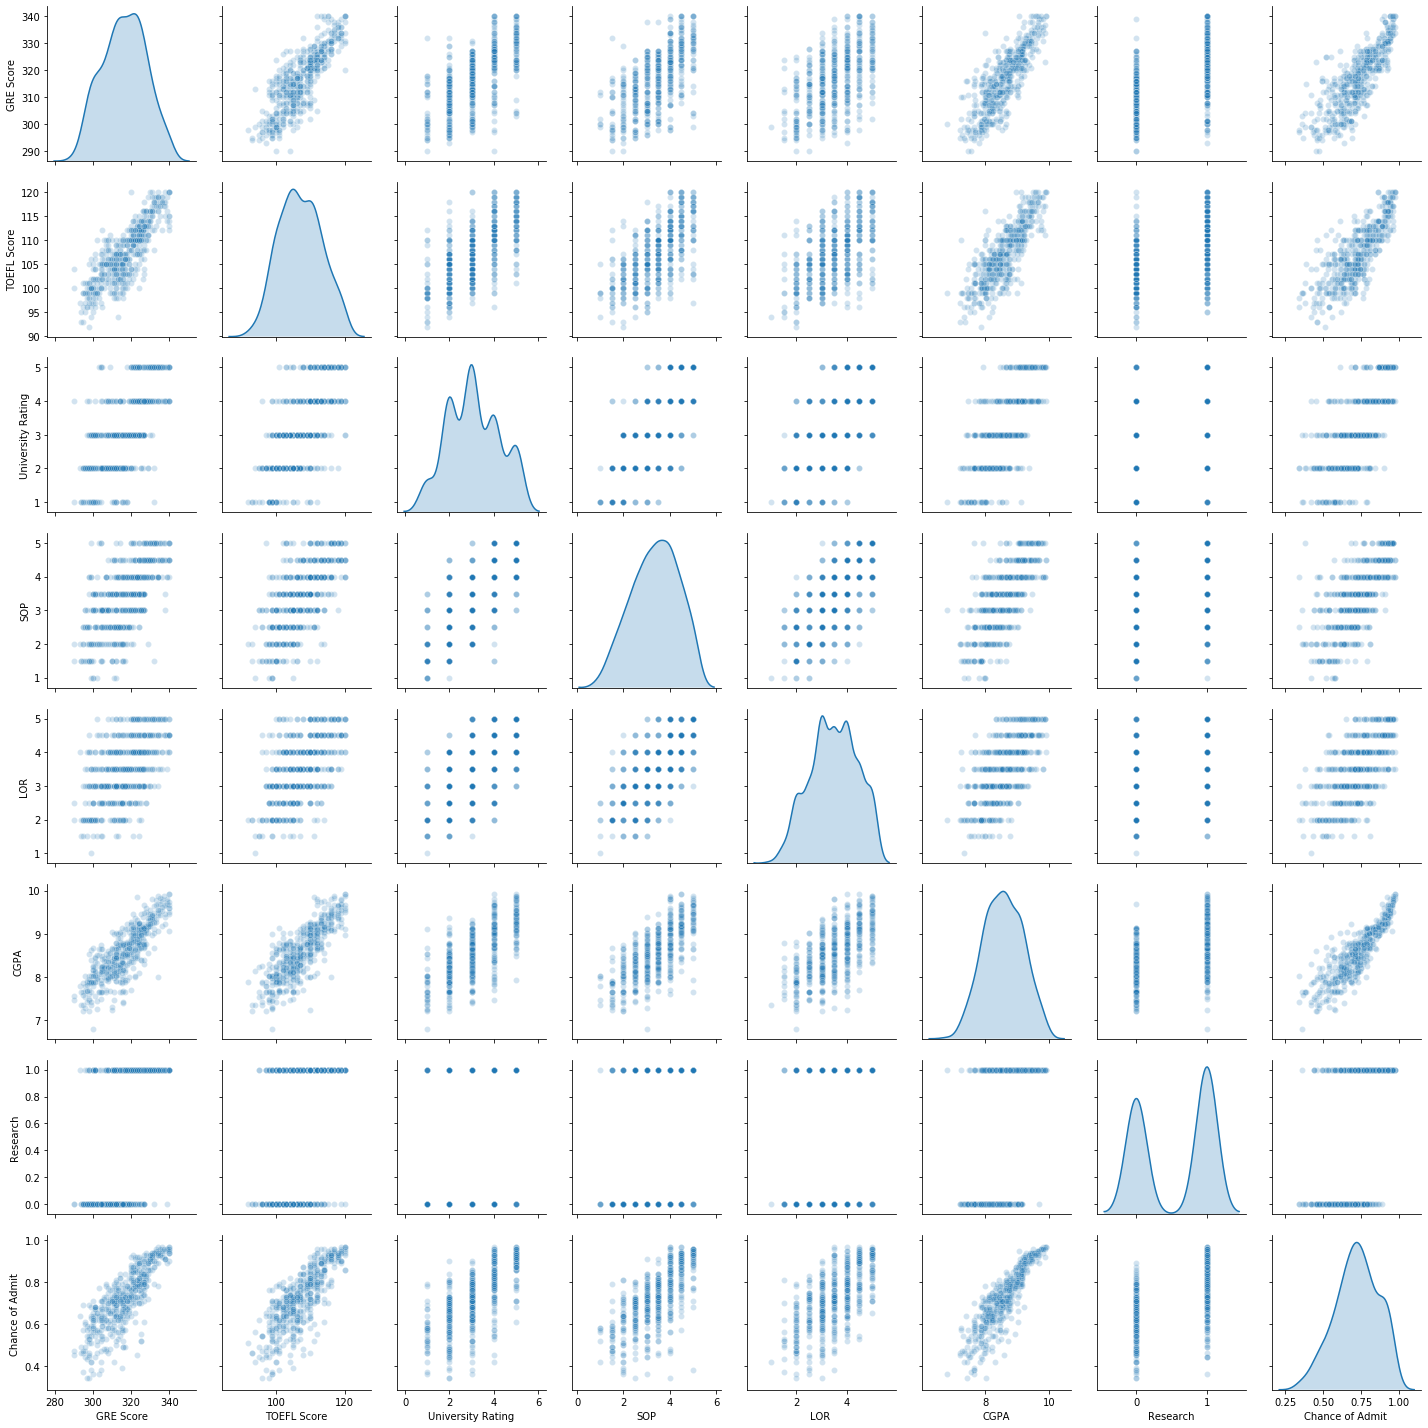

In [7]:
sns.pairplot(dataset,diag_kind='kde',plot_kws={'alpha': .2});

C:\Users\aci\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Chance of Admit                                                    \
                    count      mean       std   min     25%    50%     75%   
Research                                                                     
0                   220.0  0.634909  0.111918  0.34  0.5675  0.645  0.7100   
1                   280.0  0.789964  0.123208  0.36  0.7200  0.800  0.8925   

                
           max  
Research        
0         0.89  
1         0.97

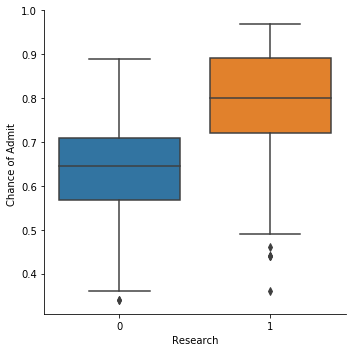

In [8]:
sns.factorplot(y="Chance of Admit ",x='Research',data=dataset,kind='box');
dataset.loc[:,['Research','Chance of Admit ']].groupby('Research').describe()

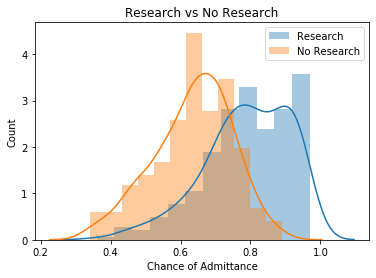

In [9]:
sns.distplot(dataset[dataset.loc[:,'Research'] == 1].loc[:,['Chance of Admit ']],kde=True);
sns.distplot(dataset[dataset.loc[:,'Research'] == 0].loc[:,['Chance of Admit ']],kde=True);
plt.xlabel('Chance of Admittance')
plt.ylabel('Count')
plt.title('Research vs No Research');
plt.legend(['Research','No Research']);

C:\Users\aci\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\aci\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\aci\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg

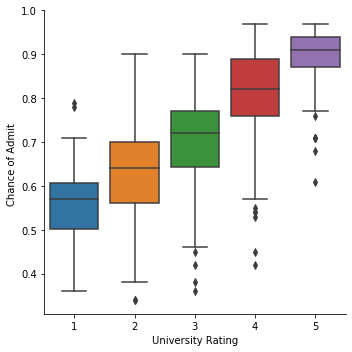

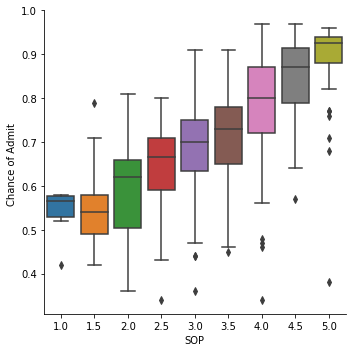

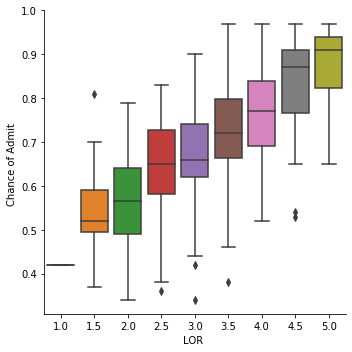

In [10]:
sns.factorplot(x='University Rating',y='Chance of Admit ',kind='box',data=dataset);
sns.factorplot(x='SOP',y='Chance of Admit ',kind='box',data=dataset);
sns.factorplot(x='LOR ',y='Chance of Admit ',kind='box',data=dataset);

In [11]:
target = dataset.pop('Chance of Admit ')

In [12]:
# split data into train test 
X_train,X_test,y_train,y_test = train_test_split(dataset.values.astype(np.float32),
                                                 target.values.reshape(-1,1).astype(np.float32),
                                                 test_size=.2,
                                                random_state=42)

In [13]:
# normalize data to 0 mean and unit std
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
import skorch
from skorch import NeuralNetRegressor

from sklearn.model_selection import RandomizedSearchCV

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [15]:
class MyModule(nn.Module):
    def __init__(self,num_units=10,nonlin=F.relu,drop=.5):
        super(MyModule,self).__init__()
        
        self.module = nn.Sequential(
            nn.Linear(7,num_units),
            nn.LeakyReLU(),
            nn.Dropout(p=drop),
            nn.Linear(num_units,1),
        )
        
    def forward(self,X):
        X = self.module(X)
        return X

In [16]:
net = NeuralNetRegressor(
    MyModule,
    criterion=nn.MSELoss,
    max_epochs=10,
    optimizer=optim.Adam,
    optimizer__lr = .005
)

In [17]:
lr = (10**np.random.uniform(-5,-2.5,1000)).tolist()
params = {
    'optimizer__lr': lr,
    'max_epochs':[300,400,500],
    'module__num_units': [14,20,28,36,42],
    'module__drop' : [0,.1,.2,.3,.4]
}

gs = RandomizedSearchCV(net,params,refit=True,cv=3,scoring='neg_mean_squared_error',n_iter=100)

In [18]:
#%%capture
gs.fit(X_train_scaled,y_train);

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1828        0.1694  0.0130
      2        0.1992        0.1665  0.0140
      3        0.1823        0.1636  0.0130
      4        0.1734        0.1609  0.0160
      5        0.1793        0.1581  0.0150
      6        0.1722        0.1555  0.0140
      7        0.1822        0.1529  0.0140
      8        0.1730        0.1503  0.0120
      9        0.1713        0.1478  0.0120
     10        0.1591        0.1453  0.0120
     11        0.1618        0.1429  0.0140
     12        0.1688        0.1405  0.0180
     13        0.1593        0.1382  0.0160
     14        0.1569        0.1360  0.0330
     15        0.1624        0.1338  0.0150
     16        0.1565        0.1316  0.0140
     17        0.1544        0.1295  0.0140
     18        0.1432        0.1275  0.0140
     19        0.1453        0.1255  0.0120
     20        0.1467        0.1236  0.0130
     21        0.1489        0.1

    185        0.0469        0.0349  0.0120
    186        0.0444        0.0347  0.0140
    187        0.0457        0.0345  0.0130
    188        0.0486        0.0343  0.0140
    189        0.0486        0.0341  0.0130
    190        0.0439        0.0339  0.0140
    191        0.0444        0.0337  0.0120
    192        0.0455        0.0335  0.0110
    193        0.0450        0.0333  0.0110
    194        0.0442        0.0331  0.0120
    195        0.0385        0.0329  0.0090
    196        0.0473        0.0327  0.0130
    197        0.0386        0.0325  0.0110
    198        0.0448        0.0323  0.0110
    199        0.0422        0.0321  0.0120
    200        0.0383        0.0319  0.0110
    201        0.0461        0.0317  0.0130
    202        0.0439        0.0315  0.0140
    203        0.0457        0.0313  0.0120
    204        0.0434        0.0311  0.0140
    205        0.0416        0.0309  0.0130
    206        0.0386        0.0307  0.0120
    207        0.0426        0.0

    371        0.0195        0.0127  0.0120
    372        0.0219        0.0126  0.0140
    373        0.0214        0.0126  0.0150
    374        0.0195        0.0125  0.0140
    375        0.0202        0.0125  0.0140
    376        0.0225        0.0124  0.0130
    377        0.0200        0.0124  0.0090
    378        0.0188        0.0123  0.0150
    379        0.0205        0.0123  0.0090
    380        0.0190        0.0122  0.0130
    381        0.0226        0.0122  0.0100
    382        0.0202        0.0121  0.0090
    383        0.0181        0.0121  0.0130
    384        0.0204        0.0120  0.0150
    385        0.0208        0.0120  0.0120
    386        0.0173        0.0119  0.0130
    387        0.0234        0.0118  0.0150
    388        0.0182        0.0118  0.0140
    389        0.0195        0.0117  0.0140
    390        0.0232        0.0117  0.0100
    391        0.0192        0.0116  0.0120
    392        0.0161        0.0116  0.0110
    393        0.0190        0.0

     55        0.1664        0.1663  0.0150
     56        0.1504        0.1637  0.0140
     57        0.1617        0.1612  0.0110
     58        0.1493        0.1587  0.0130
     59        0.1514        0.1563  0.0140
     60        0.1469        0.1539  0.0100
     61        0.1495        0.1515  0.0120
     62        0.1451        0.1492  0.0120
     63        0.1400        0.1469  0.0150
     64        0.1341        0.1446  0.0100
     65        0.1396        0.1424  0.0110
     66        0.1360        0.1403  0.0130
     67        0.1409        0.1381  0.0140
     68        0.1350        0.1360  0.0140
     69        0.1364        0.1339  0.0100
     70        0.1347        0.1319  0.0140
     71        0.1295        0.1299  0.0130
     72        0.1278        0.1279  0.0150
     73        0.1287        0.1260  0.0130
     74        0.1210        0.1241  0.0120
     75        0.1284        0.1222  0.0150
     76        0.1168        0.1203  0.0120
     77        0.1183        0.1

    241        0.0384        0.0229  0.0140
    242        0.0384        0.0228  0.0140
    243        0.0333        0.0226  0.0150
    244        0.0370        0.0225  0.0140
    245        0.0332        0.0223  0.0080
    246        0.0362        0.0222  0.0110
    247        0.0314        0.0221  0.0130
    248        0.0369        0.0219  0.0150
    249        0.0355        0.0218  0.0160
    250        0.0343        0.0216  0.0130
    251        0.0381        0.0215  0.0100
    252        0.0326        0.0214  0.0120
    253        0.0379        0.0212  0.0150
    254        0.0325        0.0211  0.0140
    255        0.0326        0.0209  0.0120
    256        0.0368        0.0208  0.0090
    257        0.0347        0.0207  0.0150
    258        0.0314        0.0205  0.0140
    259        0.0360        0.0204  0.0140
    260        0.0338        0.0203  0.0140
    261        0.0328        0.0202  0.0130
    262        0.0319        0.0200  0.0120
    263        0.0319        0.0

    427        0.0187        0.0086  0.0130
    428        0.0178        0.0086  0.0110
    429        0.0178        0.0086  0.0120
    430        0.0204        0.0086  0.0130
    431        0.0180        0.0085  0.0140
    432        0.0193        0.0085  0.0130
    433        0.0192        0.0085  0.0120
    434        0.0204        0.0085  0.0100
    435        0.0194        0.0084  0.0120
    436        0.0188        0.0084  0.0140
    437        0.0213        0.0084  0.0130
    438        0.0207        0.0084  0.0140
    439        0.0203        0.0083  0.0120
    440        0.0187        0.0083  0.0130
    441        0.0175        0.0083  0.0140
    442        0.0212        0.0083  0.0150
    443        0.0196        0.0082  0.0140
    444        0.0187        0.0082  0.0110
    445        0.0169        0.0082  0.0120
    446        0.0194        0.0082  0.0140
    447        0.0191        0.0081  0.0130
    448        0.0161        0.0081  0.0140
    449        0.0187        0.0

    111        0.2115        0.2081  0.0156
    112        0.2191        0.2057  0.0156
    113        0.2136        0.2034  0.0000
    114        0.2173        0.2011  0.0156
    115        0.2219        0.1988  0.0156
    116        0.2000        0.1966  0.0000
    117        0.2005        0.1944  0.0000
    118        0.2022        0.1922  0.0156
    119        0.1971        0.1901  0.0156
    120        0.2069        0.1879  0.0000
    121        0.2039        0.1859  0.0156
    122        0.1904        0.1838  0.0156
    123        0.1841        0.1818  0.0000
    124        0.1955        0.1798  0.0156
    125        0.1884        0.1778  0.0156
    126        0.1846        0.1759  0.0000
    127        0.1949        0.1740  0.0156
    128        0.1744        0.1721  0.0156
    129        0.1832        0.1703  0.0156
    130        0.1783        0.1685  0.0000
    131        0.1756        0.1667  0.0000
    132        0.1769        0.1649  0.0156
    133        0.1769        0.1

    297        0.0729        0.0583  0.0156
    298        0.0710        0.0580  0.0156
    299        0.0737        0.0577  0.0156
    300        0.0738        0.0574  0.0156
    301        0.0711        0.0572  0.0000
    302        0.0745        0.0569  0.0156
    303        0.0676        0.0566  0.0000
    304        0.0690        0.0563  0.0156
    305        0.0657        0.0561  0.0000
    306        0.0666        0.0558  0.0000
    307        0.0681        0.0555  0.0156
    308        0.0723        0.0552  0.0156
    309        0.0668        0.0550  0.0000
    310        0.0699        0.0547  0.0156
    311        0.0647        0.0544  0.0156
    312        0.0649        0.0542  0.0156
    313        0.0679        0.0539  0.0156
    314        0.0624        0.0536  0.0000
    315        0.0661        0.0534  0.0110
    316        0.0609        0.0531  0.0100
    317        0.0675        0.0528  0.0130
    318        0.0653        0.0526  0.0110
    319        0.0608        0.0

    483        0.0387        0.0225  0.0156
    484        0.0399        0.0224  0.0156
    485        0.0405        0.0223  0.0156
    486        0.0318        0.0221  0.0156
    487        0.0346        0.0220  0.0000
    488        0.0340        0.0219  0.0000
    489        0.0333        0.0218  0.0156
    490        0.0324        0.0217  0.0156
    491        0.0345        0.0216  0.0156
    492        0.0343        0.0215  0.0156
    493        0.0384        0.0214  0.0156
    494        0.0410        0.0213  0.0156
    495        0.0328        0.0212  0.0156
    496        0.0363        0.0211  0.0156
    497        0.0352        0.0210  0.0156
    498        0.0341        0.0210  0.0156
    499        0.0332        0.0209  0.0156
    500        0.0351        0.0208  0.0156
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.1793        1.2224  0.0156
      2        1.1882        1.2212  0.0156
      3        1.1694        1.2

    167        1.0089        1.0338  0.0156
    168        0.9974        1.0327  0.0156
    169        0.9884        1.0317  0.0156
    170        1.0023        1.0306  0.0156
    171        0.9659        1.0295  0.0000
    172        0.9544        1.0285  0.0156
    173        1.0021        1.0274  0.0156
    174        0.9797        1.0264  0.0000
    175        0.9693        1.0253  0.0000
    176        0.9967        1.0242  0.0156
    177        0.9512        1.0232  0.0156
    178        0.9781        1.0221  0.0156
    179        0.9846        1.0211  0.0156
    180        0.9526        1.0200  0.0156
    181        0.9807        1.0190  0.0000
    182        0.9675        1.0179  0.0156
    183        0.9792        1.0169  0.0156
    184        0.9919        1.0158  0.0156
    185        0.9381        1.0148  0.0156
    186        0.9311        1.0137  0.0000
    187        0.9937        1.0127  0.0156
    188        0.9564        1.0117  0.0000
    189        0.9902        1.0

    353        0.8471        0.8505  0.0130
    354        0.7953        0.8496  0.0150
    355        0.7943        0.8487  0.0110
    356        0.8169        0.8478  0.0080
    357        0.8448        0.8469  0.0140
    358        0.8097        0.8460  0.0140
    359        0.8100        0.8451  0.0090
    360        0.7941        0.8442  0.0110
    361        0.8271        0.8432  0.0110
    362        0.8216        0.8423  0.0110
    363        0.7976        0.8414  0.0110
    364        0.7660        0.8405  0.0090
    365        0.7974        0.8396  0.0120
    366        0.7876        0.8387  0.0100
    367        0.7800        0.8378  0.0090
    368        0.7858        0.8369  0.0120
    369        0.8224        0.8360  0.0130
    370        0.7772        0.8351  0.0120
    371        0.7903        0.8342  0.0140
    372        0.7889        0.8333  0.0130
    373        0.7836        0.8324  0.0130
    374        0.7684        0.8315  0.0150
    375        0.7822        0.8

    137        0.4231        0.4311  0.0110
    138        0.4240        0.4305  0.0110
    139        0.4274        0.4299  0.0120
    140        0.4080        0.4294  0.0150
    141        0.4290        0.4288  0.0140
    142        0.3906        0.4283  0.0150
    143        0.4175        0.4277  0.0130
    144        0.4316        0.4271  0.0130
    145        0.3992        0.4266  0.0120
    146        0.3992        0.4260  0.0140
    147        0.4257        0.4255  0.0120
    148        0.3947        0.4249  0.0140
    149        0.4129        0.4244  0.0130
    150        0.4145        0.4238  0.0140
    151        0.3996        0.4233  0.0140
    152        0.3878        0.4227  0.0110
    153        0.3993        0.4222  0.0140
    154        0.4018        0.4216  0.0160
    155        0.4293        0.4211  0.0130
    156        0.3960        0.4205  0.0110
    157        0.4312        0.4200  0.0130
    158        0.3878        0.4195  0.0100
    159        0.4195        0.4

    323        0.3329        0.3373  0.0130
    324        0.3288        0.3368  0.0120
    325        0.3197        0.3364  0.0120
    326        0.3262        0.3359  0.0120
    327        0.3401        0.3355  0.0090
    328        0.3213        0.3350  0.0130
    329        0.3268        0.3346  0.0120
    330        0.3498        0.3342  0.0140
    331        0.3246        0.3337  0.0130
    332        0.3214        0.3333  0.0140
    333        0.3199        0.3328  0.0130
    334        0.3458        0.3324  0.0130
    335        0.3335        0.3319  0.0120
    336        0.3034        0.3315  0.0130
    337        0.3177        0.3310  0.0140
    338        0.3303        0.3306  0.0130
    339        0.3164        0.3301  0.0140
    340        0.3472        0.3297  0.0140
    341        0.3250        0.3293  0.0140
    342        0.3491        0.3288  0.0130
    343        0.3175        0.3284  0.0130
    344        0.3469        0.3279  0.0140
    345        0.3265        0.3

    107        0.9255        0.9162  0.0156
    108        0.9278        0.9151  0.0156
    109        0.8851        0.9141  0.0000
    110        0.9090        0.9130  0.0156
    111        0.8936        0.9120  0.0156
    112        0.9139        0.9110  0.0156
    113        0.9106        0.9099  0.0100
    114        0.9602        0.9089  0.0100
    115        0.9155        0.9078  0.0100
    116        0.8879        0.9068  0.0120
    117        0.8858        0.9057  0.0110
    118        0.9067        0.9047  0.0110
    119        0.9255        0.9037  0.0026
    120        0.8976        0.9026  0.0156
    121        0.9192        0.9015  0.0100
    122        0.8719        0.9005  0.0120
    123        0.9140        0.8995  0.0156
    124        0.8558        0.8984  0.0156
    125        0.9159        0.8974  0.0156
    126        0.9214        0.8963  0.0156
    127        0.9091        0.8953  0.0240
    128        0.8911        0.8942  0.0180
    129        0.8942        0.8

    293        0.7214        0.7380  0.0120
    294        0.7286        0.7372  0.0120
    295        0.7214        0.7363  0.0156
    296        0.7554        0.7354  0.0156
    297        0.7551        0.7346  0.0156
    298        0.7331        0.7337  0.0119
    299        0.7203        0.7329  0.0100
    300        0.7485        0.7320  0.0120
    301        0.7455        0.7311  0.0120
    302        0.7458        0.7303  0.0110
    303        0.7261        0.7294  0.0000
    304        0.7396        0.7285  0.0150
    305        0.7446        0.7277  0.0100
    306        0.7346        0.7268  0.0130
    307        0.7278        0.7260  0.0130
    308        0.7340        0.7251  0.0130
    309        0.7255        0.7243  0.0180
    310        0.7244        0.7234  0.0130
    311        0.7587        0.7226  0.0110
    312        0.7268        0.7217  0.0120
    313        0.7387        0.7209  0.0190
    314        0.7351        0.7200  0.0140
    315        0.7369        0.7

     77        0.5354        0.4873  0.0120
     78        0.4980        0.4868  0.0100
     79        0.5046        0.4864  0.0140
     80        0.5010        0.4859  0.0160
     81        0.5076        0.4854  0.0110
     82        0.5008        0.4850  0.0110
     83        0.4719        0.4845  0.0160
     84        0.4676        0.4841  0.0140
     85        0.5454        0.4836  0.0170
     86        0.4974        0.4831  0.0160
     87        0.4959        0.4827  0.0130
     88        0.4895        0.4822  0.0160
     89        0.5188        0.4817  0.0130
     90        0.4765        0.4813  0.0080
     91        0.4776        0.4808  0.0130
     92        0.4992        0.4804  0.0110
     93        0.4965        0.4799  0.0110
     94        0.4685        0.4795  0.0110
     95        0.4971        0.4790  0.0120
     96        0.4877        0.4786  0.0000
     97        0.5097        0.4781  0.0000
     98        0.5202        0.4777  0.0156
     99        0.4993        0.4

    263        0.4412        0.4097  0.0156
    264        0.4234        0.4093  0.0156
    265        0.4323        0.4089  0.0156
    266        0.4348        0.4086  0.0000
    267        0.4232        0.4082  0.0156
    268        0.4167        0.4078  0.0000
    269        0.4198        0.4074  0.0156
    270        0.4296        0.4070  0.0156
    271        0.4391        0.4066  0.0156
    272        0.4239        0.4063  0.0000
    273        0.4226        0.4059  0.0156
    274        0.4268        0.4055  0.0156
    275        0.4010        0.4051  0.0000
    276        0.4274        0.4048  0.0156
    277        0.4237        0.4044  0.0156
    278        0.4123        0.4040  0.0156
    279        0.3876        0.4037  0.0156
    280        0.4330        0.4033  0.0273
    281        0.3917        0.4029  0.0090
    282        0.4111        0.4025  0.0110
    283        0.3903        0.4022  0.0140
    284        0.4066        0.4018  0.0011
    285        0.4212        0.4

    449        0.3536        0.3460  0.0110
    450        0.3422        0.3457  0.0090
    451        0.3577        0.3454  0.0000
    452        0.3365        0.3451  0.0000
    453        0.3339        0.3448  0.0156
    454        0.3414        0.3445  0.0156
    455        0.3361        0.3442  0.0156
    456        0.3517        0.3439  0.0156
    457        0.3359        0.3436  0.0156
    458        0.3421        0.3433  0.0156
    459        0.3332        0.3430  0.0156
    460        0.3440        0.3427  0.0156
    461        0.3433        0.3423  0.0000
    462        0.3634        0.3420  0.0156
    463        0.3509        0.3417  0.0156
    464        0.3468        0.3414  0.0156
    465        0.3534        0.3411  0.0000
    466        0.3496        0.3408  0.0000
    467        0.3652        0.3405  0.0000
    468        0.3297        0.3402  0.0156
    469        0.3599        0.3399  0.0156
    470        0.3382        0.3396  0.0156
    471        0.3476        0.3

    133        0.6223        0.5698  0.0170
    134        0.6002        0.5692  0.0160
    135        0.5756        0.5687  0.0120
    136        0.6293        0.5682  0.0140
    137        0.5543        0.5676  0.0140
    138        0.6105        0.5671  0.0120
    139        0.5845        0.5666  0.0110
    140        0.5949        0.5660  0.0140
    141        0.5752        0.5655  0.0130
    142        0.5895        0.5650  0.0150
    143        0.5872        0.5644  0.0130
    144        0.6303        0.5639  0.0140
    145        0.5946        0.5634  0.0130
    146        0.6109        0.5628  0.0110
    147        0.5925        0.5623  0.0140
    148        0.5898        0.5618  0.0120
    149        0.5904        0.5613  0.0130
    150        0.5663        0.5607  0.0120
    151        0.5902        0.5602  0.0110
    152        0.5654        0.5597  0.0110
    153        0.5860        0.5592  0.0120
    154        0.5739        0.5586  0.0110
    155        0.5720        0.5

    319        0.5008        0.4778  0.0110
    320        0.5068        0.4773  0.0120
    321        0.4962        0.4769  0.0140
    322        0.5055        0.4764  0.0130
    323        0.4982        0.4760  0.0110
    324        0.4958        0.4755  0.0100
    325        0.5138        0.4751  0.0110
    326        0.5142        0.4746  0.0120
    327        0.4927        0.4742  0.0100
    328        0.5051        0.4737  0.0110
    329        0.4758        0.4732  0.0090
    330        0.5068        0.4728  0.0140
    331        0.4741        0.4723  0.0120
    332        0.4894        0.4719  0.0100
    333        0.4909        0.4714  0.0110
    334        0.4708        0.4710  0.0140
    335        0.4718        0.4705  0.0130
    336        0.5065        0.4701  0.0100
    337        0.4756        0.4696  0.0090
    338        0.5033        0.4692  0.0090
    339        0.5071        0.4687  0.0130
    340        0.4688        0.4683  0.0120
    341        0.5083        0.4

      3        0.2936        0.2640  0.0140
      4        0.2984        0.2637  0.0150
      5        0.2855        0.2633  0.0130
      6        0.2901        0.2630  0.0170
      7        0.3013        0.2626  0.0090
      8        0.2894        0.2623  0.0120
      9        0.2693        0.2620  0.0140
     10        0.3054        0.2616  0.0140
     11        0.2518        0.2613  0.0150
     12        0.2943        0.2609  0.0110
     13        0.2754        0.2606  0.0140
     14        0.2727        0.2602  0.0140
     15        0.2864        0.2599  0.0130
     16        0.3088        0.2596  0.0130
     17        0.2936        0.2592  0.0140
     18        0.2827        0.2589  0.0140
     19        0.2765        0.2585  0.0110
     20        0.2799        0.2582  0.0110
     21        0.2983        0.2578  0.0130
     22        0.2871        0.2575  0.0130
     23        0.2840        0.2572  0.0150
     24        0.2787        0.2568  0.0140
     25        0.2810        0.2

    189        0.2291        0.2067  0.0080
    190        0.2331        0.2064  0.0110
    191        0.2325        0.2061  0.0120
    192        0.2241        0.2058  0.0140
    193        0.2341        0.2056  0.0120
    194        0.2274        0.2053  0.0110
    195        0.2331        0.2050  0.0120
    196        0.2470        0.2048  0.0130
    197        0.2169        0.2045  0.0140
    198        0.2310        0.2042  0.0120
    199        0.2200        0.2039  0.0120
    200        0.2211        0.2037  0.0170
    201        0.2319        0.2034  0.0170
    202        0.2267        0.2031  0.0170
    203        0.2057        0.2029  0.0160
    204        0.2349        0.2026  0.0130
    205        0.2348        0.2023  0.0120
    206        0.2138        0.2021  0.0120
    207        0.2268        0.2018  0.0130
    208        0.2192        0.2015  0.0130
    209        0.2321        0.2013  0.0120
    210        0.2305        0.2010  0.0140
    211        0.2169        0.2

    375        0.1737        0.1616  0.0120
    376        0.1870        0.1614  0.0150
    377        0.1907        0.1612  0.0100
    378        0.1809        0.1610  0.0120
    379        0.1736        0.1608  0.0110
    380        0.1887        0.1606  0.0140
    381        0.1828        0.1604  0.0140
    382        0.1684        0.1602  0.0120
    383        0.1697        0.1600  0.0140
    384        0.1856        0.1598  0.0140
    385        0.1789        0.1595  0.0110
    386        0.1861        0.1593  0.0130
    387        0.1871        0.1591  0.0150
    388        0.1830        0.1589  0.0130
    389        0.1866        0.1587  0.0120
    390        0.1802        0.1585  0.0140
    391        0.1917        0.1583  0.0130
    392        0.1756        0.1581  0.0120
    393        0.1813        0.1579  0.0130
    394        0.1751        0.1577  0.0120
    395        0.1843        0.1575  0.0130
    396        0.1899        0.1573  0.0120
    397        0.1778        0.1

     59        0.6452        0.5804  0.0140
     60        0.6477        0.5750  0.0110
     61        0.6230        0.5697  0.0130
     62        0.5723        0.5645  0.0120
     63        0.6108        0.5594  0.0130
     64        0.5639        0.5543  0.0120
     65        0.5976        0.5492  0.0140
     66        0.6020        0.5442  0.0120
     67        0.5905        0.5392  0.0110
     68        0.5631        0.5342  0.0130
     69        0.5744        0.5293  0.0150
     70        0.5573        0.5244  0.0100
     71        0.5298        0.5195  0.0150
     72        0.5512        0.5148  0.0150
     73        0.5730        0.5101  0.0100
     74        0.5518        0.5054  0.0130
     75        0.5236        0.5008  0.0140
     76        0.5171        0.4962  0.0150
     77        0.4929        0.4918  0.0140
     78        0.5108        0.4874  0.0140
     79        0.5219        0.4830  0.0100
     80        0.4792        0.4787  0.0110
     81        0.5222        0.4

    245        0.1808        0.1484  0.0110
    246        0.1914        0.1478  0.0120
    247        0.1936        0.1472  0.0100
    248        0.1851        0.1466  0.0120
    249        0.1876        0.1460  0.0130
    250        0.1776        0.1454  0.0110
    251        0.1924        0.1447  0.0100
    252        0.1961        0.1441  0.0110
    253        0.1820        0.1435  0.0110
    254        0.1929        0.1429  0.0100
    255        0.1942        0.1423  0.0090
    256        0.1649        0.1418  0.0110
    257        0.1808        0.1412  0.0110
    258        0.1891        0.1406  0.0120
    259        0.1793        0.1401  0.0120
    260        0.1784        0.1395  0.0120
    261        0.1808        0.1390  0.0100
    262        0.1865        0.1385  0.0000
    263        0.1702        0.1379  0.0170
    264        0.1789        0.1375  0.0120
    265        0.1759        0.1370  0.0120
    266        0.1758        0.1365  0.0190
    267        0.1814        0.1

    129        0.5022        0.4569  0.0120
    130        0.4998        0.4533  0.0120
    131        0.5161        0.4496  0.0140
    132        0.5412        0.4461  0.0150
    133        0.5385        0.4424  0.0130
    134        0.4922        0.4389  0.0130
    135        0.4939        0.4354  0.0090
    136        0.4900        0.4318  0.0120
    137        0.4774        0.4284  0.0130
    138        0.4905        0.4250  0.0110
    139        0.4707        0.4217  0.0120
    140        0.4933        0.4183  0.0130
    141        0.4934        0.4150  0.0080
    142        0.4668        0.4118  0.0100
    143        0.4288        0.4085  0.0150
    144        0.4946        0.4052  0.0100
    145        0.4982        0.4020  0.0120
    146        0.4459        0.3988  0.0110
    147        0.4514        0.3957  0.0110
    148        0.4167        0.3925  0.0110
    149        0.4908        0.3894  0.0160
    150        0.4813        0.3863  0.0110
    151        0.4539        0.3

     13        0.6999        0.6884  0.0100
     14        0.6413        0.6805  0.0110
     15        0.6699        0.6728  0.0120
     16        0.6564        0.6651  0.0110
     17        0.6521        0.6575  0.0120
     18        0.6735        0.6499  0.0120
     19        0.6350        0.6425  0.0120
     20        0.6398        0.6350  0.0130
     21        0.6177        0.6276  0.0110
     22        0.5965        0.6202  0.0110
     23        0.5616        0.6128  0.0130
     24        0.6203        0.6055  0.0110
     25        0.6029        0.5981  0.0110
     26        0.5864        0.5909  0.0120
     27        0.5794        0.5838  0.0120
     28        0.6359        0.5767  0.0130
     29        0.5887        0.5698  0.0130
     30        0.6113        0.5629  0.0120
     31        0.5969        0.5559  0.0110
     32        0.5598        0.5490  0.0120
     33        0.5934        0.5421  0.0130
     34        0.5866        0.5353  0.0140
     35        0.5627        0.5

    199        0.1655        0.0945  0.0130
    200        0.1770        0.0939  0.0160
    201        0.2146        0.0934  0.0100
    202        0.1960        0.0928  0.0100
    203        0.1940        0.0922  0.0100
    204        0.1700        0.0916  0.0130
    205        0.1525        0.0909  0.0130
    206        0.1791        0.0903  0.0140
    207        0.1944        0.0897  0.0150
    208        0.1709        0.0891  0.0130
    209        0.1688        0.0885  0.0160
    210        0.1667        0.0879  0.0140
    211        0.1817        0.0873  0.0120
    212        0.1584        0.0868  0.0150
    213        0.1582        0.0862  0.0110
    214        0.1951        0.0857  0.0130
    215        0.1682        0.0852  0.0140
    216        0.1954        0.0847  0.0120
    217        0.1746        0.0841  0.0150
    218        0.1647        0.0836  0.0120
    219        0.1902        0.0831  0.0150
    220        0.1685        0.0826  0.0120
    221        0.1913        0.0

     83        0.0516        0.0266  0.0150
     84        0.0608        0.0262  0.0150
     85        0.0603        0.0257  0.0150
     86        0.0543        0.0253  0.0150
     87        0.0618        0.0249  0.0150
     88        0.0572        0.0245  0.0140
     89        0.0592        0.0240  0.0130
     90        0.0678        0.0236  0.0170
     91        0.0691        0.0232  0.0110
     92        0.0439        0.0227  0.0140
     93        0.0638        0.0223  0.0160
     94        0.0522        0.0219  0.0140
     95        0.0537        0.0215  0.0140
     96        0.0469        0.0211  0.0130
     97        0.0507        0.0209  0.0120
     98        0.0539        0.0207  0.0130
     99        0.0542        0.0206  0.0150
    100        0.0586        0.0204  0.0140
    101        0.0489        0.0202  0.0190
    102        0.0519        0.0200  0.0190
    103        0.0542        0.0199  0.0170
    104        0.0524        0.0198  0.0110
    105        0.0507        0.0

    269        0.0214        0.0064  0.0100
    270        0.0189        0.0063  0.0130
    271        0.0195        0.0063  0.0120
    272        0.0251        0.0063  0.0110
    273        0.0203        0.0063  0.0130
    274        0.0246        0.0063  0.0110
    275        0.0207        0.0064  0.0100
    276        0.0223        0.0064  0.0130
    277        0.0209        0.0065  0.0100
    278        0.0251        0.0065  0.0140
    279        0.0240        0.0064  0.0130
    280        0.0218        0.0064  0.0130
    281        0.0218        0.0063  0.0130
    282        0.0239        0.0063  0.0120
    283        0.0206        0.0064  0.0110
    284        0.0268        0.0064  0.0120
    285        0.0222        0.0064  0.0130
    286        0.0238        0.0063  0.0140
    287        0.0196        0.0061  0.0150
    288        0.0211        0.0060  0.0120
    289        0.0206        0.0059  0.0130
    290        0.0217        0.0058  0.0110
    291        0.0216        0.0

    153        0.0338        0.0122  0.0130
    154        0.0345        0.0122  0.0130
    155        0.0341        0.0122  0.0130
    156        0.0282        0.0122  0.0100
    157        0.0318        0.0122  0.0130
    158        0.0344        0.0121  0.0150
    159        0.0309        0.0120  0.0140
    160        0.0346        0.0119  0.0082
    161        0.0352        0.0118  0.0110
    162        0.0334        0.0117  0.0120
    163        0.0322        0.0116  0.0110
    164        0.0305        0.0116  0.0130
    165        0.0285        0.0115  0.0130
    166        0.0314        0.0114  0.0110
    167        0.0286        0.0112  0.0120
    168        0.0289        0.0111  0.0120
    169        0.0301        0.0110  0.0140
    170        0.0279        0.0109  0.0130
    171        0.0290        0.0108  0.0110
    172        0.0274        0.0107  0.0110
    173        0.0296        0.0107  0.0130
    174        0.0328        0.0106  0.0160
    175        0.0340        0.0

     37        0.0849        0.0364  0.0140
     38        0.0850        0.0353  0.0130
     39        0.0732        0.0341  0.0120
     40        0.0833        0.0330  0.0120
     41        0.0658        0.0319  0.0120
     42        0.0757        0.0309  0.0140
     43        0.0576        0.0299  0.0130
     44        0.0728        0.0290  0.0130
     45        0.0570        0.0281  0.0120
     46        0.0749        0.0272  0.0120
     47        0.0658        0.0263  0.0140
     48        0.0685        0.0255  0.0120
     49        0.0597        0.0248  0.0140
     50        0.0627        0.0240  0.0140
     51        0.0596        0.0234  0.0130
     52        0.0584        0.0227  0.0120
     53        0.0624        0.0221  0.0120
     54        0.0613        0.0215  0.0120
     55        0.0544        0.0210  0.0090
     56        0.0555        0.0205  0.0120
     57        0.0539        0.0201  0.0110
     58        0.0569        0.0196  0.0140
     59        0.0484        0.0

    223        0.0186        0.0051  0.0140
    224        0.0197        0.0050  0.0150
    225        0.0177        0.0050  0.0140
    226        0.0174        0.0050  0.0110
    227        0.0173        0.0050  0.0140
    228        0.0168        0.0050  0.0120
    229        0.0183        0.0050  0.0110
    230        0.0209        0.0050  0.0080
    231        0.0167        0.0050  0.0110
    232        0.0168        0.0050  0.0080
    233        0.0179        0.0049  0.0120
    234        0.0190        0.0049  0.0110
    235        0.0147        0.0049  0.0090
    236        0.0150        0.0049  0.0130
    237        0.0182        0.0049  0.0100
    238        0.0159        0.0049  0.0110
    239        0.0149        0.0049  0.0100
    240        0.0197        0.0049  0.0100
    241        0.0155        0.0049  0.0110
    242        0.0159        0.0049  0.0120
    243        0.0151        0.0049  0.0120
    244        0.0174        0.0049  0.0100
    245        0.0159        0.0

    107        0.2030        0.1113  0.0120
    108        0.1950        0.1096  0.0110
    109        0.2069        0.1080  0.0120
    110        0.2106        0.1064  0.0130
    111        0.1895        0.1048  0.0120
    112        0.2105        0.1033  0.0130
    113        0.1863        0.1019  0.0130
    114        0.2004        0.1005  0.0120
    115        0.1751        0.0991  0.0120
    116        0.1775        0.0979  0.0150
    117        0.1810        0.0967  0.0120
    118        0.1481        0.0955  0.0130
    119        0.1780        0.0944  0.0120
    120        0.1883        0.0933  0.0120
    121        0.1946        0.0922  0.0170
    122        0.1681        0.0912  0.0120
    123        0.1765        0.0902  0.0110
    124        0.1803        0.0892  0.0130
    125        0.1859        0.0882  0.0100
    126        0.1517        0.0873  0.0120
    127        0.1879        0.0863  0.0130
    128        0.1820        0.0854  0.0120
    129        0.1814        0.0

    293        0.0927        0.0333  0.0130
    294        0.0937        0.0331  0.0150
    295        0.0953        0.0329  0.0220
    296        0.1025        0.0328  0.0140
    297        0.1004        0.0326  0.0122
    298        0.0784        0.0325  0.0108
    299        0.1035        0.0323  0.0230
    300        0.0912        0.0322  0.0200
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.3194        1.3211  0.0110
      2        1.2485        1.3055  0.0150
      3        1.3802        1.2901  0.0210
      4        1.2412        1.2748  0.0230
      5        1.2672        1.2597  0.0210
      6        1.2718        1.2446  0.0120
      7        1.2213        1.2297  0.0220
      8        1.1456        1.2150  0.0190
      9        1.2015        1.2004  0.0170
     10        1.1607        1.1859  0.0160
     11        1.1359        1.1716  0.0170
     12        1.1550        1.1575  0.0160
     13        1.1363        1.1

    177        0.1679        0.1453  0.0110
    178        0.1905        0.1442  0.0130
    179        0.1963        0.1431  0.0120
    180        0.1625        0.1421  0.0120
    181        0.1727        0.1411  0.0110
    182        0.1810        0.1401  0.0100
    183        0.1765        0.1392  0.0130
    184        0.1856        0.1383  0.0100
    185        0.1829        0.1374  0.0160
    186        0.1772        0.1365  0.0110
    187        0.1630        0.1357  0.0140
    188        0.1682        0.1349  0.0110
    189        0.1693        0.1340  0.0130
    190        0.1743        0.1333  0.0120
    191        0.1645        0.1325  0.0130
    192        0.1661        0.1317  0.0130
    193        0.1601        0.1310  0.0090
    194        0.1609        0.1302  0.0140
    195        0.1621        0.1294  0.0150
    196        0.1644        0.1287  0.0110
    197        0.1400        0.1280  0.0130
    198        0.1604        0.1274  0.0120
    199        0.1504        0.1

     61        0.2475        0.1681  0.0180
     62        0.2491        0.1663  0.0740
     63        0.2620        0.1646  0.0130
     64        0.2528        0.1630  0.0140
     65        0.2501        0.1614  0.0110
     66        0.2629        0.1599  0.0120
     67        0.2376        0.1584  0.0190
     68        0.2605        0.1569  0.0100
     69        0.2288        0.1555  0.0150
     70        0.2179        0.1542  0.0130
     71        0.2264        0.1529  0.0110
     72        0.2309        0.1516  0.0180
     73        0.2237        0.1504  0.0090
     74        0.2267        0.1492  0.0120
     75        0.2237        0.1481  0.0140
     76        0.2116        0.1469  0.0130
     77        0.2037        0.1458  0.0150
     78        0.2018        0.1448  0.0130
     79        0.2256        0.1437  0.0100
     80        0.2091        0.1427  0.0170
     81        0.2147        0.1416  0.0150
     82        0.2170        0.1406  0.0130
     83        0.2149        0.1

    247        0.0926        0.0424  0.0120
    248        0.0937        0.0420  0.0110
    249        0.0874        0.0417  0.0110
    250        0.0835        0.0414  0.0120
    251        0.0896        0.0410  0.0110
    252        0.0833        0.0407  0.0260
    253        0.0830        0.0404  0.0200
    254        0.0913        0.0400  0.0150
    255        0.0768        0.0397  0.0100
    256        0.0972        0.0394  0.0160
    257        0.0821        0.0391  0.0110
    258        0.0857        0.0388  0.0130
    259        0.0807        0.0384  0.0110
    260        0.0834        0.0381  0.0090
    261        0.0770        0.0378  0.0120
    262        0.0835        0.0375  0.0170
    263        0.0830        0.0372  0.0170
    264        0.0827        0.0369  0.0110
    265        0.0777        0.0366  0.0100
    266        0.0750        0.0363  0.0130
    267        0.0752        0.0361  0.0130
    268        0.0836        0.0358  0.0100
    269        0.0867        0.0

    131        0.0693        0.0655  0.0150
    132        0.0663        0.0651  0.0130
    133        0.0669        0.0647  0.0130
    134        0.0660        0.0643  0.0120
    135        0.0705        0.0639  0.0100
    136        0.0701        0.0635  0.0140
    137        0.0618        0.0631  0.0110
    138        0.0642        0.0627  0.0150
    139        0.0614        0.0623  0.0090
    140        0.0739        0.0619  0.0140
    141        0.0672        0.0615  0.0110
    142        0.0598        0.0611  0.0120
    143        0.0714        0.0607  0.0130
    144        0.0647        0.0603  0.0110
    145        0.0709        0.0599  0.0110
    146        0.0619        0.0595  0.0110
    147        0.0621        0.0591  0.0120
    148        0.0765        0.0587  0.0100
    149        0.0643        0.0583  0.0140
    150        0.0627        0.0579  0.0090
    151        0.0642        0.0575  0.0120
    152        0.0653        0.0571  0.0110
    153        0.0549        0.0

    317        0.0333        0.0187  0.0120
    318        0.0368        0.0186  0.0130
    319        0.0394        0.0185  0.0150
    320        0.0310        0.0183  0.0110
    321        0.0336        0.0182  0.0120
    322        0.0308        0.0181  0.0120
    323        0.0406        0.0180  0.0150
    324        0.0283        0.0179  0.0120
    325        0.0306        0.0178  0.0140
    326        0.0352        0.0177  0.0230
    327        0.0354        0.0176  0.0150
    328        0.0311        0.0175  0.0110
    329        0.0407        0.0174  0.0160
    330        0.0307        0.0173  0.0190
    331        0.0380        0.0172  0.0150
    332        0.0319        0.0171  0.0110
    333        0.0390        0.0170  0.0110
    334        0.0359        0.0169  0.0120
    335        0.0313        0.0168  0.0140
    336        0.0343        0.0167  0.0170
    337        0.0402        0.0165  0.0180
    338        0.0359        0.0164  0.0140
    339        0.0347        0.0

    101        0.0588        0.0304  0.0220
    102        0.0501        0.0301  0.0160
    103        0.0482        0.0298  0.0130
    104        0.0471        0.0295  0.0130
    105        0.0413        0.0292  0.0100
    106        0.0444        0.0289  0.0130
    107        0.0580        0.0286  0.0130
    108        0.0443        0.0283  0.0130
    109        0.0465        0.0280  0.0170
    110        0.0448        0.0278  0.0130
    111        0.0429        0.0275  0.0150
    112        0.0408        0.0273  0.0130
    113        0.0461        0.0270  0.0110
    114        0.0388        0.0268  0.0120
    115        0.0382        0.0265  0.0120
    116        0.0493        0.0263  0.0120
    117        0.0430        0.0261  0.0160
    118        0.0399        0.0259  0.0130
    119        0.0417        0.0256  0.0130
    120        0.0459        0.0254  0.0120
    121        0.0444        0.0252  0.0160
    122        0.0418        0.0250  0.0170
    123        0.0427        0.0

    287        0.0274        0.0109  0.0140
    288        0.0244        0.0108  0.0190
    289        0.0282        0.0108  0.0140
    290        0.0246        0.0108  0.0110
    291        0.0246        0.0107  0.0130
    292        0.0260        0.0107  0.0110
    293        0.0240        0.0107  0.0120
    294        0.0211        0.0106  0.0140
    295        0.0263        0.0106  0.0130
    296        0.0262        0.0106  0.0120
    297        0.0246        0.0105  0.0120
    298        0.0247        0.0105  0.0120
    299        0.0275        0.0104  0.0140
    300        0.0223        0.0104  0.0150
    301        0.0233        0.0104  0.0160
    302        0.0222        0.0103  0.0120
    303        0.0271        0.0103  0.0120
    304        0.0231        0.0103  0.0140
    305        0.0225        0.0102  0.0110
    306        0.0243        0.0102  0.0140
    307        0.0238        0.0102  0.0130
    308        0.0209        0.0102  0.0150
    309        0.0257        0.0

     71        0.1460        0.1371  0.0130
     72        0.1521        0.1349  0.0130
     73        0.1497        0.1326  0.0130
     74        0.1479        0.1305  0.0120
     75        0.1535        0.1284  0.0100
     76        0.1475        0.1264  0.0110
     77        0.1435        0.1245  0.0120
     78        0.1424        0.1226  0.0120
     79        0.1262        0.1208  0.0130
     80        0.1345        0.1191  0.0130
     81        0.1286        0.1174  0.0120
     82        0.1298        0.1157  0.0120
     83        0.1389        0.1141  0.0120
     84        0.1296        0.1126  0.0110
     85        0.1290        0.1111  0.0120
     86        0.1227        0.1096  0.0120
     87        0.1250        0.1082  0.0140
     88        0.1285        0.1068  0.0130
     89        0.1244        0.1055  0.0110
     90        0.1227        0.1042  0.0130
     91        0.1269        0.1028  0.0130
     92        0.1273        0.1016  0.0120
     93        0.1111        0.1

    257        0.0553        0.0291  0.0130
    258        0.0518        0.0290  0.0120
    259        0.0552        0.0288  0.0120
    260        0.0499        0.0287  0.0120
    261        0.0508        0.0286  0.0100
    262        0.0487        0.0284  0.0120
    263        0.0502        0.0283  0.0110
    264        0.0488        0.0282  0.0110
    265        0.0504        0.0280  0.0100
    266        0.0415        0.0279  0.0120
    267        0.0442        0.0277  0.0120
    268        0.0448        0.0276  0.0110
    269        0.0458        0.0274  0.0100
    270        0.0429        0.0273  0.0150
    271        0.0527        0.0271  0.0120
    272        0.0429        0.0270  0.0110
    273        0.0511        0.0269  0.0120
    274        0.0420        0.0267  0.0110
    275        0.0471        0.0266  0.0130
    276        0.0524        0.0264  0.0110
    277        0.0458        0.0263  0.0110
    278        0.0430        0.0261  0.0110
    279        0.0483        0.0

     41        0.1972        0.2252  0.0120
     42        0.1923        0.2203  0.0120
     43        0.1876        0.2156  0.0090
     44        0.1830        0.2110  0.0100
     45        0.1785        0.2065  0.0110
     46        0.1741        0.2021  0.0080
     47        0.1699        0.1979  0.0100
     48        0.1657        0.1937  0.0110
     49        0.1617        0.1897  0.0120
     50        0.1578        0.1857  0.0110
     51        0.1540        0.1819  0.0110
     52        0.1503        0.1782  0.0120
     53        0.1467        0.1745  0.0090
     54        0.1432        0.1710  0.0120
     55        0.1398        0.1676  0.0090
     56        0.1366        0.1642  0.0120
     57        0.1334        0.1610  0.0080
     58        0.1303        0.1578  0.0110
     59        0.1273        0.1548  0.0110
     60        0.1244        0.1518  0.0100
     61        0.1216        0.1489  0.0090
     62        0.1189        0.1462  0.0110
     63        0.1163        0.1

    227        0.0286        0.0414  0.0110
    228        0.0285        0.0412  0.0090
    229        0.0283        0.0410  0.0090
    230        0.0282        0.0408  0.0110
    231        0.0280        0.0406  0.0120
    232        0.0279        0.0404  0.0110
    233        0.0278        0.0402  0.0100
    234        0.0276        0.0400  0.0100
    235        0.0275        0.0398  0.0080
    236        0.0273        0.0396  0.0110
    237        0.0272        0.0394  0.0110
    238        0.0271        0.0392  0.0110
    239        0.0269        0.0390  0.0100
    240        0.0268        0.0388  0.0110
    241        0.0267        0.0387  0.0110
    242        0.0265        0.0385  0.0110
    243        0.0264        0.0383  0.0110
    244        0.0263        0.0381  0.0120
    245        0.0261        0.0379  0.0110
    246        0.0260        0.0377  0.0100
    247        0.0259        0.0376  0.0140
    248        0.0258        0.0374  0.0130
    249        0.0256        0.0

    111        0.2271        0.2447  0.0080
    112        0.2238        0.2411  0.0120
    113        0.2205        0.2376  0.0100
    114        0.2173        0.2341  0.0100
    115        0.2142        0.2307  0.0090
    116        0.2111        0.2273  0.0100
    117        0.2081        0.2240  0.0120
    118        0.2051        0.2207  0.0100
    119        0.2021        0.2175  0.0110
    120        0.1992        0.2143  0.0080
    121        0.1963        0.2112  0.0090
    122        0.1935        0.2081  0.0100
    123        0.1907        0.2051  0.0110
    124        0.1879        0.2021  0.0110
    125        0.1853        0.1991  0.0100
    126        0.1826        0.1962  0.0120
    127        0.1800        0.1934  0.0090
    128        0.1774        0.1906  0.0110
    129        0.1749        0.1878  0.0110
    130        0.1724        0.1851  0.0120
    131        0.1700        0.1825  0.0110
    132        0.1676        0.1799  0.0110
    133        0.1652        0.1

    297        0.0387        0.0422  0.0130
    298        0.0385        0.0419  0.0100
    299        0.0383        0.0416  0.0110
    300        0.0380        0.0413  0.0140
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.2719        0.2745  0.0060
      2        0.2650        0.2667  0.0150
      3        0.2582        0.2591  0.0110
      4        0.2516        0.2517  0.0110
      5        0.2450        0.2444  0.0160
      6        0.2387        0.2373  0.0150
      7        0.2324        0.2303  0.0140
      8        0.2263        0.2236  0.0100
      9        0.2203        0.2170  0.0110
     10        0.2145        0.2105  0.0110
     11        0.2088        0.2043  0.0110
     12        0.2033        0.1982  0.0120
     13        0.1979        0.1923  0.0090
     14        0.1927        0.1866  0.0100
     15        0.1876        0.1810  0.0120
     16        0.1826        0.1756  0.0110
     17        0.1778        0.1

    181        0.0234        0.0193  0.0110
    182        0.0232        0.0192  0.0090
    183        0.0230        0.0190  0.0090
    184        0.0228        0.0189  0.0100
    185        0.0227        0.0187  0.0100
    186        0.0225        0.0186  0.0110
    187        0.0223        0.0185  0.0100
    188        0.0221        0.0183  0.0110
    189        0.0219        0.0182  0.0110
    190        0.0218        0.0180  0.0130
    191        0.0216        0.0179  0.0120
    192        0.0214        0.0178  0.0090
    193        0.0212        0.0176  0.0100
    194        0.0211        0.0175  0.0100
    195        0.0209        0.0174  0.0100
    196        0.0208        0.0173  0.0130
    197        0.0206        0.0171  0.0110
    198        0.0204        0.0170  0.0150
    199        0.0203        0.0169  0.0160
    200        0.0201        0.0168  0.0150
    201        0.0200        0.0167  0.0150
    202        0.0198        0.0166  0.0150
    203        0.0197        0.0

     65        0.0086        0.0073  0.0110
     66        0.0084        0.0071  0.0110
     67        0.0083        0.0069  0.0100
     68        0.0081        0.0067  0.0110
     69        0.0079        0.0066  0.0080
     70        0.0078        0.0064  0.0110
     71        0.0076        0.0063  0.0100
     72        0.0075        0.0062  0.0100
     73        0.0074        0.0060  0.0100
     74        0.0073        0.0059  0.0100
     75        0.0071        0.0058  0.0120
     76        0.0070        0.0057  0.0090
     77        0.0069        0.0056  0.0110
     78        0.0068        0.0055  0.0100
     79        0.0067        0.0054  0.0090
     80        0.0066        0.0053  0.0100
     81        0.0066        0.0053  0.0100
     82        0.0065        0.0052  0.0120
     83        0.0064        0.0051  0.0120
     84        0.0063        0.0051  0.0100
     85        0.0063        0.0050  0.0120
     86        0.0062        0.0050  0.0080
     87        0.0061        0.0

    251        0.0031        0.0032  0.0100
    252        0.0031        0.0032  0.0080
    253        0.0031        0.0032  0.0100
    254        0.0030        0.0032  0.0090
    255        0.0030        0.0032  0.0080
    256        0.0030        0.0032  0.0090
    257        0.0030        0.0032  0.0100
    258        0.0030        0.0032  0.0080
    259        0.0030        0.0032  0.0080
    260        0.0030        0.0032  0.0080
    261        0.0030        0.0032  0.0080
    262        0.0030        0.0032  0.0090
    263        0.0030        0.0032  0.0080
    264        0.0030        0.0032  0.0100
    265        0.0030        0.0032  0.0080
    266        0.0030        0.0032  0.0090
    267        0.0030        0.0032  0.0100
    268        0.0030        0.0032  0.0110
    269        0.0030        0.0032  0.0110
    270        0.0030        0.0032  0.0100
    271        0.0030        0.0032  0.0080
    272        0.0030        0.0032  0.0080
    273        0.0030        0.0

    437        0.0026        0.0036  0.0120
    438        0.0026        0.0036  0.0100
    439        0.0026        0.0036  0.0100
    440        0.0026        0.0036  0.0100
    441        0.0026        0.0036  0.0080
    442        0.0026        0.0036  0.0110
    443        0.0026        0.0036  0.0100
    444        0.0026        0.0036  0.0130
    445        0.0026        0.0036  0.0080
    446        0.0026        0.0036  0.0130
    447        0.0026        0.0036  0.0090
    448        0.0026        0.0036  0.0110
    449        0.0026        0.0036  0.0100
    450        0.0026        0.0036  0.0080
    451        0.0026        0.0036  0.0100
    452        0.0026        0.0036  0.0090
    453        0.0026        0.0036  0.0080
    454        0.0026        0.0036  0.0080
    455        0.0026        0.0036  0.0090
    456        0.0026        0.0036  0.0080
    457        0.0026        0.0036  0.0100
    458        0.0026        0.0036  0.0080
    459        0.0026        0.0

    121        0.0066        0.0094  0.0100
    122        0.0066        0.0094  0.0130
    123        0.0065        0.0093  0.0100
    124        0.0064        0.0092  0.0110
    125        0.0064        0.0091  0.0130
    126        0.0063        0.0090  0.0110
    127        0.0062        0.0090  0.0100
    128        0.0062        0.0089  0.0120
    129        0.0061        0.0088  0.0120
    130        0.0061        0.0088  0.0130
    131        0.0060        0.0087  0.0120
    132        0.0059        0.0087  0.0110
    133        0.0059        0.0086  0.0120
    134        0.0058        0.0085  0.0120
    135        0.0058        0.0085  0.0120
    136        0.0057        0.0084  0.0130
    137        0.0057        0.0084  0.0090
    138        0.0056        0.0083  0.0120
    139        0.0056        0.0083  0.0100
    140        0.0055        0.0082  0.0080
    141        0.0055        0.0082  0.0120
    142        0.0054        0.0081  0.0130
    143        0.0054        0.0

    307        0.0028        0.0057  0.0100
    308        0.0028        0.0057  0.0080
    309        0.0028        0.0057  0.0110
    310        0.0028        0.0057  0.0090
    311        0.0028        0.0057  0.0090
    312        0.0028        0.0057  0.0110
    313        0.0028        0.0057  0.0120
    314        0.0028        0.0057  0.0080
    315        0.0028        0.0057  0.0100
    316        0.0028        0.0057  0.0100
    317        0.0028        0.0057  0.0110
    318        0.0028        0.0057  0.0100
    319        0.0028        0.0057  0.0090
    320        0.0028        0.0057  0.0110
    321        0.0028        0.0057  0.0110
    322        0.0027        0.0057  0.0090
    323        0.0027        0.0057  0.0090
    324        0.0027        0.0057  0.0090
    325        0.0027        0.0057  0.0120
    326        0.0027        0.0057  0.0120
    327        0.0027        0.0057  0.0100
    328        0.0027        0.0057  0.0100
    329        0.0027        0.0

    493        0.0023        0.0056  0.0090
    494        0.0023        0.0056  0.0110
    495        0.0023        0.0056  0.0100
    496        0.0023        0.0056  0.0090
    497        0.0023        0.0056  0.0090
    498        0.0023        0.0057  0.0100
    499        0.0023        0.0057  0.0130
    500        0.0023        0.0057  0.0090
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5114        0.4857  0.0060
      2        0.4508        0.4236  0.0140
      3        0.3945        0.3665  0.0110
      4        0.3424        0.3145  0.0120
      5        0.2946        0.2678  0.0100
      6        0.2515        0.2264  0.0110
      7        0.2133        0.1908  0.0120
      8        0.1803        0.1613  0.0130
      9        0.1523        0.1382  0.0110
     10        0.1295        0.1210  0.0110
     11        0.1118        0.1096  0.0110
     12        0.0988        0.1032  0.0090
     13        0.0899        0.1

    177        0.0043        0.0041  0.0090
    178        0.0043        0.0041  0.0100
    179        0.0043        0.0041  0.0110
    180        0.0042        0.0041  0.0100
    181        0.0042        0.0041  0.0090
    182        0.0042        0.0041  0.0110
    183        0.0042        0.0041  0.0110
    184        0.0042        0.0041  0.0110
    185        0.0042        0.0041  0.0090
    186        0.0042        0.0041  0.0090
    187        0.0042        0.0041  0.0100
    188        0.0041        0.0041  0.0110
    189        0.0041        0.0041  0.0110
    190        0.0041        0.0041  0.0110
    191        0.0041        0.0041  0.0120
    192        0.0041        0.0040  0.0120
    193        0.0041        0.0040  0.0100
    194        0.0041        0.0040  0.0110
    195        0.0041        0.0040  0.0080
    196        0.0041        0.0040  0.0090
    197        0.0040        0.0040  0.0100
    198        0.0040        0.0040  0.0110
    199        0.0040        0.0

    363        0.0032        0.0038  0.0110
    364        0.0032        0.0038  0.0080
    365        0.0031        0.0038  0.0100
    366        0.0031        0.0038  0.0090
    367        0.0031        0.0038  0.0080
    368        0.0031        0.0038  0.0090
    369        0.0031        0.0038  0.0100
    370        0.0031        0.0038  0.0080
    371        0.0031        0.0038  0.0090
    372        0.0031        0.0038  0.0100
    373        0.0031        0.0038  0.0090
    374        0.0031        0.0038  0.0080
    375        0.0031        0.0038  0.0100
    376        0.0031        0.0038  0.0090
    377        0.0031        0.0038  0.0080
    378        0.0031        0.0038  0.0080
    379        0.0031        0.0038  0.0080
    380        0.0031        0.0038  0.0090
    381        0.0031        0.0038  0.0090
    382        0.0031        0.0038  0.0090
    383        0.0031        0.0038  0.0080
    384        0.0031        0.0038  0.0080
    385        0.0031        0.0

     47        0.6940        0.6748  0.0120
     48        0.6819        0.6742  0.0110
     49        0.6948        0.6736  0.0090
     50        0.7132        0.6729  0.0100
     51        0.6670        0.6723  0.0120
     52        0.6694        0.6717  0.0130
     53        0.6502        0.6711  0.0130
     54        0.6921        0.6705  0.0140
     55        0.6915        0.6698  0.0120
     56        0.6748        0.6692  0.0120
     57        0.6674        0.6686  0.0120
     58        0.6641        0.6680  0.0170
     59        0.6802        0.6674  0.0140
     60        0.6907        0.6668  0.0150
     61        0.6466        0.6661  0.0110
     62        0.6693        0.6655  0.0190
     63        0.6826        0.6649  0.0150
     64        0.6738        0.6643  0.0150
     65        0.6679        0.6637  0.0150
     66        0.6510        0.6631  0.0150
     67        0.6562        0.6624  0.0140
     68        0.6378        0.6618  0.0110
     69        0.6516        0.6

    233        0.5467        0.5652  0.0120
    234        0.5645        0.5646  0.0110
    235        0.5525        0.5641  0.0120
    236        0.5623        0.5635  0.0100
    237        0.5504        0.5629  0.0090
    238        0.5718        0.5624  0.0120
    239        0.5706        0.5618  0.0110
    240        0.5639        0.5612  0.0120
    241        0.5762        0.5607  0.0110
    242        0.5886        0.5601  0.0120
    243        0.5533        0.5595  0.0110
    244        0.5514        0.5590  0.0120
    245        0.5395        0.5584  0.0110
    246        0.5719        0.5579  0.0130
    247        0.5430        0.5573  0.0090
    248        0.5349        0.5568  0.0100
    249        0.5673        0.5562  0.0140
    250        0.5653        0.5557  0.0110
    251        0.5467        0.5551  0.0110
    252        0.5527        0.5546  0.0120
    253        0.5484        0.5540  0.0110
    254        0.5506        0.5535  0.0100
    255        0.5527        0.5

     17        0.6301        0.6004  0.0120
     18        0.6499        0.5996  0.0120
     19        0.6211        0.5989  0.0110
     20        0.6354        0.5982  0.0110
     21        0.6352        0.5975  0.0120
     22        0.6608        0.5967  0.0120
     23        0.6382        0.5960  0.0110
     24        0.6401        0.5953  0.0110
     25        0.6117        0.5946  0.0120
     26        0.6397        0.5939  0.0130
     27        0.6168        0.5931  0.0130
     28        0.6492        0.5924  0.0130
     29        0.6272        0.5917  0.0110
     30        0.6304        0.5910  0.0130
     31        0.6326        0.5903  0.0120
     32        0.6566        0.5896  0.0120
     33        0.6103        0.5888  0.0120
     34        0.6081        0.5881  0.0140
     35        0.5881        0.5874  0.0130
     36        0.6164        0.5867  0.0130
     37        0.5983        0.5860  0.0130
     38        0.5764        0.5853  0.0130
     39        0.5747        0.5

    203        0.5099        0.4803  0.0110
    204        0.4999        0.4797  0.0100
    205        0.5202        0.4791  0.0100
    206        0.4853        0.4785  0.0120
    207        0.5335        0.4779  0.0110
    208        0.5262        0.4773  0.0110
    209        0.5020        0.4768  0.0100
    210        0.4968        0.4762  0.0100
    211        0.5046        0.4756  0.0110
    212        0.5207        0.4750  0.0120
    213        0.5038        0.4744  0.0100
    214        0.4969        0.4738  0.0110
    215        0.4729        0.4733  0.0110
    216        0.5217        0.4727  0.0110
    217        0.4931        0.4721  0.0110
    218        0.4827        0.4715  0.0110
    219        0.4971        0.4710  0.0100
    220        0.4972        0.4704  0.0140
    221        0.5136        0.4698  0.0120
    222        0.4682        0.4692  0.0140
    223        0.4860        0.4687  0.0140
    224        0.4793        0.4681  0.0150
    225        0.4794        0.4

    389        0.4126        0.3804  0.0120
    390        0.4010        0.3799  0.0120
    391        0.3836        0.3794  0.0130
    392        0.3926        0.3789  0.0110
    393        0.4184        0.3784  0.0140
    394        0.3941        0.3779  0.0110
    395        0.3716        0.3774  0.0110
    396        0.3994        0.3769  0.0120
    397        0.4015        0.3765  0.0090
    398        0.3978        0.3760  0.0120
    399        0.3820        0.3755  0.0120
    400        0.3912        0.3750  0.0130
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.3262        0.3123  0.0130
      2        0.3249        0.3120  0.0160
      3        0.3297        0.3116  0.0140
      4        0.3342        0.3113  0.0130
      5        0.3353        0.3110  0.0120
      6        0.3261        0.3107  0.0100
      7        0.3158        0.3103  0.0120
      8        0.3306        0.3100  0.0110
      9        0.3158        0.3

    173        0.2800        0.2611  0.0110
    174        0.2879        0.2609  0.0110
    175        0.2811        0.2606  0.0130
    176        0.2894        0.2603  0.0110
    177        0.2780        0.2600  0.0110
    178        0.2945        0.2597  0.0110
    179        0.2899        0.2595  0.0090
    180        0.2736        0.2592  0.0120
    181        0.2892        0.2589  0.0130
    182        0.2736        0.2586  0.0110
    183        0.2895        0.2584  0.0090
    184        0.2899        0.2581  0.0100
    185        0.2839        0.2578  0.0100
    186        0.2876        0.2576  0.0110
    187        0.2923        0.2573  0.0110
    188        0.2739        0.2570  0.0120
    189        0.2764        0.2568  0.0090
    190        0.2801        0.2565  0.0090
    191        0.2695        0.2562  0.0100
    192        0.2748        0.2560  0.0120
    193        0.2834        0.2557  0.0120
    194        0.2770        0.2554  0.0110
    195        0.2797        0.2

    359        0.2486        0.2140  0.0120
    360        0.2317        0.2137  0.0120
    361        0.2364        0.2135  0.0120
    362        0.2410        0.2133  0.0120
    363        0.2468        0.2130  0.0100
    364        0.2423        0.2128  0.0110
    365        0.2256        0.2125  0.0120
    366        0.2239        0.2123  0.0110
    367        0.2386        0.2121  0.0130
    368        0.2350        0.2118  0.0120
    369        0.2253        0.2116  0.0120
    370        0.2363        0.2114  0.0120
    371        0.2364        0.2111  0.0120
    372        0.2426        0.2109  0.0100
    373        0.2300        0.2106  0.0150
    374        0.2359        0.2104  0.0140
    375        0.2425        0.2102  0.0100
    376        0.2410        0.2100  0.0080
    377        0.2236        0.2097  0.0100
    378        0.2377        0.2095  0.0150
    379        0.2345        0.2093  0.0090
    380        0.2286        0.2090  0.0110
    381        0.2307        0.2

    143        0.3633        0.3917  0.0100
    144        0.3946        0.3906  0.0120
    145        0.3905        0.3895  0.0120
    146        0.3735        0.3884  0.0110
    147        0.3589        0.3874  0.0090
    148        0.3626        0.3863  0.0110
    149        0.3504        0.3852  0.0140
    150        0.3596        0.3842  0.0120
    151        0.3782        0.3831  0.0110
    152        0.3549        0.3821  0.0120
    153        0.3736        0.3810  0.0120
    154        0.3653        0.3800  0.0110
    155        0.3635        0.3789  0.0110
    156        0.3794        0.3779  0.0110
    157        0.3551        0.3768  0.0110
    158        0.3818        0.3758  0.0130
    159        0.3580        0.3748  0.0110
    160        0.3579        0.3737  0.0110
    161        0.3555        0.3727  0.0120
    162        0.3477        0.3717  0.0110
    163        0.3506        0.3707  0.0100
    164        0.3524        0.3697  0.0100
    165        0.3585        0.3

     27        0.7668        0.7206  0.0120
     28        0.7343        0.7185  0.0140
     29        0.7357        0.7164  0.0130
     30        0.7877        0.7143  0.0180
     31        0.7264        0.7122  0.0110
     32        0.7441        0.7101  0.0140
     33        0.7300        0.7079  0.0130
     34        0.7074        0.7058  0.0150
     35        0.7576        0.7037  0.0190
     36        0.7819        0.7016  0.0150
     37        0.7518        0.6996  0.0140
     38        0.6936        0.6975  0.0110
     39        0.7461        0.6954  0.0120
     40        0.7163        0.6933  0.0110
     41        0.7290        0.6912  0.0120
     42        0.7212        0.6891  0.0140
     43        0.7186        0.6871  0.0140
     44        0.7321        0.6850  0.0110
     45        0.7111        0.6829  0.0140
     46        0.7089        0.6809  0.0190
     47        0.7261        0.6788  0.0130
     48        0.7120        0.6768  0.0120
     49        0.7139        0.6

    213        0.4455        0.4054  0.0100
    214        0.4464        0.4041  0.0130
    215        0.4414        0.4028  0.0110
    216        0.4252        0.4016  0.0120
    217        0.4279        0.4003  0.0130
    218        0.4234        0.3990  0.0110
    219        0.4204        0.3978  0.0120
    220        0.4279        0.3965  0.0140
    221        0.4321        0.3952  0.0120
    222        0.4350        0.3939  0.0110
    223        0.4368        0.3927  0.0120
    224        0.4274        0.3914  0.0110
    225        0.4212        0.3901  0.0100
    226        0.4076        0.3889  0.0110
    227        0.4222        0.3876  0.0110
    228        0.4253        0.3864  0.0120
    229        0.4254        0.3851  0.0100
    230        0.4155        0.3839  0.0120
    231        0.4080        0.3826  0.0110
    232        0.4268        0.3814  0.0110
    233        0.3874        0.3801  0.0110
    234        0.4084        0.3789  0.0110
    235        0.4426        0.3

     97        0.3133        0.2594  0.0110
     98        0.3231        0.2583  0.0140
     99        0.3208        0.2573  0.0110
    100        0.3442        0.2563  0.0160
    101        0.3102        0.2552  0.0140
    102        0.3238        0.2542  0.0130
    103        0.3267        0.2532  0.0120
    104        0.3082        0.2522  0.0120
    105        0.3047        0.2512  0.0130
    106        0.3111        0.2502  0.0120
    107        0.2921        0.2492  0.0120
    108        0.3068        0.2482  0.0110
    109        0.2858        0.2472  0.0120
    110        0.2858        0.2462  0.0140
    111        0.3092        0.2453  0.0110
    112        0.3064        0.2443  0.0110
    113        0.2876        0.2434  0.0110
    114        0.3033        0.2424  0.0110
    115        0.3163        0.2415  0.0100
    116        0.2898        0.2405  0.0100
    117        0.3015        0.2396  0.0110
    118        0.2936        0.2386  0.0090
    119        0.3013        0.2

    283        0.1783        0.1241  0.0110
    284        0.1651        0.1236  0.0130
    285        0.1739        0.1232  0.0100
    286        0.1748        0.1227  0.0120
    287        0.1788        0.1222  0.0110
    288        0.1750        0.1218  0.0120
    289        0.1755        0.1213  0.0120
    290        0.1674        0.1209  0.0130
    291        0.1714        0.1205  0.0120
    292        0.1757        0.1200  0.0120
    293        0.1820        0.1196  0.0110
    294        0.1659        0.1191  0.0130
    295        0.1598        0.1187  0.0120
    296        0.1657        0.1183  0.0130
    297        0.1668        0.1178  0.0130
    298        0.1576        0.1174  0.0120
    299        0.1630        0.1170  0.0130
    300        0.1766        0.1165  0.0120
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.6006        0.6138  0.0090
      2        0.5809        0.5989  0.0140
      3        0.5867        0.5

    167        0.0396        0.0323  0.0110
    168        0.0437        0.0319  0.0120
    169        0.0353        0.0315  0.0100
    170        0.0385        0.0311  0.0120
    171        0.0326        0.0307  0.0120
    172        0.0357        0.0303  0.0120
    173        0.0420        0.0299  0.0110
    174        0.0356        0.0296  0.0090
    175        0.0397        0.0292  0.0110
    176        0.0388        0.0288  0.0110
    177        0.0356        0.0285  0.0130
    178        0.0354        0.0281  0.0110
    179        0.0379        0.0278  0.0120
    180        0.0397        0.0275  0.0110
    181        0.0324        0.0272  0.0120
    182        0.0386        0.0269  0.0120
    183        0.0289        0.0266  0.0090
    184        0.0347        0.0263  0.0130
    185        0.0410        0.0260  0.0100
    186        0.0361        0.0257  0.0110
    187        0.0402        0.0254  0.0100
    188        0.0325        0.0252  0.0110
    189        0.0309        0.0

    353        0.0200        0.0082  0.0110
    354        0.0193        0.0081  0.0120
    355        0.0228        0.0081  0.0110
    356        0.0213        0.0081  0.0110
    357        0.0172        0.0081  0.0110
    358        0.0183        0.0081  0.0110
    359        0.0198        0.0080  0.0110
    360        0.0180        0.0080  0.0110
    361        0.0196        0.0079  0.0120
    362        0.0203        0.0079  0.0120
    363        0.0197        0.0079  0.0100
    364        0.0204        0.0079  0.0100
    365        0.0204        0.0078  0.0100
    366        0.0199        0.0078  0.0110
    367        0.0197        0.0078  0.0110
    368        0.0148        0.0078  0.0110
    369        0.0191        0.0078  0.0120
    370        0.0205        0.0078  0.0110
    371        0.0180        0.0077  0.0100
    372        0.0196        0.0077  0.0100
    373        0.0173        0.0077  0.0110
    374        0.0181        0.0077  0.0120
    375        0.0190        0.0

     37        0.1875        0.1971  0.0130
     38        0.1737        0.1908  0.0100
     39        0.1751        0.1848  0.0120
     40        0.1704        0.1790  0.0100
     41        0.1560        0.1734  0.0120
     42        0.1563        0.1680  0.0100
     43        0.1462        0.1629  0.0110
     44        0.1510        0.1580  0.0120
     45        0.1455        0.1532  0.0100
     46        0.1437        0.1487  0.0130
     47        0.1351        0.1444  0.0110
     48        0.1323        0.1402  0.0120
     49        0.1214        0.1362  0.0120
     50        0.1271        0.1324  0.0110
     51        0.1235        0.1288  0.0120
     52        0.1191        0.1254  0.0120
     53        0.1172        0.1221  0.0120
     54        0.1031        0.1190  0.0120
     55        0.1042        0.1160  0.0120
     56        0.1059        0.1132  0.0110
     57        0.1046        0.1105  0.0120
     58        0.1020        0.1079  0.0100
     59        0.1069        0.1

    223        0.0289        0.0191  0.0130
    224        0.0274        0.0190  0.0140
    225        0.0263        0.0189  0.0120
    226        0.0299        0.0188  0.0130
    227        0.0321        0.0187  0.0140
    228        0.0274        0.0186  0.0150
    229        0.0261        0.0185  0.0120
    230        0.0249        0.0184  0.0150
    231        0.0277        0.0183  0.0140
    232        0.0291        0.0182  0.0130
    233        0.0265        0.0181  0.0160
    234        0.0275        0.0180  0.0180
    235        0.0285        0.0179  0.0160
    236        0.0282        0.0178  0.0170
    237        0.0235        0.0177  0.0160
    238        0.0289        0.0176  0.0160
    239        0.0233        0.0175  0.0150
    240        0.0264        0.0174  0.0160
    241        0.0244        0.0173  0.0120
    242        0.0265        0.0172  0.0130
    243        0.0218        0.0171  0.0190
    244        0.0249        0.0170  0.0170
    245        0.0214        0.0

    409        0.0195        0.0099  0.0228
    410        0.0223        0.0099  0.0100
    411        0.0183        0.0099  0.0051
    412        0.0193        0.0099  0.0184
    413        0.0209        0.0099  0.0110
    414        0.0174        0.0099  0.0156
    415        0.0158        0.0099  0.0189
    416        0.0181        0.0099  0.0110
    417        0.0173        0.0098  0.0156
    418        0.0157        0.0098  0.0156
    419        0.0191        0.0098  0.0120
    420        0.0202        0.0098  0.0000
    421        0.0191        0.0098  0.0000
    422        0.0167        0.0098  0.0172
    423        0.0206        0.0097  0.0130
    424        0.0212        0.0097  0.0120
    425        0.0190        0.0097  0.0120
    426        0.0168        0.0096  0.0110
    427        0.0171        0.0096  0.0156
    428        0.0147        0.0096  0.0000
    429        0.0164        0.0095  0.0120
    430        0.0167        0.0095  0.0100
    431        0.0200        0.0

     93        0.1095        0.0870  0.0156
     94        0.0966        0.0863  0.0156
     95        0.1038        0.0856  0.0156
     96        0.1017        0.0849  0.0000
     97        0.1049        0.0841  0.0000
     98        0.0939        0.0834  0.0156
     99        0.0973        0.0828  0.0156
    100        0.1015        0.0821  0.0130
    101        0.0958        0.0814  0.0120
    102        0.0830        0.0807  0.0100
    103        0.0959        0.0800  0.0130
    104        0.0884        0.0794  0.0110
    105        0.0922        0.0787  0.0101
    106        0.0961        0.0780  0.0156
    107        0.0828        0.0774  0.0156
    108        0.0816        0.0768  0.0000
    109        0.0840        0.0761  0.0140
    110        0.0821        0.0755  0.0101
    111        0.0891        0.0749  0.0156
    112        0.0843        0.0743  0.0156
    113        0.0890        0.0737  0.0000
    114        0.0818        0.0731  0.0000
    115        0.0812        0.0

    279        0.0289        0.0170  0.0110
    280        0.0269        0.0168  0.0130
    281        0.0301        0.0167  0.0110
    282        0.0274        0.0165  0.0100
    283        0.0304        0.0164  0.0090
    284        0.0282        0.0163  0.0100
    285        0.0319        0.0161  0.0110
    286        0.0245        0.0160  0.0156
    287        0.0255        0.0159  0.0000
    288        0.0241        0.0158  0.0156
    289        0.0235        0.0157  0.0156
    290        0.0302        0.0156  0.0000
    291        0.0222        0.0155  0.0156
    292        0.0266        0.0154  0.0000
    293        0.0240        0.0152  0.0156
    294        0.0230        0.0151  0.0090
    295        0.0241        0.0150  0.0156
    296        0.0273        0.0149  0.0156
    297        0.0288        0.0148  0.0156
    298        0.0246        0.0147  0.0156
    299        0.0262        0.0145  0.0156
    300        0.0283        0.0144  0.0156
    301        0.0232        0.0

    465        0.0194        0.0065  0.0156
    466        0.0149        0.0065  0.0156
    467        0.0216        0.0065  0.0156
    468        0.0192        0.0065  0.0156
    469        0.0187        0.0064  0.0082
    470        0.0173        0.0064  0.0156
    471        0.0188        0.0064  0.0156
    472        0.0153        0.0064  0.0120
    473        0.0148        0.0064  0.0100
    474        0.0166        0.0063  0.0110
    475        0.0176        0.0063  0.0110
    476        0.0165        0.0063  0.0156
    477        0.0155        0.0063  0.0000
    478        0.0136        0.0062  0.0000
    479        0.0194        0.0062  0.0156
    480        0.0147        0.0062  0.0000
    481        0.0174        0.0062  0.0156
    482        0.0140        0.0062  0.0000
    483        0.0172        0.0062  0.0156
    484        0.0130        0.0062  0.0156
    485        0.0136        0.0062  0.0156
    486        0.0180        0.0061  0.0156
    487        0.0196        0.0

    149        0.5716        0.6162  0.0156
    150        0.5740        0.6158  0.0000
    151        0.5759        0.6153  0.0156
    152        0.5673        0.6149  0.0156
    153        0.5815        0.6145  0.0156
    154        0.5666        0.6141  0.0156
    155        0.5736        0.6137  0.0156
    156        0.5746        0.6133  0.0156
    157        0.5736        0.6129  0.0000
    158        0.5627        0.6124  0.0156
    159        0.5714        0.6120  0.0156
    160        0.5784        0.6116  0.0241
    161        0.5720        0.6112  0.0110
    162        0.5693        0.6108  0.0130
    163        0.5709        0.6104  0.0110
    164        0.5680        0.6099  0.0156
    165        0.5741        0.6095  0.0000
    166        0.5695        0.6091  0.0156
    167        0.5697        0.6087  0.0000
    168        0.5756        0.6083  0.0156
    169        0.5648        0.6079  0.0156
    170        0.5712        0.6074  0.0000
    171        0.5612        0.6

    335        0.5026        0.5408  0.0110
    336        0.4993        0.5405  0.0054
    337        0.4943        0.5401  0.0156
    338        0.4992        0.5397  0.0156
    339        0.4875        0.5393  0.0156
    340        0.4937        0.5389  0.0156
    341        0.4967        0.5385  0.0000
    342        0.4985        0.5381  0.0156
    343        0.4950        0.5377  0.0156
    344        0.4924        0.5373  0.0156
    345        0.4941        0.5370  0.0000
    346        0.4961        0.5366  0.0000
    347        0.4919        0.5362  0.0156
    348        0.4896        0.5358  0.0156
    349        0.4986        0.5354  0.0156
    350        0.4959        0.5350  0.0156
    351        0.4910        0.5346  0.0156
    352        0.4957        0.5342  0.0156
    353        0.4852        0.5338  0.0156
    354        0.4968        0.5335  0.0156
    355        0.4866        0.5331  0.0000
    356        0.4935        0.5327  0.0156
    357        0.4953        0.5

    119        0.2907        0.2539  0.0156
    120        0.2764        0.2535  0.0000
    121        0.2761        0.2532  0.0156
    122        0.2842        0.2529  0.0000
    123        0.2823        0.2526  0.0156
    124        0.2756        0.2522  0.0156
    125        0.2835        0.2519  0.0156
    126        0.2799        0.2516  0.0000
    127        0.2971        0.2513  0.0156
    128        0.2870        0.2509  0.0156
    129        0.2841        0.2506  0.0000
    130        0.2766        0.2503  0.0000
    131        0.2751        0.2499  0.0000
    132        0.2751        0.2496  0.0000
    133        0.2770        0.2493  0.0156
    134        0.2694        0.2490  0.0000
    135        0.2836        0.2486  0.0156
    136        0.2813        0.2483  0.0156
    137        0.2862        0.2480  0.0000
    138        0.2731        0.2477  0.0156
    139        0.2786        0.2473  0.0156
    140        0.2866        0.2470  0.0000
    141        0.2798        0.2

    305        0.2282        0.1989  0.0110
    306        0.2131        0.1987  0.0110
    307        0.2185        0.1984  0.0110
    308        0.2201        0.1981  0.0120
    309        0.2192        0.1979  0.0197
    310        0.2240        0.1976  0.0110
    311        0.2146        0.1973  0.0110
    312        0.2238        0.1971  0.0130
    313        0.2095        0.1968  0.0130
    314        0.2266        0.1966  0.0140
    315        0.2145        0.1963  0.0110
    316        0.2234        0.1961  0.0100
    317        0.2166        0.1958  0.0110
    318        0.2238        0.1955  0.0110
    319        0.2290        0.1953  0.0110
    320        0.2284        0.1950  0.0130
    321        0.2093        0.1948  0.0110
    322        0.2328        0.1945  0.0120
    323        0.2149        0.1942  0.0000
    324        0.2132        0.1940  0.0156
    325        0.2200        0.1937  0.0000
    326        0.2103        0.1935  0.0000
    327        0.2154        0.1

     89        1.1104        1.0631  0.0156
     90        1.1094        1.0624  0.0156
     91        1.1269        1.0616  0.0000
     92        1.1129        1.0609  0.0000
     93        1.1099        1.0602  0.0156
     94        1.0907        1.0595  0.0156
     95        1.1110        1.0587  0.0156
     96        1.1055        1.0580  0.0000
     97        1.0916        1.0573  0.0000
     98        1.0995        1.0565  0.0156
     99        1.0930        1.0558  0.0184
    100        1.0980        1.0551  0.0100
    101        1.1003        1.0544  0.0100
    102        1.0891        1.0537  0.0110
    103        1.1122        1.0529  0.0120
    104        1.0927        1.0522  0.0100
    105        1.0905        1.0515  0.0100
    106        1.0894        1.0508  0.0090
    107        1.0936        1.0501  0.0090
    108        1.1047        1.0493  0.0100
    109        1.0929        1.0486  0.0120
    110        1.1027        1.0479  0.0110
    111        1.0907        1.0

    275        0.9704        0.9338  0.0000
    276        0.9828        0.9331  0.0000
    277        0.9811        0.9325  0.0156
    278        0.9732        0.9318  0.0000
    279        0.9826        0.9311  0.0156
    280        0.9779        0.9305  0.0000
    281        0.9823        0.9298  0.0156
    282        0.9749        0.9291  0.0156
    283        0.9788        0.9285  0.0000
    284        0.9683        0.9278  0.0194
    285        0.9616        0.9272  0.0110
    286        0.9697        0.9265  0.0100
    287        0.9634        0.9258  0.0120
    288        0.9666        0.9252  0.0111
    289        0.9690        0.9245  0.0156
    290        0.9451        0.9239  0.0156
    291        0.9623        0.9232  0.0000
    292        0.9733        0.9226  0.0156
    293        0.9553        0.9219  0.0156
    294        0.9547        0.9212  0.0156
    295        0.9680        0.9206  0.0156
    296        0.9457        0.9199  0.0156
    297        0.9573        0.9

     59        1.3759        1.2656  0.0130
     60        1.2694        1.2628  0.0110
     61        1.3108        1.2600  0.0110
     62        1.3585        1.2571  0.0000
     63        1.3013        1.2543  0.0000
     64        1.4105        1.2515  0.0156
     65        1.3421        1.2487  0.0000
     66        1.3505        1.2459  0.0156
     67        1.3537        1.2430  0.0000
     68        1.2600        1.2402  0.0000
     69        1.3321        1.2374  0.0000
     70        1.3267        1.2346  0.0000
     71        1.3590        1.2318  0.0149
     72        1.3046        1.2290  0.0110
     73        1.2469        1.2262  0.0020
     74        1.2620        1.2235  0.0156
     75        1.2760        1.2207  0.0000
     76        1.3157        1.2180  0.0156
     77        1.2851        1.2153  0.0156
     78        1.2560        1.2125  0.0156
     79        1.3105        1.2098  0.0156
     80        1.2787        1.2071  0.0156
     81        1.2905        1.2

    245        0.7970        0.8240  0.0110
    246        0.8446        0.8221  0.0130
    247        0.9021        0.8202  0.0100
    248        0.8353        0.8182  0.0101
    249        0.9194        0.8163  0.0156
    250        0.8739        0.8143  0.0156
    251        0.8273        0.8123  0.0000
    252        0.8152        0.8104  0.0156
    253        0.8349        0.8085  0.0156
    254        0.8578        0.8066  0.0000
    255        0.8511        0.8046  0.0156
    256        0.8623        0.8027  0.0156
    257        0.8211        0.8008  0.0156
    258        0.8155        0.7989  0.0000
    259        0.8468        0.7970  0.0156
    260        0.7869        0.7951  0.0156
    261        0.8106        0.7932  0.0000
    262        0.8286        0.7913  0.0156
    263        0.8453        0.7894  0.0000
    264        0.8058        0.7875  0.0156
    265        0.8297        0.7856  0.0156
    266        0.8471        0.7837  0.0000
    267        0.7927        0.7

    129        0.2518        0.2493  0.0000
    130        0.2686        0.2485  0.0156
    131        0.2601        0.2477  0.0156
    132        0.2586        0.2468  0.0000
    133        0.2600        0.2460  0.0156
    134        0.2444        0.2452  0.0156
    135        0.2752        0.2444  0.0156
    136        0.2653        0.2436  0.0000
    137        0.2581        0.2428  0.0156
    138        0.2658        0.2420  0.0156
    139        0.2603        0.2412  0.0156
    140        0.2513        0.2404  0.0000
    141        0.2569        0.2396  0.0156
    142        0.2744        0.2388  0.0156
    143        0.2612        0.2380  0.0000
    144        0.2557        0.2372  0.0156
    145        0.2547        0.2364  0.0260
    146        0.2470        0.2356  0.0120
    147        0.2370        0.2348  0.0120
    148        0.2439        0.2340  0.0120
    149        0.2546        0.2333  0.0120
    150        0.2509        0.2325  0.0110
    151        0.2336        0.2

     13        0.4269        0.4505  0.0000
     14        0.4053        0.4493  0.0000
     15        0.4058        0.4481  0.0156
     16        0.4094        0.4468  0.0156
     17        0.4049        0.4456  0.0156
     18        0.4157        0.4444  0.0156
     19        0.4112        0.4431  0.0156
     20        0.4139        0.4419  0.0156
     21        0.4080        0.4407  0.0156
     22        0.4253        0.4395  0.0000
     23        0.3912        0.4382  0.0000
     24        0.4176        0.4370  0.0000
     25        0.3960        0.4358  0.0000
     26        0.4239        0.4346  0.0110
     27        0.4003        0.4334  0.0110
     28        0.4053        0.4322  0.0120
     29        0.4002        0.4309  0.0120
     30        0.3989        0.4297  0.0100
     31        0.3884        0.4285  0.0120
     32        0.3859        0.4273  0.0120
     33        0.3801        0.4261  0.0120
     34        0.4000        0.4249  0.0120
     35        0.3904        0.4

    199        0.2408        0.2611  0.0130
    200        0.2479        0.2602  0.0120
    201        0.2563        0.2594  0.0054
    202        0.2425        0.2586  0.0000
    203        0.2584        0.2578  0.0156
    204        0.2494        0.2570  0.0156
    205        0.2735        0.2562  0.0000
    206        0.2468        0.2554  0.0156
    207        0.2692        0.2545  0.0000
    208        0.2534        0.2537  0.0156
    209        0.2570        0.2529  0.0156
    210        0.2577        0.2521  0.0000
    211        0.2479        0.2513  0.0156
    212        0.2420        0.2505  0.0000
    213        0.2326        0.2497  0.0000
    214        0.2460        0.2489  0.0156
    215        0.2468        0.2481  0.0000
    216        0.2478        0.2473  0.0156
    217        0.2419        0.2465  0.0156
    218        0.2290        0.2458  0.0156
    219        0.2399        0.2450  0.0000
    220        0.2398        0.2442  0.0156
    221        0.2429        0.2

     83        0.0110        0.0067  0.0130
     84        0.0131        0.0066  0.0131
     85        0.0111        0.0066  0.0130
     86        0.0118        0.0065  0.0130
     87        0.0106        0.0063  0.0140
     88        0.0114        0.0062  0.0133
     89        0.0113        0.0060  0.0142
     90        0.0111        0.0059  0.0150
     91        0.0109        0.0059  0.0120
     92        0.0116        0.0058  0.0130
     93        0.0134        0.0058  0.0130
     94        0.0125        0.0057  0.0140
     95        0.0101        0.0058  0.0130
     96        0.0112        0.0059  0.0140
     97        0.0096        0.0060  0.0120
     98        0.0110        0.0060  0.0120
     99        0.0110        0.0058  0.0120
    100        0.0103        0.0056  0.0110
    101        0.0100        0.0055  0.0150
    102        0.0115        0.0054  0.0130
    103        0.0109        0.0054  0.0140
    104        0.0107        0.0053  0.0160
    105        0.0093        0.0

    269        0.0051        0.0042  0.0100
    270        0.0064        0.0042  0.0110
    271        0.0057        0.0042  0.0100
    272        0.0065        0.0043  0.0130
    273        0.0054        0.0043  0.0000
    274        0.0056        0.0044  0.0000
    275        0.0060        0.0045  0.0000
    276        0.0054        0.0045  0.0110
    277        0.0067        0.0045  0.0120
    278        0.0056        0.0044  0.0090
    279        0.0061        0.0043  0.0120
    280        0.0049        0.0043  0.0120
    281        0.0051        0.0042  0.0110
    282        0.0066        0.0042  0.0080
    283        0.0064        0.0042  0.0120
    284        0.0055        0.0042  0.0110
    285        0.0062        0.0042  0.0062
    286        0.0063        0.0042  0.0000
    287        0.0061        0.0042  0.0156
    288        0.0059        0.0043  0.0000
    289        0.0054        0.0043  0.0156
    290        0.0061        0.0042  0.0156
    291        0.0059        0.0

     53        0.0253        0.0240  0.0130
     54        0.0229        0.0234  0.0110
     55        0.0215        0.0228  0.0130
     56        0.0235        0.0221  0.0120
     57        0.0202        0.0214  0.0110
     58        0.0234        0.0208  0.0130
     59        0.0203        0.0202  0.0110
     60        0.0191        0.0198  0.0110
     61        0.0212        0.0195  0.0130
     62        0.0196        0.0193  0.0120
     63        0.0186        0.0191  0.0110
     64        0.0188        0.0187  0.0130
     65        0.0190        0.0181  0.0110
     66        0.0165        0.0175  0.0060
     67        0.0170        0.0169  0.0156
     68        0.0193        0.0163  0.0156
     69        0.0170        0.0158  0.0156
     70        0.0168        0.0154  0.0000
     71        0.0180        0.0149  0.0000
     72        0.0156        0.0145  0.0156
     73        0.0172        0.0142  0.0156
     74        0.0180        0.0138  0.0156
     75        0.0174        0.0

    239        0.0081        0.0054  0.0156
    240        0.0087        0.0054  0.0000
    241        0.0075        0.0054  0.0156
    242        0.0080        0.0053  0.0000
    243        0.0080        0.0053  0.0156
    244        0.0094        0.0053  0.0156
    245        0.0081        0.0053  0.0156
    246        0.0077        0.0053  0.0000
    247        0.0075        0.0052  0.0000
    248        0.0089        0.0051  0.0156
    249        0.0071        0.0051  0.0000
    250        0.0079        0.0051  0.0156
    251        0.0073        0.0052  0.0156
    252        0.0074        0.0052  0.0156
    253        0.0075        0.0053  0.0156
    254        0.0074        0.0053  0.0000
    255        0.0077        0.0054  0.0156
    256        0.0067        0.0054  0.0246
    257        0.0086        0.0054  0.0110
    258        0.0078        0.0055  0.0080
    259        0.0069        0.0055  0.0090
    260        0.0078        0.0054  0.0090
    261        0.0077        0.0

     23        0.0357        0.0305  0.0156
     24        0.0334        0.0278  0.0156
     25        0.0335        0.0254  0.0156
     26        0.0298        0.0235  0.0156
     27        0.0305        0.0221  0.0156
     28        0.0257        0.0209  0.0156
     29        0.0288        0.0200  0.0312
     30        0.0261        0.0191  0.0156
     31        0.0235        0.0183  0.0156
     32        0.0223        0.0175  0.0156
     33        0.0226        0.0167  0.0000
     34        0.0217        0.0159  0.0000
     35        0.0231        0.0152  0.0156
     36        0.0223        0.0145  0.0156
     37        0.0205        0.0138  0.0156
     38        0.0207        0.0131  0.0156
     39        0.0175        0.0126  0.0156
     40        0.0199        0.0121  0.0156
     41        0.0164        0.0117  0.0156
     42        0.0178        0.0113  0.0156
     43        0.0173        0.0110  0.0000
     44        0.0213        0.0108  0.0000
     45        0.0170        0.0

    209        0.0091        0.0046  0.0000
    210        0.0084        0.0046  0.0156
    211        0.0081        0.0047  0.0084
    212        0.0088        0.0046  0.0100
    213        0.0093        0.0046  0.0090
    214        0.0089        0.0045  0.0090
    215        0.0098        0.0045  0.0110
    216        0.0088        0.0045  0.0110
    217        0.0072        0.0045  0.0080
    218        0.0086        0.0044  0.0100
    219        0.0080        0.0044  0.0110
    220        0.0085        0.0045  0.0055
    221        0.0079        0.0046  0.0000
    222        0.0082        0.0046  0.0000
    223        0.0077        0.0045  0.0000
    224        0.0094        0.0045  0.0000
    225        0.0086        0.0045  0.0156
    226        0.0075        0.0045  0.0000
    227        0.0077        0.0046  0.0156
    228        0.0081        0.0046  0.0000
    229        0.0095        0.0045  0.0000
    230        0.0086        0.0045  0.0156
    231        0.0087        0.0

    395        0.0063        0.0041  0.0156
    396        0.0068        0.0041  0.0000
    397        0.0067        0.0041  0.0000
    398        0.0068        0.0040  0.0156
    399        0.0062        0.0040  0.0156
    400        0.0071        0.0040  0.0000
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.4313        0.3648  0.0156
      2        0.4045        0.3414  0.0156
      3        0.3798        0.3195  0.0156
      4        0.3593        0.2988  0.0156
      5        0.3211        0.2797  0.0000
      6        0.3400        0.2613  0.0000
      7        0.3097        0.2441  0.0000
      8        0.3078        0.2279  0.0156
      9        0.2728        0.2130  0.0000
     10        0.2717        0.1991  0.0156
     11        0.2453        0.1861  0.0156
     12        0.2091        0.1740  0.0156
     13        0.2243        0.1627  0.0156
     14        0.2166        0.1522  0.0156
     15        0.1925        0.1

    179        0.0255        0.0072  0.0000
    180        0.0245        0.0072  0.0000
    181        0.0261        0.0071  0.0156
    182        0.0284        0.0071  0.0000
    183        0.0233        0.0070  0.0156
    184        0.0232        0.0070  0.0156
    185        0.0250        0.0069  0.0000
    186        0.0239        0.0069  0.0156
    187        0.0272        0.0070  0.0156
    188        0.0232        0.0070  0.0215
    189        0.0237        0.0069  0.0120
    190        0.0271        0.0068  0.0120
    191        0.0308        0.0068  0.0090
    192        0.0263        0.0068  0.0110
    193        0.0271        0.0067  0.0110
    194        0.0270        0.0067  0.0110
    195        0.0278        0.0067  0.0110
    196        0.0231        0.0066  0.0100
    197        0.0264        0.0066  0.0120
    198        0.0263        0.0066  0.0110
    199        0.0272        0.0066  0.0000
    200        0.0209        0.0066  0.0156
    201        0.0284        0.0

     63        0.0713        0.0412  0.0156
     64        0.0819        0.0404  0.0156
     65        0.0681        0.0397  0.0156
     66        0.0781        0.0389  0.0156
     67        0.0718        0.0381  0.0000
     68        0.0765        0.0375  0.0000
     69        0.0814        0.0368  0.0000
     70        0.0748        0.0362  0.0000
     71        0.0712        0.0355  0.0000
     72        0.0744        0.0348  0.0000
     73        0.0705        0.0341  0.0156
     74        0.0716        0.0333  0.0156
     75        0.0642        0.0326  0.0156
     76        0.0722        0.0319  0.0156
     77        0.0704        0.0312  0.0000
     78        0.0649        0.0306  0.0000
     79        0.0678        0.0300  0.0000
     80        0.0620        0.0295  0.0156
     81        0.0616        0.0290  0.0156
     82        0.0680        0.0284  0.0238
     83        0.0476        0.0279  0.0120
     84        0.0682        0.0274  0.0120
     85        0.0675        0.0

    249        0.0221        0.0069  0.0156
    250        0.0235        0.0069  0.0000
    251        0.0222        0.0068  0.0156
    252        0.0253        0.0068  0.0156
    253        0.0204        0.0068  0.0156
    254        0.0204        0.0068  0.0156
    255        0.0205        0.0067  0.0156
    256        0.0242        0.0067  0.0000
    257        0.0253        0.0067  0.0156
    258        0.0217        0.0066  0.0000
    259        0.0227        0.0066  0.0156
    260        0.0231        0.0066  0.0156
    261        0.0223        0.0065  0.0156
    262        0.0230        0.0065  0.0156
    263        0.0221        0.0065  0.0156
    264        0.0254        0.0065  0.0000
    265        0.0208        0.0065  0.0000
    266        0.0226        0.0065  0.0156
    267        0.0233        0.0064  0.0156
    268        0.0205        0.0064  0.0156
    269        0.0219        0.0064  0.0000
    270        0.0226        0.0063  0.0156
    271        0.0208        0.0

    133        0.0373        0.0106  0.0120
    134        0.0345        0.0105  0.0057
    135        0.0334        0.0104  0.0156
    136        0.0324        0.0102  0.0000
    137        0.0360        0.0101  0.0156
    138        0.0360        0.0100  0.0156
    139        0.0332        0.0099  0.0156
    140        0.0344        0.0098  0.0156
    141        0.0374        0.0097  0.0000
    142        0.0318        0.0097  0.0000
    143        0.0350        0.0097  0.0156
    144        0.0300        0.0097  0.0156
    145        0.0265        0.0098  0.0156
    146        0.0324        0.0097  0.0156
    147        0.0315        0.0098  0.0000
    148        0.0273        0.0098  0.0000
    149        0.0285        0.0098  0.0156
    150        0.0286        0.0098  0.0156
    151        0.0302        0.0097  0.0156
    152        0.0308        0.0097  0.0156
    153        0.0303        0.0096  0.0000
    154        0.0291        0.0095  0.0156
    155        0.0317        0.0

     17        0.7242        0.7111  0.0156
     18        0.7194        0.7066  0.0156
     19        0.7147        0.7022  0.0156
     20        0.7100        0.6977  0.0156
     21        0.7054        0.6934  0.0212
     22        0.7008        0.6890  0.0100
     23        0.6962        0.6847  0.0110
     24        0.6916        0.6804  0.0110
     25        0.6871        0.6761  0.0120
     26        0.6826        0.6718  0.0110
     27        0.6781        0.6676  0.0100
     28        0.6737        0.6634  0.0110
     29        0.6692        0.6592  0.0110
     30        0.6649        0.6551  0.0100
     31        0.6605        0.6510  0.0110
     32        0.6562        0.6469  0.0100
     33        0.6519        0.6428  0.0080
     34        0.6476        0.6388  0.0120
     35        0.6434        0.6348  0.0110
     36        0.6392        0.6308  0.0110
     37        0.6350        0.6268  0.0110
     38        0.6308        0.6229  0.0100
     39        0.6267        0.6

    203        0.2090        0.2239  0.0000
    204        0.2076        0.2227  0.0156
    205        0.2063        0.2214  0.0156
    206        0.2050        0.2201  0.0156
    207        0.2037        0.2189  0.0000
    208        0.2024        0.2177  0.0156
    209        0.2011        0.2165  0.0156
    210        0.1998        0.2153  0.0000
    211        0.1986        0.2141  0.0156
    212        0.1973        0.2129  0.0000
    213        0.1961        0.2117  0.0156
    214        0.1949        0.2105  0.0156
    215        0.1937        0.2094  0.0000
    216        0.1925        0.2082  0.0156
    217        0.1913        0.2071  0.0156
    218        0.1901        0.2060  0.0000
    219        0.1890        0.2049  0.0156
    220        0.1878        0.2038  0.0000
    221        0.1867        0.2027  0.0156
    222        0.1856        0.2016  0.0156
    223        0.1845        0.2005  0.0000
    224        0.1834        0.1995  0.0156
    225        0.1823        0.1

     87        0.2884        0.2883  0.0110
     88        0.2861        0.2861  0.0090
     89        0.2838        0.2838  0.0090
     90        0.2815        0.2815  0.0100
     91        0.2793        0.2793  0.0100
     92        0.2771        0.2770  0.0100
     93        0.2748        0.2748  0.0100
     94        0.2726        0.2726  0.0100
     95        0.2704        0.2704  0.0110
     96        0.2683        0.2682  0.0110
     97        0.2661        0.2660  0.0090
     98        0.2639        0.2639  0.0100
     99        0.2618        0.2617  0.0080
    100        0.2597        0.2596  0.0110
    101        0.2576        0.2575  0.0090
    102        0.2555        0.2554  0.0080
    103        0.2534        0.2533  0.0000
    104        0.2513        0.2512  0.0156
    105        0.2493        0.2491  0.0156
    106        0.2472        0.2470  0.0156
    107        0.2452        0.2450  0.0156
    108        0.2432        0.2430  0.0000
    109        0.2412        0.2

    273        0.0614        0.0584  0.0156
    274        0.0610        0.0580  0.0156
    275        0.0606        0.0575  0.0000
    276        0.0602        0.0571  0.0156
    277        0.0598        0.0567  0.0000
    278        0.0594        0.0563  0.0090
    279        0.0590        0.0559  0.0110
    280        0.0586        0.0556  0.0120
    281        0.0582        0.0552  0.0080
    282        0.0579        0.0548  0.0090
    283        0.0575        0.0544  0.0110
    284        0.0571        0.0541  0.0156
    285        0.0567        0.0537  0.0156
    286        0.0564        0.0533  0.0156
    287        0.0560        0.0530  0.0000
    288        0.0557        0.0526  0.0156
    289        0.0553        0.0523  0.0000
    290        0.0550        0.0520  0.0156
    291        0.0547        0.0516  0.0000
    292        0.0543        0.0513  0.0156
    293        0.0540        0.0510  0.0156
    294        0.0537        0.0506  0.0000
    295        0.0533        0.0

    157        0.0905        0.0873  0.0000
    158        0.0900        0.0869  0.0000
    159        0.0896        0.0865  0.0156
    160        0.0891        0.0861  0.0156
    161        0.0886        0.0857  0.0000
    162        0.0882        0.0853  0.0156
    163        0.0877        0.0849  0.0156
    164        0.0873        0.0845  0.0156
    165        0.0868        0.0842  0.0000
    166        0.0864        0.0838  0.0156
    167        0.0859        0.0834  0.0156
    168        0.0855        0.0831  0.0000
    169        0.0851        0.0827  0.0000
    170        0.0846        0.0823  0.0000
    171        0.0842        0.0820  0.0156
    172        0.0838        0.0816  0.0156
    173        0.0834        0.0813  0.0000
    174        0.0830        0.0810  0.0156
    175        0.0826        0.0806  0.0156
    176        0.0821        0.0803  0.0156
    177        0.0818        0.0800  0.0000
    178        0.0814        0.0796  0.0000
    179        0.0810        0.0

     41        0.5268        0.5511  0.0156
     42        0.5208        0.5426  0.0156
     43        0.5298        0.5343  0.0156
     44        0.5337        0.5261  0.0000
     45        0.5237        0.5179  0.0000
     46        0.4933        0.5099  0.0000
     47        0.4779        0.5019  0.0000
     48        0.4839        0.4941  0.0000
     49        0.4408        0.4864  0.0000
     50        0.4583        0.4789  0.0000
     51        0.4606        0.4715  0.0000
     52        0.4783        0.4642  0.0000
     53        0.4210        0.4570  0.0156
     54        0.4130        0.4499  0.0156
     55        0.4260        0.4430  0.0156
     56        0.4183        0.4363  0.0156
     57        0.4090        0.4296  0.0156
     58        0.4084        0.4231  0.0156
     59        0.4060        0.4165  0.0000
     60        0.4013        0.4101  0.0156
     61        0.3897        0.4038  0.0156
     62        0.3766        0.3976  0.0156
     63        0.4035        0.3

    227        0.1065        0.0784  0.0183
    228        0.1233        0.0780  0.0130
    229        0.1249        0.0775  0.0120
    230        0.1234        0.0771  0.0100
    231        0.1229        0.0766  0.0120
    232        0.1058        0.0762  0.0100
    233        0.1077        0.0757  0.0140
    234        0.1109        0.0753  0.0110
    235        0.1101        0.0748  0.0110
    236        0.1246        0.0743  0.0100
    237        0.1195        0.0738  0.0110
    238        0.1133        0.0734  0.0110
    239        0.1044        0.0729  0.0110
    240        0.1136        0.0724  0.0120
    241        0.0947        0.0720  0.0071
    242        0.1131        0.0715  0.0156
    243        0.1000        0.0710  0.0156
    244        0.1100        0.0706  0.0000
    245        0.1131        0.0701  0.0156
    246        0.0966        0.0697  0.0000
    247        0.1087        0.0692  0.0156
    248        0.0938        0.0688  0.0000
    249        0.1226        0.0

    413        0.0735        0.0268  0.0100
    414        0.0741        0.0267  0.0110
    415        0.0763        0.0266  0.0100
    416        0.0672        0.0265  0.0120
    417        0.0665        0.0264  0.0100
    418        0.0703        0.0263  0.0101
    419        0.0676        0.0262  0.0156
    420        0.0698        0.0261  0.0156
    421        0.0722        0.0260  0.0156
    422        0.0627        0.0259  0.0156
    423        0.0771        0.0258  0.0156
    424        0.0780        0.0257  0.0156
    425        0.0700        0.0255  0.0156
    426        0.0674        0.0254  0.0000
    427        0.0708        0.0253  0.0156
    428        0.0645        0.0252  0.0156
    429        0.0541        0.0251  0.0000
    430        0.0638        0.0250  0.0000
    431        0.0618        0.0249  0.0156
    432        0.0745        0.0248  0.0156
    433        0.0751        0.0246  0.0000
    434        0.0672        0.0245  0.0000
    435        0.0686        0.0

     97        0.1316        0.1071  0.0156
     98        0.1203        0.1062  0.0000
     99        0.1350        0.1052  0.0000
    100        0.1269        0.1043  0.0156
    101        0.1197        0.1034  0.0156
    102        0.1279        0.1025  0.0156
    103        0.1306        0.1016  0.0000
    104        0.1173        0.1007  0.0156
    105        0.1282        0.0999  0.0156
    106        0.1169        0.0991  0.0156
    107        0.1340        0.0983  0.0156
    108        0.1412        0.0975  0.0000
    109        0.1229        0.0968  0.0156
    110        0.1295        0.0961  0.0156
    111        0.1174        0.0953  0.0156
    112        0.1454        0.0947  0.0156
    113        0.1166        0.0940  0.0156
    114        0.1154        0.0933  0.0156
    115        0.1210        0.0927  0.0127
    116        0.1263        0.0920  0.0120
    117        0.1110        0.0914  0.0100
    118        0.1156        0.0907  0.0120
    119        0.1178        0.0

    283        0.0607        0.0356  0.0000
    284        0.0653        0.0354  0.0156
    285        0.0591        0.0352  0.0156
    286        0.0648        0.0349  0.0156
    287        0.0519        0.0347  0.0000
    288        0.0597        0.0346  0.0156
    289        0.0496        0.0344  0.0156
    290        0.0587        0.0342  0.0000
    291        0.0519        0.0340  0.0156
    292        0.0576        0.0339  0.0156
    293        0.0612        0.0337  0.0120
    294        0.0524        0.0336  0.0110
    295        0.0535        0.0334  0.0110
    296        0.0533        0.0333  0.0100
    297        0.0549        0.0331  0.0120
    298        0.0602        0.0330  0.0110
    299        0.0562        0.0328  0.0100
    300        0.0637        0.0326  0.0090
    301        0.0520        0.0324  0.0090
    302        0.0611        0.0323  0.0120
    303        0.0511        0.0321  0.0090
    304        0.0498        0.0319  0.0120
    305        0.0548        0.0

    469        0.0373        0.0189  0.0156
    470        0.0383        0.0189  0.0156
    471        0.0386        0.0188  0.0156
    472        0.0382        0.0188  0.0156
    473        0.0360        0.0188  0.0000
    474        0.0376        0.0188  0.0156
    475        0.0368        0.0187  0.0156
    476        0.0422        0.0187  0.0156
    477        0.0404        0.0187  0.0156
    478        0.0423        0.0187  0.0156
    479        0.0435        0.0186  0.0156
    480        0.0405        0.0186  0.0156
    481        0.0402        0.0186  0.0156
    482        0.0423        0.0185  0.0156
    483        0.0314        0.0185  0.0207
    484        0.0349        0.0185  0.0120
    485        0.0323        0.0184  0.0110
    486        0.0329        0.0184  0.0130
    487        0.0365        0.0184  0.0130
    488        0.0374        0.0183  0.0120
    489        0.0363        0.0183  0.0120
    490        0.0388        0.0182  0.0120
    491        0.0433        0.0

    153        0.0779        0.0452  0.0156
    154        0.0802        0.0448  0.0000
    155        0.0734        0.0445  0.0156
    156        0.0756        0.0442  0.0156
    157        0.0764        0.0439  0.0000
    158        0.0713        0.0436  0.0156
    159        0.0735        0.0433  0.0000
    160        0.0710        0.0430  0.0156
    161        0.0624        0.0426  0.0156
    162        0.0668        0.0423  0.0000
    163        0.0716        0.0420  0.0156
    164        0.0804        0.0417  0.0156
    165        0.0836        0.0414  0.0000
    166        0.0784        0.0411  0.0156
    167        0.0686        0.0408  0.0156
    168        0.0730        0.0405  0.0156
    169        0.0668        0.0402  0.0156
    170        0.0629        0.0399  0.0000
    171        0.0632        0.0396  0.0156
    172        0.0696        0.0393  0.0156
    173        0.0655        0.0391  0.0000
    174        0.0699        0.0388  0.0156
    175        0.0662        0.0

    339        0.0417        0.0152  0.0258
    340        0.0357        0.0151  0.0120
    341        0.0321        0.0150  0.0120
    342        0.0403        0.0150  0.0110
    343        0.0334        0.0149  0.0120
    344        0.0431        0.0148  0.0120
    345        0.0440        0.0148  0.0120
    346        0.0367        0.0147  0.0100
    347        0.0392        0.0147  0.0100
    348        0.0423        0.0146  0.0090
    349        0.0350        0.0146  0.0110
    350        0.0388        0.0145  0.0100
    351        0.0407        0.0145  0.0100
    352        0.0362        0.0144  0.0156
    353        0.0425        0.0144  0.0156
    354        0.0373        0.0143  0.0156
    355        0.0392        0.0143  0.0156
    356        0.0381        0.0142  0.0156
    357        0.0330        0.0142  0.0156
    358        0.0366        0.0141  0.0156
    359        0.0372        0.0141  0.0156
    360        0.0342        0.0140  0.0156
    361        0.0401        0.0

     23        0.1482        0.1646  0.0156
     24        0.1534        0.1613  0.0156
     25        0.1543        0.1580  0.0156
     26        0.1481        0.1548  0.0156
     27        0.1431        0.1517  0.0156
     28        0.1369        0.1487  0.0156
     29        0.1390        0.1457  0.0000
     30        0.1268        0.1428  0.0156
     31        0.1332        0.1400  0.0156
     32        0.1337        0.1372  0.0156
     33        0.1322        0.1346  0.0156
     34        0.1257        0.1320  0.0156
     35        0.1245        0.1294  0.0156
     36        0.1151        0.1270  0.0156
     37        0.1091        0.1246  0.0000
     38        0.1084        0.1223  0.0000
     39        0.1111        0.1201  0.0000
     40        0.1135        0.1179  0.0156
     41        0.1098        0.1157  0.0156
     42        0.1052        0.1137  0.0156
     43        0.1011        0.1117  0.0156
     44        0.1041        0.1097  0.0156
     45        0.0977        0.1

    209        0.0329        0.0313  0.0110
    210        0.0315        0.0311  0.0110
    211        0.0329        0.0309  0.0120
    212        0.0335        0.0307  0.0081
    213        0.0326        0.0306  0.0000
    214        0.0367        0.0304  0.0156
    215        0.0298        0.0302  0.0156
    216        0.0305        0.0301  0.0156
    217        0.0325        0.0299  0.0156
    218        0.0321        0.0298  0.0156
    219        0.0307        0.0296  0.0156
    220        0.0319        0.0294  0.0156
    221        0.0315        0.0293  0.0156
    222        0.0307        0.0291  0.0156
    223        0.0308        0.0290  0.0000
    224        0.0290        0.0288  0.0156
    225        0.0277        0.0287  0.0156
    226        0.0316        0.0286  0.0156
    227        0.0338        0.0284  0.0156
    228        0.0314        0.0283  0.0156
    229        0.0311        0.0281  0.0000
    230        0.0294        0.0280  0.0156
    231        0.0309        0.0

    395        0.0203        0.0137  0.0156
    396        0.0200        0.0136  0.0156
    397        0.0216        0.0136  0.0120
    398        0.0180        0.0135  0.0110
    399        0.0208        0.0135  0.0110
    400        0.0177        0.0134  0.0110
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.4942        0.5977  0.0080
      2        0.5105        0.5890  0.0130
      3        0.5004        0.5804  0.0110
      4        0.4603        0.5719  0.0110
      5        0.4928        0.5635  0.0110
      6        0.4693        0.5552  0.0110
      7        0.4476        0.5469  0.0080
      8        0.4554        0.5388  0.0130
      9        0.4383        0.5307  0.0090
     10        0.4307        0.5227  0.0120
     11        0.4295        0.5149  0.0120
     12        0.4370        0.5071  0.0120
     13        0.4343        0.4994  0.0000
     14        0.4445        0.4918  0.0000
     15        0.4179        0.4

    179        0.0634        0.0555  0.0156
    180        0.0704        0.0551  0.0000
    181        0.0675        0.0546  0.0156
    182        0.0649        0.0542  0.0156
    183        0.0621        0.0538  0.0156
    184        0.0560        0.0534  0.0000
    185        0.0565        0.0530  0.0156
    186        0.0601        0.0526  0.0000
    187        0.0636        0.0522  0.0156
    188        0.0629        0.0518  0.0156
    189        0.0573        0.0514  0.0156
    190        0.0602        0.0510  0.0156
    191        0.0583        0.0506  0.0156
    192        0.0591        0.0502  0.0156
    193        0.0561        0.0499  0.0000
    194        0.0643        0.0495  0.0156
    195        0.0521        0.0492  0.0000
    196        0.0674        0.0489  0.0156
    197        0.0669        0.0486  0.0156
    198        0.0536        0.0483  0.0000
    199        0.0643        0.0479  0.0156
    200        0.0614        0.0476  0.0156
    201        0.0601        0.0

    365        0.0379        0.0209  0.0120
    366        0.0380        0.0209  0.0120
    367        0.0309        0.0208  0.0110
    368        0.0319        0.0207  0.0110
    369        0.0323        0.0206  0.0110
    370        0.0331        0.0205  0.0100
    371        0.0288        0.0204  0.0156
    372        0.0338        0.0203  0.0156
    373        0.0336        0.0202  0.0156
    374        0.0303        0.0202  0.0000
    375        0.0350        0.0201  0.0000
    376        0.0327        0.0201  0.0156
    377        0.0405        0.0200  0.0000
    378        0.0341        0.0199  0.0156
    379        0.0362        0.0199  0.0156
    380        0.0349        0.0198  0.0156
    381        0.0360        0.0198  0.0156
    382        0.0334        0.0197  0.0156
    383        0.0267        0.0196  0.0156
    384        0.0351        0.0196  0.0156
    385        0.0315        0.0195  0.0156
    386        0.0336        0.0194  0.0156
    387        0.0425        0.0

    149        0.0343        0.0406  0.0156
    150        0.0389        0.0404  0.0130
    151        0.0402        0.0401  0.0100
    152        0.0387        0.0399  0.0090
    153        0.0388        0.0397  0.0100
    154        0.0405        0.0395  0.0120
    155        0.0447        0.0393  0.0110
    156        0.0401        0.0391  0.0110
    157        0.0364        0.0389  0.0110
    158        0.0400        0.0387  0.0090
    159        0.0400        0.0385  0.0110
    160        0.0383        0.0383  0.0110
    161        0.0385        0.0381  0.0110
    162        0.0358        0.0380  0.0156
    163        0.0381        0.0378  0.0156
    164        0.0354        0.0376  0.0000
    165        0.0344        0.0374  0.0000
    166        0.0361        0.0373  0.0156
    167        0.0375        0.0371  0.0156
    168        0.0384        0.0369  0.0156
    169        0.0413        0.0368  0.0156
    170        0.0374        0.0366  0.0156
    171        0.0365        0.0

    335        0.0196        0.0201  0.0156
    336        0.0223        0.0200  0.0156
    337        0.0228        0.0200  0.0156
    338        0.0227        0.0199  0.0156
    339        0.0227        0.0198  0.0000
    340        0.0233        0.0198  0.0000
    341        0.0202        0.0197  0.0156
    342        0.0223        0.0196  0.0156
    343        0.0229        0.0196  0.0156
    344        0.0201        0.0195  0.0156
    345        0.0206        0.0195  0.0000
    346        0.0202        0.0194  0.0000
    347        0.0231        0.0194  0.0156
    348        0.0227        0.0193  0.0156
    349        0.0230        0.0192  0.0000
    350        0.0222        0.0191  0.0217
    351        0.0223        0.0191  0.0110
    352        0.0230        0.0190  0.0090
    353        0.0221        0.0189  0.0110
    354        0.0212        0.0189  0.0120
    355        0.0187        0.0188  0.0100
    356        0.0218        0.0187  0.0156
    357        0.0205        0.0

    119        0.3328        0.2972  0.0000
    120        0.3065        0.2969  0.0156
    121        0.3195        0.2966  0.0156
    122        0.3025        0.2963  0.0156
    123        0.3210        0.2960  0.0156
    124        0.3464        0.2957  0.0156
    125        0.3277        0.2954  0.0156
    126        0.3146        0.2951  0.0156
    127        0.2957        0.2948  0.0156
    128        0.3084        0.2945  0.0156
    129        0.2735        0.2942  0.0156
    130        0.3149        0.2939  0.0156
    131        0.2879        0.2936  0.0000
    132        0.3084        0.2933  0.0156
    133        0.3251        0.2930  0.0156
    134        0.3273        0.2927  0.0000
    135        0.3107        0.2924  0.0000
    136        0.3167        0.2921  0.0156
    137        0.3140        0.2918  0.0156
    138        0.2805        0.2915  0.0156
    139        0.3256        0.2912  0.0000
    140        0.3083        0.2909  0.0000
    141        0.3074        0.2

      3        0.5543        0.5608  0.0156
      4        0.5379        0.5604  0.0156
      5        0.5485        0.5600  0.0156
      6        0.5456        0.5596  0.0156
      7        0.5404        0.5592  0.0156
      8        0.5454        0.5588  0.0156
      9        0.5313        0.5585  0.0156
     10        0.5403        0.5581  0.0156
     11        0.5297        0.5577  0.0156
     12        0.5436        0.5573  0.0156
     13        0.5518        0.5569  0.0156
     14        0.5669        0.5565  0.0156
     15        0.5398        0.5561  0.0156
     16        0.5244        0.5557  0.0156
     17        0.5470        0.5553  0.0156
     18        0.5601        0.5549  0.0156
     19        0.5225        0.5545  0.0156
     20        0.5367        0.5542  0.0156
     21        0.5255        0.5538  0.0195
     22        0.5279        0.5534  0.0110
     23        0.5539        0.5530  0.0100
     24        0.5187        0.5526  0.0110
     25        0.5309        0.5

    189        0.4722        0.4920  0.0110
    190        0.4813        0.4916  0.0110
    191        0.4850        0.4913  0.0110
    192        0.4677        0.4909  0.0120
    193        0.4888        0.4906  0.0110
    194        0.4845        0.4902  0.0110
    195        0.4818        0.4899  0.0100
    196        0.4824        0.4895  0.0110
    197        0.4770        0.4892  0.0120
    198        0.4576        0.4888  0.0100
    199        0.4859        0.4885  0.0083
    200        0.4832        0.4881  0.0000
    201        0.4479        0.4878  0.0000
    202        0.4769        0.4875  0.0156
    203        0.4676        0.4871  0.0000
    204        0.4764        0.4868  0.0156
    205        0.4856        0.4864  0.0156
    206        0.4603        0.4861  0.0000
    207        0.4702        0.4857  0.0156
    208        0.4819        0.4854  0.0156
    209        0.4457        0.4850  0.0000
    210        0.4735        0.4847  0.0000
    211        0.4606        0.4

     73        0.8912        0.9071  0.0156
     74        0.8792        0.9064  0.0156
     75        0.9013        0.9058  0.0000
     76        0.8684        0.9052  0.0000
     77        0.9167        0.9046  0.0000
     78        0.8901        0.9039  0.0100
     79        0.9320        0.9033  0.0110
     80        0.9010        0.9027  0.0110
     81        0.9051        0.9021  0.0120
     82        0.8951        0.9014  0.0100
     83        0.8805        0.9008  0.0120
     84        0.8471        0.9002  0.0130
     85        0.8932        0.8996  0.0130
     86        0.8978        0.8990  0.0120
     87        0.8563        0.8984  0.0120
     88        0.8871        0.8977  0.0156
     89        0.8734        0.8971  0.0156
     90        0.8848        0.8965  0.0000
     91        0.8768        0.8959  0.0000
     92        0.8609        0.8953  0.0000
     93        0.8682        0.8947  0.0156
     94        0.8693        0.8941  0.0156
     95        0.9002        0.8

    259        0.7755        0.7973  0.0000
    260        0.8179        0.7967  0.0156
    261        0.7682        0.7962  0.0000
    262        0.7865        0.7956  0.0156
    263        0.8016        0.7950  0.0156
    264        0.8368        0.7945  0.0156
    265        0.8244        0.7939  0.0120
    266        0.7902        0.7934  0.0063
    267        0.7651        0.7928  0.0156
    268        0.7593        0.7922  0.0000
    269        0.7843        0.7917  0.0156
    270        0.8015        0.7911  0.0156
    271        0.8125        0.7906  0.0000
    272        0.7747        0.7900  0.0156
    273        0.8249        0.7894  0.0156
    274        0.7913        0.7889  0.0000
    275        0.7671        0.7883  0.0156
    276        0.7829        0.7878  0.0000
    277        0.7725        0.7872  0.0156
    278        0.7727        0.7867  0.0000
    279        0.7760        0.7861  0.0156
    280        0.7559        0.7856  0.0000
    281        0.7785        0.7

    143        0.0138        0.0054  0.0000
    144        0.0165        0.0052  0.0156
    145        0.0118        0.0051  0.0156
    146        0.0145        0.0050  0.0156
    147        0.0155        0.0049  0.0156
    148        0.0119        0.0048  0.0000
    149        0.0114        0.0048  0.0156
    150        0.0122        0.0048  0.0156
    151        0.0134        0.0048  0.0000
    152        0.0118        0.0049  0.0000
    153        0.0129        0.0050  0.0156
    154        0.0129        0.0051  0.0000
    155        0.0120        0.0052  0.0000
    156        0.0112        0.0052  0.0000
    157        0.0102        0.0052  0.0156
    158        0.0136        0.0050  0.0156
    159        0.0131        0.0050  0.0156
    160        0.0122        0.0049  0.0000
    161        0.0130        0.0048  0.0000
    162        0.0124        0.0047  0.0000
    163        0.0119        0.0046  0.0156
    164        0.0114        0.0046  0.0156
    165        0.0128        0.0

    329        0.0082        0.0038  0.0156
    330        0.0064        0.0038  0.0000
    331        0.0066        0.0039  0.0156
    332        0.0075        0.0039  0.0000
    333        0.0088        0.0039  0.0000
    334        0.0085        0.0039  0.0156
    335        0.0081        0.0039  0.0156
    336        0.0076        0.0039  0.0000
    337        0.0075        0.0038  0.0200
    338        0.0071        0.0038  0.0090
    339        0.0062        0.0038  0.0100
    340        0.0074        0.0037  0.0110
    341        0.0075        0.0037  0.0090
    342        0.0070        0.0037  0.0000
    343        0.0078        0.0037  0.0156
    344        0.0074        0.0037  0.0156
    345        0.0075        0.0037  0.0000
    346        0.0067        0.0038  0.0156
    347        0.0074        0.0038  0.0156
    348        0.0067        0.0038  0.0156
    349        0.0063        0.0038  0.0156
    350        0.0079        0.0038  0.0156
    351        0.0071        0.0

    113        0.0305        0.0143  0.0000
    114        0.0341        0.0142  0.0156
    115        0.0347        0.0140  0.0156
    116        0.0336        0.0139  0.0156
    117        0.0325        0.0137  0.0000
    118        0.0328        0.0135  0.0156
    119        0.0347        0.0134  0.0156
    120        0.0316        0.0132  0.0156
    121        0.0374        0.0130  0.0156
    122        0.0313        0.0129  0.0156
    123        0.0291        0.0127  0.0156
    124        0.0307        0.0126  0.0156
    125        0.0267        0.0124  0.0195
    126        0.0309        0.0122  0.0110
    127        0.0310        0.0121  0.0090
    128        0.0273        0.0119  0.0110
    129        0.0311        0.0117  0.0100
    130        0.0339        0.0115  0.0110
    131        0.0269        0.0114  0.0110
    132        0.0291        0.0113  0.0110
    133        0.0344        0.0112  0.0100
    134        0.0257        0.0111  0.0110
    135        0.0282        0.0

    299        0.0165        0.0062  0.0000
    300        0.0134        0.0062  0.0156
    301        0.0153        0.0062  0.0000
    302        0.0201        0.0062  0.0156
    303        0.0164        0.0061  0.0156
    304        0.0136        0.0061  0.0156
    305        0.0142        0.0061  0.0000
    306        0.0175        0.0061  0.0156
    307        0.0238        0.0061  0.0156
    308        0.0182        0.0061  0.0100
    309        0.0189        0.0061  0.0100
    310        0.0144        0.0062  0.0080
    311        0.0148        0.0063  0.0080
    312        0.0173        0.0063  0.0080
    313        0.0185        0.0064  0.0090
    314        0.0150        0.0064  0.0011
    315        0.0128        0.0063  0.0156
    316        0.0152        0.0063  0.0156
    317        0.0158        0.0062  0.0156
    318        0.0126        0.0062  0.0156
    319        0.0184        0.0061  0.0000
    320        0.0129        0.0061  0.0156
    321        0.0162        0.0

     83        0.0178        0.0092  0.0156
     84        0.0177        0.0091  0.0156
     85        0.0200        0.0090  0.0247
     86        0.0185        0.0089  0.0110
     87        0.0173        0.0088  0.0110
     88        0.0180        0.0087  0.0130
     89        0.0199        0.0085  0.0090
     90        0.0209        0.0084  0.0110
     91        0.0198        0.0083  0.0110
     92        0.0155        0.0082  0.0110
     93        0.0213        0.0080  0.0120
     94        0.0174        0.0079  0.0120
     95        0.0162        0.0078  0.0100
     96        0.0179        0.0077  0.0100
     97        0.0197        0.0076  0.0110
     98        0.0191        0.0075  0.0110
     99        0.0191        0.0075  0.0110
    100        0.0175        0.0075  0.0120
    101        0.0180        0.0074  0.0110
    102        0.0133        0.0073  0.0110
    103        0.0145        0.0073  0.0000
    104        0.0174        0.0073  0.0000
    105        0.0162        0.0

    269        0.0106        0.0039  0.0156
    270        0.0112        0.0039  0.0156
    271        0.0087        0.0039  0.0156
    272        0.0092        0.0039  0.0156
    273        0.0106        0.0039  0.0000
    274        0.0084        0.0040  0.0156
    275        0.0105        0.0040  0.0000
    276        0.0084        0.0040  0.0000
    277        0.0101        0.0040  0.0156
    278        0.0089        0.0040  0.0000
    279        0.0091        0.0040  0.0000
    280        0.0113        0.0040  0.0156
    281        0.0101        0.0040  0.0156
    282        0.0097        0.0039  0.0156
    283        0.0104        0.0039  0.0156
    284        0.0088        0.0039  0.0110
    285        0.0108        0.0039  0.0110
    286        0.0108        0.0040  0.0080
    287        0.0104        0.0040  0.0080
    288        0.0103        0.0039  0.0090
    289        0.0100        0.0039  0.0100
    290        0.0082        0.0039  0.0090
    291        0.0101        0.0

     53        0.0488        0.0453  0.0000
     54        0.0407        0.0443  0.0156
     55        0.0465        0.0433  0.0120
     56        0.0448        0.0424  0.0110
     57        0.0477        0.0414  0.0120
     58        0.0515        0.0404  0.0110
     59        0.0427        0.0395  0.0156
     60        0.0389        0.0386  0.0156
     61        0.0433        0.0378  0.0000
     62        0.0500        0.0370  0.0000
     63        0.0420        0.0362  0.0156
     64        0.0391        0.0355  0.0156
     65        0.0403        0.0347  0.0156
     66        0.0382        0.0340  0.0156
     67        0.0414        0.0332  0.0000
     68        0.0393        0.0325  0.0156
     69        0.0330        0.0318  0.0156
     70        0.0354        0.0311  0.0156
     71        0.0396        0.0303  0.0156
     72        0.0349        0.0296  0.0156
     73        0.0342        0.0289  0.0000
     74        0.0277        0.0282  0.0000
     75        0.0317        0.0

    239        0.0134        0.0058  0.0156
    240        0.0139        0.0058  0.0156
    241        0.0121        0.0057  0.0000
    242        0.0116        0.0057  0.0156
    243        0.0116        0.0056  0.0000
    244        0.0169        0.0056  0.0156
    245        0.0150        0.0055  0.0156
    246        0.0134        0.0055  0.0000
    247        0.0145        0.0055  0.0156
    248        0.0134        0.0056  0.0156
    249        0.0154        0.0056  0.0000
    250        0.0123        0.0057  0.0156
    251        0.0131        0.0057  0.0000
    252        0.0119        0.0057  0.0156
    253        0.0144        0.0057  0.0000
    254        0.0125        0.0057  0.0080
    255        0.0155        0.0057  0.0090
    256        0.0105        0.0057  0.0090
    257        0.0129        0.0057  0.0110
    258        0.0146        0.0057  0.0090
    259        0.0127        0.0056  0.0080
    260        0.0134        0.0056  0.0100
    261        0.0135        0.0

    123        0.0196        0.0178  0.0156
    124        0.0207        0.0177  0.0000
    125        0.0216        0.0175  0.0156
    126        0.0247        0.0174  0.0156
    127        0.0215        0.0172  0.0156
    128        0.0203        0.0171  0.0000
    129        0.0220        0.0169  0.0000
    130        0.0222        0.0168  0.0000
    131        0.0207        0.0166  0.0156
    132        0.0203        0.0165  0.0156
    133        0.0234        0.0164  0.0156
    134        0.0208        0.0162  0.0000
    135        0.0206        0.0161  0.0156
    136        0.0234        0.0160  0.0156
    137        0.0238        0.0159  0.0156
    138        0.0202        0.0159  0.0156
    139        0.0249        0.0158  0.0156
    140        0.0223        0.0158  0.0000
    141        0.0193        0.0157  0.0156
    142        0.0181        0.0156  0.0156
    143        0.0173        0.0154  0.0156
    144        0.0201        0.0153  0.0156
    145        0.0232        0.0

      7        0.1261        0.1173  0.0156
      8        0.1204        0.1084  0.0156
      9        0.1140        0.1008  0.0156
     10        0.1115        0.0944  0.0156
     11        0.1010        0.0890  0.0156
     12        0.0959        0.0843  0.0156
     13        0.0885        0.0802  0.0156
     14        0.0840        0.0765  0.0156
     15        0.0845        0.0732  0.0156
     16        0.0876        0.0700  0.0156
     17        0.0758        0.0669  0.0156
     18        0.0861        0.0637  0.0000
     19        0.0716        0.0605  0.0000
     20        0.0663        0.0573  0.0000
     21        0.0662        0.0541  0.0000
     22        0.0594        0.0510  0.0000
     23        0.0614        0.0480  0.0156
     24        0.0638        0.0452  0.0156
     25        0.0546        0.0425  0.0156
     26        0.0494        0.0400  0.0156
     27        0.0527        0.0376  0.0156
     28        0.0507        0.0355  0.0156
     29        0.0436        0.0

    193        0.0130        0.0047  0.0156
    194        0.0103        0.0047  0.0156
    195        0.0091        0.0047  0.0000
    196        0.0090        0.0047  0.0080
    197        0.0119        0.0047  0.0100
    198        0.0105        0.0047  0.0090
    199        0.0116        0.0046  0.0100
    200        0.0117        0.0046  0.0120
    201        0.0101        0.0046  0.0156
    202        0.0108        0.0046  0.0156
    203        0.0107        0.0046  0.0156
    204        0.0114        0.0046  0.0156
    205        0.0123        0.0045  0.0156
    206        0.0115        0.0045  0.0000
    207        0.0112        0.0045  0.0156
    208        0.0115        0.0045  0.0156
    209        0.0105        0.0045  0.0000
    210        0.0110        0.0045  0.0156
    211        0.0099        0.0044  0.0156
    212        0.0097        0.0044  0.0000
    213        0.0100        0.0044  0.0156
    214        0.0106        0.0044  0.0000
    215        0.0091        0.0

     77        0.2638        0.2294  0.0156
     78        0.2670        0.2290  0.0156
     79        0.2579        0.2287  0.0000
     80        0.2612        0.2283  0.0000
     81        0.2574        0.2280  0.0156
     82        0.2664        0.2276  0.0156
     83        0.2597        0.2272  0.0156
     84        0.2622        0.2269  0.0156
     85        0.2594        0.2265  0.0156
     86        0.2650        0.2262  0.0156
     87        0.2616        0.2258  0.0156
     88        0.2519        0.2255  0.0156
     89        0.2546        0.2251  0.0156
     90        0.2369        0.2248  0.0000
     91        0.2547        0.2244  0.0156
     92        0.2462        0.2241  0.0156
     93        0.2593        0.2238  0.0156
     94        0.2562        0.2234  0.0156
     95        0.2563        0.2231  0.0156
     96        0.2554        0.2227  0.0000
     97        0.2495        0.2224  0.0156
     98        0.2592        0.2220  0.0110
     99        0.2452        0.2

    263        0.2004        0.1736  0.0156
    264        0.2062        0.1733  0.0000
    265        0.1989        0.1731  0.0156
    266        0.2002        0.1728  0.0156
    267        0.2061        0.1726  0.0000
    268        0.2044        0.1723  0.0156
    269        0.1999        0.1721  0.0156
    270        0.1949        0.1718  0.0000
    271        0.1979        0.1716  0.0156
    272        0.1857        0.1713  0.0156
    273        0.2044        0.1711  0.0156
    274        0.1936        0.1708  0.0000
    275        0.1967        0.1706  0.0156
    276        0.1996        0.1704  0.0000
    277        0.2042        0.1701  0.0156
    278        0.1968        0.1699  0.0156
    279        0.2024        0.1696  0.0156
    280        0.2027        0.1694  0.0156
    281        0.2047        0.1691  0.0000
    282        0.1876        0.1689  0.0156
    283        0.1935        0.1687  0.0100
    284        0.1916        0.1684  0.0110
    285        0.2043        0.1

    147        0.7588        0.7119  0.0120
    148        0.6969        0.7111  0.0100
    149        0.7564        0.7103  0.0130
    150        0.7387        0.7094  0.0110
    151        0.7038        0.7086  0.0110
    152        0.7720        0.7078  0.0110
    153        0.7169        0.7069  0.0120
    154        0.7071        0.7061  0.0100
    155        0.7152        0.7053  0.0100
    156        0.7045        0.7044  0.0120
    157        0.6913        0.7036  0.0110
    158        0.7157        0.7028  0.0120
    159        0.7828        0.7020  0.0055
    160        0.7121        0.7012  0.0156
    161        0.7083        0.7003  0.0156
    162        0.7142        0.6995  0.0000
    163        0.7009        0.6987  0.0156
    164        0.7555        0.6979  0.0000
    165        0.7273        0.6971  0.0156
    166        0.7056        0.6962  0.0156
    167        0.6906        0.6954  0.0156
    168        0.7036        0.6946  0.0000
    169        0.7209        0.6

     31        1.1199        1.0730  0.0110
     32        1.1084        1.0720  0.0110
     33        1.0963        1.0710  0.0110
     34        1.0975        1.0699  0.0062
     35        1.1104        1.0689  0.0156
     36        1.1291        1.0679  0.0156
     37        1.0818        1.0668  0.0156
     38        1.0761        1.0658  0.0000
     39        1.0985        1.0648  0.0000
     40        1.1113        1.0637  0.0000
     41        1.0617        1.0627  0.0156
     42        1.1435        1.0617  0.0156
     43        1.0884        1.0606  0.0156
     44        1.0518        1.0596  0.0156
     45        1.0646        1.0586  0.0156
     46        1.0978        1.0575  0.0156
     47        1.0729        1.0565  0.0156
     48        1.0549        1.0555  0.0156
     49        1.0768        1.0545  0.0156
     50        1.0526        1.0535  0.0156
     51        1.0725        1.0525  0.0156
     52        1.0681        1.0515  0.0156
     53        1.0574        1.0

    217        0.9157        0.8947  0.0000
    218        0.9372        0.8938  0.0156
    219        0.9219        0.8929  0.0156
    220        0.9325        0.8921  0.0156
    221        0.9129        0.8912  0.0000
    222        0.9191        0.8903  0.0156
    223        0.9326        0.8894  0.0000
    224        0.9091        0.8885  0.0156
    225        0.9270        0.8877  0.0156
    226        0.9075        0.8868  0.0156
    227        0.9000        0.8859  0.0000
    228        0.9077        0.8850  0.0156
    229        0.9004        0.8842  0.0000
    230        0.9066        0.8833  0.0156
    231        0.8861        0.8824  0.0000
    232        0.9224        0.8815  0.0120
    233        0.8808        0.8807  0.0080
    234        0.8960        0.8798  0.0120
    235        0.9403        0.8789  0.0110
    236        0.8971        0.8780  0.0110
    237        0.9129        0.8772  0.0110
    238        0.8892        0.8763  0.0100
    239        0.8871        0.8

    101        0.0788        0.0436  0.0156
    102        0.0808        0.0431  0.0156
    103        0.0713        0.0426  0.0156
    104        0.0723        0.0420  0.0000
    105        0.0673        0.0415  0.0156
    106        0.0828        0.0410  0.0156
    107        0.0615        0.0405  0.0156
    108        0.0680        0.0400  0.0000
    109        0.0688        0.0395  0.0156
    110        0.0759        0.0390  0.0156
    111        0.0719        0.0386  0.0156
    112        0.0706        0.0382  0.0000
    113        0.0673        0.0377  0.0150
    114        0.0705        0.0373  0.0150
    115        0.0711        0.0369  0.0120
    116        0.0650        0.0365  0.0120
    117        0.0679        0.0361  0.0110
    118        0.0621        0.0358  0.0120
    119        0.0738        0.0354  0.0120
    120        0.0560        0.0350  0.0130
    121        0.0728        0.0346  0.0160
    122        0.0611        0.0343  0.0120
    123        0.0646        0.0

    287        0.0328        0.0094  0.0110
    288        0.0334        0.0094  0.0120
    289        0.0276        0.0093  0.0110
    290        0.0248        0.0093  0.0150
    291        0.0235        0.0093  0.0110
    292        0.0356        0.0093  0.0150
    293        0.0264        0.0093  0.0120
    294        0.0296        0.0092  0.0140
    295        0.0319        0.0092  0.0120
    296        0.0277        0.0092  0.0130
    297        0.0252        0.0092  0.0130
    298        0.0269        0.0091  0.0120
    299        0.0242        0.0091  0.0130
    300        0.0238        0.0091  0.0240
    301        0.0300        0.0092  0.0160
    302        0.0268        0.0091  0.0150
    303        0.0295        0.0091  0.0110
    304        0.0253        0.0092  0.0120
    305        0.0235        0.0091  0.0120
    306        0.0316        0.0091  0.0100
    307        0.0283        0.0090  0.0120
    308        0.0287        0.0089  0.0120
    309        0.0248        0.0

    473        0.0186        0.0066  0.0110
    474        0.0210        0.0065  0.0120
    475        0.0181        0.0065  0.0100
    476        0.0188        0.0065  0.0130
    477        0.0173        0.0065  0.0120
    478        0.0190        0.0065  0.0120
    479        0.0185        0.0065  0.0120
    480        0.0197        0.0065  0.0120
    481        0.0212        0.0065  0.0130
    482        0.0214        0.0065  0.0130
    483        0.0187        0.0065  0.0120
    484        0.0179        0.0065  0.0110
    485        0.0185        0.0065  0.0110
    486        0.0211        0.0065  0.0100
    487        0.0203        0.0065  0.0110
    488        0.0209        0.0065  0.0100
    489        0.0191        0.0065  0.0120
    490        0.0195        0.0064  0.0120
    491        0.0198        0.0064  0.0150
    492        0.0168        0.0064  0.0140
    493        0.0161        0.0064  0.0120
    494        0.0193        0.0065  0.0100
    495        0.0178        0.0

    157        0.0985        0.0726  0.0140
    158        0.0916        0.0723  0.0130
    159        0.0903        0.0720  0.0110
    160        0.0804        0.0716  0.0120
    161        0.0818        0.0713  0.0140
    162        0.0884        0.0710  0.0120
    163        0.0837        0.0707  0.0120
    164        0.0871        0.0704  0.0110
    165        0.0916        0.0702  0.0140
    166        0.0897        0.0699  0.0110
    167        0.1011        0.0696  0.0110
    168        0.0883        0.0693  0.0130
    169        0.0919        0.0690  0.0110
    170        0.0819        0.0688  0.0130
    171        0.0824        0.0685  0.0130
    172        0.0783        0.0682  0.0110
    173        0.0886        0.0680  0.0120
    174        0.0833        0.0677  0.0120
    175        0.0843        0.0674  0.0100
    176        0.0778        0.0672  0.0130
    177        0.0895        0.0669  0.0120
    178        0.0721        0.0666  0.0120
    179        0.0777        0.0

    343        0.0456        0.0361  0.0140
    344        0.0490        0.0360  0.0140
    345        0.0560        0.0359  0.0140
    346        0.0466        0.0357  0.0130
    347        0.0480        0.0356  0.0150
    348        0.0523        0.0354  0.0160
    349        0.0512        0.0353  0.0150
    350        0.0496        0.0352  0.0130
    351        0.0511        0.0350  0.0120
    352        0.0431        0.0349  0.0130
    353        0.0464        0.0348  0.0140
    354        0.0444        0.0346  0.0140
    355        0.0509        0.0345  0.0120
    356        0.0469        0.0344  0.0130
    357        0.0460        0.0343  0.0130
    358        0.0405        0.0341  0.0120
    359        0.0531        0.0340  0.0180
    360        0.0467        0.0339  0.0170
    361        0.0426        0.0337  0.0110
    362        0.0452        0.0336  0.0090
    363        0.0462        0.0335  0.0120
    364        0.0486        0.0333  0.0100
    365        0.0390        0.0

     27        0.1841        0.1298  0.0120
     28        0.1631        0.1251  0.0110
     29        0.1716        0.1204  0.0140
     30        0.1792        0.1159  0.0120
     31        0.1810        0.1115  0.0130
     32        0.1423        0.1072  0.0120
     33        0.1374        0.1032  0.0130
     34        0.1466        0.0993  0.0130
     35        0.1508        0.0955  0.0120
     36        0.1423        0.0919  0.0120
     37        0.1515        0.0883  0.0140
     38        0.1376        0.0849  0.0180
     39        0.1235        0.0815  0.0120
     40        0.1331        0.0784  0.0180
     41        0.1268        0.0753  0.0150
     42        0.1315        0.0723  0.0190
     43        0.1239        0.0694  0.0170
     44        0.1159        0.0667  0.0130
     45        0.1122        0.0642  0.0150
     46        0.1065        0.0617  0.0130
     47        0.1270        0.0594  0.0110
     48        0.1160        0.0572  0.0130
     49        0.1163        0.0

    213        0.0458        0.0091  0.0120
    214        0.0474        0.0090  0.0130
    215        0.0379        0.0090  0.0120
    216        0.0401        0.0090  0.0120
    217        0.0344        0.0089  0.0310
    218        0.0369        0.0088  0.0130
    219        0.0366        0.0087  0.0120
    220        0.0436        0.0087  0.0130
    221        0.0339        0.0086  0.0120
    222        0.0486        0.0085  0.0150
    223        0.0395        0.0085  0.0150
    224        0.0340        0.0084  0.0300
    225        0.0385        0.0084  0.0500
    226        0.0444        0.0083  0.0140
    227        0.0412        0.0083  0.0120
    228        0.0520        0.0083  0.0120
    229        0.0374        0.0083  0.0140
    230        0.0388        0.0082  0.0130
    231        0.0376        0.0082  0.0140
    232        0.0377        0.0082  0.0120
    233        0.0375        0.0082  0.0150
    234        0.0361        0.0082  0.0130
    235        0.0330        0.0

    399        0.0279        0.0057  0.0130
    400        0.0217        0.0056  0.0120
    401        0.0297        0.0056  0.0120
    402        0.0244        0.0056  0.0130
    403        0.0282        0.0056  0.0130
    404        0.0267        0.0056  0.0140
    405        0.0292        0.0056  0.0140
    406        0.0273        0.0056  0.0130
    407        0.0217        0.0056  0.0130
    408        0.0227        0.0056  0.0130
    409        0.0244        0.0056  0.0100
    410        0.0279        0.0056  0.0130
    411        0.0236        0.0056  0.0130
    412        0.0253        0.0056  0.0120
    413        0.0247        0.0056  0.0120
    414        0.0260        0.0056  0.0120
    415        0.0224        0.0057  0.0110
    416        0.0246        0.0057  0.0130
    417        0.0223        0.0056  0.0110
    418        0.0236        0.0056  0.0120
    419        0.0297        0.0056  0.0100
    420        0.0261        0.0056  0.0110
    421        0.0223        0.0

     83        0.0302        0.0239  0.0150
     84        0.0281        0.0233  0.0160
     85        0.0321        0.0227  0.0150
     86        0.0298        0.0221  0.0140
     87        0.0289        0.0215  0.0140
     88        0.0280        0.0210  0.0140
     89        0.0299        0.0205  0.0180
     90        0.0261        0.0199  0.0140
     91        0.0272        0.0194  0.0160
     92        0.0258        0.0190  0.0160
     93        0.0281        0.0185  0.0160
     94        0.0216        0.0181  0.0140
     95        0.0243        0.0177  0.0150
     96        0.0231        0.0172  0.0140
     97        0.0256        0.0168  0.0150
     98        0.0236        0.0163  0.0160
     99        0.0235        0.0159  0.0200
    100        0.0183        0.0156  0.0140
    101        0.0211        0.0153  0.0130
    102        0.0195        0.0150  0.0130
    103        0.0219        0.0148  0.0130
    104        0.0246        0.0145  0.0120
    105        0.0236        0.0

    269        0.0122        0.0042  0.0120
    270        0.0103        0.0043  0.0110
    271        0.0102        0.0043  0.0130
    272        0.0117        0.0043  0.0140
    273        0.0119        0.0043  0.0140
    274        0.0106        0.0042  0.0140
    275        0.0104        0.0041  0.0140
    276        0.0114        0.0041  0.0150
    277        0.0116        0.0041  0.0150
    278        0.0122        0.0041  0.0170
    279        0.0115        0.0041  0.0160
    280        0.0098        0.0041  0.0130
    281        0.0088        0.0041  0.0150
    282        0.0117        0.0041  0.0160
    283        0.0100        0.0041  0.0140
    284        0.0110        0.0041  0.0120
    285        0.0108        0.0042  0.0120
    286        0.0101        0.0042  0.0110
    287        0.0111        0.0043  0.0130
    288        0.0097        0.0043  0.0120
    289        0.0123        0.0043  0.0110
    290        0.0090        0.0042  0.0120
    291        0.0092        0.0

    455        0.0079        0.0036  0.0000
    456        0.0074        0.0036  0.0156
    457        0.0077        0.0037  0.0000
    458        0.0087        0.0038  0.0100
    459        0.0096        0.0039  0.0070
    460        0.0101        0.0038  0.0000
    461        0.0093        0.0038  0.0156
    462        0.0083        0.0037  0.0156
    463        0.0082        0.0036  0.0110
    464        0.0088        0.0036  0.0090
    465        0.0073        0.0035  0.0000
    466        0.0074        0.0035  0.0000
    467        0.0082        0.0035  0.0100
    468        0.0085        0.0035  0.0090
    469        0.0066        0.0036  0.0120
    470        0.0070        0.0037  0.0120
    471        0.0085        0.0037  0.0071
    472        0.0075        0.0038  0.0156
    473        0.0093        0.0038  0.0156
    474        0.0078        0.0037  0.0197
    475        0.0077        0.0037  0.0100
    476        0.0062        0.0036  0.0090
    477        0.0089        0.0

    139        0.0138        0.0088  0.0140
    140        0.0174        0.0088  0.0140
    141        0.0161        0.0088  0.0130
    142        0.0155        0.0087  0.0150
    143        0.0150        0.0086  0.0120
    144        0.0153        0.0086  0.0130
    145        0.0161        0.0085  0.0110
    146        0.0129        0.0084  0.0120
    147        0.0160        0.0083  0.0130
    148        0.0143        0.0082  0.0062
    149        0.0148        0.0081  0.0156
    150        0.0139        0.0080  0.0156
    151        0.0151        0.0079  0.0000
    152        0.0160        0.0078  0.0208
    153        0.0143        0.0077  0.0120
    154        0.0143        0.0077  0.0130
    155        0.0176        0.0076  0.0140
    156        0.0122        0.0075  0.0100
    157        0.0139        0.0075  0.0110
    158        0.0129        0.0075  0.0110
    159        0.0156        0.0074  0.0120
    160        0.0131        0.0074  0.0120
    161        0.0134        0.0

    325        0.0077        0.0049  0.0110
    326        0.0088        0.0049  0.0130
    327        0.0095        0.0049  0.0110
    328        0.0080        0.0049  0.0140
    329        0.0093        0.0048  0.0150
    330        0.0080        0.0048  0.0102
    331        0.0099        0.0049  0.0156
    332        0.0094        0.0049  0.0156
    333        0.0077        0.0050  0.0156
    334        0.0088        0.0050  0.0000
    335        0.0103        0.0050  0.0100
    336        0.0090        0.0050  0.0120
    337        0.0082        0.0049  0.0120
    338        0.0082        0.0048  0.0110
    339        0.0086        0.0048  0.0170
    340        0.0095        0.0047  0.0220
    341        0.0108        0.0047  0.0110
    342        0.0093        0.0048  0.0120
    343        0.0081        0.0048  0.0120
    344        0.0072        0.0048  0.0100
    345        0.0073        0.0048  0.0100
    346        0.0093        0.0048  0.0100
    347        0.0075        0.0

      9        0.1443        0.1200  0.0030
     10        0.1103        0.0999  0.0156
     11        0.1054        0.0819  0.0000
     12        0.0830        0.0664  0.0000
     13        0.0766        0.0534  0.0000
     14        0.0603        0.0426  0.0156
     15        0.0538        0.0341  0.0156
     16        0.0460        0.0276  0.0156
     17        0.0371        0.0230  0.0156
     18        0.0340        0.0200  0.0156
     19        0.0345        0.0183  0.0156
     20        0.0284        0.0178  0.0156
     21        0.0300        0.0178  0.0156
     22        0.0278        0.0180  0.0156
     23        0.0272        0.0181  0.0228
     24        0.0286        0.0180  0.0180
     25        0.0274        0.0176  0.0140
     26        0.0258        0.0170  0.0150
     27        0.0282        0.0162  0.0140
     28        0.0244        0.0153  0.0130
     29        0.0225        0.0145  0.0170
     30        0.0235        0.0137  0.0130
     31        0.0227        0.0

    195        0.0083        0.0035  0.0156
    196        0.0078        0.0035  0.0156
    197        0.0091        0.0035  0.0000
    198        0.0092        0.0035  0.0202
    199        0.0092        0.0035  0.0120
    200        0.0088        0.0035  0.0110
    201        0.0092        0.0034  0.0100
    202        0.0085        0.0034  0.0120
    203        0.0092        0.0035  0.0110
    204        0.0081        0.0035  0.0090
    205        0.0087        0.0035  0.0080
    206        0.0075        0.0035  0.0090
    207        0.0082        0.0035  0.0100
    208        0.0093        0.0034  0.0100
    209        0.0089        0.0034  0.0080
    210        0.0064        0.0034  0.0110
    211        0.0071        0.0034  0.0100
    212        0.0068        0.0034  0.0090
    213        0.0084        0.0034  0.0100
    214        0.0075        0.0034  0.0120
    215        0.0082        0.0034  0.0035
    216        0.0100        0.0035  0.0000
    217        0.0086        0.0

    381        0.0060        0.0033  0.0100
    382        0.0062        0.0033  0.0160
    383        0.0058        0.0033  0.0100
    384        0.0059        0.0033  0.0000
    385        0.0065        0.0033  0.0156
    386        0.0061        0.0033  0.0000
    387        0.0070        0.0033  0.0000
    388        0.0060        0.0033  0.0156
    389        0.0055        0.0033  0.0156
    390        0.0064        0.0033  0.0000
    391        0.0053        0.0033  0.0000
    392        0.0053        0.0033  0.0110
    393        0.0045        0.0033  0.0100
    394        0.0058        0.0033  0.0120
    395        0.0065        0.0033  0.0090
    396        0.0063        0.0033  0.0100
    397        0.0053        0.0033  0.0090
    398        0.0073        0.0033  0.0100
    399        0.0052        0.0033  0.0100
    400        0.0051        0.0033  0.0100
    401        0.0067        0.0033  0.0090
    402        0.0066        0.0033  0.0090
    403        0.0058        0.0

     65        0.6716        0.6853  0.0110
     66        0.6879        0.6807  0.0100
     67        0.6524        0.6761  0.0090
     68        0.6755        0.6714  0.0100
     69        0.6579        0.6668  0.0090
     70        0.6503        0.6622  0.0090
     71        0.6186        0.6576  0.0140
     72        0.6343        0.6531  0.0150
     73        0.6544        0.6486  0.0140
     74        0.6129        0.6441  0.0140
     75        0.5967        0.6396  0.0140
     76        0.6314        0.6352  0.0140
     77        0.6291        0.6307  0.0160
     78        0.6038        0.6262  0.0180
     79        0.6082        0.6218  0.0150
     80        0.6205        0.6174  0.0170
     81        0.6082        0.6131  0.0170
     82        0.5962        0.6087  0.0160
     83        0.5704        0.6044  0.0170
     84        0.5329        0.6001  0.0150
     85        0.5893        0.5959  0.0190
     86        0.5580        0.5917  0.0130
     87        0.5753        0.5

    251        0.1778        0.1696  0.0110
    252        0.1684        0.1685  0.0100
    253        0.1845        0.1674  0.0120
    254        0.1849        0.1663  0.0100
    255        0.1721        0.1653  0.0100
    256        0.1908        0.1643  0.0120
    257        0.1846        0.1633  0.0120
    258        0.1684        0.1623  0.0100
    259        0.1987        0.1614  0.0120
    260        0.1731        0.1604  0.0101
    261        0.1898        0.1594  0.0156
    262        0.1515        0.1585  0.0156
    263        0.1573        0.1576  0.0156
    264        0.1901        0.1566  0.0156
    265        0.1699        0.1557  0.0000
    266        0.1746        0.1548  0.0156
    267        0.1851        0.1539  0.0000
    268        0.1801        0.1530  0.0156
    269        0.1697        0.1522  0.0000
    270        0.1910        0.1513  0.0156
    271        0.1680        0.1505  0.0000
    272        0.1610        0.1496  0.0156
    273        0.1612        0.1

    437        0.1174        0.0810  0.0110
    438        0.1173        0.0808  0.0120
    439        0.1104        0.0806  0.0120
    440        0.1134        0.0803  0.0120
    441        0.1197        0.0801  0.0090
    442        0.1124        0.0799  0.0110
    443        0.1152        0.0797  0.0110
    444        0.1025        0.0794  0.0100
    445        0.1016        0.0792  0.0120
    446        0.1214        0.0789  0.0100
    447        0.0977        0.0787  0.0150
    448        0.1087        0.0785  0.0130
    449        0.1109        0.0783  0.0120
    450        0.0978        0.0780  0.0120
    451        0.0959        0.0778  0.0110
    452        0.1168        0.0776  0.0150
    453        0.1089        0.0774  0.0150
    454        0.1266        0.0771  0.0180
    455        0.1325        0.0769  0.0140
    456        0.1145        0.0767  0.0150
    457        0.1036        0.0765  0.0100
    458        0.1045        0.0763  0.0120
    459        0.1090        0.0

    121        0.2002        0.1373  0.0156
    122        0.1852        0.1362  0.0156
    123        0.1735        0.1352  0.0156
    124        0.1724        0.1342  0.0156
    125        0.1707        0.1332  0.0156
    126        0.1759        0.1323  0.0156
    127        0.1700        0.1313  0.0000
    128        0.1751        0.1304  0.0000
    129        0.1755        0.1294  0.0156
    130        0.1675        0.1285  0.0156
    131        0.1692        0.1276  0.0000
    132        0.1693        0.1267  0.0156
    133        0.1700        0.1258  0.0156
    134        0.1672        0.1250  0.0156
    135        0.1650        0.1241  0.0000
    136        0.1540        0.1232  0.0156
    137        0.1569        0.1224  0.0156
    138        0.1690        0.1215  0.0196
    139        0.1593        0.1207  0.0092
    140        0.1655        0.1198  0.0156
    141        0.1688        0.1190  0.0000
    142        0.1628        0.1182  0.0156
    143        0.1601        0.1

    307        0.0835        0.0523  0.0100
    308        0.0836        0.0521  0.0120
    309        0.0827        0.0519  0.0100
    310        0.0786        0.0517  0.0110
    311        0.0740        0.0515  0.0120
    312        0.0865        0.0513  0.0140
    313        0.0794        0.0511  0.0170
    314        0.0727        0.0509  0.0170
    315        0.0768        0.0507  0.0150
    316        0.0814        0.0505  0.0170
    317        0.0645        0.0503  0.0130
    318        0.0684        0.0501  0.0150
    319        0.0783        0.0500  0.0110
    320        0.0735        0.0498  0.0100
    321        0.0723        0.0496  0.0100
    322        0.0742        0.0494  0.0100
    323        0.0738        0.0492  0.0110
    324        0.0847        0.0491  0.0110
    325        0.0732        0.0489  0.0090
    326        0.0673        0.0487  0.0110
    327        0.0790        0.0485  0.0100
    328        0.0812        0.0484  0.0110
    329        0.0729        0.0

    493        0.0542        0.0277  0.0120
    494        0.0545        0.0276  0.0120
    495        0.0491        0.0276  0.0110
    496        0.0530        0.0275  0.0120
    497        0.0521        0.0274  0.0110
    498        0.0494        0.0273  0.0110
    499        0.0409        0.0272  0.0000
    500        0.0430        0.0271  0.0000
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.7526        0.7173  0.0156
      2        0.7747        0.7110  0.0000
      3        0.7117        0.7047  0.0000
      4        0.7313        0.6986  0.0000
      5        0.7341        0.6924  0.0156
      6        0.7290        0.6863  0.0156
      7        0.7253        0.6803  0.0156
      8        0.7427        0.6742  0.0156
      9        0.6799        0.6683  0.0156
     10        0.6808        0.6624  0.0156
     11        0.6731        0.6565  0.0156
     12        0.6784        0.6508  0.0156
     13        0.6899        0.6

    177        0.2284        0.1699  0.0156
    178        0.2130        0.1689  0.0000
    179        0.2096        0.1679  0.0156
    180        0.2215        0.1669  0.0156
    181        0.2048        0.1659  0.0000
    182        0.2038        0.1649  0.0184
    183        0.2281        0.1639  0.0110
    184        0.2007        0.1630  0.0120
    185        0.2085        0.1620  0.0110
    186        0.2173        0.1611  0.0120
    187        0.1964        0.1602  0.0120
    188        0.1969        0.1593  0.0130
    189        0.2195        0.1583  0.0130
    190        0.2001        0.1574  0.0100
    191        0.1984        0.1565  0.0110
    192        0.1843        0.1556  0.0120
    193        0.2021        0.1548  0.0013
    194        0.1838        0.1539  0.0156
    195        0.2028        0.1530  0.0156
    196        0.2051        0.1522  0.0000
    197        0.1958        0.1513  0.0160
    198        0.2075        0.1505  0.0170
    199        0.2054        0.1

    363        0.1350        0.0819  0.0156
    364        0.1245        0.0817  0.0156
    365        0.1140        0.0814  0.0156
    366        0.1326        0.0812  0.0156
    367        0.1396        0.0810  0.0156
    368        0.1217        0.0807  0.0156
    369        0.1250        0.0805  0.0156
    370        0.1244        0.0803  0.0156
    371        0.1275        0.0800  0.0156
    372        0.1182        0.0798  0.0156
    373        0.1392        0.0796  0.0120
    374        0.1283        0.0793  0.0120
    375        0.1137        0.0791  0.0110
    376        0.1176        0.0789  0.0100
    377        0.1296        0.0786  0.0100
    378        0.1066        0.0784  0.0156
    379        0.1287        0.0782  0.0156
    380        0.1256        0.0779  0.0000
    381        0.1367        0.0777  0.0156
    382        0.1145        0.0775  0.0156
    383        0.1257        0.0773  0.0156
    384        0.1269        0.0770  0.0156
    385        0.1231        0.0

     47        0.3939        0.3386  0.0120
     48        0.3934        0.3361  0.0104
     49        0.3958        0.3337  0.0156
     50        0.3829        0.3313  0.0156
     51        0.3807        0.3289  0.0156
     52        0.3802        0.3265  0.0156
     53        0.3819        0.3241  0.0000
     54        0.3842        0.3217  0.0000
     55        0.3735        0.3194  0.0156
     56        0.3640        0.3170  0.0156
     57        0.3607        0.3147  0.0156
     58        0.3529        0.3124  0.0156
     59        0.3496        0.3101  0.0000
     60        0.3715        0.3079  0.0000
     61        0.3507        0.3056  0.0000
     62        0.3484        0.3034  0.0000
     63        0.3445        0.3012  0.0156
     64        0.3524        0.2990  0.0156
     65        0.3449        0.2968  0.0156
     66        0.3357        0.2946  0.0156
     67        0.3301        0.2924  0.0156
     68        0.3345        0.2903  0.0000
     69        0.3419        0.2

    233        0.1208        0.0974  0.0120
    234        0.1252        0.0969  0.0080
    235        0.1220        0.0964  0.0100
    236        0.1178        0.0960  0.0090
    237        0.1197        0.0955  0.0110
    238        0.1192        0.0951  0.0100
    239        0.1201        0.0946  0.0120
    240        0.1192        0.0942  0.0110
    241        0.1229        0.0937  0.0110
    242        0.1108        0.0933  0.0100
    243        0.1164        0.0929  0.0130
    244        0.1156        0.0924  0.0100
    245        0.1161        0.0920  0.0110
    246        0.1154        0.0915  0.0100
    247        0.1069        0.0911  0.0180
    248        0.1080        0.0907  0.0170
    249        0.1153        0.0903  0.0160
    250        0.1166        0.0899  0.0170
    251        0.1092        0.0895  0.0170
    252        0.1123        0.0891  0.0140
    253        0.1149        0.0887  0.0100
    254        0.1034        0.0883  0.0120
    255        0.1119        0.0

    419        0.0693        0.0518  0.0110
    420        0.0667        0.0517  0.0256
    421        0.0666        0.0515  0.0110
    422        0.0595        0.0514  0.0110
    423        0.0574        0.0512  0.0120
    424        0.0770        0.0511  0.0120
    425        0.0751        0.0510  0.0120
    426        0.0611        0.0508  0.0101
    427        0.0697        0.0507  0.0156
    428        0.0645        0.0506  0.0156
    429        0.0624        0.0504  0.0156
    430        0.0641        0.0503  0.0156
    431        0.0649        0.0501  0.0156
    432        0.0682        0.0500  0.0156
    433        0.0600        0.0499  0.0156
    434        0.0690        0.0497  0.0110
    435        0.0658        0.0496  0.0000
    436        0.0651        0.0494  0.0000
    437        0.0669        0.0493  0.0000
    438        0.0620        0.0492  0.0156
    439        0.0601        0.0490  0.0000
    440        0.0665        0.0489  0.0000
    441        0.0658        0.0

    103        0.1356        0.1368  0.0120
    104        0.1314        0.1358  0.0100
    105        0.1242        0.1348  0.0110
    106        0.1309        0.1338  0.0100
    107        0.1260        0.1328  0.0110
    108        0.1333        0.1319  0.0120
    109        0.1260        0.1309  0.0120
    110        0.1258        0.1300  0.0120
    111        0.1315        0.1291  0.0130
    112        0.1300        0.1281  0.0120
    113        0.1235        0.1272  0.0130
    114        0.1261        0.1263  0.0130
    115        0.1228        0.1254  0.0110
    116        0.1236        0.1246  0.0130
    117        0.1208        0.1237  0.0120
    118        0.1098        0.1229  0.0120
    119        0.1186        0.1220  0.0110
    120        0.1068        0.1212  0.0100
    121        0.1239        0.1204  0.0120
    122        0.1127        0.1196  0.0110
    123        0.1109        0.1188  0.0120
    124        0.1186        0.1181  0.0100
    125        0.1106        0.1

    289        0.0574        0.0617  0.0120
    290        0.0605        0.0615  0.0130
    291        0.0620        0.0613  0.0100
    292        0.0585        0.0612  0.0120
    293        0.0593        0.0610  0.0100
    294        0.0593        0.0608  0.0090
    295        0.0643        0.0607  0.0090
    296        0.0567        0.0605  0.0120
    297        0.0552        0.0603  0.0120
    298        0.0630        0.0602  0.0130
    299        0.0535        0.0600  0.0090
    300        0.0580        0.0599  0.0120
    301        0.0589        0.0597  0.0120
    302        0.0526        0.0595  0.0120
    303        0.0614        0.0594  0.0130
    304        0.0641        0.0592  0.0110
    305        0.0627        0.0591  0.0120
    306        0.0636        0.0589  0.0110
    307        0.0548        0.0588  0.0100
    308        0.0517        0.0586  0.0090
    309        0.0544        0.0585  0.0130
    310        0.0584        0.0583  0.0100
    311        0.0571        0.0

    475        0.0471        0.0378  0.0110
    476        0.0394        0.0377  0.0110
    477        0.0426        0.0376  0.0120
    478        0.0408        0.0375  0.0110
    479        0.0378        0.0374  0.0100
    480        0.0388        0.0373  0.0110
    481        0.0415        0.0372  0.0110
    482        0.0355        0.0371  0.0120
    483        0.0426        0.0370  0.0110
    484        0.0417        0.0369  0.0110
    485        0.0419        0.0368  0.0120
    486        0.0412        0.0367  0.0110
    487        0.0374        0.0366  0.0110
    488        0.0385        0.0365  0.0110
    489        0.0452        0.0365  0.0120
    490        0.0445        0.0364  0.0110
    491        0.0428        0.0363  0.0110
    492        0.0339        0.0362  0.0110
    493        0.0442        0.0361  0.0156
    494        0.0415        0.0360  0.0000
    495        0.0363        0.0359  0.0156
    496        0.0399        0.0358  0.0000
    497        0.0400        0.0

    159        0.1828        0.1346  0.0130
    160        0.1745        0.1336  0.0140
    161        0.1735        0.1326  0.0110
    162        0.1738        0.1316  0.0120
    163        0.1684        0.1306  0.0120
    164        0.1829        0.1297  0.0130
    165        0.1570        0.1287  0.0110
    166        0.1794        0.1278  0.0180
    167        0.1644        0.1268  0.0160
    168        0.1741        0.1259  0.0150
    169        0.1762        0.1250  0.0150
    170        0.1664        0.1241  0.0160
    171        0.1569        0.1232  0.0140
    172        0.1827        0.1223  0.0130
    173        0.1607        0.1214  0.0120
    174        0.1685        0.1206  0.0110
    175        0.1662        0.1197  0.0140
    176        0.1744        0.1188  0.0120
    177        0.1713        0.1179  0.0120
    178        0.1556        0.1171  0.0120
    179        0.1646        0.1162  0.0120
    180        0.1678        0.1154  0.0120
    181        0.1516        0.1

    345        0.0892        0.0470  0.0100
    346        0.0854        0.0468  0.0100
    347        0.0834        0.0466  0.0130
    348        0.0847        0.0464  0.0120
    349        0.0915        0.0462  0.0120
    350        0.1037        0.0461  0.0110
    351        0.0884        0.0459  0.0131
    352        0.0765        0.0457  0.0140
    353        0.0794        0.0455  0.0156
    354        0.0865        0.0453  0.0156
    355        0.0814        0.0452  0.0156
    356        0.0732        0.0450  0.0156
    357        0.0771        0.0448  0.0000
    358        0.0879        0.0446  0.0120
    359        0.0876        0.0445  0.0120
    360        0.0790        0.0443  0.0130
    361        0.0918        0.0441  0.0120
    362        0.0902        0.0439  0.0110
    363        0.0780        0.0438  0.0100
    364        0.0953        0.0436  0.0110
    365        0.0810        0.0434  0.0120
    366        0.0811        0.0432  0.0110
    367        0.0814        0.0

     29        0.4958        0.4412  0.0090
     30        0.4908        0.4375  0.0100
     31        0.4995        0.4339  0.0110
     32        0.4824        0.4302  0.0110
     33        0.4838        0.4266  0.0000
     34        0.4287        0.4231  0.0000
     35        0.4738        0.4195  0.0156
     36        0.4741        0.4160  0.0000
     37        0.4380        0.4125  0.0000
     38        0.4515        0.4090  0.0000
     39        0.4637        0.4055  0.0000
     40        0.4458        0.4021  0.0000
     41        0.4613        0.3987  0.0000
     42        0.4422        0.3953  0.0000
     43        0.4384        0.3920  0.0000
     44        0.4594        0.3886  0.0156
     45        0.4458        0.3853  0.0156
     46        0.4431        0.3820  0.0156
     47        0.4239        0.3788  0.0156
     48        0.4185        0.3755  0.0156
     49        0.4293        0.3723  0.0156
     50        0.3977        0.3691  0.0156
     51        0.4018        0.3

    215        0.1199        0.0726  0.0120
    216        0.1213        0.0719  0.0090
    217        0.1251        0.0713  0.0110
    218        0.1178        0.0706  0.0100
    219        0.1022        0.0699  0.0090
    220        0.0969        0.0693  0.0110
    221        0.1155        0.0687  0.0120
    222        0.1032        0.0680  0.0110
    223        0.1056        0.0674  0.0110
    224        0.1150        0.0669  0.0110
    225        0.1167        0.0663  0.0120
    226        0.1050        0.0657  0.0120
    227        0.1045        0.0652  0.0100
    228        0.0967        0.0646  0.0110
    229        0.0984        0.0641  0.0120
    230        0.1169        0.0636  0.0120
    231        0.1141        0.0630  0.0170
    232        0.1042        0.0625  0.0150
    233        0.1056        0.0620  0.0140
    234        0.1117        0.0615  0.0190
    235        0.0882        0.0611  0.0180
    236        0.0967        0.0606  0.0170
    237        0.0936        0.0

    401        0.0626        0.0295  0.0000
    402        0.0708        0.0294  0.0156
    403        0.0616        0.0293  0.0156
    404        0.0665        0.0292  0.0156
    405        0.0593        0.0291  0.0156
    406        0.0633        0.0290  0.0156
    407        0.0615        0.0289  0.0000
    408        0.0612        0.0288  0.0156
    409        0.0580        0.0288  0.0156
    410        0.0629        0.0287  0.0156
    411        0.0702        0.0286  0.0000
    412        0.0614        0.0285  0.0000
    413        0.0604        0.0284  0.0156
    414        0.0580        0.0283  0.0000
    415        0.0691        0.0282  0.0156
    416        0.0690        0.0281  0.0156
    417        0.0584        0.0280  0.0156
    418        0.0653        0.0279  0.0156
    419        0.0626        0.0278  0.0156
    420        0.0531        0.0277  0.0156
    421        0.0714        0.0276  0.0156
    422        0.0648        0.0275  0.0120
    423        0.0649        0.0

     85        0.2433        0.1689  0.0150
     86        0.2228        0.1677  0.0170
     87        0.2351        0.1664  0.0160
     88        0.2169        0.1652  0.0160
     89        0.2177        0.1640  0.0150
     90        0.2414        0.1627  0.0190
     91        0.2168        0.1616  0.0180
     92        0.2445        0.1604  0.0150
     93        0.2156        0.1592  0.0140
     94        0.2019        0.1581  0.0130
     95        0.2100        0.1571  0.0120
     96        0.2130        0.1561  0.0120
     97        0.2249        0.1551  0.0110
     98        0.2079        0.1541  0.0110
     99        0.2042        0.1531  0.0100
    100        0.2122        0.1521  0.0120
    101        0.2127        0.1512  0.0110
    102        0.1973        0.1502  0.0120
    103        0.2311        0.1493  0.0100
    104        0.2371        0.1483  0.0110
    105        0.1926        0.1474  0.0110
    106        0.2015        0.1466  0.0130
    107        0.1913        0.1

    271        0.1364        0.0834  0.0120
    272        0.1360        0.0832  0.0140
    273        0.1362        0.0830  0.0120
    274        0.1371        0.0828  0.0130
    275        0.1191        0.0826  0.0120
    276        0.1299        0.0824  0.0130
    277        0.1228        0.0822  0.0110
    278        0.1284        0.0820  0.0100
    279        0.1258        0.0817  0.0110
    280        0.1394        0.0815  0.0120
    281        0.1189        0.0814  0.0110
    282        0.1364        0.0812  0.0130
    283        0.1311        0.0810  0.0110
    284        0.1238        0.0808  0.0120
    285        0.1306        0.0806  0.0110
    286        0.1399        0.0804  0.0110
    287        0.1421        0.0802  0.0156
    288        0.1421        0.0800  0.0110
    289        0.1082        0.0798  0.0110
    290        0.1305        0.0796  0.0070
    291        0.1321        0.0794  0.0000
    292        0.1206        0.0792  0.0110
    293        0.1122        0.0

    457        0.1030        0.0518  0.0140
    458        0.0916        0.0516  0.0130
    459        0.1092        0.0515  0.0156
    460        0.0959        0.0514  0.0000
    461        0.0975        0.0513  0.0156
    462        0.1040        0.0511  0.0156
    463        0.0980        0.0510  0.0156
    464        0.0864        0.0509  0.0156
    465        0.1014        0.0508  0.0000
    466        0.1021        0.0507  0.0140
    467        0.0906        0.0505  0.0150
    468        0.0839        0.0504  0.0250
    469        0.0858        0.0503  0.0180
    470        0.0895        0.0502  0.0140
    471        0.0854        0.0500  0.0160
    472        0.0704        0.0499  0.0160
    473        0.0790        0.0498  0.0110
    474        0.0803        0.0497  0.0120
    475        0.0918        0.0495  0.0150
    476        0.0867        0.0494  0.0130
    477        0.0818        0.0492  0.0120
    478        0.0926        0.0491  0.0120
    479        0.0980        0.0

    141        0.2431        0.2000  0.0130
    142        0.2626        0.1987  0.0130
    143        0.2663        0.1974  0.0100
    144        0.2590        0.1961  0.0140
    145        0.2794        0.1948  0.0120
    146        0.2535        0.1935  0.0140
    147        0.2529        0.1922  0.0140
    148        0.2595        0.1910  0.0140
    149        0.2750        0.1898  0.0090
    150        0.2579        0.1886  0.0090
    151        0.2562        0.1873  0.0110
    152        0.2492        0.1862  0.0110
    153        0.2300        0.1850  0.0100
    154        0.2314        0.1839  0.0130
    155        0.2298        0.1828  0.0120
    156        0.2181        0.1817  0.0140
    157        0.2549        0.1806  0.0140
    158        0.2213        0.1795  0.0140
    159        0.2406        0.1784  0.0120
    160        0.2426        0.1774  0.0120
    161        0.2400        0.1764  0.0110
    162        0.2258        0.1754  0.0140
    163        0.2594        0.1

    327        0.1411        0.0817  0.0182
    328        0.1201        0.0815  0.0140
    329        0.1532        0.0812  0.0150
    330        0.1335        0.0809  0.0170
    331        0.1429        0.0807  0.0120
    332        0.1469        0.0804  0.0120
    333        0.1537        0.0801  0.0120
    334        0.1478        0.0798  0.0110
    335        0.1403        0.0795  0.0100
    336        0.1516        0.0792  0.0080
    337        0.1347        0.0789  0.0178
    338        0.1501        0.0787  0.0100
    339        0.1277        0.0784  0.0112
    340        0.1465        0.0781  0.0120
    341        0.1450        0.0779  0.0122
    342        0.1265        0.0776  0.0110
    343        0.1314        0.0773  0.0010
    344        0.1345        0.0771  0.0259
    345        0.1330        0.0768  0.0100
    346        0.1213        0.0765  0.0112
    347        0.1293        0.0763  0.0130
    348        0.1455        0.0761  0.0030
    349        0.1305        0.0

     11        0.5815        0.5817  0.0110
     12        0.5472        0.5669  0.0120
     13        0.5258        0.5524  0.0180
     14        0.5248        0.5384  0.0140
     15        0.5162        0.5247  0.0130
     16        0.5064        0.5113  0.0120
     17        0.4706        0.4983  0.0140
     18        0.4568        0.4857  0.0150
     19        0.4720        0.4735  0.0130
     20        0.4530        0.4615  0.0160
     21        0.4348        0.4499  0.0200
     22        0.4338        0.4386  0.0180
     23        0.4103        0.4276  0.0160
     24        0.4003        0.4169  0.0180
     25        0.4074        0.4064  0.0170
     26        0.3648        0.3962  0.0160
     27        0.3938        0.3863  0.0150
     28        0.3731        0.3766  0.0170
     29        0.3521        0.3673  0.0140
     30        0.3484        0.3581  0.0140
     31        0.3314        0.3493  0.0110
     32        0.3247        0.3407  0.0110
     33        0.3179        0.3

    197        0.0682        0.0383  0.0120
    198        0.0730        0.0381  0.0120
    199        0.0551        0.0378  0.0120
    200        0.0609        0.0376  0.0120
    201        0.0687        0.0374  0.0120
    202        0.0597        0.0372  0.0120
    203        0.0641        0.0370  0.0110
    204        0.0655        0.0367  0.0120
    205        0.0602        0.0364  0.0100
    206        0.0496        0.0361  0.0110
    207        0.0624        0.0358  0.0120
    208        0.0575        0.0356  0.0110
    209        0.0616        0.0354  0.0110
    210        0.0598        0.0351  0.0100
    211        0.0609        0.0349  0.0150
    212        0.0589        0.0347  0.0160
    213        0.0601        0.0345  0.0140
    214        0.0542        0.0342  0.0140
    215        0.0651        0.0340  0.0160
    216        0.0527        0.0337  0.0160
    217        0.0535        0.0335  0.0130
    218        0.0586        0.0333  0.0110
    219        0.0583        0.0

    383        0.0351        0.0132  0.0180
    384        0.0334        0.0132  0.0250
    385        0.0524        0.0132  0.0120
    386        0.0416        0.0131  0.0122
    387        0.0396        0.0131  0.0160
    388        0.0363        0.0131  0.0160
    389        0.0344        0.0131  0.0120
    390        0.0391        0.0131  0.0490
    391        0.0339        0.0131  0.0160
    392        0.0368        0.0131  0.0120
    393        0.0356        0.0131  0.0120
    394        0.0348        0.0131  0.0120
    395        0.0359        0.0130  0.0120
    396        0.0353        0.0129  0.0120
    397        0.0372        0.0128  0.0120
    398        0.0379        0.0127  0.0100
    399        0.0325        0.0126  0.0120
    400        0.0362        0.0126  0.0140
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.6100        0.6077  0.0160
      2        0.5858        0.5912  0.0220
      3        0.5988        0.5

    167        0.0534        0.0301  0.0120
    168        0.0567        0.0298  0.0150
    169        0.0548        0.0295  0.0160
    170        0.0509        0.0293  0.0150
    171        0.0642        0.0290  0.0140
    172        0.0570        0.0287  0.0130
    173        0.0558        0.0284  0.0110
    174        0.0585        0.0281  0.0110
    175        0.0447        0.0279  0.0140
    176        0.0496        0.0276  0.0130
    177        0.0648        0.0274  0.0130
    178        0.0505        0.0271  0.0560
    179        0.0496        0.0269  0.0200
    180        0.0505        0.0266  0.0170
    181        0.0518        0.0264  0.0200
    182        0.0538        0.0261  0.0110
    183        0.0522        0.0258  0.0130
    184        0.0474        0.0256  0.0140
    185        0.0556        0.0253  0.0140
    186        0.0516        0.0251  0.0120
    187        0.0497        0.0249  0.0140
    188        0.0484        0.0247  0.0150
    189        0.0578        0.0

    353        0.0306        0.0085  0.0130
    354        0.0288        0.0084  0.0100
    355        0.0278        0.0084  0.0090
    356        0.0266        0.0084  0.0100
    357        0.0296        0.0084  0.0110
    358        0.0335        0.0084  0.0130
    359        0.0305        0.0084  0.0100
    360        0.0296        0.0083  0.0120
    361        0.0311        0.0083  0.0120
    362        0.0291        0.0083  0.0120
    363        0.0270        0.0082  0.0110
    364        0.0286        0.0082  0.0120
    365        0.0292        0.0081  0.0110
    366        0.0288        0.0081  0.0110
    367        0.0257        0.0080  0.0120
    368        0.0321        0.0080  0.0110
    369        0.0280        0.0080  0.0120
    370        0.0239        0.0079  0.0120
    371        0.0258        0.0079  0.0110
    372        0.0261        0.0079  0.0110
    373        0.0308        0.0078  0.0110
    374        0.0242        0.0078  0.0150
    375        0.0268        0.0

    137        0.0799        0.0572  0.0110
    138        0.0930        0.0567  0.0110
    139        0.1008        0.0562  0.0100
    140        0.0885        0.0557  0.0130
    141        0.0809        0.0551  0.0130
    142        0.0855        0.0546  0.0110
    143        0.0833        0.0541  0.0110
    144        0.0734        0.0537  0.0110
    145        0.0868        0.0532  0.0090
    146        0.0912        0.0527  0.0110
    147        0.0967        0.0522  0.0110
    148        0.0869        0.0518  0.0110
    149        0.0940        0.0513  0.0120
    150        0.0855        0.0508  0.0110
    151        0.0739        0.0504  0.0120
    152        0.0749        0.0499  0.0110
    153        0.0717        0.0495  0.0270
    154        0.0826        0.0491  0.0390
    155        0.0781        0.0486  0.0120
    156        0.0812        0.0482  0.0130
    157        0.0786        0.0478  0.0110
    158        0.0748        0.0474  0.0110
    159        0.0806        0.0

    323        0.0460        0.0150  0.0110
    324        0.0359        0.0150  0.0100
    325        0.0415        0.0149  0.0140
    326        0.0404        0.0148  0.0110
    327        0.0470        0.0148  0.0100
    328        0.0441        0.0147  0.0120
    329        0.0499        0.0147  0.0120
    330        0.0403        0.0146  0.0100
    331        0.0411        0.0146  0.0130
    332        0.0453        0.0145  0.0100
    333        0.0451        0.0144  0.0120
    334        0.0451        0.0143  0.0110
    335        0.0452        0.0142  0.0110
    336        0.0418        0.0142  0.0120
    337        0.0437        0.0141  0.0140
    338        0.0404        0.0140  0.0130
    339        0.0415        0.0140  0.0130
    340        0.0350        0.0139  0.0120
    341        0.0431        0.0139  0.0130
    342        0.0377        0.0138  0.0100
    343        0.0373        0.0138  0.0120
    344        0.0437        0.0137  0.0110
    345        0.0444        0.0

    107        0.3217        0.3015  0.0110
    108        0.3337        0.3012  0.0110
    109        0.3454        0.3008  0.0120
    110        0.3200        0.3005  0.0120
    111        0.3443        0.3001  0.0110
    112        0.3475        0.2998  0.0110
    113        0.3328        0.2994  0.0130
    114        0.3112        0.2991  0.0120
    115        0.3448        0.2987  0.0100
    116        0.3242        0.2984  0.0110
    117        0.3065        0.2981  0.0090
    118        0.3473        0.2977  0.0150
    119        0.3312        0.2974  0.0110
    120        0.3338        0.2971  0.0110
    121        0.3461        0.2967  0.0120
    122        0.3419        0.2964  0.0110
    123        0.3254        0.2961  0.0110
    124        0.3303        0.2957  0.0120
    125        0.3326        0.2954  0.0120
    126        0.3326        0.2951  0.0120
    127        0.3544        0.2947  0.0110
    128        0.3271        0.2944  0.0110
    129        0.3117        0.2

    293        0.2481        0.2441  0.0120
    294        0.2515        0.2439  0.0130
    295        0.2638        0.2436  0.0120
    296        0.2841        0.2433  0.0120
    297        0.2820        0.2431  0.0130
    298        0.2909        0.2428  0.0130
    299        0.2811        0.2425  0.0120
    300        0.2665        0.2422  0.0110
    301        0.2722        0.2420  0.0120
    302        0.2905        0.2417  0.0120
    303        0.2708        0.2414  0.0120
    304        0.2804        0.2412  0.0130
    305        0.2533        0.2409  0.0120
    306        0.2738        0.2406  0.0100
    307        0.2804        0.2403  0.0130
    308        0.2762        0.2401  0.0100
    309        0.2565        0.2398  0.0100
    310        0.2742        0.2395  0.0130
    311        0.2654        0.2393  0.0120
    312        0.2563        0.2390  0.0140
    313        0.2742        0.2387  0.0120
    314        0.2550        0.2384  0.0110
    315        0.2611        0.2

     77        0.3427        0.3379  0.0140
     78        0.3225        0.3375  0.0120
     79        0.3147        0.3372  0.0130
     80        0.3503        0.3368  0.0130
     81        0.3437        0.3365  0.0120
     82        0.3277        0.3361  0.0120
     83        0.3313        0.3358  0.0130
     84        0.3547        0.3355  0.0110
     85        0.3306        0.3351  0.0120
     86        0.3310        0.3348  0.0120
     87        0.3264        0.3344  0.0110
     88        0.3274        0.3341  0.0120
     89        0.3330        0.3337  0.0110
     90        0.3369        0.3334  0.0150
     91        0.3225        0.3331  0.0120
     92        0.3319        0.3327  0.0120
     93        0.3182        0.3324  0.0100
     94        0.3400        0.3321  0.0100
     95        0.3354        0.3317  0.0110
     96        0.3090        0.3314  0.0130
     97        0.3441        0.3311  0.0120
     98        0.3405        0.3307  0.0120
     99        0.3214        0.3

    263        0.3061        0.2793  0.0120
    264        0.2972        0.2790  0.0120
    265        0.2666        0.2787  0.0120
    266        0.2963        0.2784  0.0140
    267        0.2916        0.2781  0.0100
    268        0.2995        0.2778  0.0110
    269        0.3017        0.2775  0.0120
    270        0.2715        0.2773  0.0110
    271        0.2824        0.2770  0.0110
    272        0.2948        0.2767  0.0110
    273        0.2777        0.2764  0.0110
    274        0.2843        0.2761  0.0110
    275        0.2830        0.2758  0.0130
    276        0.2732        0.2755  0.0110
    277        0.2749        0.2753  0.0090
    278        0.2645        0.2750  0.0110
    279        0.2886        0.2747  0.0120
    280        0.2698        0.2744  0.0100
    281        0.2736        0.2741  0.0110
    282        0.2738        0.2739  0.0100
    283        0.2736        0.2736  0.0120
    284        0.2967        0.2733  0.0120
    285        0.2569        0.2

     47        0.3924        0.3425  0.0156
     48        0.3455        0.3421  0.0300
     49        0.3737        0.3417  0.0160
     50        0.3782        0.3412  0.0110
     51        0.3951        0.3408  0.0040
     52        0.3847        0.3404  0.0156
     53        0.3649        0.3400  0.0268
     54        0.3660        0.3396  0.0110
     55        0.3872        0.3392  0.0110
     56        0.3793        0.3388  0.0140
     57        0.3943        0.3384  0.0110
     58        0.3774        0.3379  0.0110
     59        0.3727        0.3375  0.0110
     60        0.3857        0.3371  0.0130
     61        0.3682        0.3367  0.0100
     62        0.3674        0.3363  0.0110
     63        0.3597        0.3359  0.0130
     64        0.3713        0.3355  0.0110
     65        0.3544        0.3351  0.0110
     66        0.3802        0.3347  0.0120
     67        0.3619        0.3343  0.0120
     68        0.3605        0.3339  0.0120
     69        0.3580        0.3

    233        0.3123        0.2731  0.0100
    234        0.3087        0.2728  0.0120
    235        0.2947        0.2724  0.0110
    236        0.2953        0.2721  0.0120
    237        0.3004        0.2718  0.0120
    238        0.3074        0.2715  0.0110
    239        0.2858        0.2711  0.0120
    240        0.3169        0.2708  0.0110
    241        0.3309        0.2705  0.0120
    242        0.3120        0.2702  0.0100
    243        0.3014        0.2699  0.0140
    244        0.3066        0.2695  0.0110
    245        0.3157        0.2692  0.0110
    246        0.3031        0.2689  0.0120
    247        0.2991        0.2686  0.0110
    248        0.2955        0.2682  0.0110
    249        0.3058        0.2679  0.0110
    250        0.2942        0.2676  0.0120
    251        0.3066        0.2673  0.0110
    252        0.3062        0.2670  0.0170
    253        0.3001        0.2667  0.0150
    254        0.3096        0.2663  0.0110
    255        0.2954        0.2

     17        0.2997        0.2374  0.0100
     18        0.2800        0.2341  0.0130
     19        0.2676        0.2309  0.0110
     20        0.2690        0.2278  0.0100
     21        0.2751        0.2247  0.0110
     22        0.2640        0.2216  0.0090
     23        0.2440        0.2186  0.0150
     24        0.2431        0.2156  0.0150
     25        0.2572        0.2126  0.0120
     26        0.2513        0.2097  0.0120
     27        0.2440        0.2068  0.0120
     28        0.2376        0.2040  0.0110
     29        0.2133        0.2012  0.0130
     30        0.2139        0.1985  0.0120
     31        0.2144        0.1959  0.0100
     32        0.2214        0.1933  0.0120
     33        0.2084        0.1907  0.0120
     34        0.2211        0.1881  0.0120
     35        0.2232        0.1856  0.0110
     36        0.2093        0.1831  0.0120
     37        0.2298        0.1806  0.0120
     38        0.2195        0.1782  0.0110
     39        0.1913        0.1

    203        0.0898        0.0479  0.0110
    204        0.0777        0.0477  0.0110
    205        0.0889        0.0475  0.0130
    206        0.0832        0.0473  0.0110
    207        0.0928        0.0472  0.0100
    208        0.0891        0.0470  0.0110
    209        0.0938        0.0468  0.0110
    210        0.0853        0.0466  0.0110
    211        0.0911        0.0465  0.0110
    212        0.0862        0.0463  0.0120
    213        0.0913        0.0461  0.0120
    214        0.0945        0.0460  0.0110
    215        0.0818        0.0458  0.0110
    216        0.1008        0.0457  0.0120
    217        0.0750        0.0455  0.0150
    218        0.0798        0.0453  0.0220
    219        0.0841        0.0452  0.0140
    220        0.0905        0.0450  0.0150
    221        0.0908        0.0448  0.0170
    222        0.0912        0.0447  0.0160
    223        0.0787        0.0445  0.0150
    224        0.0791        0.0443  0.0130
    225        0.0898        0.0

     87        0.2174        0.1758  0.0150
     88        0.1972        0.1745  0.0140
     89        0.1950        0.1732  0.0120
     90        0.1992        0.1719  0.0130
     91        0.2062        0.1706  0.0110
     92        0.2125        0.1694  0.0100
     93        0.1951        0.1682  0.0110
     94        0.2046        0.1670  0.0130
     95        0.1848        0.1658  0.0140
     96        0.2084        0.1646  0.0160
     97        0.1857        0.1634  0.0110
     98        0.2097        0.1622  0.0170
     99        0.1767        0.1611  0.0150
    100        0.1862        0.1600  0.0150
    101        0.1684        0.1589  0.0130
    102        0.1885        0.1578  0.0150
    103        0.2056        0.1567  0.0100
    104        0.1877        0.1557  0.0130
    105        0.1925        0.1547  0.0150
    106        0.1813        0.1537  0.0100
    107        0.1878        0.1527  0.0150
    108        0.2000        0.1517  0.0170
    109        0.1813        0.1

    273        0.1031        0.0736  0.0150
    274        0.1146        0.0734  0.0140
    275        0.1213        0.0732  0.0170
    276        0.1081        0.0729  0.0150
    277        0.1034        0.0727  0.0150
    278        0.1107        0.0725  0.0150
    279        0.1169        0.0722  0.0110
    280        0.1057        0.0720  0.0130
    281        0.1195        0.0718  0.0110
    282        0.1091        0.0716  0.0000
    283        0.1039        0.0713  0.0170
    284        0.0964        0.0710  0.0120
    285        0.1061        0.0708  0.0160
    286        0.1001        0.0705  0.0140
    287        0.1188        0.0702  0.0150
    288        0.0981        0.0699  0.0200
    289        0.1064        0.0697  0.0160
    290        0.1015        0.0694  0.0130
    291        0.0993        0.0691  0.0150
    292        0.1055        0.0689  0.0150
    293        0.0963        0.0687  0.0140
    294        0.0914        0.0684  0.0160
    295        0.1122        0.0

    157        0.0776        0.0489  0.0130
    158        0.0896        0.0486  0.0120
    159        0.0855        0.0483  0.0120
    160        0.0901        0.0480  0.0110
    161        0.0865        0.0477  0.0120
    162        0.0891        0.0474  0.0110
    163        0.0761        0.0471  0.0110
    164        0.0829        0.0468  0.0140
    165        0.0816        0.0465  0.0120
    166        0.0845        0.0463  0.0120
    167        0.0772        0.0460  0.0120
    168        0.0858        0.0457  0.0130
    169        0.0916        0.0454  0.0130
    170        0.0824        0.0451  0.0140
    171        0.0947        0.0449  0.0110
    172        0.0906        0.0446  0.0120
    173        0.0883        0.0444  0.0100
    174        0.0823        0.0441  0.0110
    175        0.0871        0.0439  0.0150
    176        0.0685        0.0437  0.0110
    177        0.0778        0.0434  0.0120
    178        0.0833        0.0432  0.0330
    179        0.0776        0.0

     41        0.0739        0.0552  0.0140
     42        0.0611        0.0538  0.0160
     43        0.0600        0.0524  0.0130
     44        0.0543        0.0510  0.0140
     45        0.0655        0.0496  0.0150
     46        0.0622        0.0482  0.0150
     47        0.0495        0.0467  0.0120
     48        0.0637        0.0451  0.0140
     49        0.0587        0.0436  0.0120
     50        0.0556        0.0421  0.0120
     51        0.0452        0.0407  0.0130
     52        0.0538        0.0392  0.0140
     53        0.0463        0.0378  0.0100
     54        0.0479        0.0364  0.0100
     55        0.0510        0.0350  0.0140
     56        0.0501        0.0337  0.0170
     57        0.0505        0.0325  0.0140
     58        0.0420        0.0313  0.0140
     59        0.0431        0.0302  0.0160
     60        0.0475        0.0291  0.0140
     61        0.0468        0.0281  0.0110
     62        0.0418        0.0272  0.0130
     63        0.0430        0.0

    227        0.0152        0.0046  0.0130
    228        0.0140        0.0047  0.0120
    229        0.0196        0.0047  0.0140
    230        0.0158        0.0047  0.0140
    231        0.0164        0.0048  0.0150
    232        0.0149        0.0048  0.0140
    233        0.0159        0.0048  0.0140
    234        0.0148        0.0047  0.0120
    235        0.0176        0.0046  0.0120
    236        0.0151        0.0046  0.0130
    237        0.0161        0.0045  0.0150
    238        0.0159        0.0044  0.0150
    239        0.0123        0.0044  0.0140
    240        0.0176        0.0043  0.0130
    241        0.0126        0.0042  0.0130
    242        0.0155        0.0042  0.0140
    243        0.0147        0.0041  0.0150
    244        0.0159        0.0041  0.0160
    245        0.0146        0.0041  0.0140
    246        0.0136        0.0041  0.0150
    247        0.0163        0.0041  0.0130
    248        0.0155        0.0042  0.0130
    249        0.0143        0.0

     11        0.1662        0.1191  0.0110
     12        0.1574        0.1056  0.0100
     13        0.1313        0.0945  0.0110
     14        0.1162        0.0855  0.0110
     15        0.1182        0.0779  0.0110
     16        0.1051        0.0717  0.0100
     17        0.1036        0.0664  0.0110
     18        0.0981        0.0619  0.0100
     19        0.1113        0.0579  0.0110
     20        0.0877        0.0543  0.0110
     21        0.0866        0.0511  0.0110
     22        0.0845        0.0482  0.0110
     23        0.0949        0.0457  0.0100
     24        0.0807        0.0434  0.0100
     25        0.0865        0.0414  0.0110
     26        0.0872        0.0396  0.0100
     27        0.0777        0.0381  0.0090
     28        0.0825        0.0366  0.0100
     29        0.0694        0.0354  0.0100
     30        0.0723        0.0344  0.0100
     31        0.0720        0.0334  0.0100
     32        0.0689        0.0326  0.0100
     33        0.0710        0.0

    197        0.0130        0.0054  0.0120
    198        0.0173        0.0054  0.0130
    199        0.0152        0.0054  0.0120
    200        0.0149        0.0055  0.0100
    201        0.0148        0.0055  0.0120
    202        0.0143        0.0055  0.0120
    203        0.0132        0.0055  0.0120
    204        0.0124        0.0055  0.0120
    205        0.0146        0.0055  0.0140
    206        0.0126        0.0055  0.0120
    207        0.0134        0.0056  0.0110
    208        0.0166        0.0056  0.0140
    209        0.0135        0.0056  0.0110
    210        0.0134        0.0056  0.0090
    211        0.0139        0.0056  0.0120
    212        0.0136        0.0056  0.0110
    213        0.0122        0.0056  0.0120
    214        0.0127        0.0055  0.0130
    215        0.0140        0.0055  0.0110
    216        0.0133        0.0055  0.0100
    217        0.0127        0.0055  0.0130
    218        0.0114        0.0055  0.0130
    219        0.0131        0.0

    383        0.0070        0.0046  0.0120
    384        0.0070        0.0046  0.0130
    385        0.0072        0.0046  0.0120
    386        0.0068        0.0046  0.0130
    387        0.0062        0.0046  0.0120
    388        0.0069        0.0046  0.0120
    389        0.0073        0.0046  0.0120
    390        0.0067        0.0046  0.0130
    391        0.0075        0.0046  0.0120
    392        0.0065        0.0046  0.0190
    393        0.0063        0.0046  0.0140
    394        0.0074        0.0046  0.0170
    395        0.0075        0.0046  0.0130
    396        0.0072        0.0046  0.0110
    397        0.0068        0.0046  0.0120
    398        0.0072        0.0046  0.0130
    399        0.0078        0.0046  0.0140
    400        0.0073        0.0046  0.0120
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1776        0.1279  0.0110
      2        0.1597        0.1111  0.0150
      3        0.1311        0.0

    167        0.0127        0.0042  0.0110
    168        0.0120        0.0042  0.0090
    169        0.0121        0.0042  0.0090
    170        0.0117        0.0042  0.0100
    171        0.0138        0.0043  0.0110
    172        0.0118        0.0043  0.0090
    173        0.0116        0.0043  0.0100
    174        0.0109        0.0043  0.0070
    175        0.0147        0.0042  0.0070
    176        0.0107        0.0041  0.0100
    177        0.0108        0.0041  0.0120
    178        0.0107        0.0041  0.0140
    179        0.0110        0.0041  0.0140
    180        0.0093        0.0040  0.0130
    181        0.0112        0.0040  0.0140
    182        0.0117        0.0040  0.0110
    183        0.0102        0.0040  0.0120
    184        0.0118        0.0040  0.0150
    185        0.0106        0.0040  0.0090
    186        0.0110        0.0040  0.0110
    187        0.0102        0.0040  0.0040
    188        0.0105        0.0040  0.0156
    189        0.0120        0.0

    353        0.0066        0.0035  0.0100
    354        0.0066        0.0035  0.0110
    355        0.0059        0.0035  0.0090
    356        0.0061        0.0035  0.0000
    357        0.0054        0.0035  0.0156
    358        0.0059        0.0034  0.0156
    359        0.0056        0.0034  0.0156
    360        0.0060        0.0034  0.0156
    361        0.0058        0.0034  0.0156
    362        0.0063        0.0034  0.0156
    363        0.0059        0.0034  0.0156
    364        0.0056        0.0034  0.0156
    365        0.0058        0.0034  0.0156
    366        0.0058        0.0034  0.0176
    367        0.0061        0.0034  0.0090
    368        0.0055        0.0034  0.0080
    369        0.0052        0.0035  0.0110
    370        0.0053        0.0035  0.0130
    371        0.0056        0.0035  0.0110
    372        0.0054        0.0035  0.0090
    373        0.0060        0.0035  0.0110
    374        0.0060        0.0035  0.0120
    375        0.0065        0.0

    137        0.2176        0.2228  0.0156
    138        0.2215        0.2220  0.0156
    139        0.2375        0.2212  0.0000
    140        0.2335        0.2205  0.0156
    141        0.2213        0.2197  0.0156
    142        0.2227        0.2189  0.0000
    143        0.2266        0.2182  0.0156
    144        0.2046        0.2174  0.0156
    145        0.2139        0.2167  0.0000
    146        0.2349        0.2160  0.0156
    147        0.2194        0.2153  0.0156
    148        0.2275        0.2145  0.0160
    149        0.2292        0.2138  0.0140
    150        0.2199        0.2131  0.0130
    151        0.2122        0.2124  0.0140
    152        0.2224        0.2117  0.0130
    153        0.2255        0.2109  0.0130
    154        0.2136        0.2102  0.0140
    155        0.2160        0.2095  0.0130
    156        0.2345        0.2088  0.0050
    157        0.2321        0.2080  0.0156
    158        0.2153        0.2073  0.0313
    159        0.1918        0.2

    323        0.1678        0.1317  0.0110
    324        0.1556        0.1315  0.0156
    325        0.1617        0.1312  0.0110
    326        0.1751        0.1309  0.0150
    327        0.1552        0.1306  0.0140
    328        0.1527        0.1304  0.0140
    329        0.1503        0.1301  0.0130
    330        0.1367        0.1298  0.0120
    331        0.1481        0.1296  0.0140
    332        0.1464        0.1293  0.0130
    333        0.1540        0.1290  0.0120
    334        0.1655        0.1288  0.0140
    335        0.1527        0.1285  0.0150
    336        0.1388        0.1282  0.0150
    337        0.1400        0.1280  0.0150
    338        0.1388        0.1277  0.0150
    339        0.1498        0.1275  0.0160
    340        0.1536        0.1272  0.0130
    341        0.1607        0.1270  0.0130
    342        0.1460        0.1267  0.0120
    343        0.1500        0.1265  0.0120
    344        0.1479        0.1262  0.0140
    345        0.1455        0.1

    107        0.5112        0.4487  0.0120
    108        0.5211        0.4474  0.0110
    109        0.5275        0.4461  0.0120
    110        0.5099        0.4448  0.0156
    111        0.4881        0.4435  0.0156
    112        0.5313        0.4422  0.0156
    113        0.5309        0.4409  0.0156
    114        0.5399        0.4396  0.0156
    115        0.4881        0.4383  0.0156
    116        0.4967        0.4370  0.0000
    117        0.5372        0.4357  0.0156
    118        0.5206        0.4344  0.0156
    119        0.4801        0.4331  0.0000
    120        0.4763        0.4318  0.0202
    121        0.4924        0.4306  0.0130
    122        0.5088        0.4293  0.0120
    123        0.5429        0.4280  0.0110
    124        0.5186        0.4268  0.0110
    125        0.5089        0.4255  0.0120
    126        0.4966        0.4242  0.0110
    127        0.4885        0.4230  0.0110
    128        0.4965        0.4217  0.0100
    129        0.5093        0.4

    293        0.3177        0.2527  0.0110
    294        0.3040        0.2519  0.0110
    295        0.3273        0.2511  0.0120
    296        0.3154        0.2503  0.0110
    297        0.3439        0.2495  0.0110
    298        0.3288        0.2487  0.0110
    299        0.3258        0.2478  0.0120
    300        0.3189        0.2470  0.0110
    301        0.3176        0.2462  0.0100
    302        0.3010        0.2455  0.0130
    303        0.3035        0.2447  0.0120
    304        0.3225        0.2439  0.0000
    305        0.3157        0.2431  0.0000
    306        0.3183        0.2423  0.0156
    307        0.3015        0.2415  0.0156
    308        0.3149        0.2407  0.0156
    309        0.3258        0.2400  0.0000
    310        0.3148        0.2392  0.0000
    311        0.3264        0.2384  0.0156
    312        0.2923        0.2377  0.0156
    313        0.3291        0.2369  0.0000
    314        0.3167        0.2361  0.0000
    315        0.3206        0.2

     77        0.4009        0.3455  0.0140
     78        0.3921        0.3444  0.0120
     79        0.3992        0.3433  0.0160
     80        0.4208        0.3422  0.0140
     81        0.4069        0.3411  0.0100
     82        0.3742        0.3400  0.0120
     83        0.3912        0.3389  0.0140
     84        0.4178        0.3379  0.0120
     85        0.3920        0.3368  0.0110
     86        0.4026        0.3357  0.0120
     87        0.3912        0.3346  0.0120
     88        0.4027        0.3336  0.0140
     89        0.3935        0.3325  0.0130
     90        0.3853        0.3314  0.0130
     91        0.3851        0.3304  0.0110
     92        0.3856        0.3294  0.0100
     93        0.3729        0.3283  0.0120
     94        0.4075        0.3273  0.0120
     95        0.3712        0.3262  0.0110
     96        0.4016        0.3252  0.0120
     97        0.3876        0.3241  0.0130
     98        0.3629        0.3231  0.0130
     99        0.3615        0.3

    263        0.2917        0.2001  0.0156
    264        0.2495        0.1996  0.0000
    265        0.2752        0.1991  0.0156
    266        0.2397        0.1986  0.0156
    267        0.2670        0.1981  0.0000
    268        0.2507        0.1976  0.0156
    269        0.2649        0.1971  0.0000
    270        0.2522        0.1966  0.0156
    271        0.2677        0.1961  0.0156
    272        0.2701        0.1956  0.0156
    273        0.2566        0.1952  0.0156
    274        0.2579        0.1947  0.0000
    275        0.2846        0.1943  0.0156
    276        0.2541        0.1938  0.0156
    277        0.2614        0.1934  0.0156
    278        0.2767        0.1929  0.0156
    279        0.2557        0.1924  0.0156
    280        0.2822        0.1920  0.0156
    281        0.2629        0.1915  0.0156
    282        0.2753        0.1910  0.0116
    283        0.2826        0.1905  0.0100
    284        0.2796        0.1901  0.0100
    285        0.2611        0.1

     47        0.0618        0.0392  0.0156
     48        0.0502        0.0378  0.0156
     49        0.0520        0.0365  0.0000
     50        0.0551        0.0353  0.0000
     51        0.0536        0.0342  0.0156
     52        0.0475        0.0332  0.0156
     53        0.0538        0.0323  0.0156
     54        0.0532        0.0314  0.0156
     55        0.0500        0.0306  0.0156
     56        0.0550        0.0299  0.0156
     57        0.0489        0.0292  0.0156
     58        0.0427        0.0286  0.0156
     59        0.0463        0.0281  0.0156
     60        0.0438        0.0275  0.0000
     61        0.0438        0.0270  0.0000
     62        0.0473        0.0266  0.0000
     63        0.0432        0.0261  0.0000
     64        0.0520        0.0257  0.0178
     65        0.0471        0.0253  0.0110
     66        0.0461        0.0249  0.0090
     67        0.0479        0.0245  0.0120
     68        0.0408        0.0241  0.0110
     69        0.0353        0.0

    233        0.0205        0.0065  0.0120
    234        0.0196        0.0065  0.0120
    235        0.0166        0.0065  0.0110
    236        0.0216        0.0065  0.0100
    237        0.0200        0.0064  0.0130
    238        0.0227        0.0064  0.0090
    239        0.0217        0.0064  0.0130
    240        0.0186        0.0063  0.0110
    241        0.0184        0.0063  0.0120
    242        0.0190        0.0063  0.0120
    243        0.0183        0.0063  0.0110
    244        0.0235        0.0063  0.0090
    245        0.0221        0.0063  0.0120
    246        0.0191        0.0063  0.0120
    247        0.0198        0.0063  0.0110
    248        0.0198        0.0063  0.0130
    249        0.0230        0.0063  0.0110
    250        0.0193        0.0063  0.0100
    251        0.0189        0.0063  0.0110
    252        0.0178        0.0063  0.0100
    253        0.0193        0.0063  0.0090
    254        0.0218        0.0063  0.0100
    255        0.0173        0.0

    117        0.0574        0.0389  0.0110
    118        0.0704        0.0384  0.0120
    119        0.0668        0.0379  0.0120
    120        0.0593        0.0374  0.0100
    121        0.0574        0.0368  0.0120
    122        0.0618        0.0363  0.0100
    123        0.0610        0.0359  0.0110
    124        0.0625        0.0354  0.0110
    125        0.0623        0.0349  0.0110
    126        0.0630        0.0345  0.0110
    127        0.0666        0.0341  0.0120
    128        0.0690        0.0338  0.0110
    129        0.0593        0.0334  0.0110
    130        0.0662        0.0331  0.0120
    131        0.0552        0.0327  0.0120
    132        0.0579        0.0323  0.0110
    133        0.0629        0.0319  0.0110
    134        0.0506        0.0314  0.0120
    135        0.0559        0.0310  0.0140
    136        0.0553        0.0306  0.0160
    137        0.0477        0.0302  0.0130
    138        0.0528        0.0298  0.0150
    139        0.0564        0.0

      1        0.7890        0.7889  0.0070
      2        0.7619        0.7722  0.0140
      3        0.7561        0.7557  0.0130
      4        0.7374        0.7394  0.0130
      5        0.7220        0.7234  0.0130
      6        0.7051        0.7077  0.0120
      7        0.6839        0.6923  0.0120
      8        0.6825        0.6771  0.0110
      9        0.6542        0.6622  0.0120
     10        0.6522        0.6476  0.0120
     11        0.6147        0.6333  0.0130
     12        0.6219        0.6192  0.0130
     13        0.5944        0.6054  0.0110
     14        0.5953        0.5918  0.0130
     15        0.5781        0.5784  0.0110
     16        0.5687        0.5653  0.0130
     17        0.5391        0.5524  0.0130
     18        0.5213        0.5397  0.0140
     19        0.5238        0.5273  0.0120
     20        0.5084        0.5150  0.0120
     21        0.5005        0.5029  0.0120
     22        0.4820        0.4911  0.0120
     23        0.4776        0.4

    187        0.0541        0.0279  0.0120
    188        0.0425        0.0276  0.0110
    189        0.0593        0.0274  0.0110
    190        0.0490        0.0272  0.0110
    191        0.0487        0.0269  0.0120
    192        0.0488        0.0267  0.0110
    193        0.0443        0.0265  0.0090
    194        0.0421        0.0262  0.0110
    195        0.0482        0.0260  0.0090
    196        0.0452        0.0258  0.0120
    197        0.0465        0.0256  0.0120
    198        0.0499        0.0254  0.0120
    199        0.0492        0.0252  0.0130
    200        0.0497        0.0250  0.0100
    201        0.0497        0.0247  0.0120
    202        0.0463        0.0245  0.0120
    203        0.0503        0.0243  0.0130
    204        0.0484        0.0241  0.0110
    205        0.0440        0.0240  0.0110
    206        0.0438        0.0238  0.0110
    207        0.0406        0.0236  0.0110
    208        0.0444        0.0234  0.0120
    209        0.0507        0.0

     71        0.0040        0.0052  0.0100
     72        0.0039        0.0052  0.0110
     73        0.0039        0.0052  0.0090
     74        0.0038        0.0051  0.0110
     75        0.0038        0.0051  0.0110
     76        0.0038        0.0051  0.0120
     77        0.0037        0.0050  0.0110
     78        0.0037        0.0050  0.0120
     79        0.0036        0.0050  0.0130
     80        0.0036        0.0050  0.0130
     81        0.0036        0.0050  0.0120
     82        0.0035        0.0050  0.0120
     83        0.0035        0.0050  0.0100
     84        0.0035        0.0049  0.0110
     85        0.0035        0.0049  0.0100
     86        0.0034        0.0049  0.0090
     87        0.0034        0.0049  0.0140
     88        0.0034        0.0049  0.0120
     89        0.0033        0.0049  0.0130
     90        0.0033        0.0049  0.0100
     91        0.0033        0.0049  0.0110
     92        0.0033        0.0049  0.0180
     93        0.0032        0.0

    257        0.0018        0.0046  0.0150
    258        0.0018        0.0046  0.0110
    259        0.0017        0.0046  0.0130
    260        0.0017        0.0046  0.0110
    261        0.0017        0.0046  0.0080
    262        0.0017        0.0046  0.0100
    263        0.0017        0.0046  0.0100
    264        0.0017        0.0046  0.0090
    265        0.0017        0.0046  0.0110
    266        0.0017        0.0046  0.0080
    267        0.0017        0.0046  0.0090
    268        0.0017        0.0046  0.0100
    269        0.0017        0.0046  0.0070
    270        0.0017        0.0046  0.0090
    271        0.0017        0.0046  0.0090
    272        0.0017        0.0046  0.0090
    273        0.0017        0.0046  0.0080
    274        0.0017        0.0046  0.0090
    275        0.0017        0.0046  0.0100
    276        0.0017        0.0046  0.0110
    277        0.0017        0.0046  0.0080
    278        0.0017        0.0046  0.0100
    279        0.0017        0.0

    443        0.0013        0.0049  0.0110
    444        0.0013        0.0049  0.0120
    445        0.0013        0.0049  0.0090
    446        0.0013        0.0049  0.0100
    447        0.0013        0.0049  0.0130
    448        0.0013        0.0049  0.0100
    449        0.0013        0.0049  0.0140
    450        0.0013        0.0049  0.0120
    451        0.0013        0.0049  0.0150
    452        0.0013        0.0049  0.0140
    453        0.0013        0.0049  0.0120
    454        0.0013        0.0049  0.0100
    455        0.0013        0.0049  0.0130
    456        0.0013        0.0049  0.0120
    457        0.0013        0.0049  0.0150
    458        0.0013        0.0049  0.0110
    459        0.0012        0.0049  0.0120
    460        0.0012        0.0049  0.0120
    461        0.0012        0.0049  0.0120
    462        0.0012        0.0049  0.0120
    463        0.0012        0.0049  0.0100
    464        0.0012        0.0049  0.0080
    465        0.0012        0.0

    127        0.0031        0.0057  0.0120
    128        0.0031        0.0057  0.0130
    129        0.0031        0.0057  0.0100
    130        0.0031        0.0057  0.0140
    131        0.0031        0.0056  0.0110
    132        0.0031        0.0056  0.0110
    133        0.0030        0.0056  0.0100
    134        0.0030        0.0056  0.0090
    135        0.0030        0.0056  0.0100
    136        0.0030        0.0056  0.0110
    137        0.0030        0.0055  0.0110
    138        0.0030        0.0055  0.0120
    139        0.0030        0.0055  0.0110
    140        0.0030        0.0055  0.0160
    141        0.0029        0.0055  0.0160
    142        0.0029        0.0055  0.0130
    143        0.0029        0.0054  0.0150
    144        0.0029        0.0054  0.0130
    145        0.0029        0.0054  0.0140
    146        0.0029        0.0054  0.0160
    147        0.0029        0.0054  0.0100
    148        0.0029        0.0054  0.0110
    149        0.0029        0.0

    313        0.0021        0.0044  0.0110
    314        0.0021        0.0044  0.0130
    315        0.0021        0.0044  0.0110
    316        0.0021        0.0044  0.0160
    317        0.0021        0.0044  0.0140
    318        0.0021        0.0044  0.0150
    319        0.0021        0.0044  0.0140
    320        0.0021        0.0044  0.0140
    321        0.0021        0.0044  0.0150
    322        0.0021        0.0044  0.0110
    323        0.0021        0.0044  0.0120
    324        0.0021        0.0044  0.0100
    325        0.0021        0.0044  0.0110
    326        0.0020        0.0044  0.0110
    327        0.0020        0.0044  0.0100
    328        0.0020        0.0044  0.0100
    329        0.0020        0.0044  0.0100
    330        0.0020        0.0044  0.0110
    331        0.0020        0.0044  0.0090
    332        0.0020        0.0044  0.0080
    333        0.0020        0.0044  0.0110
    334        0.0020        0.0044  0.0100
    335        0.0020        0.0

    499        0.0016        0.0046  0.0120
    500        0.0016        0.0046  0.0110
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.6088        0.5142  0.0090
      2        0.4650        0.3775  0.0130
      3        0.3462        0.2691  0.0160
      4        0.2516        0.1885  0.0190
      5        0.1803        0.1338  0.0150
      6        0.1309        0.1026  0.0170
      7        0.1009        0.0905  0.0130
      8        0.0864        0.0910  0.0160
      9        0.0820        0.0969  0.0140
     10        0.0820        0.1017  0.0140
     11        0.0816        0.1015  0.0110
     12        0.0783        0.0952  0.0120
     13        0.0717        0.0842  0.0120
     14        0.0629        0.0712  0.0100
     15        0.0536        0.0584  0.0120
     16        0.0450        0.0475  0.0120
     17        0.0379        0.0390  0.0090
     18        0.0327        0.0328  0.0110
     19        0.0291        0.0

    183        0.0032        0.0045  0.0000
    184        0.0032        0.0044  0.0156
    185        0.0032        0.0044  0.0156
    186        0.0032        0.0044  0.0156
    187        0.0032        0.0044  0.0156
    188        0.0032        0.0044  0.0110
    189        0.0032        0.0044  0.0100
    190        0.0032        0.0044  0.0120
    191        0.0032        0.0044  0.0100
    192        0.0031        0.0044  0.0110
    193        0.0031        0.0044  0.0130
    194        0.0031        0.0044  0.0120
    195        0.0031        0.0044  0.0110
    196        0.0031        0.0044  0.0000
    197        0.0031        0.0044  0.0156
    198        0.0031        0.0044  0.0156
    199        0.0031        0.0044  0.0000
    200        0.0031        0.0044  0.0156
    201        0.0031        0.0044  0.0156
    202        0.0031        0.0044  0.0000
    203        0.0031        0.0044  0.0000
    204        0.0031        0.0044  0.0156
    205        0.0031        0.0

    369        0.0024        0.0042  0.0110
    370        0.0024        0.0042  0.0110
    371        0.0024        0.0042  0.0120
    372        0.0024        0.0042  0.0140
    373        0.0024        0.0042  0.0100
    374        0.0024        0.0042  0.0120
    375        0.0024        0.0042  0.0120
    376        0.0024        0.0042  0.0110
    377        0.0024        0.0042  0.0130
    378        0.0024        0.0042  0.0130
    379        0.0024        0.0042  0.0110
    380        0.0024        0.0042  0.0100
    381        0.0024        0.0042  0.0100
    382        0.0024        0.0042  0.0100
    383        0.0023        0.0042  0.0120
    384        0.0023        0.0042  0.0130
    385        0.0023        0.0042  0.0110
    386        0.0023        0.0042  0.0130
    387        0.0023        0.0042  0.0100
    388        0.0023        0.0042  0.0110
    389        0.0023        0.0042  0.0130
    390        0.0023        0.0042  0.0140
    391        0.0023        0.0

     53        0.0925        0.1146  0.0160
     54        0.0853        0.1120  0.0140
     55        0.0798        0.1096  0.0140
     56        0.0865        0.1072  0.0120
     57        0.0909        0.1048  0.0110
     58        0.0798        0.1026  0.0110
     59        0.0819        0.1004  0.0120
     60        0.0735        0.0983  0.0120
     61        0.0808        0.0962  0.0120
     62        0.0709        0.0942  0.0110
     63        0.0695        0.0923  0.0120
     64        0.0683        0.0905  0.0110
     65        0.0727        0.0887  0.0120
     66        0.0708        0.0870  0.0110
     67        0.0662        0.0854  0.0110
     68        0.0635        0.0838  0.0130
     69        0.0615        0.0823  0.0156
     70        0.0636        0.0809  0.0156
     71        0.0614        0.0795  0.0156
     72        0.0617        0.0782  0.0156
     73        0.0620        0.0769  0.0000
     74        0.0583        0.0757  0.0000
     75        0.0593        0.0

    239        0.0212        0.0218  0.0120
    240        0.0243        0.0216  0.0120
    241        0.0221        0.0215  0.0120
    242        0.0209        0.0213  0.0090
    243        0.0232        0.0212  0.0130
    244        0.0247        0.0210  0.0110
    245        0.0177        0.0208  0.0130
    246        0.0233        0.0207  0.0150
    247        0.0210        0.0205  0.0100
    248        0.0211        0.0204  0.0140
    249        0.0234        0.0202  0.0130
    250        0.0247        0.0201  0.0120
    251        0.0248        0.0199  0.0100
    252        0.0242        0.0198  0.0130
    253        0.0208        0.0196  0.0150
    254        0.0258        0.0195  0.0080
    255        0.0236        0.0194  0.0130
    256        0.0214        0.0193  0.0130
    257        0.0186        0.0191  0.0100
    258        0.0221        0.0190  0.0130
    259        0.0221        0.0189  0.0140
    260        0.0208        0.0187  0.0120
    261        0.0228        0.0

     23        0.5314        0.4607  0.0156
     24        0.5261        0.4524  0.0156
     25        0.5036        0.4443  0.0156
     26        0.4922        0.4363  0.0156
     27        0.4888        0.4285  0.0000
     28        0.4760        0.4207  0.0156
     29        0.4755        0.4131  0.0156
     30        0.4598        0.4056  0.0260
     31        0.4381        0.3983  0.0191
     32        0.4688        0.3911  0.0150
     33        0.4420        0.3841  0.0130
     34        0.4259        0.3771  0.0140
     35        0.4412        0.3703  0.0130
     36        0.4137        0.3636  0.0120
     37        0.4059        0.3570  0.0130
     38        0.3954        0.3505  0.0130
     39        0.3955        0.3441  0.0120
     40        0.3860        0.3377  0.0120
     41        0.3831        0.3315  0.0120
     42        0.3715        0.3254  0.0140
     43        0.3791        0.3194  0.0130
     44        0.3613        0.3135  0.0140
     45        0.3512        0.3

    209        0.0597        0.0425  0.0110
    210        0.0633        0.0422  0.0120
    211        0.0557        0.0418  0.0120
    212        0.0636        0.0415  0.0140
    213        0.0618        0.0412  0.0110
    214        0.0594        0.0408  0.0140
    215        0.0655        0.0405  0.0140
    216        0.0610        0.0402  0.0200
    217        0.0630        0.0399  0.0140
    218        0.0706        0.0396  0.0170
    219        0.0530        0.0392  0.0170
    220        0.0635        0.0389  0.0150
    221        0.0651        0.0386  0.0120
    222        0.0549        0.0383  0.0140
    223        0.0531        0.0380  0.0130
    224        0.0677        0.0378  0.0130
    225        0.0616        0.0375  0.0160
    226        0.0457        0.0372  0.0150
    227        0.0471        0.0370  0.0160
    228        0.0566        0.0367  0.0140
    229        0.0576        0.0365  0.0150
    230        0.0611        0.0362  0.0130
    231        0.0534        0.0

    395        0.0346        0.0161  0.0140
    396        0.0290        0.0160  0.0130
    397        0.0309        0.0160  0.0150
    398        0.0335        0.0160  0.0140
    399        0.0318        0.0159  0.0130
    400        0.0308        0.0159  0.0140
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.7039        0.7270  0.0090
      2        0.6985        0.7139  0.0140
      3        0.6757        0.7011  0.0140
      4        0.6638        0.6885  0.0130
      5        0.6642        0.6761  0.0130
      6        0.6465        0.6639  0.0100
      7        0.6268        0.6520  0.0120
      8        0.6157        0.6403  0.0130
      9        0.6089        0.6288  0.0130
     10        0.6017        0.6175  0.0120
     11        0.5891        0.6065  0.0130
     12        0.5821        0.5957  0.0130
     13        0.5830        0.5852  0.0120
     14        0.5544        0.5749  0.0100
     15        0.5634        0.5

    179        0.0577        0.0703  0.0160
    180        0.0702        0.0699  0.0140
    181        0.0651        0.0695  0.0130
    182        0.0693        0.0690  0.0120
    183        0.0654        0.0686  0.0050
    184        0.0660        0.0681  0.0000
    185        0.0646        0.0677  0.0156
    186        0.0646        0.0672  0.0000
    187        0.0629        0.0668  0.0156
    188        0.0637        0.0663  0.0000
    189        0.0687        0.0659  0.0156
    190        0.0621        0.0654  0.0156
    191        0.0576        0.0650  0.0156
    192        0.0670        0.0646  0.0000
    193        0.0618        0.0642  0.0156
    194        0.0624        0.0638  0.0000
    195        0.0611        0.0634  0.0156
    196        0.0697        0.0630  0.0120
    197        0.0616        0.0626  0.0110
    198        0.0564        0.0622  0.0000
    199        0.0588        0.0618  0.0156
    200        0.0614        0.0614  0.0156
    201        0.0560        0.0

    365        0.0259        0.0228  0.0000
    366        0.0276        0.0226  0.0136
    367        0.0277        0.0225  0.0110
    368        0.0290        0.0224  0.0140
    369        0.0266        0.0223  0.0110
    370        0.0280        0.0222  0.0110
    371        0.0226        0.0221  0.0100
    372        0.0281        0.0220  0.0156
    373        0.0277        0.0219  0.0156
    374        0.0231        0.0218  0.0156
    375        0.0281        0.0217  0.0120
    376        0.0231        0.0216  0.0000
    377        0.0282        0.0215  0.0120
    378        0.0258        0.0214  0.0249
    379        0.0251        0.0213  0.0082
    380        0.0249        0.0211  0.0156
    381        0.0293        0.0210  0.0156
    382        0.0271        0.0209  0.0156
    383        0.0253        0.0208  0.0156
    384        0.0272        0.0208  0.0156
    385        0.0224        0.0207  0.0000
    386        0.0248        0.0206  0.0156
    387        0.0248        0.0

    149        0.0417        0.0583  0.0130
    150        0.0412        0.0576  0.0150
    151        0.0407        0.0569  0.0130
    152        0.0402        0.0563  0.0140
    153        0.0398        0.0556  0.0130
    154        0.0393        0.0549  0.0143
    155        0.0389        0.0543  0.0140
    156        0.0384        0.0537  0.0150
    157        0.0380        0.0531  0.0120
    158        0.0375        0.0525  0.0130
    159        0.0371        0.0519  0.0160
    160        0.0367        0.0513  0.0130
    161        0.0363        0.0507  0.0120
    162        0.0359        0.0501  0.0130
    163        0.0355        0.0496  0.0120
    164        0.0351        0.0490  0.0120
    165        0.0348        0.0485  0.0170
    166        0.0344        0.0480  0.0100
    167        0.0340        0.0474  0.0110
    168        0.0337        0.0469  0.0130
    169        0.0333        0.0464  0.0240
    170        0.0330        0.0459  0.0160
    171        0.0327        0.0

    335        0.0105        0.0139  0.0150
    336        0.0105        0.0138  0.0110
    337        0.0104        0.0138  0.0150
    338        0.0104        0.0137  0.0151
    339        0.0103        0.0136  0.0140
    340        0.0103        0.0136  0.0150
    341        0.0102        0.0135  0.0110
    342        0.0102        0.0135  0.0130
    343        0.0102        0.0134  0.0150
    344        0.0101        0.0134  0.0150
    345        0.0101        0.0133  0.0130
    346        0.0100        0.0132  0.0140
    347        0.0100        0.0132  0.0120
    348        0.0099        0.0131  0.0120
    349        0.0099        0.0131  0.0110
    350        0.0098        0.0130  0.0140
    351        0.0098        0.0130  0.0150
    352        0.0097        0.0129  0.0140
    353        0.0097        0.0129  0.0140
    354        0.0097        0.0128  0.0140
    355        0.0096        0.0128  0.0130
    356        0.0096        0.0127  0.0150
    357        0.0095        0.0

    119        0.0483        0.0523  0.0130
    120        0.0477        0.0518  0.0130
    121        0.0472        0.0514  0.0140
    122        0.0466        0.0509  0.0130
    123        0.0461        0.0504  0.0120
    124        0.0455        0.0500  0.0170
    125        0.0450        0.0495  0.0160
    126        0.0445        0.0491  0.0160
    127        0.0439        0.0486  0.0160
    128        0.0434        0.0482  0.0150
    129        0.0429        0.0477  0.0150
    130        0.0424        0.0473  0.0130
    131        0.0419        0.0468  0.0130
    132        0.0414        0.0464  0.0130
    133        0.0410        0.0460  0.0120
    134        0.0405        0.0456  0.0150
    135        0.0400        0.0452  0.0140
    136        0.0396        0.0448  0.0130
    137        0.0391        0.0444  0.0120
    138        0.0387        0.0440  0.0130
    139        0.0383        0.0436  0.0160
    140        0.0378        0.0432  0.0200
    141        0.0374        0.0

    305        0.0111        0.0141  0.0150
    306        0.0111        0.0140  0.0140
    307        0.0110        0.0139  0.0140
    308        0.0110        0.0138  0.0170
    309        0.0109        0.0138  0.0160
    310        0.0109        0.0137  0.0130
    311        0.0108        0.0136  0.0140
    312        0.0108        0.0136  0.0180
    313        0.0107        0.0135  0.0180
    314        0.0107        0.0134  0.0160
    315        0.0106        0.0134  0.0150
    316        0.0106        0.0133  0.0190
    317        0.0105        0.0133  0.0160
    318        0.0105        0.0132  0.0180
    319        0.0104        0.0131  0.0200
    320        0.0104        0.0131  0.0180
    321        0.0103        0.0130  0.0230
    322        0.0103        0.0129  0.0220
    323        0.0102        0.0129  0.0180
    324        0.0102        0.0128  0.0170
    325        0.0101        0.0128  0.0130
    326        0.0101        0.0127  0.0120
    327        0.0100        0.0

     89        0.0469        0.0459  0.0090
     90        0.0461        0.0451  0.0120
     91        0.0453        0.0443  0.0120
     92        0.0445        0.0434  0.0110
     93        0.0437        0.0426  0.0130
     94        0.0429        0.0418  0.0110
     95        0.0422        0.0410  0.0140
     96        0.0414        0.0403  0.0090
     97        0.0407        0.0395  0.0120
     98        0.0399        0.0388  0.0120
     99        0.0392        0.0381  0.0100
    100        0.0385        0.0373  0.0120
    101        0.0378        0.0366  0.0120
    102        0.0371        0.0359  0.0150
    103        0.0365        0.0353  0.0120
    104        0.0358        0.0346  0.0100
    105        0.0352        0.0339  0.0150
    106        0.0345        0.0333  0.0110
    107        0.0339        0.0327  0.0110
    108        0.0333        0.0321  0.0110
    109        0.0327        0.0315  0.0130
    110        0.0321        0.0309  0.0100
    111        0.0316        0.0

    275        0.0084        0.0086  0.0000
    276        0.0084        0.0085  0.0090
    277        0.0084        0.0085  0.0140
    278        0.0084        0.0085  0.0140
    279        0.0083        0.0084  0.0140
    280        0.0083        0.0084  0.0120
    281        0.0083        0.0084  0.0130
    282        0.0082        0.0083  0.0110
    283        0.0082        0.0083  0.0120
    284        0.0082        0.0083  0.0140
    285        0.0082        0.0082  0.0130
    286        0.0081        0.0082  0.0120
    287        0.0081        0.0082  0.0080
    288        0.0081        0.0082  0.0000
    289        0.0080        0.0081  0.0000
    290        0.0080        0.0081  0.0156
    291        0.0080        0.0081  0.0156
    292        0.0080        0.0080  0.0156
    293        0.0079        0.0080  0.0000
    294        0.0079        0.0080  0.0156
    295        0.0079        0.0080  0.0156
    296        0.0079        0.0079  0.0000
    297        0.0078        0.0

     59        0.1431        0.0833  0.0100
     60        0.1447        0.0819  0.0130
     61        0.1486        0.0806  0.0140
     62        0.1327        0.0794  0.0150
     63        0.1159        0.0782  0.0140
     64        0.1271        0.0771  0.0130
     65        0.1396        0.0759  0.0080
     66        0.1312        0.0747  0.0100
     67        0.1334        0.0736  0.0100
     68        0.1136        0.0726  0.0120
     69        0.1213        0.0715  0.0199
     70        0.1278        0.0706  0.0130
     71        0.1235        0.0696  0.0110
     72        0.1247        0.0687  0.0050
     73        0.1308        0.0678  0.0156
     74        0.1229        0.0670  0.0156
     75        0.1218        0.0661  0.0156
     76        0.1196        0.0653  0.0142
     77        0.1286        0.0645  0.0100
     78        0.1112        0.0638  0.0000
     79        0.1339        0.0630  0.0000
     80        0.1147        0.0623  0.0156
     81        0.1214        0.0

    245        0.0461        0.0143  0.0000
    246        0.0525        0.0142  0.0156
    247        0.0477        0.0141  0.0156
    248        0.0524        0.0141  0.0000
    249        0.0479        0.0140  0.0156
    250        0.0557        0.0139  0.0156
    251        0.0483        0.0138  0.0150
    252        0.0537        0.0138  0.0140
    253        0.0456        0.0137  0.0130
    254        0.0507        0.0136  0.0130
    255        0.0452        0.0136  0.0110
    256        0.0461        0.0135  0.0110
    257        0.0500        0.0135  0.0140
    258        0.0442        0.0134  0.0150
    259        0.0600        0.0133  0.0150
    260        0.0424        0.0133  0.0120
    261        0.0403        0.0132  0.0156
    262        0.0437        0.0131  0.0156
    263        0.0514        0.0131  0.0100
    264        0.0486        0.0130  0.0120
    265        0.0426        0.0130  0.0110
    266        0.0408        0.0129  0.0120
    267        0.0459        0.0

     29        0.3331        0.3394  0.0110
     30        0.3468        0.3292  0.0120
     31        0.3038        0.3195  0.0110
     32        0.2958        0.3101  0.0120
     33        0.2951        0.3010  0.0140
     34        0.3045        0.2923  0.0150
     35        0.2917        0.2839  0.0150
     36        0.2818        0.2757  0.0140
     37        0.2922        0.2679  0.0170
     38        0.2583        0.2604  0.0160
     39        0.2446        0.2532  0.0110
     40        0.2540        0.2463  0.0150
     41        0.2412        0.2396  0.0140
     42        0.2298        0.2333  0.0140
     43        0.2320        0.2271  0.0130
     44        0.2293        0.2212  0.0090
     45        0.2036        0.2156  0.0110
     46        0.2026        0.2101  0.0156
     47        0.2059        0.2050  0.0156
     48        0.2127        0.2000  0.0156
     49        0.1973        0.1953  0.0156
     50        0.1908        0.1908  0.0000
     51        0.1986        0.1

    215        0.0604        0.0362  0.0130
    216        0.0604        0.0359  0.0110
    217        0.0494        0.0356  0.0110
    218        0.0613        0.0353  0.0110
    219        0.0511        0.0350  0.0110
    220        0.0627        0.0347  0.0156
    221        0.0562        0.0344  0.0000
    222        0.0563        0.0342  0.0100
    223        0.0688        0.0339  0.0120
    224        0.0525        0.0336  0.0140
    225        0.0605        0.0334  0.0150
    226        0.0581        0.0331  0.0150
    227        0.0600        0.0329  0.0140
    228        0.0686        0.0326  0.0140
    229        0.0554        0.0324  0.0130
    230        0.0531        0.0321  0.0150
    231        0.0512        0.0318  0.0170
    232        0.0597        0.0315  0.0140
    233        0.0526        0.0313  0.0150
    234        0.0606        0.0310  0.0120
    235        0.0549        0.0307  0.0150
    236        0.0601        0.0305  0.0150
    237        0.0581        0.0

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.3591        0.3421  0.0000
      2        0.3526        0.3299  0.0000
      3        0.3352        0.3180  0.0156
      4        0.3257        0.3064  0.0156
      5        0.3117        0.2952  0.0156
      6        0.2934        0.2844  0.0156
      7        0.2806        0.2738  0.0156
      8        0.2914        0.2635  0.0156
      9        0.2637        0.2536  0.0156
     10        0.2599        0.2440  0.0156
     11        0.2531        0.2348  0.0156
     12        0.2488        0.2258  0.0156
     13        0.2419        0.2173  0.0156
     14        0.2231        0.2090  0.0000
     15        0.2258        0.2011  0.0000
     16        0.2349        0.1934  0.0000
     17        0.2002        0.1859  0.0156
     18        0.1998        0.1788  0.0156
     19        0.1980        0.1719  0.0156
     20        0.1949        0.1654  0.0156
     21        0.1938        0.1

    185        0.0484        0.0166  0.0160
    186        0.0451        0.0164  0.0120
    187        0.0443        0.0163  0.0090
    188        0.0458        0.0162  0.0042
    189        0.0429        0.0161  0.0256
    190        0.0470        0.0160  0.0110
    191        0.0446        0.0159  0.0110
    192        0.0451        0.0158  0.0110
    193        0.0353        0.0157  0.0110
    194        0.0421        0.0156  0.0130
    195        0.0360        0.0155  0.0120
    196        0.0379        0.0154  0.0120
    197        0.0457        0.0153  0.0120
    198        0.0415        0.0153  0.0110
    199        0.0427        0.0152  0.0110
    200        0.0367        0.0151  0.0110
    201        0.0342        0.0150  0.0090
    202        0.0397        0.0149  0.0140
    203        0.0432        0.0149  0.0100
    204        0.0452        0.0148  0.0150
    205        0.0366        0.0147  0.0130
    206        0.0373        0.0146  0.0120
    207        0.0400        0.0

    371        0.0258        0.0080  0.0100
    372        0.0265        0.0080  0.0100
    373        0.0267        0.0080  0.0080
    374        0.0299        0.0080  0.0080
    375        0.0263        0.0079  0.0100
    376        0.0270        0.0079  0.0100
    377        0.0252        0.0078  0.0120
    378        0.0292        0.0078  0.0110
    379        0.0238        0.0077  0.0100
    380        0.0235        0.0077  0.0130
    381        0.0228        0.0077  0.0110
    382        0.0279        0.0076  0.0120
    383        0.0261        0.0076  0.0120
    384        0.0246        0.0076  0.0120
    385        0.0253        0.0075  0.0110
    386        0.0238        0.0075  0.0110
    387        0.0253        0.0075  0.0110
    388        0.0305        0.0075  0.0110
    389        0.0283        0.0074  0.0120
    390        0.0249        0.0074  0.0110
    391        0.0266        0.0074  0.0110
    392        0.0263        0.0074  0.0110
    393        0.0240        0.0

    155        0.7167        0.7181  0.0150
    156        0.7153        0.7175  0.0110
    157        0.7281        0.7170  0.0110
    158        0.7407        0.7164  0.0100
    159        0.7455        0.7159  0.0120
    160        0.7271        0.7154  0.0110
    161        0.7270        0.7148  0.0120
    162        0.7583        0.7143  0.0140
    163        0.7303        0.7137  0.0130
    164        0.7262        0.7132  0.0120
    165        0.7068        0.7126  0.0140
    166        0.7073        0.7121  0.0110
    167        0.7312        0.7116  0.0120
    168        0.7256        0.7110  0.0170
    169        0.7441        0.7105  0.0120
    170        0.7256        0.7100  0.0120
    171        0.7179        0.7094  0.0180
    172        0.7223        0.7089  0.0180
    173        0.6981        0.7084  0.0120
    174        0.6905        0.7078  0.0110
    175        0.6982        0.7073  0.0120
    176        0.7011        0.7068  0.0120
    177        0.7381        0.7

    341        0.6321        0.6230  0.0120
    342        0.6531        0.6225  0.0120
    343        0.6340        0.6220  0.0110
    344        0.6153        0.6215  0.0100
    345        0.6113        0.6211  0.0130
    346        0.6071        0.6206  0.0120
    347        0.6161        0.6201  0.0130
    348        0.6439        0.6197  0.0120
    349        0.6292        0.6192  0.0110
    350        0.6280        0.6187  0.0120
    351        0.6048        0.6182  0.0130
    352        0.6189        0.6178  0.0100
    353        0.6173        0.6173  0.0110
    354        0.6009        0.6168  0.0130
    355        0.6186        0.6164  0.0110
    356        0.6020        0.6159  0.0120
    357        0.6242        0.6154  0.0120
    358        0.6162        0.6149  0.0100
    359        0.6305        0.6145  0.0110
    360        0.6162        0.6140  0.0100
    361        0.6220        0.6135  0.0100
    362        0.6414        0.6131  0.0110
    363        0.6005        0.6

     25        1.4349        1.4413  0.0130
     26        1.3819        1.4405  0.0110
     27        1.3464        1.4397  0.0120
     28        1.3909        1.4389  0.0110
     29        1.4171        1.4381  0.0100
     30        1.3394        1.4373  0.0110
     31        1.3431        1.4366  0.0110
     32        1.3916        1.4358  0.0110
     33        1.3994        1.4350  0.0120
     34        1.3804        1.4342  0.0130
     35        1.3810        1.4334  0.0120
     36        1.3529        1.4326  0.0160
     37        1.3950        1.4319  0.0130
     38        1.4002        1.4311  0.0120
     39        1.3723        1.4303  0.0120
     40        1.4156        1.4295  0.0110
     41        1.3646        1.4288  0.0110
     42        1.4288        1.4280  0.0120
     43        1.3883        1.4272  0.0110
     44        1.3885        1.4264  0.0140
     45        1.3631        1.4256  0.0120
     46        1.3461        1.4248  0.0130
     47        1.4513        1.4

    211        1.2563        1.3029  0.0110
    212        1.2394        1.3022  0.0130
    213        1.2330        1.3015  0.0120
    214        1.2636        1.3008  0.0120
    215        1.2423        1.3001  0.0100
    216        1.2632        1.2994  0.0110
    217        1.2584        1.2987  0.0120
    218        1.2334        1.2980  0.0100
    219        1.2716        1.2973  0.0120
    220        1.2650        1.2966  0.0110
    221        1.2346        1.2959  0.0150
    222        1.2691        1.2951  0.0160
    223        1.1783        1.2944  0.0140
    224        1.2520        1.2938  0.0150
    225        1.2545        1.2931  0.0140
    226        1.2284        1.2924  0.0100
    227        1.2192        1.2917  0.0110
    228        1.2580        1.2910  0.0110
    229        1.3211        1.2903  0.0120
    230        1.2540        1.2896  0.0110
    231        1.2527        1.2889  0.0100
    232        1.2182        1.2882  0.0110
    233        1.2441        1.2

    397        1.1199        1.1793  0.0120
    398        1.1134        1.1787  0.0140
    399        1.1321        1.1781  0.0090
    400        1.1455        1.1774  0.0130
    401        1.1237        1.1768  0.0100
    402        1.1345        1.1762  0.0100
    403        1.0680        1.1755  0.0110
    404        1.1124        1.1749  0.0120
    405        1.1240        1.1743  0.0110
    406        1.1440        1.1737  0.0110
    407        1.1109        1.1730  0.0110
    408        1.1461        1.1724  0.0100
    409        1.0977        1.1718  0.0110
    410        1.0597        1.1711  0.0120
    411        1.0873        1.1705  0.0120
    412        1.1066        1.1699  0.0110
    413        1.1100        1.1693  0.0110
    414        1.1264        1.1687  0.0100
    415        1.1211        1.1680  0.0110
    416        1.0972        1.1674  0.0120
    417        1.1152        1.1668  0.0130
    418        1.1011        1.1662  0.0120
    419        1.0963        1.1

     81        0.5093        0.5205  0.0100
     82        0.5130        0.5201  0.0130
     83        0.5017        0.5196  0.0110
     84        0.5325        0.5191  0.0120
     85        0.4877        0.5186  0.0110
     86        0.5380        0.5181  0.0130
     87        0.5231        0.5176  0.0120
     88        0.4951        0.5171  0.0130
     89        0.4927        0.5167  0.0120
     90        0.5213        0.5162  0.0110
     91        0.5032        0.5157  0.0140
     92        0.4922        0.5152  0.0150
     93        0.5098        0.5147  0.0150
     94        0.5187        0.5143  0.0160
     95        0.4951        0.5138  0.0140
     96        0.5012        0.5133  0.0120
     97        0.4996        0.5128  0.0120
     98        0.5183        0.5123  0.0120
     99        0.4987        0.5118  0.0120
    100        0.5239        0.5114  0.0130
    101        0.4972        0.5109  0.0120
    102        0.5207        0.5104  0.0110
    103        0.5178        0.5

    267        0.4615        0.4366  0.0130
    268        0.4523        0.4362  0.0130
    269        0.4346        0.4358  0.0140
    270        0.4382        0.4353  0.0130
    271        0.4444        0.4349  0.0130
    272        0.4527        0.4345  0.0110
    273        0.4267        0.4341  0.0110
    274        0.4404        0.4337  0.0120
    275        0.4292        0.4332  0.0120
    276        0.4222        0.4328  0.0100
    277        0.4404        0.4324  0.0120
    278        0.4288        0.4320  0.0156
    279        0.4519        0.4316  0.0110
    280        0.4491        0.4312  0.0239
    281        0.4355        0.4307  0.0120
    282        0.4297        0.4303  0.0156
    283        0.4353        0.4299  0.0156
    284        0.4316        0.4295  0.0156
    285        0.4263        0.4291  0.0000
    286        0.4551        0.4287  0.0156
    287        0.4323        0.4282  0.0000
    288        0.4433        0.4278  0.0156
    289        0.4122        0.4

    453        0.4026        0.3642  0.0120
    454        0.3655        0.3638  0.0110
    455        0.3830        0.3634  0.0130
    456        0.3800        0.3631  0.0120
    457        0.3883        0.3627  0.0130
    458        0.4036        0.3623  0.0130
    459        0.3787        0.3620  0.0120
    460        0.3744        0.3616  0.0120
    461        0.3767        0.3612  0.0120
    462        0.3726        0.3609  0.0110
    463        0.3887        0.3605  0.0110
    464        0.3759        0.3602  0.0140
    465        0.3628        0.3598  0.0130
    466        0.3714        0.3594  0.0120
    467        0.3740        0.3591  0.0120
    468        0.3674        0.3587  0.0130
    469        0.4061        0.3584  0.0140
    470        0.3782        0.3580  0.0120
    471        0.3784        0.3576  0.0110
    472        0.3859        0.3573  0.0120
    473        0.3586        0.3569  0.0120
    474        0.3786        0.3566  0.0140
    475        0.3644        0.3

    137        0.4177        0.3066  0.0110
    138        0.4332        0.3049  0.0140
    139        0.4042        0.3033  0.0110
    140        0.3919        0.3016  0.0110
    141        0.4550        0.2999  0.0140
    142        0.4235        0.2983  0.0120
    143        0.3959        0.2966  0.0110
    144        0.4069        0.2950  0.0140
    145        0.4038        0.2934  0.0120
    146        0.3797        0.2917  0.0100
    147        0.3845        0.2901  0.0130
    148        0.3960        0.2885  0.0110
    149        0.3813        0.2869  0.0120
    150        0.4243        0.2854  0.0120
    151        0.4067        0.2838  0.0120
    152        0.3960        0.2822  0.0120
    153        0.3675        0.2807  0.0120
    154        0.3884        0.2792  0.0120
    155        0.3730        0.2777  0.0100
    156        0.3715        0.2762  0.0100
    157        0.4027        0.2747  0.0110
    158        0.3853        0.2731  0.0130
    159        0.3732        0.2

    323        0.2292        0.1195  0.0120
    324        0.2219        0.1190  0.0120
    325        0.2398        0.1185  0.0140
    326        0.2182        0.1180  0.0140
    327        0.2268        0.1175  0.0130
    328        0.2336        0.1170  0.0130
    329        0.2161        0.1165  0.0130
    330        0.2121        0.1160  0.0120
    331        0.2108        0.1155  0.0170
    332        0.1999        0.1150  0.0140
    333        0.2039        0.1145  0.0150
    334        0.2062        0.1140  0.0120
    335        0.2347        0.1136  0.0140
    336        0.2251        0.1131  0.0140
    337        0.2132        0.1126  0.0150
    338        0.2307        0.1122  0.0130
    339        0.2029        0.1117  0.0120
    340        0.2043        0.1112  0.0120
    341        0.2181        0.1108  0.0130
    342        0.2234        0.1103  0.0130
    343        0.2259        0.1099  0.0120
    344        0.2241        0.1095  0.0170
    345        0.2253        0.1

    107        0.4033        0.3075  0.0120
    108        0.4102        0.3061  0.0130
    109        0.3912        0.3048  0.0110
    110        0.3881        0.3034  0.0120
    111        0.3814        0.3021  0.0120
    112        0.3882        0.3007  0.0110
    113        0.3538        0.2994  0.0110
    114        0.3586        0.2982  0.0140
    115        0.3963        0.2969  0.0110
    116        0.3800        0.2956  0.0120
    117        0.3536        0.2944  0.0110
    118        0.3730        0.2932  0.0130
    119        0.3805        0.2919  0.0130
    120        0.3869        0.2907  0.0130
    121        0.3655        0.2895  0.0110
    122        0.3559        0.2883  0.0100
    123        0.3720        0.2871  0.0170
    124        0.3680        0.2859  0.0120
    125        0.3693        0.2847  0.0140
    126        0.3597        0.2835  0.0130
    127        0.3791        0.2823  0.0100
    128        0.3652        0.2812  0.0130
    129        0.3478        0.2

    293        0.2191        0.1692  0.0101
    294        0.2296        0.1689  0.0120
    295        0.2222        0.1685  0.0110
    296        0.2324        0.1682  0.0120
    297        0.2436        0.1679  0.0110
    298        0.2336        0.1676  0.0101
    299        0.2137        0.1672  0.0100
    300        0.2246        0.1669  0.0101
    301        0.2383        0.1665  0.0101
    302        0.2303        0.1662  0.0101
    303        0.2319        0.1659  0.0121
    304        0.2154        0.1656  0.0101
    305        0.2128        0.1652  0.0120
    306        0.2157        0.1649  0.0121
    307        0.2319        0.1646  0.0101
    308        0.2138        0.1643  0.0101
    309        0.2313        0.1640  0.0101
    310        0.2159        0.1637  0.0101
    311        0.2068        0.1634  0.0121
    312        0.2216        0.1632  0.0182
    313        0.2034        0.1629  0.0101
    314        0.2372        0.1626  0.0257
    315        0.2182        0.1

     77        0.4425        0.4471  0.0120
     78        0.4563        0.4452  0.0110
     79        0.4187        0.4433  0.0110
     80        0.4569        0.4414  0.0120
     81        0.4209        0.4395  0.0100
     82        0.4133        0.4377  0.0110
     83        0.4334        0.4359  0.0120
     84        0.4044        0.4340  0.0110
     85        0.4228        0.4322  0.0130
     86        0.4317        0.4303  0.0091
     87        0.3905        0.4285  0.0101
     88        0.4121        0.4267  0.0121
     89        0.4084        0.4248  0.0181
     90        0.3802        0.4230  0.0100
     91        0.4116        0.4211  0.0100
     92        0.4362        0.4193  0.0100
     93        0.3938        0.4175  0.0100
     94        0.4241        0.4157  0.0100
     95        0.3882        0.4138  0.0100
     96        0.4016        0.4120  0.0181
     97        0.4251        0.4101  0.0101
     98        0.3760        0.4083  0.0121
     99        0.4042        0.4

    263        0.1745        0.1606  0.0156
    264        0.1848        0.1595  0.0156
    265        0.1825        0.1584  0.0000
    266        0.1700        0.1572  0.0156
    267        0.1964        0.1561  0.0156
    268        0.1764        0.1550  0.0156
    269        0.1718        0.1539  0.0156
    270        0.1747        0.1528  0.0156
    271        0.1717        0.1517  0.0156
    272        0.1836        0.1506  0.0156
    273        0.1863        0.1495  0.0156
    274        0.1808        0.1484  0.0156
    275        0.1656        0.1473  0.0156
    276        0.1897        0.1462  0.0000
    277        0.1783        0.1451  0.0156
    278        0.1669        0.1441  0.0000
    279        0.1679        0.1430  0.0156
    280        0.1567        0.1420  0.0000
    281        0.1578        0.1409  0.0156
    282        0.1848        0.1399  0.0156
    283        0.1739        0.1388  0.0000
    284        0.1795        0.1378  0.0156
    285        0.1525        0.1

     47        0.0062        0.0078  0.0000
     48        0.0061        0.0077  0.0156
     49        0.0060        0.0076  0.0156
     50        0.0059        0.0075  0.0156
     51        0.0058        0.0074  0.0170
     52        0.0058        0.0073  0.0110
     53        0.0057        0.0072  0.0100
     54        0.0056        0.0072  0.0110
     55        0.0055        0.0071  0.0100
     56        0.0055        0.0070  0.0130
     57        0.0054        0.0070  0.0140
     58        0.0053        0.0069  0.0100
     59        0.0053        0.0069  0.0100
     60        0.0052        0.0068  0.0120
     61        0.0051        0.0068  0.0090
     62        0.0051        0.0067  0.0110
     63        0.0050        0.0067  0.0120
     64        0.0050        0.0066  0.0110
     65        0.0049        0.0066  0.0100
     66        0.0049        0.0065  0.0110
     67        0.0048        0.0065  0.0100
     68        0.0048        0.0065  0.0120
     69        0.0047        0.0

    233        0.0026        0.0055  0.0156
    234        0.0026        0.0055  0.0156
    235        0.0026        0.0055  0.0156
    236        0.0026        0.0055  0.0156
    237        0.0026        0.0055  0.0000
    238        0.0026        0.0055  0.0156
    239        0.0026        0.0055  0.0156
    240        0.0026        0.0055  0.0000
    241        0.0026        0.0055  0.0156
    242        0.0026        0.0055  0.0156
    243        0.0026        0.0055  0.0000
    244        0.0026        0.0056  0.0000
    245        0.0026        0.0056  0.0156
    246        0.0025        0.0056  0.0156
    247        0.0025        0.0056  0.0000
    248        0.0025        0.0056  0.0156
    249        0.0025        0.0056  0.0000
    250        0.0025        0.0056  0.0000
    251        0.0025        0.0056  0.0156
    252        0.0025        0.0056  0.0000
    253        0.0025        0.0056  0.0156
    254        0.0025        0.0056  0.0000
    255        0.0025        0.0

     17        0.0511        0.0547  0.0156
     18        0.0463        0.0513  0.0156
     19        0.0427        0.0489  0.0000
     20        0.0398        0.0471  0.0000
     21        0.0374        0.0457  0.0000
     22        0.0356        0.0444  0.0000
     23        0.0339        0.0432  0.0000
     24        0.0324        0.0419  0.0000
     25        0.0309        0.0404  0.0156
     26        0.0294        0.0388  0.0156
     27        0.0279        0.0370  0.0156
     28        0.0264        0.0352  0.0156
     29        0.0250        0.0334  0.0156
     30        0.0235        0.0316  0.0156
     31        0.0221        0.0298  0.0156
     32        0.0208        0.0282  0.0156
     33        0.0197        0.0267  0.0156
     34        0.0186        0.0253  0.0156
     35        0.0176        0.0240  0.0156
     36        0.0167        0.0229  0.0000
     37        0.0159        0.0218  0.0000
     38        0.0152        0.0208  0.0090
     39        0.0145        0.0

    203        0.0034        0.0046  0.0156
    204        0.0034        0.0046  0.0156
    205        0.0033        0.0046  0.0156
    206        0.0033        0.0046  0.0156
    207        0.0033        0.0046  0.0000
    208        0.0033        0.0046  0.0156
    209        0.0033        0.0046  0.0156
    210        0.0033        0.0046  0.0000
    211        0.0033        0.0046  0.0156
    212        0.0033        0.0046  0.0156
    213        0.0033        0.0046  0.0000
    214        0.0033        0.0046  0.0156
    215        0.0033        0.0046  0.0156
    216        0.0033        0.0046  0.0156
    217        0.0033        0.0046  0.0312
    218        0.0033        0.0046  0.0156
    219        0.0033        0.0046  0.0000
    220        0.0033        0.0046  0.0156
    221        0.0032        0.0046  0.0156
    222        0.0032        0.0046  0.0156
    223        0.0032        0.0046  0.0156
    224        0.0032        0.0046  0.0268
    225        0.0032        0.0

    389        0.0026        0.0042  0.0156
    390        0.0026        0.0042  0.0156
    391        0.0026        0.0042  0.0156
    392        0.0026        0.0042  0.0000
    393        0.0026        0.0042  0.0156
    394        0.0026        0.0042  0.0156
    395        0.0026        0.0042  0.0156
    396        0.0026        0.0042  0.0000
    397        0.0026        0.0042  0.0000
    398        0.0026        0.0042  0.0156
    399        0.0026        0.0042  0.0156
    400        0.0026        0.0042  0.0156
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.3204        0.2952  0.0156
      2        0.2738        0.2505  0.0156
      3        0.2340        0.2120  0.0156
      4        0.2003        0.1791  0.0156
      5        0.1717        0.1510  0.0156
      6        0.1473        0.1269  0.0156
      7        0.1263        0.1063  0.0156
      8        0.1080        0.0887  0.0156
      9        0.0920        0.0

    173        0.0038        0.0041  0.0130
    174        0.0038        0.0041  0.0122
    175        0.0038        0.0041  0.0156
    176        0.0038        0.0041  0.0156
    177        0.0038        0.0041  0.0000
    178        0.0037        0.0040  0.0156
    179        0.0037        0.0040  0.0156
    180        0.0037        0.0040  0.0000
    181        0.0037        0.0040  0.0156
    182        0.0037        0.0040  0.0156
    183        0.0037        0.0040  0.0156
    184        0.0037        0.0040  0.0156
    185        0.0037        0.0040  0.0000
    186        0.0036        0.0040  0.0156
    187        0.0036        0.0040  0.0156
    188        0.0036        0.0040  0.0156
    189        0.0036        0.0040  0.0156
    190        0.0036        0.0040  0.0000
    191        0.0036        0.0040  0.0156
    192        0.0036        0.0040  0.0000
    193        0.0036        0.0040  0.0156
    194        0.0036        0.0040  0.0156
    195        0.0036        0.0

    359        0.0027        0.0041  0.0156
    360        0.0027        0.0041  0.0000
    361        0.0027        0.0041  0.0000
    362        0.0027        0.0041  0.0156
    363        0.0027        0.0041  0.0156
    364        0.0027        0.0041  0.0156
    365        0.0027        0.0041  0.0000
    366        0.0027        0.0041  0.0000
    367        0.0027        0.0041  0.0156
    368        0.0027        0.0041  0.0000
    369        0.0027        0.0041  0.0156
    370        0.0027        0.0041  0.0156
    371        0.0026        0.0041  0.0156
    372        0.0026        0.0042  0.0156
    373        0.0026        0.0042  0.0000
    374        0.0026        0.0042  0.0156
    375        0.0026        0.0042  0.0156
    376        0.0026        0.0042  0.0156
    377        0.0026        0.0042  0.0000
    378        0.0026        0.0042  0.0000
    379        0.0026        0.0042  0.0000
    380        0.0026        0.0042  0.0156
    381        0.0026        0.0

    143        0.0127        0.0057  0.0156
    144        0.0125        0.0058  0.0000
    145        0.0103        0.0058  0.0000
    146        0.0130        0.0057  0.0000
    147        0.0104        0.0057  0.0100
    148        0.0101        0.0056  0.0100
    149        0.0112        0.0056  0.0110
    150        0.0094        0.0056  0.0110
    151        0.0104        0.0055  0.0130
    152        0.0110        0.0055  0.0100
    153        0.0105        0.0054  0.0110
    154        0.0106        0.0054  0.0110
    155        0.0109        0.0054  0.0120
    156        0.0110        0.0053  0.0120
    157        0.0126        0.0053  0.0110
    158        0.0115        0.0053  0.0120
    159        0.0121        0.0053  0.0080
    160        0.0113        0.0053  0.0090
    161        0.0139        0.0053  0.0110
    162        0.0104        0.0052  0.0110
    163        0.0114        0.0052  0.0120
    164        0.0106        0.0052  0.0051
    165        0.0112        0.0

    329        0.0080        0.0044  0.0000
    330        0.0077        0.0044  0.0000
    331        0.0083        0.0043  0.0000
    332        0.0070        0.0043  0.0156
    333        0.0080        0.0043  0.0156
    334        0.0082        0.0043  0.0120
    335        0.0071        0.0043  0.0120
    336        0.0078        0.0044  0.0090
    337        0.0064        0.0044  0.0100
    338        0.0081        0.0045  0.0090
    339        0.0076        0.0045  0.0100
    340        0.0066        0.0045  0.0100
    341        0.0065        0.0046  0.0100
    342        0.0081        0.0046  0.0156
    343        0.0081        0.0046  0.0156
    344        0.0070        0.0046  0.0000
    345        0.0072        0.0045  0.0156
    346        0.0068        0.0045  0.0156
    347        0.0069        0.0044  0.0000
    348        0.0074        0.0044  0.0156
    349        0.0071        0.0044  0.0000
    350        0.0078        0.0043  0.0000
    351        0.0074        0.0

     13        0.0836        0.0812  0.0135
     14        0.0885        0.0801  0.0110
     15        0.0850        0.0785  0.0100
     16        0.0829        0.0761  0.0110
     17        0.0893        0.0728  0.0120
     18        0.0744        0.0690  0.0110
     19        0.0697        0.0651  0.0130
     20        0.0709        0.0614  0.0084
     21        0.0685        0.0579  0.0156
     22        0.0623        0.0547  0.0156
     23        0.0545        0.0521  0.0156
     24        0.0503        0.0499  0.0156
     25        0.0520        0.0481  0.0000
     26        0.0510        0.0467  0.0000
     27        0.0502        0.0453  0.0000
     28        0.0472        0.0439  0.0156
     29        0.0455        0.0425  0.0156
     30        0.0456        0.0410  0.0156
     31        0.0431        0.0396  0.0156
     32        0.0425        0.0382  0.0156
     33        0.0424        0.0367  0.0156
     34        0.0429        0.0352  0.0156
     35        0.0358        0.0

    199        0.0091        0.0052  0.0123
    200        0.0090        0.0052  0.0104
    201        0.0083        0.0052  0.0102
    202        0.0098        0.0052  0.0093
    203        0.0086        0.0052  0.0113
    204        0.0083        0.0051  0.0103
    205        0.0081        0.0050  0.0130
    206        0.0080        0.0050  0.0133
    207        0.0082        0.0049  0.0115
    208        0.0088        0.0050  0.0124
    209        0.0085        0.0050  0.0089
    210        0.0083        0.0050  0.0103
    211        0.0077        0.0050  0.0120
    212        0.0093        0.0050  0.0106
    213        0.0101        0.0050  0.0156
    214        0.0083        0.0050  0.0156
    215        0.0085        0.0050  0.0156
    216        0.0087        0.0051  0.0000
    217        0.0104        0.0051  0.0156
    218        0.0078        0.0050  0.0156
    219        0.0086        0.0051  0.0000
    220        0.0082        0.0051  0.0156
    221        0.0088        0.0

    385        0.0067        0.0043  0.0156
    386        0.0059        0.0043  0.0156
    387        0.0070        0.0043  0.0000
    388        0.0049        0.0043  0.0209
    389        0.0055        0.0044  0.0100
    390        0.0061        0.0044  0.0090
    391        0.0059        0.0044  0.0100
    392        0.0062        0.0044  0.0080
    393        0.0056        0.0044  0.0090
    394        0.0058        0.0043  0.0100
    395        0.0061        0.0043  0.0156
    396        0.0068        0.0043  0.0156
    397        0.0063        0.0043  0.0000
    398        0.0062        0.0043  0.0000
    399        0.0054        0.0043  0.0156
    400        0.0061        0.0044  0.0156
    401        0.0061        0.0044  0.0000
    402        0.0058        0.0044  0.0000
    403        0.0057        0.0043  0.0000
    404        0.0055        0.0043  0.0000
    405        0.0064        0.0044  0.0156
    406        0.0047        0.0044  0.0156
    407        0.0054        0.0

     69        0.0193        0.0084  0.0156
     70        0.0174        0.0083  0.0156
     71        0.0175        0.0083  0.0000
     72        0.0204        0.0082  0.0000
     73        0.0179        0.0081  0.0000
     74        0.0187        0.0080  0.0156
     75        0.0210        0.0078  0.0156
     76        0.0170        0.0077  0.0156
     77        0.0171        0.0076  0.0156
     78        0.0191        0.0075  0.0156
     79        0.0192        0.0074  0.0000
     80        0.0163        0.0073  0.0000
     81        0.0189        0.0073  0.0156
     82        0.0164        0.0072  0.0156
     83        0.0196        0.0072  0.0156
     84        0.0157        0.0071  0.0156
     85        0.0199        0.0070  0.0000
     86        0.0165        0.0070  0.0156
     87        0.0164        0.0069  0.0156
     88        0.0153        0.0069  0.0156
     89        0.0152        0.0069  0.0156
     90        0.0166        0.0068  0.0156
     91        0.0149        0.0

    255        0.0085        0.0034  0.0000
    256        0.0104        0.0035  0.0156
    257        0.0108        0.0035  0.0000
    258        0.0102        0.0035  0.0000
    259        0.0111        0.0035  0.0000
    260        0.0084        0.0035  0.0156
    261        0.0094        0.0035  0.0000
    262        0.0100        0.0035  0.0156
    263        0.0116        0.0035  0.0156
    264        0.0099        0.0034  0.0156
    265        0.0081        0.0034  0.0156
    266        0.0085        0.0035  0.0156
    267        0.0102        0.0035  0.0156
    268        0.0086        0.0035  0.0000
    269        0.0088        0.0035  0.0000
    270        0.0094        0.0035  0.0000
    271        0.0094        0.0035  0.0156
    272        0.0076        0.0035  0.0000
    273        0.0085        0.0035  0.0156
    274        0.0081        0.0035  0.0000
    275        0.0094        0.0035  0.0156
    276        0.0100        0.0035  0.0156
    277        0.0090        0.0

    441        0.0060        0.0031  0.0156
    442        0.0066        0.0031  0.0156
    443        0.0054        0.0032  0.0000
    444        0.0074        0.0033  0.0156
    445        0.0059        0.0032  0.0156
    446        0.0058        0.0031  0.0156
    447        0.0061        0.0031  0.0156
    448        0.0056        0.0032  0.0156
    449        0.0073        0.0032  0.0156
    450        0.0068        0.0032  0.0000
    451        0.0059        0.0032  0.0156
    452        0.0064        0.0031  0.0156
    453        0.0064        0.0032  0.0156
    454        0.0060        0.0032  0.0156
    455        0.0068        0.0032  0.0156
    456        0.0063        0.0032  0.0156
    457        0.0062        0.0032  0.0156
    458        0.0065        0.0032  0.0156
    459        0.0068        0.0032  0.0000
    460        0.0065        0.0031  0.0000
    461        0.0064        0.0031  0.0000
    462        0.0068        0.0031  0.0000
    463        0.0061        0.0

    125        0.0595        0.0310  0.0156
    126        0.0623        0.0305  0.0000
    127        0.0567        0.0300  0.0000
    128        0.0610        0.0295  0.0156
    129        0.0629        0.0290  0.0000
    130        0.0620        0.0286  0.0000
    131        0.0549        0.0281  0.0156
    132        0.0585        0.0276  0.0156
    133        0.0636        0.0272  0.0000
    134        0.0505        0.0268  0.0156
    135        0.0600        0.0264  0.0156
    136        0.0553        0.0260  0.0156
    137        0.0553        0.0255  0.0000
    138        0.0629        0.0251  0.0156
    139        0.0602        0.0246  0.0156
    140        0.0664        0.0243  0.0156
    141        0.0529        0.0239  0.0000
    142        0.0583        0.0236  0.0156
    143        0.0610        0.0233  0.0156
    144        0.0675        0.0230  0.0000
    145        0.0510        0.0227  0.0156
    146        0.0554        0.0224  0.0156
    147        0.0507        0.0

    311        0.0269        0.0072  0.0000
    312        0.0349        0.0072  0.0000
    313        0.0308        0.0072  0.0156
    314        0.0319        0.0071  0.0000
    315        0.0304        0.0071  0.0156
    316        0.0287        0.0071  0.0156
    317        0.0264        0.0071  0.0000
    318        0.0261        0.0071  0.0156
    319        0.0279        0.0070  0.0156
    320        0.0301        0.0070  0.0156
    321        0.0332        0.0070  0.0156
    322        0.0360        0.0070  0.0156
    323        0.0306        0.0069  0.0156
    324        0.0283        0.0069  0.0156
    325        0.0317        0.0069  0.0156
    326        0.0271        0.0068  0.0000
    327        0.0315        0.0068  0.0000
    328        0.0278        0.0068  0.0120
    329        0.0274        0.0067  0.0110
    330        0.0314        0.0067  0.0100
    331        0.0282        0.0067  0.0110
    332        0.0282        0.0067  0.0120
    333        0.0285        0.0

    497        0.0198        0.0048  0.0000
    498        0.0207        0.0048  0.0156
    499        0.0187        0.0048  0.0156
    500        0.0216        0.0048  0.0000
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.9189        0.9733  0.0000
      2        0.8877        0.9294  0.0000
      3        0.8451        0.8868  0.0156
      4        0.8383        0.8455  0.0156
      5        0.7627        0.8054  0.0156
      6        0.7707        0.7666  0.0156
      7        0.7199        0.7290  0.0156
      8        0.6891        0.6928  0.0156
      9        0.6404        0.6579  0.0156
     10        0.6050        0.6246  0.0000
     11        0.5864        0.5926  0.0156
     12        0.5751        0.5619  0.0156
     13        0.5320        0.5325  0.0156
     14        0.4694        0.5047  0.0156
     15        0.4519        0.4784  0.0156
     16        0.4580        0.4532  0.0156
     17        0.4576        0.4

    181        0.0540        0.0228  0.0156
    182        0.0490        0.0226  0.0156
    183        0.0599        0.0224  0.0156
    184        0.0590        0.0222  0.0000
    185        0.0585        0.0220  0.0156
    186        0.0567        0.0218  0.0257
    187        0.0553        0.0215  0.0120
    188        0.0556        0.0213  0.0120
    189        0.0512        0.0212  0.0110
    190        0.0600        0.0210  0.0120
    191        0.0541        0.0207  0.0120
    192        0.0438        0.0205  0.0120
    193        0.0523        0.0203  0.0130
    194        0.0571        0.0201  0.0140
    195        0.0558        0.0199  0.0150
    196        0.0563        0.0197  0.0140
    197        0.0524        0.0195  0.0130
    198        0.0525        0.0194  0.0142
    199        0.0567        0.0192  0.0156
    200        0.0497        0.0191  0.0156
    201        0.0499        0.0189  0.0000
    202        0.0577        0.0188  0.0156
    203        0.0419        0.0

    367        0.0289        0.0094  0.0156
    368        0.0310        0.0094  0.0000
    369        0.0324        0.0094  0.0000
    370        0.0328        0.0094  0.0000
    371        0.0279        0.0094  0.0156
    372        0.0316        0.0094  0.0156
    373        0.0289        0.0094  0.0156
    374        0.0348        0.0094  0.0172
    375        0.0347        0.0093  0.0110
    376        0.0335        0.0093  0.0120
    377        0.0373        0.0093  0.0130
    378        0.0275        0.0092  0.0110
    379        0.0251        0.0092  0.0130
    380        0.0315        0.0092  0.0130
    381        0.0312        0.0091  0.0050
    382        0.0294        0.0091  0.0000
    383        0.0313        0.0090  0.0000
    384        0.0326        0.0090  0.0156
    385        0.0299        0.0089  0.0156
    386        0.0295        0.0089  0.0156
    387        0.0300        0.0088  0.0156
    388        0.0296        0.0088  0.0156
    389        0.0322        0.0

     51        0.0878        0.0538  0.0156
     52        0.0860        0.0523  0.0000
     53        0.0903        0.0508  0.0156
     54        0.0889        0.0494  0.0156
     55        0.0975        0.0480  0.0183
     56        0.0962        0.0467  0.0110
     57        0.0829        0.0453  0.0120
     58        0.0882        0.0439  0.0120
     59        0.0870        0.0427  0.0110
     60        0.0821        0.0415  0.0110
     61        0.0794        0.0403  0.0091
     62        0.0783        0.0391  0.0156
     63        0.0733        0.0379  0.0156
     64        0.0748        0.0368  0.0000
     65        0.0820        0.0356  0.0000
     66        0.0714        0.0345  0.0000
     67        0.0687        0.0333  0.0156
     68        0.0770        0.0322  0.0156
     69        0.0677        0.0311  0.0156
     70        0.0753        0.0301  0.0156
     71        0.0684        0.0292  0.0156
     72        0.0621        0.0283  0.0000
     73        0.0593        0.0

    237        0.0269        0.0055  0.0156
    238        0.0257        0.0055  0.0156
    239        0.0255        0.0056  0.0000
    240        0.0214        0.0056  0.0156
    241        0.0250        0.0057  0.0000
    242        0.0240        0.0057  0.0000
    243        0.0238        0.0056  0.0156
    244        0.0216        0.0056  0.0156
    245        0.0259        0.0056  0.0000
    246        0.0273        0.0056  0.0156
    247        0.0211        0.0056  0.0000
    248        0.0249        0.0056  0.0156
    249        0.0261        0.0055  0.0000
    250        0.0190        0.0055  0.0000
    251        0.0214        0.0055  0.0156
    252        0.0239        0.0055  0.0000
    253        0.0200        0.0055  0.0000
    254        0.0243        0.0055  0.0000
    255        0.0215        0.0055  0.0156
    256        0.0219        0.0055  0.0000
    257        0.0190        0.0055  0.0000
    258        0.0209        0.0055  0.0080
    259        0.0220        0.0

    423        0.0157        0.0044  0.0156
    424        0.0151        0.0044  0.0156
    425        0.0166        0.0044  0.0156
    426        0.0143        0.0043  0.0156
    427        0.0126        0.0044  0.0156
    428        0.0157        0.0043  0.0156
    429        0.0147        0.0043  0.0156
    430        0.0119        0.0043  0.0000
    431        0.0174        0.0043  0.0156
    432        0.0159        0.0043  0.0156
    433        0.0134        0.0043  0.0156
    434        0.0157        0.0043  0.0000
    435        0.0143        0.0043  0.0000
    436        0.0140        0.0043  0.0000
    437        0.0154        0.0043  0.0000
    438        0.0140        0.0043  0.0156
    439        0.0145        0.0043  0.0156
    440        0.0144        0.0043  0.0156
    441        0.0143        0.0043  0.0156
    442        0.0133        0.0043  0.0156
    443        0.0170        0.0044  0.0000
    444        0.0157        0.0044  0.0000
    445        0.0142        0.0

    107        0.0362        0.0262  0.0000
    108        0.0403        0.0258  0.0156
    109        0.0356        0.0254  0.0156
    110        0.0364        0.0250  0.0000
    111        0.0375        0.0245  0.0156
    112        0.0357        0.0241  0.0156
    113        0.0402        0.0237  0.0156
    114        0.0382        0.0234  0.0156
    115        0.0362        0.0231  0.0000
    116        0.0341        0.0227  0.0000
    117        0.0316        0.0224  0.0156
    118        0.0329        0.0220  0.0156
    119        0.0374        0.0216  0.0156
    120        0.0324        0.0212  0.0000
    121        0.0294        0.0208  0.0156
    122        0.0326        0.0204  0.0156
    123        0.0412        0.0200  0.0000
    124        0.0361        0.0196  0.0000
    125        0.0379        0.0193  0.0156
    126        0.0354        0.0189  0.0156
    127        0.0332        0.0186  0.0156
    128        0.0289        0.0183  0.0156
    129        0.0307        0.0

    293        0.0154        0.0044  0.0000
    294        0.0130        0.0044  0.0000
    295        0.0177        0.0044  0.0000
    296        0.0153        0.0044  0.0156
    297        0.0137        0.0044  0.0156
    298        0.0139        0.0043  0.0156
    299        0.0144        0.0043  0.0156
    300        0.0121        0.0043  0.0156
    301        0.0136        0.0043  0.0130
    302        0.0158        0.0043  0.0110
    303        0.0135        0.0043  0.0110
    304        0.0152        0.0043  0.0120
    305        0.0144        0.0043  0.0100
    306        0.0112        0.0043  0.0090
    307        0.0132        0.0043  0.0110
    308        0.0152        0.0043  0.0100
    309        0.0137        0.0043  0.0090
    310        0.0133        0.0043  0.0090
    311        0.0134        0.0043  0.0156
    312        0.0136        0.0044  0.0156
    313        0.0148        0.0044  0.0156
    314        0.0135        0.0044  0.0156
    315        0.0135        0.0

    479        0.0101        0.0035  0.0000
    480        0.0110        0.0035  0.0090
    481        0.0107        0.0035  0.0100
    482        0.0117        0.0034  0.0120
    483        0.0091        0.0034  0.0100
    484        0.0115        0.0035  0.0130
    485        0.0110        0.0034  0.0000
    486        0.0111        0.0034  0.0000
    487        0.0095        0.0034  0.0156
    488        0.0100        0.0035  0.0156
    489        0.0096        0.0035  0.0156
    490        0.0103        0.0035  0.0156
    491        0.0112        0.0035  0.0156
    492        0.0101        0.0035  0.0000
    493        0.0104        0.0035  0.0000
    494        0.0102        0.0035  0.0156
    495        0.0104        0.0035  0.0000
    496        0.0120        0.0035  0.0000
    497        0.0111        0.0035  0.0156
    498        0.0101        0.0035  0.0156
    499        0.0095        0.0036  0.0156
    500        0.0100        0.0036  0.0000
  epoch    train_loss    valid_l

    163        0.0368        0.0125  0.0156
    164        0.0387        0.0124  0.0156
    165        0.0326        0.0122  0.0000
    166        0.0372        0.0120  0.0156
    167        0.0284        0.0119  0.0156
    168        0.0397        0.0117  0.0156
    169        0.0378        0.0116  0.0156
    170        0.0322        0.0115  0.0000
    171        0.0329        0.0113  0.0156
    172        0.0343        0.0112  0.0156
    173        0.0257        0.0110  0.0000
    174        0.0296        0.0108  0.0156
    175        0.0335        0.0106  0.0000
    176        0.0331        0.0105  0.0183
    177        0.0341        0.0104  0.0052
    178        0.0304        0.0103  0.0156
    179        0.0346        0.0103  0.0156
    180        0.0262        0.0102  0.0156
    181        0.0288        0.0102  0.0000
    182        0.0373        0.0101  0.0156
    183        0.0299        0.0101  0.0156
    184        0.0285        0.0101  0.0156
    185        0.0329        0.0

    349        0.0191        0.0051  0.0031
    350        0.0224        0.0051  0.0156
    351        0.0230        0.0050  0.0000
    352        0.0179        0.0050  0.0000
    353        0.0232        0.0050  0.0156
    354        0.0198        0.0050  0.0156
    355        0.0265        0.0049  0.0000
    356        0.0197        0.0049  0.0156
    357        0.0190        0.0049  0.0156
    358        0.0189        0.0049  0.0156
    359        0.0184        0.0049  0.0000
    360        0.0179        0.0049  0.0000
    361        0.0184        0.0049  0.0000
    362        0.0227        0.0049  0.0000
    363        0.0209        0.0049  0.0156
    364        0.0170        0.0049  0.0000
    365        0.0197        0.0049  0.0156
    366        0.0215        0.0050  0.0156
    367        0.0222        0.0050  0.0156
    368        0.0209        0.0051  0.0156
    369        0.0196        0.0051  0.0000
    370        0.0218        0.0051  0.0000
    371        0.0184        0.0

     33        0.0956        0.0630  0.0156
     34        0.0857        0.0615  0.0156
     35        0.0869        0.0601  0.0156
     36        0.0804        0.0587  0.0156
     37        0.0779        0.0573  0.0156
     38        0.0799        0.0560  0.0156
     39        0.0844        0.0546  0.0156
     40        0.0755        0.0533  0.0156
     41        0.0684        0.0520  0.0156
     42        0.0763        0.0508  0.0156
     43        0.0639        0.0496  0.0000
     44        0.0751        0.0484  0.0156
     45        0.0718        0.0473  0.0156
     46        0.0699        0.0461  0.0156
     47        0.0741        0.0449  0.0156
     48        0.0646        0.0438  0.0156
     49        0.0681        0.0427  0.0156
     50        0.0660        0.0416  0.0156
     51        0.0649        0.0405  0.0000
     52        0.0724        0.0395  0.0156
     53        0.0631        0.0385  0.0156
     54        0.0718        0.0376  0.0156
     55        0.0721        0.0

    219        0.0215        0.0055  0.0156
    220        0.0175        0.0055  0.0156
    221        0.0177        0.0055  0.0156
    222        0.0212        0.0054  0.0000
    223        0.0192        0.0054  0.0156
    224        0.0176        0.0054  0.0000
    225        0.0210        0.0054  0.0156
    226        0.0179        0.0054  0.0000
    227        0.0238        0.0054  0.0156
    228        0.0207        0.0054  0.0156
    229        0.0199        0.0054  0.0212
    230        0.0230        0.0055  0.0090
    231        0.0169        0.0055  0.0100
    232        0.0219        0.0054  0.0120
    233        0.0186        0.0054  0.0090
    234        0.0186        0.0053  0.0120
    235        0.0188        0.0052  0.0110
    236        0.0191        0.0052  0.0120
    237        0.0183        0.0052  0.0110
    238        0.0180        0.0051  0.0100
    239        0.0203        0.0050  0.0110
    240        0.0160        0.0050  0.0110
    241        0.0175        0.0

    405        0.0118        0.0040  0.0000
    406        0.0126        0.0040  0.0156
    407        0.0127        0.0040  0.0000
    408        0.0141        0.0040  0.0000
    409        0.0127        0.0040  0.0000
    410        0.0121        0.0040  0.0156
    411        0.0142        0.0039  0.0000
    412        0.0114        0.0038  0.0156
    413        0.0137        0.0037  0.0156
    414        0.0125        0.0037  0.0156
    415        0.0122        0.0037  0.0000
    416        0.0117        0.0037  0.0000
    417        0.0120        0.0037  0.0156
    418        0.0119        0.0037  0.0000
    419        0.0122        0.0037  0.0000
    420        0.0107        0.0037  0.0000
    421        0.0120        0.0037  0.0156
    422        0.0140        0.0037  0.0000
    423        0.0119        0.0037  0.0000
    424        0.0126        0.0037  0.0130
    425        0.0107        0.0037  0.0120
    426        0.0112        0.0037  0.0090
    427        0.0132        0.0

     89        0.0716        0.0559  0.0000
     90        0.0635        0.0546  0.0000
     91        0.0671        0.0535  0.0191
     92        0.0648        0.0523  0.0110
     93        0.0608        0.0513  0.0120
     94        0.0615        0.0503  0.0111
     95        0.0610        0.0494  0.0156
     96        0.0653        0.0485  0.0156
     97        0.0588        0.0476  0.0156
     98        0.0580        0.0468  0.0156
     99        0.0556        0.0461  0.0156
    100        0.0594        0.0453  0.0156
    101        0.0570        0.0446  0.0156
    102        0.0534        0.0440  0.0156
    103        0.0547        0.0433  0.0156
    104        0.0543        0.0427  0.0156
    105        0.0553        0.0421  0.0000
    106        0.0533        0.0415  0.0156
    107        0.0529        0.0410  0.0156
    108        0.0498        0.0405  0.0156
    109        0.0515        0.0400  0.0156
    110        0.0486        0.0395  0.0156
    111        0.0482        0.0

    275        0.0173        0.0104  0.0110
    276        0.0198        0.0104  0.0130
    277        0.0208        0.0103  0.0130
    278        0.0179        0.0102  0.0100
    279        0.0180        0.0102  0.0110
    280        0.0173        0.0101  0.0120
    281        0.0198        0.0101  0.0110
    282        0.0176        0.0100  0.0061
    283        0.0212        0.0100  0.0000
    284        0.0201        0.0099  0.0000
    285        0.0210        0.0099  0.0156
    286        0.0175        0.0099  0.0156
    287        0.0188        0.0098  0.0000
    288        0.0189        0.0097  0.0156
    289        0.0192        0.0097  0.0156
    290        0.0190        0.0096  0.0000
    291        0.0188        0.0096  0.0156
    292        0.0188        0.0095  0.0156
    293        0.0191        0.0094  0.0000
    294        0.0188        0.0094  0.0156
    295        0.0189        0.0093  0.0000
    296        0.0206        0.0092  0.0156
    297        0.0182        0.0

    461        0.0145        0.0053  0.0156
    462        0.0124        0.0053  0.0156
    463        0.0121        0.0053  0.0156
    464        0.0133        0.0052  0.0156
    465        0.0137        0.0052  0.0150
    466        0.0140        0.0052  0.0160
    467        0.0125        0.0052  0.0110
    468        0.0132        0.0052  0.0156
    469        0.0119        0.0052  0.0156
    470        0.0156        0.0052  0.0000
    471        0.0129        0.0052  0.0156
    472        0.0130        0.0051  0.0156
    473        0.0133        0.0051  0.0156
    474        0.0122        0.0051  0.0156
    475        0.0140        0.0051  0.0156
    476        0.0148        0.0051  0.0000
    477        0.0151        0.0051  0.0000
    478        0.0145        0.0051  0.0156
    479        0.0137        0.0051  0.0156
    480        0.0140        0.0050  0.0156
    481        0.0171        0.0050  0.0000
    482        0.0138        0.0050  0.0000
    483        0.0143        0.0

    145        0.0306        0.0310  0.0000
    146        0.0309        0.0308  0.0156
    147        0.0339        0.0305  0.0156
    148        0.0319        0.0302  0.0000
    149        0.0321        0.0299  0.0156
    150        0.0317        0.0296  0.0156
    151        0.0321        0.0294  0.0000
    152        0.0338        0.0291  0.0156
    153        0.0305        0.0288  0.0156
    154        0.0308        0.0285  0.0000
    155        0.0323        0.0283  0.0156
    156        0.0266        0.0280  0.0156
    157        0.0281        0.0278  0.0000
    158        0.0330        0.0275  0.0156
    159        0.0347        0.0273  0.0156
    160        0.0292        0.0270  0.0000
    161        0.0281        0.0268  0.0000
    162        0.0279        0.0266  0.0156
    163        0.0290        0.0263  0.0156
    164        0.0296        0.0261  0.0000
    165        0.0276        0.0259  0.0156
    166        0.0253        0.0257  0.0000
    167        0.0268        0.0

    331        0.0118        0.0089  0.0156
    332        0.0118        0.0088  0.0156
    333        0.0143        0.0088  0.0000
    334        0.0119        0.0088  0.0156
    335        0.0128        0.0087  0.0156
    336        0.0144        0.0087  0.0000
    337        0.0112        0.0087  0.0000
    338        0.0126        0.0086  0.0000
    339        0.0114        0.0086  0.0000
    340        0.0120        0.0086  0.0156
    341        0.0111        0.0085  0.0156
    342        0.0136        0.0085  0.0156
    343        0.0121        0.0085  0.0000
    344        0.0133        0.0084  0.0156
    345        0.0126        0.0084  0.0242
    346        0.0129        0.0084  0.0110
    347        0.0141        0.0083  0.0120
    348        0.0144        0.0083  0.0110
    349        0.0116        0.0083  0.0100
    350        0.0134        0.0083  0.0110
    351        0.0124        0.0082  0.0110
    352        0.0133        0.0082  0.0120
    353        0.0121        0.0

     15        0.2940        0.2875  0.0110
     16        0.2867        0.2811  0.0130
     17        0.2871        0.2748  0.0110
     18        0.2840        0.2686  0.0100
     19        0.2733        0.2625  0.0081
     20        0.2637        0.2565  0.0156
     21        0.2648        0.2507  0.0156
     22        0.2565        0.2449  0.0156
     23        0.2555        0.2393  0.0156
     24        0.2488        0.2338  0.0156
     25        0.2364        0.2284  0.0000
     26        0.2340        0.2232  0.0000
     27        0.2260        0.2180  0.0000
     28        0.2218        0.2130  0.0156
     29        0.2134        0.2081  0.0156
     30        0.2181        0.2033  0.0156
     31        0.2042        0.1986  0.0156
     32        0.2064        0.1940  0.0156
     33        0.1988        0.1895  0.0156
     34        0.1961        0.1851  0.0156
     35        0.1943        0.1808  0.0000
     36        0.1876        0.1767  0.0000
     37        0.1904        0.1

    201        0.0288        0.0269  0.0156
    202        0.0307        0.0267  0.0156
    203        0.0254        0.0264  0.0156
    204        0.0284        0.0262  0.0156
    205        0.0275        0.0260  0.0000
    206        0.0279        0.0257  0.0156
    207        0.0289        0.0255  0.0000
    208        0.0292        0.0253  0.0193
    209        0.0277        0.0251  0.0120
    210        0.0257        0.0248  0.0110
    211        0.0255        0.0246  0.0000
    212        0.0283        0.0244  0.0156
    213        0.0305        0.0242  0.0156
    214        0.0266        0.0240  0.0156
    215        0.0258        0.0237  0.0156
    216        0.0276        0.0235  0.0156
    217        0.0284        0.0233  0.0156
    218        0.0275        0.0231  0.0156
    219        0.0248        0.0229  0.0156
    220        0.0260        0.0227  0.0208
    221        0.0291        0.0225  0.0021
    222        0.0266        0.0223  0.0156
    223        0.0280        0.0

    387        0.0143        0.0075  0.0156
    388        0.0149        0.0075  0.0156
    389        0.0137        0.0075  0.0156
    390        0.0122        0.0074  0.0156
    391        0.0143        0.0074  0.0156
    392        0.0129        0.0074  0.0156
    393        0.0134        0.0074  0.0000
    394        0.0148        0.0073  0.0156
    395        0.0137        0.0073  0.0156
    396        0.0139        0.0073  0.0156
    397        0.0127        0.0073  0.0110
    398        0.0121        0.0073  0.0120
    399        0.0145        0.0072  0.0100
    400        0.0122        0.0072  0.0120
    401        0.0129        0.0072  0.0120
    402        0.0133        0.0072  0.0120
    403        0.0154        0.0071  0.0110
    404        0.0115        0.0071  0.0110
    405        0.0140        0.0071  0.0130
    406        0.0132        0.0070  0.0110
    407        0.0131        0.0070  0.0054
    408        0.0113        0.0070  0.0156
    409        0.0131        0.0

     71        0.8626        0.8071  0.0000
     72        0.8990        0.8051  0.0156
     73        0.8970        0.8030  0.0156
     74        0.8807        0.8010  0.0156
     75        0.8622        0.7990  0.0156
     76        0.8531        0.7970  0.0156
     77        0.8952        0.7950  0.0000
     78        0.8820        0.7929  0.0156
     79        0.8468        0.7909  0.0156
     80        0.9152        0.7889  0.0156
     81        0.8279        0.7869  0.0156
     82        0.8586        0.7849  0.0156
     83        0.8837        0.7829  0.0000
     84        0.8640        0.7810  0.0156
     85        0.8591        0.7790  0.0156
     86        0.8656        0.7770  0.0156
     87        0.7976        0.7750  0.0156
     88        0.8305        0.7731  0.0156
     89        0.8374        0.7711  0.0000
     90        0.8527        0.7692  0.0156
     91        0.8345        0.7672  0.0156
     92        0.8482        0.7653  0.0231
     93        0.8497        0.7

    257        0.5587        0.5009  0.0000
    258        0.5515        0.4996  0.0156
    259        0.5530        0.4983  0.0000
    260        0.5420        0.4970  0.0156
    261        0.5329        0.4957  0.0000
    262        0.5254        0.4944  0.0156
    263        0.5287        0.4931  0.0156
    264        0.5523        0.4918  0.0000
    265        0.5176        0.4906  0.0156
    266        0.5369        0.4893  0.0000
    267        0.5439        0.4880  0.0156
    268        0.5642        0.4867  0.0156
    269        0.5408        0.4854  0.0156
    270        0.5369        0.4842  0.0156
    271        0.5453        0.4829  0.0156
    272        0.5147        0.4816  0.0156
    273        0.5268        0.4803  0.0156
    274        0.5372        0.4790  0.0156
    275        0.5085        0.4778  0.0156
    276        0.5349        0.4765  0.0130
    277        0.4998        0.4753  0.0120
    278        0.5087        0.4740  0.0156
    279        0.5327        0.4

     41        0.7979        0.8004  0.0156
     42        0.8046        0.7989  0.0000
     43        0.8101        0.7974  0.0000
     44        0.7959        0.7958  0.0000
     45        0.7937        0.7943  0.0156
     46        0.7948        0.7928  0.0156
     47        0.7816        0.7913  0.0156
     48        0.7808        0.7898  0.0156
     49        0.8030        0.7883  0.0156
     50        0.7960        0.7868  0.0000
     51        0.7808        0.7853  0.0000
     52        0.7909        0.7838  0.0000
     53        0.7749        0.7823  0.0000
     54        0.7721        0.7808  0.0156
     55        0.8003        0.7793  0.0156
     56        0.7653        0.7778  0.0156
     57        0.7781        0.7763  0.0156
     58        0.7812        0.7749  0.0156
     59        0.7833        0.7734  0.0156
     60        0.8000        0.7719  0.0156
     61        0.7972        0.7704  0.0156
     62        0.7935        0.7689  0.0156
     63        0.7834        0.7

    227        0.5768        0.5599  0.0120
    228        0.5690        0.5588  0.0110
    229        0.5846        0.5577  0.0130
    230        0.5725        0.5566  0.0101
    231        0.5573        0.5556  0.0156
    232        0.5925        0.5545  0.0156
    233        0.5756        0.5534  0.0000
    234        0.5637        0.5523  0.0156
    235        0.5759        0.5513  0.0000
    236        0.5797        0.5502  0.0156
    237        0.5548        0.5491  0.0000
    238        0.5654        0.5480  0.0156
    239        0.5741        0.5470  0.0000
    240        0.5703        0.5459  0.0156
    241        0.5633        0.5448  0.0000
    242        0.5621        0.5438  0.0156
    243        0.5450        0.5427  0.0000
    244        0.5592        0.5416  0.0156
    245        0.5598        0.5406  0.0156
    246        0.5653        0.5395  0.0156
    247        0.5544        0.5385  0.0156
    248        0.5614        0.5374  0.0000
    249        0.5647        0.5

     11        0.7304        0.7246  0.0000
     12        0.7071        0.7227  0.0000
     13        0.7361        0.7208  0.0000
     14        0.7186        0.7189  0.0000
     15        0.7242        0.7170  0.0000
     16        0.6914        0.7151  0.0108
     17        0.7180        0.7132  0.0110
     18        0.7183        0.7113  0.0100
     19        0.7005        0.7095  0.0110
     20        0.7479        0.7076  0.0100
     21        0.7008        0.7057  0.0100
     22        0.6769        0.7038  0.0120
     23        0.7077        0.7020  0.0120
     24        0.6865        0.7001  0.0110
     25        0.6923        0.6983  0.0100
     26        0.6813        0.6965  0.0100
     27        0.6854        0.6946  0.0100
     28        0.6823        0.6928  0.0110
     29        0.6978        0.6910  0.0110
     30        0.6880        0.6892  0.0100
     31        0.6945        0.6873  0.0100
     32        0.6930        0.6855  0.0100
     33        0.6577        0.6

    197        0.4311        0.4348  0.0156
    198        0.4393        0.4336  0.0000
    199        0.4553        0.4323  0.0156
    200        0.4180        0.4311  0.0156
    201        0.4416        0.4299  0.0156
    202        0.4257        0.4286  0.0156
    203        0.4347        0.4274  0.0156
    204        0.4329        0.4262  0.0156
    205        0.4298        0.4250  0.0156
    206        0.4219        0.4237  0.0000
    207        0.4282        0.4225  0.0156
    208        0.4372        0.4213  0.0000
    209        0.4413        0.4201  0.0156
    210        0.4143        0.4188  0.0156
    211        0.4240        0.4176  0.0156
    212        0.4272        0.4164  0.0000
    213        0.4170        0.4152  0.0156
    214        0.4222        0.4140  0.0156
    215        0.4115        0.4128  0.0000
    216        0.4182        0.4116  0.0156
    217        0.4074        0.4104  0.0000
    218        0.4318        0.4092  0.0156
    219        0.4347        0.4

    383        0.2650        0.2507  0.0000
    384        0.2554        0.2500  0.0156
    385        0.2875        0.2492  0.0156
    386        0.2595        0.2484  0.0156
    387        0.2559        0.2477  0.0156
    388        0.2689        0.2469  0.0000
    389        0.2586        0.2462  0.0156
    390        0.2446        0.2455  0.0156
    391        0.2603        0.2447  0.0156
    392        0.2445        0.2440  0.0000
    393        0.2587        0.2433  0.0000
    394        0.2589        0.2425  0.0156
    395        0.2484        0.2418  0.0156
    396        0.2628        0.2411  0.0156
    397        0.2476        0.2404  0.0156
    398        0.2477        0.2397  0.0156
    399        0.2524        0.2390  0.0156
    400        0.2696        0.2382  0.0156
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.6883        0.7726  0.0000
      2        0.7064        0.7719  0.0156
      3        0.6833        0.7

    167        0.5649        0.6624  0.0000
    168        0.5635        0.6618  0.0156
    169        0.5640        0.6612  0.0156
    170        0.5850        0.6606  0.0000
    171        0.5682        0.6600  0.0156
    172        0.5743        0.6593  0.0000
    173        0.5764        0.6587  0.0156
    174        0.5708        0.6581  0.0156
    175        0.5525        0.6575  0.0156
    176        0.5825        0.6569  0.0156
    177        0.5787        0.6563  0.0100
    178        0.5547        0.6556  0.0120
    179        0.5964        0.6550  0.0110
    180        0.5721        0.6544  0.0100
    181        0.5618        0.6538  0.0100
    182        0.5915        0.6532  0.0110
    183        0.5535        0.6526  0.0110
    184        0.5602        0.6520  0.0110
    185        0.5513        0.6513  0.0120
    186        0.5995        0.6507  0.0130
    187        0.5494        0.6501  0.0120
    188        0.5686        0.6495  0.0081
    189        0.5700        0.6

    353        0.4762        0.5555  0.0000
    354        0.4966        0.5549  0.0156
    355        0.4576        0.5544  0.0156
    356        0.4550        0.5539  0.0156
    357        0.4681        0.5533  0.0156
    358        0.4658        0.5528  0.0000
    359        0.4765        0.5523  0.0000
    360        0.4618        0.5518  0.0156
    361        0.4821        0.5512  0.0156
    362        0.4802        0.5507  0.0156
    363        0.4814        0.5502  0.0156
    364        0.4672        0.5497  0.0156
    365        0.4803        0.5491  0.0156
    366        0.4695        0.5486  0.0156
    367        0.4738        0.5481  0.0156
    368        0.4861        0.5476  0.0000
    369        0.4493        0.5470  0.0000
    370        0.4738        0.5465  0.0130
    371        0.4541        0.5460  0.0110
    372        0.4642        0.5455  0.0110
    373        0.4446        0.5450  0.0110
    374        0.4769        0.5444  0.0130
    375        0.4630        0.5

    137        0.2694        0.2962  0.0156
    138        0.2534        0.2958  0.0000
    139        0.2669        0.2953  0.0156
    140        0.2759        0.2949  0.0156
    141        0.2589        0.2944  0.0156
    142        0.2531        0.2939  0.0156
    143        0.2705        0.2935  0.0156
    144        0.2554        0.2930  0.0000
    145        0.2522        0.2926  0.0156
    146        0.2666        0.2921  0.0156
    147        0.2527        0.2917  0.0156
    148        0.2708        0.2912  0.0156
    149        0.2621        0.2908  0.0156
    150        0.2624        0.2903  0.0156
    151        0.2543        0.2899  0.0156
    152        0.2517        0.2894  0.0156
    153        0.2499        0.2890  0.0000
    154        0.2699        0.2886  0.0156
    155        0.2512        0.2881  0.0156
    156        0.2609        0.2877  0.0000
    157        0.2596        0.2872  0.0000
    158        0.2612        0.2868  0.0212
    159        0.2655        0.2

    323        0.1932        0.2202  0.0110
    324        0.1887        0.2198  0.0120
    325        0.1811        0.2195  0.0120
    326        0.1943        0.2191  0.0140
    327        0.1883        0.2187  0.0120
    328        0.1959        0.2184  0.0110
    329        0.2025        0.2180  0.0120
    330        0.1916        0.2177  0.0156
    331        0.1962        0.2173  0.0156
    332        0.1902        0.2170  0.0156
    333        0.1931        0.2166  0.0156
    334        0.1913        0.2162  0.0156
    335        0.1911        0.2159  0.0156
    336        0.1974        0.2155  0.0156
    337        0.1892        0.2152  0.0156
    338        0.1975        0.2148  0.0156
    339        0.1943        0.2145  0.0156
    340        0.1930        0.2141  0.0156
    341        0.1966        0.2137  0.0156
    342        0.1916        0.2134  0.0156
    343        0.1950        0.2130  0.0000
    344        0.1866        0.2127  0.0156
    345        0.1870        0.2

    107        0.9742        1.0536  0.0156
    108        0.9402        1.0526  0.0156
    109        0.9504        1.0517  0.0156
    110        0.9405        1.0507  0.0156
    111        0.9437        1.0497  0.0000
    112        0.9594        1.0488  0.0156
    113        0.9835        1.0478  0.0156
    114        0.9795        1.0468  0.0156
    115        0.9814        1.0459  0.0156
    116        0.9554        1.0449  0.0000
    117        0.9216        1.0439  0.0156
    118        0.9453        1.0430  0.0156
    119        0.9575        1.0420  0.0156
    120        0.9393        1.0410  0.0156
    121        0.9150        1.0401  0.0000
    122        0.9763        1.0391  0.0156
    123        0.9202        1.0382  0.0156
    124        0.9320        1.0372  0.0156
    125        0.9409        1.0363  0.0000
    126        0.9398        1.0353  0.0156
    127        0.9324        1.0344  0.0156
    128        0.9506        1.0334  0.0156
    129        0.9441        1.0

    293        0.8335        0.8872  0.0000
    294        0.8253        0.8864  0.0156
    295        0.8073        0.8856  0.0000
    296        0.8030        0.8847  0.0156
    297        0.8034        0.8839  0.0156
    298        0.8146        0.8831  0.0000
    299        0.7982        0.8823  0.0156
    300        0.7912        0.8815  0.0156
    301        0.7857        0.8807  0.0000
    302        0.7991        0.8798  0.0156
    303        0.8023        0.8790  0.0156
    304        0.7937        0.8782  0.0156
    305        0.8059        0.8774  0.0000
    306        0.7774        0.8766  0.0156
    307        0.8067        0.8758  0.0156
    308        0.8156        0.8750  0.0000
    309        0.7715        0.8742  0.0000
    310        0.8163        0.8734  0.0156
    311        0.7608        0.8726  0.0156
    312        0.7897        0.8718  0.0000
    313        0.7901        0.8710  0.0156
    314        0.7680        0.8702  0.0156
    315        0.7968        0.8

     77        0.0232        0.0114  0.0156
     78        0.0261        0.0111  0.0156
     79        0.0227        0.0109  0.0156
     80        0.0242        0.0107  0.0156
     81        0.0229        0.0105  0.0156
     82        0.0207        0.0103  0.0156
     83        0.0234        0.0101  0.0156
     84        0.0224        0.0099  0.0156
     85        0.0204        0.0098  0.0156
     86        0.0225        0.0096  0.0156
     87        0.0190        0.0094  0.0000
     88        0.0200        0.0092  0.0000
     89        0.0188        0.0091  0.0156
     90        0.0211        0.0089  0.0205
     91        0.0190        0.0088  0.0110
     92        0.0200        0.0088  0.0120
     93        0.0198        0.0087  0.0110
     94        0.0159        0.0087  0.0110
     95        0.0174        0.0087  0.0120
     96        0.0221        0.0085  0.0120
     97        0.0149        0.0084  0.0130
     98        0.0188        0.0082  0.0120
     99        0.0183        0.0

    263        0.0086        0.0040  0.0156
    264        0.0093        0.0040  0.0156
    265        0.0091        0.0040  0.0156
    266        0.0088        0.0040  0.0156
    267        0.0089        0.0040  0.0000
    268        0.0080        0.0040  0.0000
    269        0.0084        0.0041  0.0000
    270        0.0087        0.0041  0.0156
    271        0.0086        0.0041  0.0156
    272        0.0096        0.0040  0.0156
    273        0.0075        0.0039  0.0000
    274        0.0086        0.0039  0.0000
    275        0.0084        0.0039  0.0156
    276        0.0086        0.0039  0.0156
    277        0.0076        0.0039  0.0000
    278        0.0088        0.0040  0.0156
    279        0.0089        0.0041  0.0000
    280        0.0084        0.0041  0.0156
    281        0.0094        0.0041  0.0156
    282        0.0066        0.0040  0.0156
    283        0.0071        0.0039  0.0156
    284        0.0100        0.0039  0.0000
    285        0.0079        0.0

    449        0.0063        0.0036  0.0156
    450        0.0061        0.0036  0.0000
    451        0.0065        0.0037  0.0156
    452        0.0055        0.0037  0.0156
    453        0.0056        0.0038  0.0156
    454        0.0062        0.0039  0.0156
    455        0.0056        0.0039  0.0156
    456        0.0061        0.0038  0.0156
    457        0.0060        0.0038  0.0156
    458        0.0066        0.0037  0.0000
    459        0.0060        0.0036  0.0156
    460        0.0056        0.0036  0.0156
    461        0.0058        0.0036  0.0156
    462        0.0056        0.0036  0.0156
    463        0.0057        0.0036  0.0000
    464        0.0057        0.0036  0.0100
    465        0.0064        0.0037  0.0100
    466        0.0056        0.0037  0.0090
    467        0.0057        0.0037  0.0100
    468        0.0058        0.0036  0.0100
    469        0.0058        0.0036  0.0090
    470        0.0047        0.0036  0.0080
    471        0.0061        0.0

    133        0.0336        0.0121  0.0156
    134        0.0375        0.0120  0.0000
    135        0.0401        0.0119  0.0156
    136        0.0325        0.0117  0.0156
    137        0.0354        0.0116  0.0000
    138        0.0373        0.0115  0.0156
    139        0.0326        0.0115  0.0156
    140        0.0354        0.0115  0.0000
    141        0.0329        0.0115  0.0000
    142        0.0415        0.0115  0.0156
    143        0.0342        0.0115  0.0156
    144        0.0299        0.0115  0.0156
    145        0.0303        0.0114  0.0156
    146        0.0287        0.0114  0.0156
    147        0.0320        0.0113  0.0156
    148        0.0429        0.0112  0.0000
    149        0.0448        0.0110  0.0156
    150        0.0369        0.0109  0.0156
    151        0.0386        0.0107  0.0156
    152        0.0352        0.0106  0.0000
    153        0.0362        0.0105  0.0156
    154        0.0329        0.0104  0.0156
    155        0.0359        0.0

    319        0.0162        0.0051  0.0156
    320        0.0137        0.0051  0.0000
    321        0.0157        0.0050  0.0156
    322        0.0133        0.0050  0.0000
    323        0.0140        0.0050  0.0156
    324        0.0135        0.0049  0.0156
    325        0.0153        0.0049  0.0000
    326        0.0165        0.0048  0.0000
    327        0.0148        0.0048  0.0156
    328        0.0143        0.0048  0.0000
    329        0.0156        0.0048  0.0156
    330        0.0161        0.0048  0.0000
    331        0.0140        0.0048  0.0080
    332        0.0141        0.0048  0.0090
    333        0.0138        0.0048  0.0090
    334        0.0140        0.0048  0.0110
    335        0.0111        0.0048  0.0110
    336        0.0150        0.0048  0.0110
    337        0.0142        0.0048  0.0100
    338        0.0141        0.0048  0.0100
    339        0.0131        0.0047  0.0100
    340        0.0137        0.0047  0.0110
    341        0.0156        0.0

      3        0.2077        0.1803  0.0110
      4        0.1836        0.1588  0.0130
      5        0.1554        0.1401  0.0120
      6        0.1419        0.1241  0.0110
      7        0.1250        0.1110  0.0130
      8        0.1103        0.1007  0.0120
      9        0.1188        0.0928  0.0130
     10        0.1062        0.0871  0.0090
     11        0.1014        0.0831  0.0130
     12        0.1138        0.0803  0.0130
     13        0.0968        0.0782  0.0049
     14        0.0840        0.0764  0.0156
     15        0.1025        0.0746  0.0156
     16        0.0870        0.0726  0.0000
     17        0.0907        0.0704  0.0000
     18        0.0776        0.0678  0.0000
     19        0.0715        0.0651  0.0156
     20        0.0866        0.0623  0.0156
     21        0.0806        0.0596  0.0156
     22        0.0768        0.0573  0.0156
     23        0.0789        0.0552  0.0156
     24        0.0672        0.0533  0.0156
     25        0.0625        0.0

    189        0.0113        0.0043  0.0156
    190        0.0118        0.0043  0.0000
    191        0.0120        0.0043  0.0000
    192        0.0110        0.0043  0.0156
    193        0.0114        0.0044  0.0156
    194        0.0111        0.0044  0.0000
    195        0.0092        0.0045  0.0156
    196        0.0119        0.0045  0.0156
    197        0.0102        0.0045  0.0000
    198        0.0116        0.0045  0.0156
    199        0.0105        0.0044  0.0156
    200        0.0114        0.0044  0.0156
    201        0.0125        0.0043  0.0000
    202        0.0118        0.0043  0.0000
    203        0.0092        0.0043  0.0000
    204        0.0122        0.0044  0.0156
    205        0.0117        0.0044  0.0156
    206        0.0097        0.0044  0.0156
    207        0.0107        0.0044  0.0156
    208        0.0097        0.0044  0.0000
    209        0.0123        0.0044  0.0156
    210        0.0081        0.0044  0.0156
    211        0.0106        0.0

    375        0.0071        0.0041  0.0156
    376        0.0062        0.0041  0.0000
    377        0.0078        0.0040  0.0000
    378        0.0068        0.0040  0.0156
    379        0.0064        0.0040  0.0156
    380        0.0056        0.0040  0.0156
    381        0.0067        0.0041  0.0156
    382        0.0062        0.0041  0.0000
    383        0.0068        0.0041  0.0000
    384        0.0069        0.0041  0.0080
    385        0.0061        0.0042  0.0070
    386        0.0069        0.0042  0.0080
    387        0.0061        0.0042  0.0080
    388        0.0066        0.0042  0.0090
    389        0.0066        0.0042  0.0110
    390        0.0060        0.0041  0.0100
    391        0.0072        0.0041  0.0100
    392        0.0063        0.0041  0.0100
    393        0.0070        0.0040  0.0011
    394        0.0070        0.0040  0.0156
    395        0.0065        0.0041  0.0000
    396        0.0055        0.0041  0.0156
    397        0.0064        0.0

     59        0.1749        0.1949  0.0156
     60        0.1701        0.1905  0.0156
     61        0.1658        0.1862  0.0156
     62        0.1636        0.1821  0.0156
     63        0.1587        0.1781  0.0156
     64        0.1571        0.1743  0.0156
     65        0.1466        0.1706  0.0156
     66        0.1478        0.1670  0.0156
     67        0.1452        0.1636  0.0156
     68        0.1393        0.1603  0.0000
     69        0.1317        0.1571  0.0156
     70        0.1338        0.1541  0.0156
     71        0.1298        0.1511  0.0000
     72        0.1257        0.1483  0.0156
     73        0.1264        0.1456  0.0239
     74        0.1161        0.1430  0.0140
     75        0.1148        0.1405  0.0150
     76        0.1128        0.1381  0.0140
     77        0.1133        0.1359  0.0120
     78        0.1123        0.1337  0.0110
     79        0.1182        0.1316  0.0130
     80        0.1033        0.1296  0.0110
     81        0.1006        0.1

    245        0.0327        0.0367  0.0156
    246        0.0313        0.0364  0.0156
    247        0.0317        0.0362  0.0156
    248        0.0289        0.0360  0.0156
    249        0.0334        0.0357  0.0156
    250        0.0320        0.0355  0.0156
    251        0.0350        0.0353  0.0000
    252        0.0316        0.0351  0.0156
    253        0.0318        0.0348  0.0156
    254        0.0327        0.0346  0.0226
    255        0.0297        0.0344  0.0110
    256        0.0290        0.0342  0.0120
    257        0.0403        0.0340  0.0110
    258        0.0328        0.0338  0.0110
    259        0.0333        0.0336  0.0110
    260        0.0371        0.0334  0.0120
    261        0.0328        0.0331  0.0110
    262        0.0295        0.0329  0.0120
    263        0.0363        0.0327  0.0120
    264        0.0308        0.0325  0.0110
    265        0.0329        0.0323  0.0110
    266        0.0327        0.0321  0.0120
    267        0.0334        0.0

     29        0.6488        0.6546  0.0156
     30        0.6368        0.6408  0.0156
     31        0.6354        0.6272  0.0000
     32        0.6281        0.6139  0.0000
     33        0.5999        0.6009  0.0156
     34        0.5796        0.5882  0.0156
     35        0.5776        0.5757  0.0156
     36        0.5538        0.5635  0.0156
     37        0.5427        0.5516  0.0156
     38        0.5305        0.5399  0.0156
     39        0.5277        0.5285  0.0156
     40        0.5204        0.5174  0.0156
     41        0.5084        0.5065  0.0000
     42        0.5009        0.4958  0.0000
     43        0.4702        0.4854  0.0156
     44        0.4763        0.4752  0.0156
     45        0.4679        0.4652  0.0156
     46        0.4564        0.4555  0.0156
     47        0.4474        0.4459  0.0156
     48        0.4256        0.4366  0.0156
     49        0.4119        0.4275  0.0156
     50        0.4128        0.4186  0.0000
     51        0.3982        0.4

    215        0.0724        0.0684  0.0156
    216        0.0726        0.0678  0.0156
    217        0.0694        0.0672  0.0156
    218        0.0694        0.0666  0.0156
    219        0.0705        0.0660  0.0156
    220        0.0657        0.0654  0.0156
    221        0.0662        0.0648  0.0000
    222        0.0706        0.0642  0.0156
    223        0.0654        0.0636  0.0156
    224        0.0599        0.0631  0.0000
    225        0.0686        0.0625  0.0156
    226        0.0665        0.0619  0.0000
    227        0.0616        0.0614  0.0156
    228        0.0653        0.0608  0.0156
    229        0.0613        0.0603  0.0156
    230        0.0682        0.0597  0.0156
    231        0.0646        0.0591  0.0156
    232        0.0614        0.0586  0.0156
    233        0.0616        0.0580  0.0156
    234        0.0567        0.0575  0.0156
    235        0.0590        0.0569  0.0140
    236        0.0609        0.0564  0.0110
    237        0.0572        0.0

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5529        0.5249  0.0156
      2        0.5191        0.5070  0.0156
      3        0.5089        0.4896  0.0000
      4        0.4875        0.4725  0.0000
      5        0.4703        0.4559  0.0156
      6        0.4626        0.4396  0.0156
      7        0.4516        0.4236  0.0156
      8        0.4486        0.4081  0.0156
      9        0.4346        0.3929  0.0156
     10        0.4215        0.3782  0.0236
     11        0.3992        0.3638  0.0120
     12        0.3745        0.3499  0.0110
     13        0.3755        0.3364  0.0130
     14        0.3511        0.3233  0.0120
     15        0.3426        0.3107  0.0120
     16        0.3390        0.2984  0.0120
     17        0.3084        0.2866  0.0120
     18        0.3112        0.2752  0.0120
     19        0.2961        0.2642  0.0120
     20        0.2961        0.2536  0.0120
     21        0.2739        0.2

    185        0.0307        0.0164  0.0156
    186        0.0317        0.0163  0.0156
    187        0.0278        0.0162  0.0156
    188        0.0262        0.0161  0.0156
    189        0.0266        0.0160  0.0156
    190        0.0275        0.0159  0.0000
    191        0.0277        0.0158  0.0156
    192        0.0281        0.0157  0.0156
    193        0.0286        0.0156  0.0000
    194        0.0263        0.0155  0.0156
    195        0.0298        0.0153  0.0156
    196        0.0263        0.0152  0.0156
    197        0.0225        0.0150  0.0156
    198        0.0258        0.0149  0.0000
    199        0.0275        0.0148  0.0156
    200        0.0265        0.0146  0.0156
    201        0.0264        0.0145  0.0156
    202        0.0294        0.0144  0.0156
    203        0.0259        0.0143  0.0000
    204        0.0253        0.0142  0.0156
    205        0.0266        0.0141  0.0156
    206        0.0245        0.0139  0.0000
    207        0.0281        0.0

    371        0.0176        0.0065  0.0000
    372        0.0150        0.0065  0.0156
    373        0.0154        0.0065  0.0156
    374        0.0152        0.0065  0.0156
    375        0.0182        0.0065  0.0156
    376        0.0148        0.0065  0.0156
    377        0.0149        0.0065  0.0000
    378        0.0177        0.0065  0.0156
    379        0.0166        0.0065  0.0156
    380        0.0157        0.0065  0.0156
    381        0.0160        0.0064  0.0156
    382        0.0169        0.0064  0.0156
    383        0.0176        0.0064  0.0156
    384        0.0141        0.0064  0.0000
    385        0.0155        0.0064  0.0156
    386        0.0147        0.0064  0.0156
    387        0.0179        0.0064  0.0000
    388        0.0171        0.0064  0.0156
    389        0.0150        0.0064  0.0156
    390        0.0134        0.0064  0.0000
    391        0.0173        0.0064  0.0156
    392        0.0156        0.0063  0.0156
    393        0.0157        0.0

    155        0.1226        0.1162  0.0156
    156        0.1218        0.1154  0.0156
    157        0.1211        0.1146  0.0000
    158        0.1203        0.1139  0.0156
    159        0.1195        0.1131  0.0156
    160        0.1187        0.1124  0.0000
    161        0.1180        0.1116  0.0000
    162        0.1172        0.1109  0.0156
    163        0.1164        0.1101  0.0156
    164        0.1157        0.1094  0.0156
    165        0.1149        0.1086  0.0000
    166        0.1142        0.1079  0.0000
    167        0.1134        0.1072  0.0156
    168        0.1127        0.1065  0.0156
    169        0.1120        0.1057  0.0149
    170        0.1112        0.1050  0.0110
    171        0.1105        0.1043  0.0090
    172        0.1098        0.1036  0.0110
    173        0.1091        0.1029  0.0110
    174        0.1084        0.1022  0.0100
    175        0.1077        0.1015  0.0110
    176        0.1070        0.1008  0.0130
    177        0.1063        0.1

    341        0.0372        0.0332  0.0100
    342        0.0370        0.0330  0.0110
    343        0.0368        0.0328  0.0100
    344        0.0366        0.0326  0.0100
    345        0.0364        0.0324  0.0156
    346        0.0362        0.0323  0.0156
    347        0.0360        0.0321  0.0156
    348        0.0358        0.0319  0.0000
    349        0.0356        0.0317  0.0000
    350        0.0355        0.0316  0.0000
    351        0.0353        0.0314  0.0156
    352        0.0351        0.0312  0.0156
    353        0.0349        0.0310  0.0156
    354        0.0347        0.0309  0.0156
    355        0.0346        0.0307  0.0156
    356        0.0344        0.0305  0.0156
    357        0.0342        0.0304  0.0156
    358        0.0341        0.0302  0.0156
    359        0.0339        0.0301  0.0000
    360        0.0337        0.0299  0.0156
    361        0.0336        0.0297  0.0156
    362        0.0334        0.0296  0.0000
    363        0.0332        0.0

     25        0.3936        0.4002  0.0090
     26        0.3918        0.3984  0.0100
     27        0.3899        0.3966  0.0120
     28        0.3881        0.3948  0.0110
     29        0.3863        0.3930  0.0100
     30        0.3845        0.3912  0.0100
     31        0.3826        0.3894  0.0100
     32        0.3808        0.3876  0.0110
     33        0.3790        0.3858  0.0100
     34        0.3773        0.3840  0.0100
     35        0.3755        0.3823  0.0100
     36        0.3737        0.3805  0.0110
     37        0.3719        0.3787  0.0100
     38        0.3702        0.3770  0.0100
     39        0.3684        0.3752  0.0022
     40        0.3667        0.3734  0.0156
     41        0.3649        0.3717  0.0156
     42        0.3632        0.3699  0.0000
     43        0.3615        0.3682  0.0000
     44        0.3597        0.3665  0.0000
     45        0.3580        0.3648  0.0000
     46        0.3563        0.3630  0.0000
     47        0.3546        0.3

    211        0.1484        0.1483  0.0156
    212        0.1475        0.1474  0.0000
    213        0.1467        0.1465  0.0156
    214        0.1458        0.1455  0.0000
    215        0.1449        0.1446  0.0156
    216        0.1441        0.1437  0.0000
    217        0.1432        0.1428  0.0156
    218        0.1423        0.1419  0.0156
    219        0.1415        0.1410  0.0000
    220        0.1406        0.1401  0.0000
    221        0.1398        0.1393  0.0156
    222        0.1390        0.1384  0.0000
    223        0.1381        0.1375  0.0156
    224        0.1373        0.1366  0.0000
    225        0.1365        0.1358  0.0156
    226        0.1356        0.1349  0.0223
    227        0.1348        0.1340  0.0110
    228        0.1340        0.1332  0.0120
    229        0.1332        0.1323  0.0120
    230        0.1324        0.1315  0.0100
    231        0.1316        0.1306  0.0090
    232        0.1308        0.1298  0.0100
    233        0.1300        0.1

    397        0.0514        0.0486  0.0000
    398        0.0511        0.0484  0.0156
    399        0.0509        0.0482  0.0156
    400        0.0507        0.0480  0.0000
    401        0.0505        0.0478  0.0156
    402        0.0503        0.0476  0.0156
    403        0.0501        0.0474  0.0156
    404        0.0499        0.0472  0.0156
    405        0.0497        0.0470  0.0156
    406        0.0495        0.0468  0.0156
    407        0.0493        0.0466  0.0156
    408        0.0491        0.0464  0.0156
    409        0.0489        0.0462  0.0156
    410        0.0487        0.0460  0.0156
    411        0.0485        0.0459  0.0156
    412        0.0483        0.0457  0.0000
    413        0.0481        0.0455  0.0000
    414        0.0479        0.0453  0.0156
    415        0.0477        0.0451  0.0156
    416        0.0475        0.0450  0.0156
    417        0.0473        0.0448  0.0000
    418        0.0472        0.0446  0.0156
    419        0.0470        0.0

     81        0.2759        0.2735  0.0000
     82        0.2745        0.2721  0.0156
     83        0.2732        0.2707  0.0156
     84        0.2718        0.2693  0.0156
     85        0.2704        0.2679  0.0156
     86        0.2691        0.2665  0.0156
     87        0.2677        0.2652  0.0156
     88        0.2664        0.2638  0.0156
     89        0.2650        0.2625  0.0000
     90        0.2637        0.2611  0.0000
     91        0.2624        0.2598  0.0000
     92        0.2611        0.2584  0.0000
     93        0.2597        0.2571  0.0163
     94        0.2584        0.2558  0.0110
     95        0.2571        0.2544  0.0130
     96        0.2558        0.2531  0.0100
     97        0.2545        0.2518  0.0120
     98        0.2533        0.2505  0.0100
     99        0.2520        0.2492  0.0110
    100        0.2507        0.2479  0.0100
    101        0.2494        0.2466  0.0080
    102        0.2482        0.2453  0.0100
    103        0.2469        0.2

    267        0.1038        0.0981  0.0156
    268        0.1033        0.0975  0.0156
    269        0.1027        0.0970  0.0000
    270        0.1022        0.0965  0.0156
    271        0.1017        0.0959  0.0000
    272        0.1011        0.0954  0.0156
    273        0.1006        0.0949  0.0000
    274        0.1001        0.0944  0.0156
    275        0.0996        0.0939  0.0000
    276        0.0990        0.0933  0.0156
    277        0.0985        0.0928  0.0156
    278        0.0980        0.0923  0.0000
    279        0.0975        0.0918  0.0156
    280        0.0970        0.0913  0.0000
    281        0.0965        0.0908  0.0156
    282        0.0960        0.0904  0.0156
    283        0.0955        0.0899  0.0189
    284        0.0950        0.0894  0.0090
    285        0.0946        0.0889  0.0100
    286        0.0941        0.0884  0.0090
    287        0.0936        0.0880  0.0100
    288        0.0931        0.0875  0.0110
    289        0.0927        0.0

    453        0.0483        0.0455  0.0156
    454        0.0481        0.0454  0.0156
    455        0.0480        0.0453  0.0000
    456        0.0479        0.0452  0.0156
    457        0.0477        0.0451  0.0000
    458        0.0476        0.0450  0.0120
    459        0.0475        0.0449  0.0101
    460        0.0473        0.0448  0.0000
    461        0.0472        0.0446  0.0156
    462        0.0471        0.0445  0.0000
    463        0.0470        0.0444  0.0000
    464        0.0468        0.0443  0.0156
    465        0.0467        0.0442  0.0156
    466        0.0466        0.0441  0.0000
    467        0.0465        0.0440  0.0000
    468        0.0463        0.0439  0.0156
    469        0.0462        0.0438  0.0000
    470        0.0461        0.0437  0.0000
    471        0.0460        0.0436  0.0156
    472        0.0458        0.0435  0.0156
    473        0.0457        0.0434  0.0156
    474        0.0456        0.0433  0.0156
    475        0.0455        0.0

    137        1.3198        1.2202  0.0156
    138        1.3451        1.2185  0.0156
    139        1.3488        1.2168  0.0156
    140        1.3627        1.2151  0.0000
    141        1.3288        1.2134  0.0156
    142        1.3656        1.2117  0.0000
    143        1.3087        1.2101  0.0156
    144        1.3644        1.2084  0.0156
    145        1.3752        1.2067  0.0156
    146        1.3535        1.2050  0.0000
    147        1.3317        1.2033  0.0156
    148        1.2953        1.2016  0.0242
    149        1.3262        1.1999  0.0130
    150        1.3243        1.1982  0.0130
    151        1.3169        1.1966  0.0120
    152        1.3685        1.1949  0.0110
    153        1.3509        1.1932  0.0120
    154        1.2974        1.1915  0.0120
    155        1.3463        1.1899  0.0120
    156        1.3152        1.1882  0.0100
    157        1.3713        1.1865  0.0110
    158        1.3557        1.1848  0.0110
    159        1.2785        1.1

    323        1.0481        0.9360  0.0156
    324        1.0791        0.9347  0.0156
    325        1.0386        0.9333  0.0000
    326        1.0027        0.9320  0.0156
    327        1.0242        0.9306  0.0156
    328        1.0396        0.9293  0.0156
    329        1.0343        0.9279  0.0156
    330        1.0016        0.9266  0.0156
    331        1.0770        0.9253  0.0156
    332        1.0239        0.9239  0.0000
    333        1.0507        0.9226  0.0000
    334        1.0283        0.9212  0.0156
    335        1.0614        0.9199  0.0156
    336        1.0860        0.9185  0.0156
    337        1.0259        0.9172  0.0000
    338        0.9702        0.9159  0.0000
    339        1.0644        0.9145  0.0156
    340        1.0175        0.9132  0.0000
    341        1.0362        0.9119  0.0156
    342        0.9965        0.9105  0.0156
    343        0.9976        0.9092  0.0000
    344        1.0138        0.9078  0.0000
    345        1.0079        0.9

      7        0.7313        0.6733  0.0156
      8        0.6797        0.6723  0.0156
      9        0.6962        0.6714  0.0156
     10        0.6727        0.6704  0.0156
     11        0.7300        0.6695  0.0156
     12        0.6653        0.6685  0.0156
     13        0.7036        0.6676  0.0156
     14        0.6993        0.6666  0.0156
     15        0.7012        0.6657  0.0156
     16        0.7081        0.6648  0.0156
     17        0.7189        0.6638  0.0156
     18        0.6945        0.6629  0.0156
     19        0.6986        0.6619  0.0171
     20        0.6898        0.6610  0.0120
     21        0.6917        0.6601  0.0100
     22        0.7051        0.6591  0.0110
     23        0.7039        0.6582  0.0071
     24        0.6758        0.6573  0.0156
     25        0.6567        0.6563  0.0156
     26        0.6813        0.6554  0.0156
     27        0.6954        0.6545  0.0000
     28        0.6997        0.6535  0.0000
     29        0.7156        0.6

    193        0.5533        0.5179  0.0000
    194        0.5587        0.5172  0.0156
    195        0.5599        0.5165  0.0156
    196        0.5538        0.5157  0.0156
    197        0.5432        0.5150  0.0156
    198        0.5369        0.5143  0.0000
    199        0.5223        0.5135  0.0156
    200        0.5453        0.5128  0.0156
    201        0.5433        0.5121  0.0156
    202        0.5543        0.5114  0.0156
    203        0.5562        0.5107  0.0156
    204        0.5317        0.5099  0.0156
    205        0.5593        0.5092  0.0156
    206        0.5602        0.5085  0.0156
    207        0.5463        0.5077  0.0156
    208        0.5173        0.5070  0.0156
    209        0.5206        0.5063  0.0156
    210        0.5398        0.5056  0.0156
    211        0.5292        0.5049  0.0156
    212        0.5148        0.5041  0.0156
    213        0.5420        0.5034  0.0000
    214        0.5354        0.5027  0.0156
    215        0.5004        0.5

    379        0.4139        0.3981  0.0000
    380        0.4347        0.3976  0.0000
    381        0.4205        0.3970  0.0156
    382        0.4254        0.3964  0.0156
    383        0.4098        0.3958  0.0156
    384        0.4063        0.3953  0.0156
    385        0.4362        0.3947  0.0000
    386        0.4612        0.3941  0.0156
    387        0.4236        0.3936  0.0156
    388        0.4293        0.3930  0.0156
    389        0.4073        0.3925  0.0156
    390        0.4104        0.3919  0.0000
    391        0.4140        0.3913  0.0149
    392        0.4116        0.3908  0.0110
    393        0.3962        0.3902  0.0110
    394        0.3949        0.3897  0.0120
    395        0.3952        0.3891  0.0110
    396        0.4319        0.3886  0.0120
    397        0.3984        0.3880  0.0156
    398        0.4224        0.3875  0.0156
    399        0.3904        0.3869  0.0156
    400        0.3992        0.3864  0.0156
    401        0.4396        0.3

     63        0.6862        0.6151  0.0000
     64        0.7013        0.6141  0.0156
     65        0.7016        0.6130  0.0156
     66        0.6957        0.6119  0.0156
     67        0.6502        0.6108  0.0156
     68        0.6661        0.6098  0.0156
     69        0.6655        0.6087  0.0000
     70        0.7240        0.6077  0.0000
     71        0.6769        0.6066  0.0000
     72        0.6498        0.6055  0.0156
     73        0.7035        0.6045  0.0156
     74        0.6771        0.6034  0.0156
     75        0.6852        0.6024  0.0156
     76        0.7141        0.6013  0.0156
     77        0.6931        0.6003  0.0000
     78        0.6718        0.5992  0.0000
     79        0.6629        0.5981  0.0000
     80        0.7035        0.5971  0.0000
     81        0.7033        0.5960  0.0156
     82        0.6731        0.5950  0.0156
     83        0.7049        0.5940  0.0156
     84        0.6344        0.5929  0.0156
     85        0.6423        0.5

    249        0.5037        0.4405  0.0156
    250        0.5321        0.4397  0.0156
    251        0.5199        0.4389  0.0156
    252        0.5106        0.4381  0.0000
    253        0.5436        0.4373  0.0156
    254        0.5047        0.4365  0.0156
    255        0.5321        0.4357  0.0000
    256        0.5111        0.4349  0.0156
    257        0.5446        0.4341  0.0156
    258        0.5092        0.4332  0.0156
    259        0.4836        0.4324  0.0156
    260        0.5280        0.4316  0.0156
    261        0.4966        0.4308  0.0000
    262        0.4523        0.4300  0.0156
    263        0.5503        0.4292  0.0156
    264        0.4797        0.4284  0.0000
    265        0.4763        0.4276  0.0156
    266        0.5002        0.4269  0.0000
    267        0.4950        0.4261  0.0156
    268        0.5094        0.4253  0.0156
    269        0.4836        0.4245  0.0000
    270        0.5023        0.4237  0.0156
    271        0.5317        0.4

    435        0.3802        0.3081  0.0000
    436        0.3757        0.3075  0.0156
    437        0.3829        0.3069  0.0156
    438        0.3537        0.3063  0.0156
    439        0.3802        0.3057  0.0156
    440        0.3750        0.3051  0.0156
    441        0.3682        0.3045  0.0000
    442        0.3758        0.3039  0.0156
    443        0.3584        0.3033  0.0156
    444        0.3519        0.3027  0.0120
    445        0.3728        0.3021  0.0110
    446        0.3612        0.3015  0.0110
    447        0.3481        0.3009  0.0120
    448        0.3373        0.3003  0.0120
    449        0.3761        0.2997  0.0000
    450        0.3580        0.2991  0.0156
    451        0.3621        0.2985  0.0156
    452        0.3644        0.2979  0.0000
    453        0.3614        0.2973  0.0000
    454        0.3671        0.2967  0.0156
    455        0.3637        0.2961  0.0156
    456        0.3396        0.2955  0.0156
    457        0.3364        0.2

    119        0.3349        0.3813  0.0110
    120        0.3331        0.3794  0.0120
    121        0.3312        0.3775  0.0090
    122        0.3293        0.3755  0.0120
    123        0.3274        0.3736  0.0120
    124        0.3256        0.3717  0.0100
    125        0.3238        0.3698  0.0110
    126        0.3219        0.3679  0.0090
    127        0.3201        0.3661  0.0110
    128        0.3183        0.3642  0.0120
    129        0.3165        0.3623  0.0120
    130        0.3147        0.3605  0.0090
    131        0.3129        0.3586  0.0120
    132        0.3111        0.3568  0.0100
    133        0.3093        0.3550  0.0110
    134        0.3075        0.3532  0.0120
    135        0.3058        0.3514  0.0100
    136        0.3040        0.3496  0.0091
    137        0.3023        0.3478  0.0000
    138        0.3006        0.3460  0.0000
    139        0.2988        0.3442  0.0156
    140        0.2971        0.3424  0.0156
    141        0.2954        0.3

      3        0.7086        0.6956  0.0130
      4        0.7063        0.6933  0.0100
      5        0.7039        0.6910  0.0110
      6        0.7016        0.6886  0.0100
      7        0.6993        0.6863  0.0081
      8        0.6970        0.6840  0.0156
      9        0.6946        0.6817  0.0000
     10        0.6923        0.6794  0.0156
     11        0.6900        0.6771  0.0156
     12        0.6877        0.6748  0.0000
     13        0.6854        0.6726  0.0000
     14        0.6831        0.6703  0.0000
     15        0.6809        0.6680  0.0000
     16        0.6786        0.6658  0.0000
     17        0.6763        0.6635  0.0156
     18        0.6740        0.6613  0.0156
     19        0.6718        0.6590  0.0156
     20        0.6695        0.6568  0.0156
     21        0.6672        0.6545  0.0156
     22        0.6650        0.6523  0.0156
     23        0.6627        0.6500  0.0156
     24        0.6605        0.6478  0.0000
     25        0.6583        0.6

    189        0.3592        0.3514  0.0000
    190        0.3578        0.3500  0.0156
    191        0.3564        0.3486  0.0156
    192        0.3549        0.3472  0.0000
    193        0.3535        0.3458  0.0156
    194        0.3521        0.3445  0.0217
    195        0.3507        0.3431  0.0110
    196        0.3493        0.3417  0.0110
    197        0.3479        0.3404  0.0000
    198        0.3465        0.3390  0.0156
    199        0.3451        0.3377  0.0000
    200        0.3437        0.3363  0.0156
    201        0.3424        0.3350  0.0156
    202        0.3410        0.3337  0.0156
    203        0.3396        0.3323  0.0156
    204        0.3383        0.3310  0.0156
    205        0.3369        0.3297  0.0156
    206        0.3356        0.3284  0.0156
    207        0.3342        0.3271  0.0000
    208        0.3329        0.3258  0.0156
    209        0.3315        0.3245  0.0000
    210        0.3302        0.3232  0.0156
    211        0.3289        0.3

     73        0.8829        0.9128  0.0156
     74        0.8797        0.9092  0.0156
     75        0.8765        0.9056  0.0156
     76        0.8733        0.9021  0.0000
     77        0.8702        0.8985  0.0156
     78        0.8670        0.8950  0.0156
     79        0.8638        0.8915  0.0156
     80        0.8607        0.8879  0.0156
     81        0.8576        0.8844  0.0156
     82        0.8544        0.8809  0.0156
     83        0.8513        0.8775  0.0156
     84        0.8482        0.8740  0.0156
     85        0.8451        0.8706  0.0000
     86        0.8420        0.8671  0.0000
     87        0.8389        0.8637  0.0000
     88        0.8359        0.8603  0.0156
     89        0.8328        0.8569  0.0156
     90        0.8298        0.8535  0.0193
     91        0.8267        0.8501  0.0100
     92        0.8237        0.8467  0.0100
     93        0.8207        0.8434  0.0100
     94        0.8177        0.8400  0.0100
     95        0.8147        0.8

    259        0.4355        0.4218  0.0156
    260        0.4338        0.4200  0.0000
    261        0.4321        0.4182  0.0156
    262        0.4304        0.4164  0.0156
    263        0.4287        0.4146  0.0156
    264        0.4271        0.4128  0.0156
    265        0.4254        0.4110  0.0000
    266        0.4238        0.4093  0.0156
    267        0.4221        0.4075  0.0156
    268        0.4205        0.4058  0.0000
    269        0.4189        0.4041  0.0156
    270        0.4172        0.4023  0.0156
    271        0.4156        0.4006  0.0000
    272        0.4140        0.3989  0.0156
    273        0.4124        0.3972  0.0000
    274        0.4108        0.3955  0.0000
    275        0.4092        0.3938  0.0000
    276        0.4076        0.3921  0.0156
    277        0.4061        0.3904  0.0110
    278        0.4045        0.3888  0.0090
    279        0.4029        0.3871  0.0130
    280        0.4014        0.3855  0.0100
    281        0.3998        0.3

    143        0.3491        0.4207  0.0110
    144        0.3477        0.4191  0.0100
    145        0.3463        0.4176  0.0100
    146        0.3450        0.4160  0.0156
    147        0.3437        0.4145  0.0156
    148        0.3423        0.4129  0.0156
    149        0.3410        0.4114  0.0156
    150        0.3397        0.4099  0.0000
    151        0.3384        0.4084  0.0000
    152        0.3371        0.4069  0.0156
    153        0.3358        0.4054  0.0156
    154        0.3345        0.4039  0.0156
    155        0.3333        0.4025  0.0000
    156        0.3320        0.4010  0.0156
    157        0.3308        0.3996  0.0156
    158        0.3295        0.3982  0.0156
    159        0.3283        0.3967  0.0156
    160        0.3271        0.3953  0.0000
    161        0.3259        0.3939  0.0156
    162        0.3247        0.3925  0.0156
    163        0.3235        0.3911  0.0156
    164        0.3223        0.3898  0.0156
    165        0.3211        0.3

     27        0.6248        0.6175  0.0156
     28        0.6214        0.6141  0.0156
     29        0.6181        0.6107  0.0156
     30        0.6148        0.6073  0.0156
     31        0.6115        0.6040  0.0156
     32        0.6082        0.6007  0.0000
     33        0.6049        0.5974  0.0000
     34        0.6016        0.5941  0.0000
     35        0.5984        0.5908  0.0000
     36        0.5952        0.5876  0.0000
     37        0.5919        0.5844  0.0000
     38        0.5888        0.5812  0.0156
     39        0.5856        0.5780  0.0156
     40        0.5824        0.5748  0.0156
     41        0.5793        0.5717  0.0156
     42        0.5762        0.5686  0.0156
     43        0.5730        0.5655  0.0156
     44        0.5700        0.5624  0.0156
     45        0.5669        0.5593  0.0156
     46        0.5638        0.5563  0.0000
     47        0.5608        0.5532  0.0000
     48        0.5578        0.5502  0.0156
     49        0.5548        0.5

    213        0.2332        0.2521  0.0110
    214        0.2321        0.2512  0.0120
    215        0.2309        0.2502  0.0110
    216        0.2297        0.2492  0.0100
    217        0.2286        0.2483  0.0100
    218        0.2275        0.2473  0.0090
    219        0.2263        0.2464  0.0120
    220        0.2252        0.2454  0.0100
    221        0.2241        0.2445  0.0100
    222        0.2230        0.2436  0.0100
    223        0.2219        0.2427  0.0012
    224        0.2208        0.2417  0.0000
    225        0.2197        0.2408  0.0156
    226        0.2186        0.2399  0.0156
    227        0.2176        0.2391  0.0000
    228        0.2165        0.2382  0.0156
    229        0.2155        0.2373  0.0000
    230        0.2144        0.2364  0.0156
    231        0.2134        0.2356  0.0156
    232        0.2124        0.2347  0.0000
    233        0.2113        0.2338  0.0156
    234        0.2103        0.2330  0.0156
    235        0.2093        0.2

     97        0.2393        0.2416  0.0156
     98        0.2381        0.2403  0.0000
     99        0.2369        0.2390  0.0000
    100        0.2356        0.2377  0.0156
    101        0.2344        0.2365  0.0156
    102        0.2333        0.2352  0.0000
    103        0.2321        0.2340  0.0000
    104        0.2309        0.2327  0.0000
    105        0.2297        0.2315  0.0156
    106        0.2285        0.2302  0.0156
    107        0.2274        0.2290  0.0225
    108        0.2262        0.2278  0.0100
    109        0.2251        0.2266  0.0100
    110        0.2240        0.2254  0.0080
    111        0.2228        0.2242  0.0090
    112        0.2217        0.2230  0.0100
    113        0.2206        0.2218  0.0110
    114        0.2195        0.2206  0.0090
    115        0.2184        0.2195  0.0080
    116        0.2173        0.2183  0.0032
    117        0.2162        0.2171  0.0156
    118        0.2151        0.2159  0.0000
    119        0.2140        0.2

    283        0.0948        0.0927  0.0156
    284        0.0944        0.0924  0.0156
    285        0.0940        0.0920  0.0000
    286        0.0936        0.0917  0.0000
    287        0.0932        0.0914  0.0156
    288        0.0928        0.0911  0.0000
    289        0.0924        0.0907  0.0156
    290        0.0920        0.0904  0.0000
    291        0.0916        0.0901  0.0156
    292        0.0912        0.0898  0.0110
    293        0.0909        0.0895  0.0100
    294        0.0905        0.0892  0.0110
    295        0.0901        0.0889  0.0110
    296        0.0897        0.0886  0.0090
    297        0.0894        0.0883  0.0100
    298        0.0890        0.0880  0.0100
    299        0.0887        0.0877  0.0110
    300        0.0883        0.0874  0.0100
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.3822        0.3779  0.0060
      2        0.3700        0.3657  0.0140
      3        0.3580        0.3

    167        0.0228        0.0280  0.0000
    168        0.0226        0.0278  0.0156
    169        0.0224        0.0275  0.0156
    170        0.0222        0.0273  0.0000
    171        0.0220        0.0271  0.0156
    172        0.0218        0.0269  0.0156
    173        0.0216        0.0266  0.0000
    174        0.0214        0.0264  0.0156
    175        0.0212        0.0262  0.0156
    176        0.0211        0.0260  0.0000
    177        0.0209        0.0258  0.0000
    178        0.0207        0.0255  0.0156
    179        0.0205        0.0253  0.0000
    180        0.0204        0.0251  0.0156
    181        0.0202        0.0249  0.0156
    182        0.0200        0.0247  0.0156
    183        0.0199        0.0245  0.0000
    184        0.0197        0.0243  0.0000
    185        0.0195        0.0241  0.0156
    186        0.0194        0.0239  0.0156
    187        0.0192        0.0237  0.0000
    188        0.0191        0.0236  0.0156
    189        0.0189        0.0

     51        0.0811        0.0848  0.0000
     52        0.0791        0.0833  0.0000
     53        0.0771        0.0818  0.0156
     54        0.0752        0.0804  0.0156
     55        0.0735        0.0791  0.0156
     56        0.0718        0.0778  0.0156
     57        0.0702        0.0766  0.0156
     58        0.0687        0.0755  0.0156
     59        0.0672        0.0743  0.0156
     60        0.0658        0.0733  0.0000
     61        0.0645        0.0723  0.0000
     62        0.0632        0.0713  0.0156
     63        0.0620        0.0704  0.0156
     64        0.0609        0.0695  0.0156
     65        0.0597        0.0686  0.0156
     66        0.0587        0.0678  0.0156
     67        0.0576        0.0670  0.0156
     68        0.0566        0.0662  0.0156
     69        0.0557        0.0654  0.0156
     70        0.0548        0.0647  0.0156
     71        0.0539        0.0640  0.0156
     72        0.0530        0.0633  0.0156
     73        0.0522        0.0

    237        0.0109        0.0171  0.0000
    238        0.0108        0.0170  0.0156
    239        0.0108        0.0169  0.0000
    240        0.0107        0.0168  0.0156
    241        0.0107        0.0167  0.0000
    242        0.0106        0.0167  0.0156
    243        0.0106        0.0166  0.0156
    244        0.0105        0.0165  0.0156
    245        0.0105        0.0164  0.0000
    246        0.0104        0.0163  0.0156
    247        0.0104        0.0163  0.0156
    248        0.0103        0.0162  0.0156
    249        0.0103        0.0161  0.0000
    250        0.0102        0.0160  0.0156
    251        0.0102        0.0160  0.0000
    252        0.0101        0.0159  0.0156
    253        0.0101        0.0158  0.0156
    254        0.0100        0.0157  0.0156
    255        0.0100        0.0157  0.0156
    256        0.0099        0.0156  0.0156
    257        0.0099        0.0155  0.0156
    258        0.0099        0.0155  0.0110
    259        0.0098        0.0

    121        0.0694        0.0673  0.0156
    122        0.0685        0.0665  0.0000
    123        0.0677        0.0658  0.0156
    124        0.0669        0.0651  0.0156
    125        0.0662        0.0645  0.0156
    126        0.0654        0.0638  0.0000
    127        0.0647        0.0632  0.0156
    128        0.0640        0.0625  0.0156
    129        0.0633        0.0619  0.0156
    130        0.0626        0.0613  0.0000
    131        0.0619        0.0607  0.0156
    132        0.0612        0.0601  0.0156
    133        0.0606        0.0595  0.0000
    134        0.0599        0.0589  0.0156
    135        0.0593        0.0584  0.0156
    136        0.0587        0.0578  0.0000
    137        0.0581        0.0573  0.0000
    138        0.0575        0.0567  0.0156
    139        0.0569        0.0562  0.0156
    140        0.0563        0.0557  0.0156
    141        0.0557        0.0552  0.0156
    142        0.0551        0.0546  0.0156
    143        0.0546        0.0

      5        0.9531        1.0346  0.0110
      6        0.9057        1.0338  0.0110
      7        0.9435        1.0330  0.0000
      8        0.9258        1.0322  0.0000
      9        0.9207        1.0314  0.0000
     10        0.9331        1.0306  0.0000
     11        0.9163        1.0298  0.0156
     12        0.9375        1.0290  0.0156
     13        0.9033        1.0282  0.0156
     14        0.9362        1.0274  0.0156
     15        0.9276        1.0266  0.0156
     16        0.9123        1.0258  0.0156
     17        0.9388        1.0250  0.0156
     18        0.9054        1.0242  0.0156
     19        0.9097        1.0234  0.0156
     20        0.8950        1.0226  0.0000
     21        0.9280        1.0218  0.0156
     22        0.9241        1.0210  0.0156
     23        0.9086        1.0202  0.0156
     24        0.9259        1.0194  0.0156
     25        0.9126        1.0186  0.0156
     26        0.9350        1.0178  0.0156
     27        0.9299        1.0

    191        0.7949        0.8935  0.0156
    192        0.7976        0.8928  0.0156
    193        0.8047        0.8921  0.0000
    194        0.7965        0.8914  0.0156
    195        0.7998        0.8906  0.0156
    196        0.8230        0.8899  0.0156
    197        0.7731        0.8892  0.0156
    198        0.8167        0.8885  0.0000
    199        0.8055        0.8878  0.0156
    200        0.7833        0.8871  0.0000
    201        0.7945        0.8864  0.0156
    202        0.7984        0.8857  0.0156
    203        0.7998        0.8850  0.0000
    204        0.8046        0.8842  0.0156
    205        0.8064        0.8835  0.0000
    206        0.7959        0.8828  0.0110
    207        0.7787        0.8821  0.0110
    208        0.8042        0.8814  0.0110
    209        0.7955        0.8807  0.0110
    210        0.7757        0.8800  0.0110
    211        0.7940        0.8793  0.0156
    212        0.8032        0.8786  0.0156
    213        0.7929        0.8

     75        0.6216        0.5899  0.0156
     76        0.6005        0.5894  0.0000
     77        0.5980        0.5888  0.0000
     78        0.6229        0.5883  0.0156
     79        0.6116        0.5878  0.0156
     80        0.6130        0.5873  0.0156
     81        0.6092        0.5867  0.0156
     82        0.6095        0.5862  0.0156
     83        0.6093        0.5857  0.0156
     84        0.6261        0.5852  0.0156
     85        0.6072        0.5846  0.0000
     86        0.6289        0.5841  0.0156
     87        0.5960        0.5836  0.0156
     88        0.6254        0.5831  0.0156
     89        0.5964        0.5825  0.0156
     90        0.6159        0.5820  0.0000
     91        0.6109        0.5815  0.0000
     92        0.6150        0.5810  0.0156
     93        0.6213        0.5804  0.0156
     94        0.6171        0.5799  0.0156
     95        0.6012        0.5794  0.0000
     96        0.6102        0.5789  0.0156
     97        0.5959        0.5

    261        0.5182        0.4992  0.0000
    262        0.4970        0.4988  0.0156
    263        0.5225        0.4983  0.0156
    264        0.5062        0.4979  0.0156
    265        0.5057        0.4974  0.0000
    266        0.4923        0.4970  0.0156
    267        0.5215        0.4965  0.0156
    268        0.5023        0.4961  0.0156
    269        0.5258        0.4956  0.0000
    270        0.5251        0.4952  0.0156
    271        0.5060        0.4947  0.0000
    272        0.5148        0.4943  0.0156
    273        0.5228        0.4939  0.0156
    274        0.5083        0.4934  0.0156
    275        0.5170        0.4930  0.0156
    276        0.5106        0.4925  0.0156
    277        0.5010        0.4921  0.0000
    278        0.5011        0.4916  0.0156
    279        0.5091        0.4912  0.0156
    280        0.5049        0.4908  0.0000
    281        0.5180        0.4903  0.0241
    282        0.5061        0.4899  0.0110
    283        0.4924        0.4

    145        0.4338        0.3787  0.0110
    146        0.4429        0.3782  0.0120
    147        0.4445        0.3778  0.0110
    148        0.4519        0.3773  0.0110
    149        0.4427        0.3769  0.0120
    150        0.4400        0.3764  0.0120
    151        0.4328        0.3760  0.0120
    152        0.4531        0.3755  0.0120
    153        0.4310        0.3751  0.0110
    154        0.4463        0.3746  0.0075
    155        0.4278        0.3742  0.0156
    156        0.4290        0.3737  0.0000
    157        0.4518        0.3733  0.0156
    158        0.4458        0.3728  0.0156
    159        0.4499        0.3724  0.0156
    160        0.4375        0.3719  0.0000
    161        0.4546        0.3715  0.0156
    162        0.4294        0.3710  0.0156
    163        0.4215        0.3706  0.0000
    164        0.4484        0.3701  0.0156
    165        0.4457        0.3697  0.0156
    166        0.4327        0.3692  0.0000
    167        0.4329        0.3

     29        0.3947        0.3598  0.0156
     30        0.3991        0.3590  0.0156
     31        0.3996        0.3581  0.0156
     32        0.3822        0.3573  0.0156
     33        0.3878        0.3565  0.0156
     34        0.3888        0.3557  0.0156
     35        0.3921        0.3549  0.0156
     36        0.3833        0.3541  0.0156
     37        0.3681        0.3533  0.0156
     38        0.3928        0.3525  0.0156
     39        0.3873        0.3517  0.0156
     40        0.3796        0.3509  0.0156
     41        0.3839        0.3501  0.0156
     42        0.3807        0.3493  0.0156
     43        0.3888        0.3486  0.0156
     44        0.3780        0.3478  0.0156
     45        0.3777        0.3470  0.0156
     46        0.3881        0.3462  0.0156
     47        0.3764        0.3454  0.0156
     48        0.3765        0.3446  0.0156
     49        0.3947        0.3439  0.0156
     50        0.3656        0.3431  0.0156
     51        0.3656        0.3

    215        0.2548        0.2356  0.0156
    216        0.2636        0.2351  0.0156
    217        0.2655        0.2346  0.0000
    218        0.2665        0.2340  0.0156
    219        0.2696        0.2335  0.0156
    220        0.2683        0.2330  0.0120
    221        0.2674        0.2325  0.0110
    222        0.2557        0.2319  0.0130
    223        0.2613        0.2314  0.0120
    224        0.2683        0.2309  0.0120
    225        0.2683        0.2304  0.0120
    226        0.2523        0.2299  0.0110
    227        0.2502        0.2293  0.0120
    228        0.2657        0.2288  0.0110
    229        0.2691        0.2283  0.0100
    230        0.2552        0.2278  0.0110
    231        0.2521        0.2273  0.0110
    232        0.2610        0.2268  0.0110
    233        0.2503        0.2262  0.0120
    234        0.2543        0.2257  0.0120
    235        0.2496        0.2252  0.0000
    236        0.2458        0.2247  0.0156
    237        0.2472        0.2

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.6349        0.6361  0.0156
      2        0.6303        0.6351  0.0156
      3        0.6305        0.6341  0.0120
      4        0.6493        0.6332  0.0110
      5        0.6382        0.6322  0.0110
      6        0.6369        0.6313  0.0100
      7        0.6435        0.6303  0.0120
      8        0.6334        0.6293  0.0100
      9        0.6438        0.6284  0.0100
     10        0.6405        0.6274  0.0110
     11        0.6419        0.6265  0.0100
     12        0.6327        0.6255  0.0120
     13        0.6470        0.6245  0.0110
     14        0.6528        0.6236  0.0120
     15        0.6408        0.6226  0.0120
     16        0.6349        0.6217  0.0120
     17        0.6207        0.6207  0.0110
     18        0.6320        0.6198  0.0120
     19        0.6338        0.6188  0.0101
     20        0.6084        0.6179  0.0156
     21        0.6274        0.6

    185        0.4781        0.4778  0.0000
    186        0.4971        0.4771  0.0156
    187        0.4858        0.4763  0.0156
    188        0.4856        0.4755  0.0000
    189        0.4903        0.4748  0.0156
    190        0.5050        0.4740  0.0000
    191        0.4890        0.4732  0.0156
    192        0.4756        0.4725  0.0000
    193        0.4895        0.4717  0.0156
    194        0.4794        0.4709  0.0156
    195        0.4763        0.4702  0.0156
    196        0.4792        0.4694  0.0156
    197        0.4854        0.4687  0.0000
    198        0.4741        0.4679  0.0156
    199        0.4734        0.4671  0.0000
    200        0.4939        0.4664  0.0156
    201        0.4771        0.4656  0.0000
    202        0.4631        0.4649  0.0156
    203        0.4877        0.4641  0.0156
    204        0.4676        0.4634  0.0156
    205        0.4819        0.4626  0.0156
    206        0.4747        0.4619  0.0156
    207        0.4665        0.4

    371        0.3674        0.3516  0.0130
    372        0.3798        0.3510  0.0100
    373        0.3732        0.3505  0.0120
    374        0.3651        0.3499  0.0120
    375        0.3750        0.3493  0.0156
    376        0.3621        0.3487  0.0156
    377        0.3628        0.3481  0.0156
    378        0.3637        0.3475  0.0156
    379        0.3635        0.3469  0.0156
    380        0.3625        0.3463  0.0156
    381        0.3581        0.3457  0.0156
    382        0.3464        0.3451  0.0156
    383        0.3564        0.3446  0.0156
    384        0.3657        0.3440  0.0156
    385        0.3591        0.3434  0.0156
    386        0.3542        0.3428  0.0000
    387        0.3450        0.3422  0.0156
    388        0.3569        0.3416  0.0156
    389        0.3481        0.3411  0.0156
    390        0.3597        0.3405  0.0156
    391        0.3558        0.3399  0.0156
    392        0.3621        0.3393  0.0156
    393        0.3495        0.3

    155        0.3046        0.2971  0.0156
    156        0.2601        0.2963  0.0000
    157        0.2983        0.2956  0.0156
    158        0.2899        0.2948  0.0000
    159        0.2822        0.2940  0.0156
    160        0.2756        0.2933  0.0244
    161        0.2765        0.2925  0.0100
    162        0.2801        0.2917  0.0100
    163        0.2784        0.2910  0.0110
    164        0.2793        0.2902  0.0100
    165        0.2565        0.2894  0.0110
    166        0.2648        0.2887  0.0160
    167        0.2637        0.2879  0.0120
    168        0.2890        0.2872  0.0156
    169        0.2753        0.2864  0.0156
    170        0.2532        0.2857  0.0156
    171        0.2667        0.2849  0.0156
    172        0.2625        0.2842  0.0000
    173        0.2703        0.2835  0.0156
    174        0.2572        0.2827  0.0156
    175        0.2771        0.2820  0.0000
    176        0.2624        0.2813  0.0156
    177        0.2587        0.2

    341        0.1779        0.1852  0.0000
    342        0.1814        0.1848  0.0000
    343        0.1882        0.1843  0.0000
    344        0.1885        0.1839  0.0000
    345        0.2121        0.1834  0.0156
    346        0.1808        0.1830  0.0156
    347        0.1892        0.1825  0.0156
    348        0.1974        0.1821  0.0000
    349        0.1838        0.1817  0.0000
    350        0.1972        0.1812  0.0156
    351        0.1851        0.1808  0.0000
    352        0.1810        0.1804  0.0000
    353        0.1803        0.1799  0.0000
    354        0.1900        0.1795  0.0156
    355        0.1933        0.1791  0.0156
    356        0.1842        0.1786  0.0130
    357        0.1705        0.1782  0.0156
    358        0.1890        0.1778  0.0156
    359        0.1794        0.1774  0.0156
    360        0.1848        0.1769  0.0156
    361        0.1809        0.1765  0.0156
    362        0.1886        0.1761  0.0156
    363        0.1759        0.1

    125        0.0908        0.0959  0.0000
    126        0.0881        0.0954  0.0156
    127        0.0890        0.0949  0.0156
    128        0.0955        0.0944  0.0000
    129        0.0890        0.0938  0.0156
    130        0.0913        0.0933  0.0156
    131        0.0940        0.0928  0.0156
    132        0.0867        0.0923  0.0000
    133        0.0841        0.0918  0.0156
    134        0.0834        0.0913  0.0156
    135        0.0849        0.0907  0.0156
    136        0.0856        0.0902  0.0156
    137        0.0884        0.0897  0.0000
    138        0.0855        0.0892  0.0110
    139        0.0823        0.0887  0.0110
    140        0.0818        0.0882  0.0130
    141        0.0839        0.0877  0.0130
    142        0.0864        0.0872  0.0130
    143        0.0781        0.0867  0.0120
    144        0.0801        0.0861  0.0130
    145        0.0783        0.0856  0.0120
    146        0.0862        0.0851  0.0110
    147        0.0744        0.0

    311        0.0248        0.0258  0.0156
    312        0.0219        0.0256  0.0156
    313        0.0239        0.0255  0.0156
    314        0.0239        0.0253  0.0156
    315        0.0246        0.0251  0.0156
    316        0.0265        0.0249  0.0156
    317        0.0264        0.0247  0.0156
    318        0.0244        0.0246  0.0000
    319        0.0242        0.0244  0.0000
    320        0.0229        0.0242  0.0156
    321        0.0279        0.0240  0.0156
    322        0.0228        0.0239  0.0156
    323        0.0243        0.0237  0.0156
    324        0.0231        0.0235  0.0156
    325        0.0247        0.0234  0.0156
    326        0.0232        0.0232  0.0156
    327        0.0242        0.0230  0.0156
    328        0.0232        0.0229  0.0000
    329        0.0239        0.0227  0.0000
    330        0.0248        0.0226  0.0156
    331        0.0252        0.0224  0.0000
    332        0.0237        0.0223  0.0156
    333        0.0242        0.0

     95        0.0676        0.0603  0.0156
     96        0.0672        0.0598  0.0156
     97        0.0673        0.0593  0.0156
     98        0.0644        0.0588  0.0000
     99        0.0633        0.0583  0.0000
    100        0.0649        0.0578  0.0156
    101        0.0641        0.0573  0.0156
    102        0.0602        0.0569  0.0259
    103        0.0580        0.0564  0.0130
    104        0.0625        0.0560  0.0130
    105        0.0619        0.0555  0.0120
    106        0.0585        0.0551  0.0110
    107        0.0625        0.0546  0.0110
    108        0.0588        0.0542  0.0110
    109        0.0595        0.0537  0.0110
    110        0.0621        0.0533  0.0110
    111        0.0649        0.0529  0.0110
    112        0.0650        0.0524  0.0110
    113        0.0574        0.0519  0.0110
    114        0.0641        0.0515  0.0120
    115        0.0582        0.0511  0.0110
    116        0.0544        0.0506  0.0090
    117        0.0491        0.0

    281        0.0237        0.0107  0.0110
    282        0.0195        0.0106  0.0120
    283        0.0209        0.0106  0.0110
    284        0.0255        0.0105  0.0110
    285        0.0190        0.0104  0.0120
    286        0.0216        0.0104  0.0120
    287        0.0204        0.0104  0.0110
    288        0.0213        0.0103  0.0110
    289        0.0206        0.0103  0.0000
    290        0.0252        0.0103  0.0156
    291        0.0264        0.0102  0.0156
    292        0.0175        0.0101  0.0156
    293        0.0244        0.0101  0.0000
    294        0.0214        0.0100  0.0156
    295        0.0214        0.0099  0.0156
    296        0.0205        0.0099  0.0156
    297        0.0200        0.0099  0.0156
    298        0.0217        0.0098  0.0156
    299        0.0247        0.0098  0.0000
    300        0.0209        0.0097  0.0000
    301        0.0159        0.0097  0.0156
    302        0.0241        0.0097  0.0000
    303        0.0210        0.0

     65        0.0984        0.0928  0.0000
     66        0.1042        0.0915  0.0156
     67        0.1041        0.0902  0.0156
     68        0.0970        0.0891  0.0156
     69        0.1058        0.0879  0.0156
     70        0.0989        0.0869  0.0156
     71        0.0953        0.0858  0.0156
     72        0.0902        0.0848  0.0156
     73        0.0949        0.0838  0.0156
     74        0.0932        0.0829  0.0156
     75        0.0910        0.0820  0.0156
     76        0.0840        0.0812  0.0156
     77        0.0879        0.0803  0.0156
     78        0.0940        0.0795  0.0000
     79        0.0918        0.0787  0.0000
     80        0.0829        0.0779  0.0000
     81        0.0858        0.0772  0.0156
     82        0.0867        0.0764  0.0156
     83        0.0867        0.0757  0.0156
     84        0.0824        0.0749  0.0156
     85        0.0875        0.0742  0.0000
     86        0.0809        0.0734  0.0156
     87        0.0874        0.0

    251        0.0243        0.0139  0.0156
    252        0.0278        0.0138  0.0156
    253        0.0249        0.0137  0.0156
    254        0.0236        0.0136  0.0000
    255        0.0211        0.0135  0.0156
    256        0.0210        0.0135  0.0156
    257        0.0254        0.0134  0.0000
    258        0.0246        0.0133  0.0156
    259        0.0236        0.0132  0.0000
    260        0.0241        0.0131  0.0156
    261        0.0232        0.0130  0.0000
    262        0.0198        0.0130  0.0156
    263        0.0223        0.0129  0.0156
    264        0.0226        0.0128  0.0156
    265        0.0244        0.0127  0.0156
    266        0.0209        0.0126  0.0000
    267        0.0219        0.0126  0.0156
    268        0.0240        0.0125  0.0156
    269        0.0225        0.0124  0.0156
    270        0.0225        0.0123  0.0000
    271        0.0251        0.0123  0.0156
    272        0.0243        0.0122  0.0000
    273        0.0211        0.0

     35        0.2698        0.2690  0.0156
     36        0.2604        0.2607  0.0156
     37        0.2620        0.2527  0.0000
     38        0.2611        0.2451  0.0000
     39        0.2404        0.2378  0.0000
     40        0.2318        0.2308  0.0156
     41        0.2337        0.2242  0.0156
     42        0.2161        0.2179  0.0156
     43        0.2086        0.2118  0.0156
     44        0.2053        0.2061  0.0156
     45        0.2194        0.2006  0.0000
     46        0.1970        0.1954  0.0000
     47        0.1965        0.1904  0.0156
     48        0.1786        0.1857  0.0156
     49        0.1949        0.1813  0.0156
     50        0.1826        0.1771  0.0156
     51        0.1807        0.1731  0.0000
     52        0.1728        0.1693  0.0000
     53        0.1815        0.1656  0.0000
     54        0.1750        0.1622  0.0156
     55        0.1605        0.1589  0.0156
     56        0.1698        0.1559  0.0156
     57        0.1573        0.1

    221        0.0514        0.0255  0.0156
    222        0.0540        0.0252  0.0156
    223        0.0511        0.0250  0.0191
    224        0.0559        0.0247  0.0110
    225        0.0456        0.0245  0.0110
    226        0.0427        0.0243  0.0120
    227        0.0487        0.0240  0.0120
    228        0.0553        0.0238  0.0110
    229        0.0473        0.0236  0.0110
    230        0.0420        0.0233  0.0110
    231        0.0469        0.0231  0.0130
    232        0.0457        0.0229  0.0120
    233        0.0512        0.0227  0.0110
    234        0.0478        0.0225  0.0100
    235        0.0467        0.0223  0.0110
    236        0.0461        0.0222  0.0110
    237        0.0497        0.0220  0.0120
    238        0.0470        0.0218  0.0011
    239        0.0476        0.0216  0.0156
    240        0.0491        0.0214  0.0156
    241        0.0442        0.0212  0.0000
    242        0.0398        0.0210  0.0156
    243        0.0462        0.0

      5        0.8694        0.9120  0.0000
      6        0.7873        0.8880  0.0156
      7        0.7944        0.8644  0.0156
      8        0.7363        0.8412  0.0156
      9        0.7048        0.8187  0.0000
     10        0.7444        0.7966  0.0144
     11        0.6998        0.7750  0.0110
     12        0.6683        0.7539  0.0120
     13        0.6646        0.7333  0.0130
     14        0.6564        0.7131  0.0120
     15        0.6201        0.6934  0.0130
     16        0.6105        0.6743  0.0130
     17        0.5751        0.6556  0.0120
     18        0.5623        0.6374  0.0120
     19        0.5762        0.6197  0.0130
     20        0.5409        0.6024  0.0110
     21        0.5261        0.5855  0.0120
     22        0.5050        0.5691  0.0120
     23        0.4806        0.5531  0.0130
     24        0.4771        0.5376  0.0111
     25        0.4784        0.5225  0.0156
     26        0.4476        0.5078  0.0156
     27        0.4515        0.4

    191        0.0673        0.0609  0.0000
    192        0.0682        0.0604  0.0156
    193        0.0729        0.0599  0.0000
    194        0.0684        0.0594  0.0156
    195        0.0601        0.0588  0.0000
    196        0.0712        0.0584  0.0156
    197        0.0624        0.0579  0.0156
    198        0.0632        0.0574  0.0156
    199        0.0631        0.0569  0.0156
    200        0.0585        0.0564  0.0156
    201        0.0677        0.0560  0.0156
    202        0.0695        0.0555  0.0156
    203        0.0586        0.0550  0.0000
    204        0.0743        0.0545  0.0156
    205        0.0559        0.0541  0.0156
    206        0.0581        0.0536  0.0156
    207        0.0618        0.0532  0.0156
    208        0.0619        0.0527  0.0000
    209        0.0623        0.0523  0.0156
    210        0.0685        0.0519  0.0156
    211        0.0608        0.0514  0.0156
    212        0.0549        0.0510  0.0110
    213        0.0621        0.0

    377        0.0360        0.0174  0.0000
    378        0.0297        0.0173  0.0000
    379        0.0387        0.0172  0.0000
    380        0.0372        0.0172  0.0000
    381        0.0351        0.0171  0.0000
    382        0.0327        0.0170  0.0000
    383        0.0357        0.0169  0.0000
    384        0.0321        0.0168  0.0000
    385        0.0392        0.0168  0.0156
    386        0.0396        0.0167  0.0000
    387        0.0351        0.0166  0.0000
    388        0.0384        0.0166  0.0000
    389        0.0328        0.0165  0.0000
    390        0.0361        0.0165  0.0156
    391        0.0327        0.0164  0.0156
    392        0.0377        0.0163  0.0156
    393        0.0361        0.0163  0.0000
    394        0.0360        0.0162  0.0156
    395        0.0287        0.0161  0.0156
    396        0.0327        0.0161  0.0156
    397        0.0345        0.0160  0.0156
    398        0.0338        0.0159  0.0156
    399        0.0332        0.0

    161        0.0329        0.0158  0.0110
    162        0.0272        0.0157  0.0120
    163        0.0292        0.0156  0.0110
    164        0.0279        0.0155  0.0110
    165        0.0276        0.0154  0.0071
    166        0.0274        0.0152  0.0156
    167        0.0268        0.0151  0.0156
    168        0.0247        0.0150  0.0156
    169        0.0303        0.0149  0.0156
    170        0.0243        0.0148  0.0156
    171        0.0236        0.0147  0.0156
    172        0.0261        0.0146  0.0156
    173        0.0270        0.0144  0.0156
    174        0.0261        0.0143  0.0156
    175        0.0307        0.0142  0.0156
    176        0.0307        0.0141  0.0156
    177        0.0235        0.0140  0.0156
    178        0.0265        0.0139  0.0156
    179        0.0314        0.0137  0.0156
    180        0.0239        0.0136  0.0156
    181        0.0253        0.0135  0.0156
    182        0.0271        0.0134  0.0156
    183        0.0285        0.0

    347        0.0165        0.0066  0.0000
    348        0.0188        0.0066  0.0156
    349        0.0195        0.0066  0.0000
    350        0.0171        0.0066  0.0156
    351        0.0155        0.0065  0.0156
    352        0.0174        0.0065  0.0000
    353        0.0161        0.0065  0.0000
    354        0.0205        0.0065  0.0000
    355        0.0168        0.0065  0.0156
    356        0.0177        0.0064  0.0156
    357        0.0197        0.0064  0.0156
    358        0.0188        0.0064  0.0156
    359        0.0185        0.0064  0.0156
    360        0.0187        0.0064  0.0217
    361        0.0174        0.0064  0.0130
    362        0.0175        0.0064  0.0052
    363        0.0177        0.0064  0.0000
    364        0.0175        0.0064  0.0156
    365        0.0134        0.0064  0.0156
    366        0.0200        0.0064  0.0156
    367        0.0178        0.0064  0.0156
    368        0.0167        0.0064  0.0000
    369        0.0166        0.0

    131        0.6154        0.6735  0.0156
    132        0.5971        0.6730  0.0156
    133        0.6157        0.6725  0.0156
    134        0.6028        0.6720  0.0000
    135        0.6008        0.6715  0.0156
    136        0.5921        0.6710  0.0156
    137        0.6159        0.6704  0.0000
    138        0.5968        0.6699  0.0156
    139        0.5956        0.6694  0.0156
    140        0.6032        0.6689  0.0156
    141        0.6071        0.6684  0.0000
    142        0.5989        0.6679  0.0000
    143        0.6108        0.6674  0.0156
    144        0.6120        0.6669  0.0156
    145        0.5942        0.6664  0.0156
    146        0.6064        0.6659  0.0000
    147        0.5934        0.6654  0.0156
    148        0.5938        0.6649  0.0156
    149        0.5910        0.6644  0.0156
    150        0.5964        0.6639  0.0156
    151        0.5861        0.6634  0.0156
    152        0.6016        0.6629  0.0156
    153        0.6073        0.6

    317        0.5134        0.5843  0.0156
    318        0.5104        0.5839  0.0000
    319        0.5311        0.5834  0.0156
    320        0.5133        0.5830  0.0156
    321        0.5214        0.5825  0.0156
    322        0.5067        0.5821  0.0156
    323        0.5158        0.5816  0.0156
    324        0.5074        0.5812  0.0156
    325        0.5055        0.5807  0.0156
    326        0.5295        0.5803  0.0000
    327        0.5071        0.5798  0.0110
    328        0.5048        0.5794  0.0110
    329        0.5175        0.5789  0.0120
    330        0.5237        0.5785  0.0120
    331        0.5116        0.5780  0.0000
    332        0.5215        0.5776  0.0156
    333        0.5097        0.5771  0.0156
    334        0.4980        0.5767  0.0156
    335        0.5114        0.5762  0.0156
    336        0.5072        0.5758  0.0156
    337        0.4993        0.5753  0.0156
    338        0.5094        0.5749  0.0000
    339        0.5111        0.5

    101        0.6860        0.7014  0.0156
    102        0.6918        0.7009  0.0156
    103        0.6916        0.7005  0.0156
    104        0.6816        0.7000  0.0156
    105        0.6743        0.6996  0.0000
    106        0.6954        0.6991  0.0000
    107        0.6799        0.6987  0.0110
    108        0.6753        0.6982  0.0120
    109        0.6839        0.6978  0.0120
    110        0.6718        0.6973  0.0110
    111        0.6820        0.6969  0.0140
    112        0.6708        0.6964  0.0110
    113        0.6820        0.6960  0.0120
    114        0.6728        0.6956  0.0120
    115        0.6748        0.6951  0.0110
    116        0.6792        0.6947  0.0120
    117        0.6666        0.6942  0.0110
    118        0.6536        0.6938  0.0130
    119        0.6671        0.6933  0.0120
    120        0.6840        0.6929  0.0110
    121        0.6658        0.6924  0.0130
    122        0.6862        0.6920  0.0052
    123        0.6751        0.6

    287        0.6009        0.6213  0.0156
    288        0.6073        0.6208  0.0110
    289        0.5919        0.6204  0.0110
    290        0.6049        0.6200  0.0120
    291        0.6007        0.6196  0.0120
    292        0.6002        0.6192  0.0110
    293        0.6020        0.6188  0.0110
    294        0.6009        0.6184  0.0052
    295        0.6095        0.6179  0.0000
    296        0.5937        0.6175  0.0156
    297        0.5946        0.6171  0.0156
    298        0.5987        0.6167  0.0000
    299        0.6063        0.6163  0.0156
    300        0.6043        0.6159  0.0156
    301        0.5931        0.6155  0.0156
    302        0.5834        0.6151  0.0156
    303        0.6088        0.6146  0.0156
    304        0.6083        0.6142  0.0000
    305        0.5762        0.6138  0.0000
    306        0.6012        0.6134  0.0156
    307        0.6045        0.6130  0.0156
    308        0.5958        0.6126  0.0156
    309        0.5964        0.6

     71        0.8252        0.8719  0.0156
     72        0.8230        0.8712  0.0156
     73        0.8188        0.8705  0.0156
     74        0.8306        0.8698  0.0156
     75        0.8055        0.8690  0.0156
     76        0.8370        0.8683  0.0000
     77        0.8343        0.8676  0.0156
     78        0.8188        0.8669  0.0156
     79        0.8432        0.8662  0.0156
     80        0.8273        0.8654  0.0156
     81        0.8437        0.8647  0.0156
     82        0.8496        0.8640  0.0000
     83        0.8355        0.8633  0.0000
     84        0.8016        0.8626  0.0000
     85        0.8274        0.8618  0.0156
     86        0.8265        0.8611  0.0156
     87        0.8157        0.8604  0.0156
     88        0.8211        0.8597  0.0156
     89        0.8239        0.8590  0.0156
     90        0.8323        0.8582  0.0156
     91        0.8162        0.8575  0.0260
     92        0.8180        0.8568  0.0120
     93        0.8139        0.8

    257        0.7273        0.7460  0.0156
    258        0.7148        0.7454  0.0000
    259        0.7093        0.7448  0.0156
    260        0.7174        0.7442  0.0000
    261        0.7200        0.7435  0.0156
    262        0.7188        0.7429  0.0000
    263        0.7369        0.7423  0.0156
    264        0.7075        0.7417  0.0156
    265        0.7197        0.7410  0.0156
    266        0.7089        0.7404  0.0000
    267        0.7236        0.7398  0.0156
    268        0.7069        0.7392  0.0156
    269        0.7225        0.7385  0.0156
    270        0.7238        0.7379  0.0229
    271        0.7249        0.7373  0.0120
    272        0.7109        0.7367  0.0110
    273        0.7070        0.7361  0.0110
    274        0.7176        0.7354  0.0110
    275        0.7056        0.7348  0.0120
    276        0.7107        0.7342  0.0120
    277        0.6950        0.7336  0.0110
    278        0.7224        0.7330  0.0110
    279        0.7020        0.7

     41        0.0603        0.0229  0.0156
     42        0.0670        0.0224  0.0156
     43        0.0741        0.0221  0.0000
     44        0.0670        0.0219  0.0000
     45        0.0639        0.0217  0.0000
     46        0.0653        0.0215  0.0156
     47        0.0683        0.0213  0.0156
     48        0.0728        0.0211  0.0156
     49        0.0700        0.0209  0.0156
     50        0.0657        0.0206  0.0156
     51        0.0653        0.0202  0.0156
     52        0.0544        0.0199  0.0156
     53        0.0568        0.0196  0.0156
     54        0.0597        0.0192  0.0000
     55        0.0647        0.0188  0.0000
     56        0.0572        0.0184  0.0000
     57        0.0555        0.0181  0.0000
     58        0.0641        0.0176  0.0156
     59        0.0542        0.0173  0.0156
     60        0.0509        0.0170  0.0156
     61        0.0600        0.0167  0.0156
     62        0.0514        0.0165  0.0156
     63        0.0561        0.0

    227        0.0201        0.0070  0.0156
    228        0.0244        0.0070  0.0000
    229        0.0260        0.0070  0.0000
    230        0.0280        0.0069  0.0156
    231        0.0249        0.0069  0.0156
    232        0.0313        0.0069  0.0000
    233        0.0239        0.0068  0.0192
    234        0.0258        0.0068  0.0090
    235        0.0302        0.0068  0.0100
    236        0.0270        0.0067  0.0120
    237        0.0264        0.0067  0.0110
    238        0.0257        0.0067  0.0110
    239        0.0201        0.0067  0.0090
    240        0.0244        0.0067  0.0130
    241        0.0210        0.0067  0.0120
    242        0.0226        0.0067  0.0110
    243        0.0228        0.0067  0.0090
    244        0.0240        0.0067  0.0110
    245        0.0281        0.0066  0.0120
    246        0.0216        0.0066  0.0120
    247        0.0235        0.0066  0.0000
    248        0.0246        0.0066  0.0156
    249        0.0222        0.0

     11        0.2311        0.1745  0.0156
     12        0.2058        0.1675  0.0156
     13        0.2048        0.1611  0.0156
     14        0.2002        0.1554  0.0156
     15        0.1686        0.1502  0.0156
     16        0.1985        0.1456  0.0156
     17        0.1757        0.1413  0.0000
     18        0.1725        0.1373  0.0156
     19        0.1786        0.1336  0.0156
     20        0.1712        0.1302  0.0156
     21        0.1579        0.1269  0.0156
     22        0.1683        0.1239  0.0156
     23        0.1506        0.1210  0.0156
     24        0.1727        0.1184  0.0156
     25        0.1693        0.1159  0.0156
     26        0.1459        0.1136  0.0156
     27        0.1488        0.1114  0.0156
     28        0.1526        0.1092  0.0156
     29        0.1573        0.1072  0.0156
     30        0.1608        0.1052  0.0156
     31        0.1465        0.1033  0.0156
     32        0.1504        0.1016  0.0156
     33        0.1451        0.0

    197        0.0383        0.0154  0.0156
    198        0.0444        0.0154  0.0156
    199        0.0398        0.0154  0.0000
    200        0.0373        0.0153  0.0190
    201        0.0458        0.0153  0.0120
    202        0.0397        0.0152  0.0120
    203        0.0436        0.0152  0.0110
    204        0.0481        0.0151  0.0120
    205        0.0377        0.0151  0.0120
    206        0.0401        0.0151  0.0120
    207        0.0389        0.0150  0.0110
    208        0.0378        0.0149  0.0100
    209        0.0405        0.0148  0.0110
    210        0.0367        0.0147  0.0110
    211        0.0410        0.0146  0.0140
    212        0.0388        0.0146  0.0110
    213        0.0366        0.0146  0.0110
    214        0.0374        0.0145  0.0120
    215        0.0409        0.0144  0.0120
    216        0.0404        0.0143  0.0156
    217        0.0320        0.0142  0.0000
    218        0.0400        0.0141  0.0156
    219        0.0351        0.0

    383        0.0263        0.0082  0.0156
    384        0.0309        0.0082  0.0156
    385        0.0216        0.0082  0.0156
    386        0.0220        0.0082  0.0156
    387        0.0257        0.0082  0.0156
    388        0.0280        0.0081  0.0156
    389        0.0277        0.0081  0.0156
    390        0.0239        0.0080  0.0156
    391        0.0237        0.0080  0.0000
    392        0.0277        0.0079  0.0000
    393        0.0235        0.0079  0.0156
    394        0.0234        0.0079  0.0156
    395        0.0254        0.0078  0.0156
    396        0.0223        0.0078  0.0110
    397        0.0228        0.0078  0.0120
    398        0.0216        0.0077  0.0110
    399        0.0233        0.0077  0.0110
    400        0.0267        0.0077  0.0120
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.7728        0.7475  0.0090
      2        0.7611        0.7200  0.0130
      3        0.6756        0.6

    167        0.0521        0.0178  0.0156
    168        0.0524        0.0177  0.0156
    169        0.0583        0.0176  0.0000
    170        0.0552        0.0175  0.0156
    171        0.0529        0.0174  0.0156
    172        0.0522        0.0173  0.0156
    173        0.0440        0.0172  0.0156
    174        0.0509        0.0170  0.0156
    175        0.0535        0.0169  0.0156
    176        0.0511        0.0168  0.0156
    177        0.0492        0.0167  0.0000
    178        0.0455        0.0165  0.0156
    179        0.0497        0.0164  0.0000
    180        0.0516        0.0163  0.0156
    181        0.0560        0.0162  0.0156
    182        0.0500        0.0161  0.0000
    183        0.0528        0.0159  0.0156
    184        0.0503        0.0158  0.0156
    185        0.0389        0.0156  0.0000
    186        0.0443        0.0155  0.0156
    187        0.0473        0.0154  0.0156
    188        0.0424        0.0153  0.0000
    189        0.0459        0.0

    353        0.0312        0.0081  0.0156
    354        0.0309        0.0081  0.0156
    355        0.0309        0.0081  0.0000
    356        0.0252        0.0080  0.0120
    357        0.0235        0.0080  0.0120
    358        0.0310        0.0080  0.0120
    359        0.0299        0.0080  0.0110
    360        0.0240        0.0080  0.0120
    361        0.0276        0.0080  0.0110
    362        0.0310        0.0080  0.0110
    363        0.0296        0.0080  0.0120
    364        0.0293        0.0079  0.0120
    365        0.0251        0.0079  0.0110
    366        0.0277        0.0079  0.0062
    367        0.0269        0.0079  0.0156
    368        0.0257        0.0078  0.0156
    369        0.0224        0.0078  0.0000
    370        0.0253        0.0077  0.0000
    371        0.0271        0.0077  0.0156
    372        0.0325        0.0076  0.0156
    373        0.0278        0.0075  0.0156
    374        0.0279        0.0075  0.0156
    375        0.0265        0.0

    137        0.0164        0.0090  0.0156
    138        0.0191        0.0088  0.0156
    139        0.0144        0.0087  0.0000
    140        0.0189        0.0086  0.0156
    141        0.0153        0.0085  0.0156
    142        0.0164        0.0084  0.0000
    143        0.0172        0.0083  0.0156
    144        0.0171        0.0082  0.0156
    145        0.0175        0.0081  0.0156
    146        0.0161        0.0081  0.0000
    147        0.0140        0.0080  0.0110
    148        0.0172        0.0080  0.0120
    149        0.0150        0.0079  0.0120
    150        0.0129        0.0079  0.0110
    151        0.0155        0.0078  0.0130
    152        0.0167        0.0078  0.0110
    153        0.0154        0.0077  0.0110
    154        0.0140        0.0077  0.0051
    155        0.0137        0.0076  0.0000
    156        0.0160        0.0076  0.0000
    157        0.0152        0.0075  0.0156
    158        0.0161        0.0074  0.0156
    159        0.0135        0.0

    323        0.0103        0.0041  0.0090
    324        0.0086        0.0040  0.0120
    325        0.0105        0.0040  0.0110
    326        0.0100        0.0040  0.0110
    327        0.0090        0.0040  0.0120
    328        0.0093        0.0040  0.0120
    329        0.0110        0.0040  0.0100
    330        0.0088        0.0040  0.0080
    331        0.0108        0.0041  0.0100
    332        0.0078        0.0041  0.0100
    333        0.0088        0.0042  0.0120
    334        0.0108        0.0042  0.0100
    335        0.0099        0.0042  0.0110
    336        0.0094        0.0042  0.0100
    337        0.0104        0.0041  0.0156
    338        0.0082        0.0041  0.0000
    339        0.0111        0.0040  0.0156
    340        0.0097        0.0039  0.0156
    341        0.0085        0.0039  0.0156
    342        0.0097        0.0039  0.0156
    343        0.0072        0.0039  0.0000
    344        0.0084        0.0039  0.0156
    345        0.0096        0.0

    107        0.0240        0.0138  0.0100
    108        0.0238        0.0136  0.0120
    109        0.0271        0.0135  0.0110
    110        0.0228        0.0133  0.0058
    111        0.0244        0.0132  0.0156
    112        0.0261        0.0130  0.0156
    113        0.0209        0.0129  0.0000
    114        0.0262        0.0128  0.0000
    115        0.0232        0.0127  0.0156
    116        0.0243        0.0125  0.0156
    117        0.0231        0.0123  0.0156
    118        0.0263        0.0122  0.0156
    119        0.0266        0.0120  0.0156
    120        0.0250        0.0118  0.0000
    121        0.0214        0.0116  0.0156
    122        0.0263        0.0115  0.0156
    123        0.0201        0.0113  0.0156
    124        0.0227        0.0112  0.0000
    125        0.0237        0.0110  0.0156
    126        0.0231        0.0109  0.0156
    127        0.0250        0.0108  0.0156
    128        0.0215        0.0106  0.0000
    129        0.0214        0.0

    293        0.0105        0.0050  0.0000
    294        0.0126        0.0050  0.0156
    295        0.0117        0.0050  0.0000
    296        0.0117        0.0050  0.0156
    297        0.0110        0.0050  0.0000
    298        0.0130        0.0050  0.0156
    299        0.0120        0.0050  0.0000
    300        0.0113        0.0050  0.0156
    301        0.0092        0.0050  0.0156
    302        0.0111        0.0050  0.0156
    303        0.0119        0.0050  0.0000
    304        0.0109        0.0049  0.0000
    305        0.0097        0.0049  0.0156
    306        0.0107        0.0049  0.0156
    307        0.0098        0.0049  0.0156
    308        0.0119        0.0049  0.0156
    309        0.0140        0.0050  0.0156
    310        0.0128        0.0050  0.0000
    311        0.0106        0.0050  0.0156
    312        0.0102        0.0050  0.0156
    313        0.0092        0.0050  0.0156
    314        0.0100        0.0050  0.0000
    315        0.0107        0.0

     77        0.1295        0.0992  0.0156
     78        0.1286        0.0964  0.0156
     79        0.1217        0.0939  0.0156
     80        0.1218        0.0916  0.0000
     81        0.1197        0.0894  0.0156
     82        0.1204        0.0874  0.0156
     83        0.1170        0.0855  0.0000
     84        0.1079        0.0838  0.0156
     85        0.1088        0.0821  0.0156
     86        0.1096        0.0805  0.0156
     87        0.1140        0.0791  0.0000
     88        0.1022        0.0776  0.0156
     89        0.1017        0.0763  0.0156
     90        0.1106        0.0750  0.0156
     91        0.1066        0.0738  0.0000
     92        0.1091        0.0725  0.0000
     93        0.0934        0.0714  0.0000
     94        0.0882        0.0702  0.0156
     95        0.0898        0.0690  0.0156
     96        0.0985        0.0679  0.0156
     97        0.0880        0.0668  0.0156
     98        0.0890        0.0657  0.0156
     99        0.0896        0.0

    263        0.0275        0.0091  0.0000
    264        0.0220        0.0091  0.0156
    265        0.0286        0.0091  0.0156
    266        0.0228        0.0091  0.0000
    267        0.0312        0.0091  0.0156
    268        0.0285        0.0091  0.0156
    269        0.0273        0.0091  0.0000
    270        0.0310        0.0090  0.0156
    271        0.0261        0.0089  0.0156
    272        0.0289        0.0088  0.0156
    273        0.0253        0.0087  0.0000
    274        0.0239        0.0086  0.0156
    275        0.0241        0.0086  0.0000
    276        0.0264        0.0085  0.0156
    277        0.0245        0.0085  0.0000
    278        0.0258        0.0084  0.0156
    279        0.0299        0.0084  0.0000
    280        0.0277        0.0083  0.0156
    281        0.0239        0.0082  0.0156
    282        0.0242        0.0082  0.0120
    283        0.0237        0.0082  0.0110
    284        0.0259        0.0082  0.0120
    285        0.0266        0.0

     47        0.1821        0.1038  0.0130
     48        0.1775        0.1020  0.0120
     49        0.1607        0.1003  0.0120
     50        0.1671        0.0987  0.0110
     51        0.1897        0.0971  0.0110
     52        0.1771        0.0956  0.0110
     53        0.1602        0.0942  0.0090
     54        0.1650        0.0929  0.0130
     55        0.1657        0.0916  0.0110
     56        0.1546        0.0904  0.0110
     57        0.1511        0.0893  0.0120
     58        0.1553        0.0881  0.0120
     59        0.1624        0.0870  0.0110
     60        0.1678        0.0860  0.0100
     61        0.1461        0.0850  0.0100
     62        0.1494        0.0840  0.0110
     63        0.1451        0.0831  0.0110
     64        0.1393        0.0822  0.0130
     65        0.1399        0.0813  0.0082
     66        0.1450        0.0805  0.0156
     67        0.1504        0.0796  0.0156
     68        0.1455        0.0788  0.0156
     69        0.1449        0.0

    233        0.0409        0.0193  0.0110
    234        0.0458        0.0192  0.0100
    235        0.0405        0.0191  0.0110
    236        0.0376        0.0189  0.0091
    237        0.0385        0.0188  0.0000
    238        0.0404        0.0187  0.0156
    239        0.0414        0.0186  0.0000
    240        0.0386        0.0186  0.0156
    241        0.0335        0.0185  0.0000
    242        0.0413        0.0184  0.0000
    243        0.0366        0.0183  0.0156
    244        0.0382        0.0182  0.0000
    245        0.0385        0.0180  0.0156
    246        0.0322        0.0179  0.0000
    247        0.0360        0.0178  0.0156
    248        0.0393        0.0177  0.0000
    249        0.0337        0.0175  0.0156
    250        0.0418        0.0174  0.0156
    251        0.0358        0.0173  0.0156
    252        0.0392        0.0172  0.0000
    253        0.0421        0.0171  0.0156
    254        0.0388        0.0169  0.0000
    255        0.0445        0.0

     17        0.4129        0.4339  0.0156
     18        0.4287        0.4253  0.0156
     19        0.4211        0.4170  0.0156
     20        0.4083        0.4088  0.0156
     21        0.4091        0.4007  0.0156
     22        0.3912        0.3928  0.0156
     23        0.3983        0.3850  0.0156
     24        0.3728        0.3773  0.0000
     25        0.3775        0.3698  0.0000
     26        0.3540        0.3624  0.0000
     27        0.3587        0.3552  0.0000
     28        0.3451        0.3481  0.0000
     29        0.3246        0.3411  0.0000
     30        0.3150        0.3342  0.0156
     31        0.3348        0.3275  0.0156
     32        0.3132        0.3209  0.0156
     33        0.3054        0.3144  0.0156
     34        0.3013        0.3080  0.0156
     35        0.3147        0.3018  0.0156
     36        0.2940        0.2957  0.0156
     37        0.2875        0.2897  0.0000
     38        0.2849        0.2838  0.0156
     39        0.2817        0.2

    203        0.0621        0.0449  0.0156
    204        0.0640        0.0445  0.0000
    205        0.0646        0.0442  0.0156
    206        0.0654        0.0438  0.0156
    207        0.0646        0.0434  0.0000
    208        0.0565        0.0431  0.0156
    209        0.0539        0.0427  0.0156
    210        0.0537        0.0424  0.0000
    211        0.0540        0.0420  0.0156
    212        0.0574        0.0416  0.0000
    213        0.0647        0.0413  0.0156
    214        0.0596        0.0409  0.0124
    215        0.0582        0.0406  0.0110
    216        0.0540        0.0403  0.0120
    217        0.0625        0.0400  0.0120
    218        0.0554        0.0396  0.0100
    219        0.0615        0.0393  0.0120
    220        0.0615        0.0390  0.0110
    221        0.0581        0.0386  0.0120
    222        0.0529        0.0383  0.0100
    223        0.0605        0.0380  0.0130
    224        0.0571        0.0376  0.0110
    225        0.0548        0.0

    389        0.0245        0.0124  0.0156
    390        0.0243        0.0124  0.0156
    391        0.0364        0.0123  0.0156
    392        0.0247        0.0122  0.0000
    393        0.0261        0.0122  0.0000
    394        0.0270        0.0121  0.0000
    395        0.0283        0.0120  0.0000
    396        0.0268        0.0120  0.0000
    397        0.0281        0.0119  0.0000
    398        0.0300        0.0119  0.0110
    399        0.0333        0.0118  0.0120
    400        0.0309        0.0118  0.0110
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.4320        0.3768  0.0080
      2        0.4282        0.3672  0.0130
      3        0.4068        0.3578  0.0130
      4        0.4090        0.3485  0.0120
      5        0.4007        0.3395  0.0110
      6        0.3837        0.3306  0.0083
      7        0.3782        0.3219  0.0156
      8        0.3788        0.3134  0.0156
      9        0.3543        0.3

    173        0.0479        0.0280  0.0156
    174        0.0467        0.0277  0.0000
    175        0.0415        0.0275  0.0156
    176        0.0449        0.0272  0.0000
    177        0.0440        0.0269  0.0156
    178        0.0406        0.0266  0.0156
    179        0.0382        0.0263  0.0156
    180        0.0361        0.0259  0.0156
    181        0.0403        0.0256  0.0156
    182        0.0396        0.0253  0.0156
    183        0.0356        0.0250  0.0156
    184        0.0354        0.0248  0.0156
    185        0.0473        0.0245  0.0156
    186        0.0413        0.0242  0.0156
    187        0.0418        0.0240  0.0000
    188        0.0408        0.0237  0.0156
    189        0.0370        0.0235  0.0000
    190        0.0384        0.0232  0.0156
    191        0.0323        0.0230  0.0156
    192        0.0358        0.0228  0.0000
    193        0.0426        0.0225  0.0120
    194        0.0325        0.0223  0.0110
    195        0.0385        0.0

    359        0.0204        0.0085  0.0000
    360        0.0208        0.0084  0.0156
    361        0.0210        0.0084  0.0156
    362        0.0209        0.0084  0.0156
    363        0.0255        0.0084  0.0000
    364        0.0200        0.0083  0.0156
    365        0.0238        0.0083  0.0156
    366        0.0208        0.0083  0.0156
    367        0.0223        0.0082  0.0000
    368        0.0206        0.0082  0.0156
    369        0.0216        0.0082  0.0156
    370        0.0204        0.0082  0.0156
    371        0.0218        0.0081  0.0156
    372        0.0190        0.0081  0.0156
    373        0.0178        0.0081  0.0156
    374        0.0212        0.0081  0.0156
    375        0.0194        0.0081  0.0156
    376        0.0215        0.0080  0.0156
    377        0.0204        0.0080  0.0156
    378        0.0170        0.0080  0.0156
    379        0.0262        0.0080  0.0156
    380        0.0210        0.0080  0.0000
    381        0.0219        0.0

    143        0.0065        0.0048  0.0156
    144        0.0076        0.0047  0.0184
    145        0.0065        0.0047  0.0090
    146        0.0064        0.0047  0.0100
    147        0.0070        0.0046  0.0100
    148        0.0066        0.0047  0.0120
    149        0.0069        0.0047  0.0100
    150        0.0067        0.0046  0.0110
    151        0.0064        0.0046  0.0000
    152        0.0068        0.0046  0.0156
    153        0.0056        0.0045  0.0156
    154        0.0069        0.0045  0.0156
    155        0.0067        0.0044  0.0156
    156        0.0057        0.0044  0.0000
    157        0.0060        0.0043  0.0156
    158        0.0069        0.0043  0.0156
    159        0.0052        0.0042  0.0156
    160        0.0060        0.0042  0.0000
    161        0.0065        0.0043  0.0156
    162        0.0058        0.0043  0.0156
    163        0.0061        0.0043  0.0156
    164        0.0061        0.0044  0.0000
    165        0.0059        0.0

     27        0.0201        0.0086  0.0156
     28        0.0177        0.0083  0.0156
     29        0.0175        0.0081  0.0156
     30        0.0137        0.0077  0.0156
     31        0.0161        0.0075  0.0156
     32        0.0173        0.0072  0.0156
     33        0.0172        0.0070  0.0156
     34        0.0162        0.0068  0.0156
     35        0.0132        0.0066  0.0156
     36        0.0159        0.0064  0.0156
     37        0.0148        0.0064  0.0156
     38        0.0124        0.0066  0.0156
     39        0.0166        0.0066  0.0156
     40        0.0182        0.0064  0.0156
     41        0.0126        0.0062  0.0156
     42        0.0117        0.0061  0.0156
     43        0.0110        0.0062  0.0156
     44        0.0129        0.0062  0.0156
     45        0.0129        0.0060  0.0156
     46        0.0108        0.0060  0.0156
     47        0.0117        0.0059  0.0251
     48        0.0110        0.0059  0.0110
     49        0.0126        0.0

    213        0.0052        0.0041  0.0000
    214        0.0059        0.0040  0.0000
    215        0.0045        0.0039  0.0183
    216        0.0046        0.0040  0.0130
    217        0.0054        0.0040  0.0080
    218        0.0042        0.0039  0.0090
    219        0.0056        0.0039  0.0130
    220        0.0056        0.0039  0.0121
    221        0.0049        0.0040  0.0156
    222        0.0052        0.0040  0.0000
    223        0.0056        0.0040  0.0156
    224        0.0053        0.0039  0.0156
    225        0.0051        0.0039  0.0000
    226        0.0057        0.0039  0.0156
    227        0.0044        0.0039  0.0156
    228        0.0051        0.0039  0.0156
    229        0.0053        0.0039  0.0000
    230        0.0051        0.0039  0.0000
    231        0.0049        0.0039  0.0156
    232        0.0065        0.0040  0.0156
    233        0.0046        0.0039  0.0156
    234        0.0039        0.0040  0.0156
    235        0.0045        0.0

     97        0.0097        0.0055  0.0000
     98        0.0102        0.0055  0.0156
     99        0.0101        0.0055  0.0156
    100        0.0105        0.0056  0.0156
    101        0.0081        0.0057  0.0156
    102        0.0083        0.0057  0.0156
    103        0.0086        0.0058  0.0156
    104        0.0090        0.0057  0.0156
    105        0.0088        0.0056  0.0156
    106        0.0094        0.0055  0.0156
    107        0.0089        0.0055  0.0156
    108        0.0093        0.0055  0.0156
    109        0.0081        0.0054  0.0156
    110        0.0093        0.0055  0.0156
    111        0.0078        0.0055  0.0156
    112        0.0092        0.0056  0.0000
    113        0.0079        0.0057  0.0000
    114        0.0078        0.0058  0.0156
    115        0.0088        0.0057  0.0156
    116        0.0085        0.0055  0.0156
    117        0.0081        0.0054  0.0156
    118        0.0091        0.0053  0.0156
    119        0.0095        0.0

    283        0.0056        0.0039  0.0156
    284        0.0050        0.0039  0.0156
    285        0.0052        0.0039  0.0156
    286        0.0054        0.0039  0.0000
    287        0.0061        0.0039  0.0156
    288        0.0061        0.0039  0.0000
    289        0.0052        0.0039  0.0000
    290        0.0062        0.0039  0.0156
    291        0.0057        0.0039  0.0000
    292        0.0067        0.0039  0.0156
    293        0.0055        0.0040  0.0000
    294        0.0048        0.0040  0.0156
    295        0.0064        0.0040  0.0000
    296        0.0053        0.0040  0.0156
    297        0.0050        0.0040  0.0156
    298        0.0061        0.0040  0.0156
    299        0.0048        0.0040  0.0000
    300        0.0063        0.0040  0.0000
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.7846        0.7887  0.0000
      2        0.7567        0.7834  0.0156
      3        0.7342        0.7

    167        0.2898        0.2773  0.0156
    168        0.2905        0.2759  0.0000
    169        0.3057        0.2745  0.0000
    170        0.2950        0.2730  0.0156
    171        0.2769        0.2716  0.0156
    172        0.2976        0.2702  0.0000
    173        0.3016        0.2688  0.0156
    174        0.3004        0.2675  0.0156
    175        0.2893        0.2661  0.0156
    176        0.2918        0.2648  0.0156
    177        0.2909        0.2634  0.0156
    178        0.2687        0.2620  0.0156
    179        0.2790        0.2607  0.0156
    180        0.2821        0.2594  0.0156
    181        0.2853        0.2580  0.0000
    182        0.2654        0.2567  0.0156
    183        0.2630        0.2554  0.0156
    184        0.2766        0.2541  0.0120
    185        0.2596        0.2528  0.0110
    186        0.2698        0.2515  0.0120
    187        0.2681        0.2503  0.0100
    188        0.2575        0.2490  0.0110
    189        0.2774        0.2

    353        0.1813        0.1334  0.0156
    354        0.1739        0.1329  0.0156
    355        0.1802        0.1325  0.0156
    356        0.1759        0.1322  0.0000
    357        0.1578        0.1318  0.0156
    358        0.1866        0.1314  0.0156
    359        0.1608        0.1310  0.0156
    360        0.1839        0.1306  0.0156
    361        0.1508        0.1302  0.0156
    362        0.1675        0.1299  0.0156
    363        0.1475        0.1295  0.0156
    364        0.1686        0.1291  0.0156
    365        0.1674        0.1288  0.0156
    366        0.1562        0.1284  0.0156
    367        0.1521        0.1281  0.0156
    368        0.1750        0.1277  0.0000
    369        0.1804        0.1274  0.0000
    370        0.1693        0.1270  0.0000
    371        0.1740        0.1267  0.0156
    372        0.1599        0.1264  0.0156
    373        0.1645        0.1260  0.0156
    374        0.1537        0.1257  0.0156
    375        0.1586        0.1

    137        0.1250        0.1040  0.0120
    138        0.1094        0.1028  0.0120
    139        0.1306        0.1017  0.0110
    140        0.1172        0.1005  0.0120
    141        0.1070        0.0994  0.0120
    142        0.1098        0.0983  0.0120
    143        0.1040        0.0972  0.0110
    144        0.1331        0.0961  0.0110
    145        0.1117        0.0950  0.0053
    146        0.1180        0.0939  0.0156
    147        0.1283        0.0929  0.0000
    148        0.1148        0.0918  0.0156
    149        0.1073        0.0907  0.0156
    150        0.1255        0.0897  0.0156
    151        0.1014        0.0886  0.0000
    152        0.1022        0.0876  0.0156
    153        0.1096        0.0866  0.0156
    154        0.1064        0.0856  0.0000
    155        0.1176        0.0846  0.0156
    156        0.1094        0.0836  0.0156
    157        0.1057        0.0827  0.0000
    158        0.1142        0.0817  0.0156
    159        0.1027        0.0

    323        0.0483        0.0249  0.0156
    324        0.0550        0.0248  0.0156
    325        0.0491        0.0247  0.0000
    326        0.0505        0.0246  0.0156
    327        0.0532        0.0246  0.0156
    328        0.0484        0.0245  0.0000
    329        0.0551        0.0244  0.0000
    330        0.0489        0.0243  0.0156
    331        0.0591        0.0242  0.0156
    332        0.0481        0.0241  0.0156
    333        0.0553        0.0240  0.0156
    334        0.0451        0.0239  0.0156
    335        0.0576        0.0239  0.0000
    336        0.0549        0.0238  0.0156
    337        0.0435        0.0237  0.0110
    338        0.0414        0.0236  0.0110
    339        0.0489        0.0235  0.0120
    340        0.0508        0.0235  0.0100
    341        0.0574        0.0234  0.0120
    342        0.0560        0.0233  0.0120
    343        0.0554        0.0232  0.0110
    344        0.0611        0.0231  0.0110
    345        0.0483        0.0

    107        0.1893        0.1415  0.0000
    108        0.1794        0.1404  0.0156
    109        0.1947        0.1393  0.0156
    110        0.2013        0.1383  0.0156
    111        0.2080        0.1372  0.0000
    112        0.1867        0.1361  0.0000
    113        0.1832        0.1351  0.0156
    114        0.1789        0.1341  0.0156
    115        0.1921        0.1331  0.0000
    116        0.1771        0.1321  0.0156
    117        0.1806        0.1312  0.0000
    118        0.1949        0.1302  0.0000
    119        0.1730        0.1293  0.0156
    120        0.1726        0.1284  0.0156
    121        0.1867        0.1275  0.0204
    122        0.1803        0.1266  0.0110
    123        0.1765        0.1258  0.0110
    124        0.1832        0.1249  0.0120
    125        0.1773        0.1241  0.0120
    126        0.1859        0.1233  0.0110
    127        0.1709        0.1224  0.0057
    128        0.1749        0.1216  0.0156
    129        0.1807        0.1

    293        0.1021        0.0557  0.0110
    294        0.1063        0.0554  0.0110
    295        0.0960        0.0552  0.0100
    296        0.1215        0.0550  0.0120
    297        0.1039        0.0547  0.0110
    298        0.1030        0.0545  0.0120
    299        0.1104        0.0543  0.0000
    300        0.1033        0.0540  0.0156
    301        0.0909        0.0538  0.0156
    302        0.1036        0.0536  0.0000
    303        0.0856        0.0533  0.0000
    304        0.0979        0.0531  0.0000
    305        0.0928        0.0529  0.0000
    306        0.1021        0.0527  0.0156
    307        0.0996        0.0525  0.0156
    308        0.0940        0.0523  0.0156
    309        0.1043        0.0521  0.0156
    310        0.0980        0.0519  0.0156
    311        0.1013        0.0517  0.0000
    312        0.1097        0.0515  0.0156
    313        0.1082        0.0513  0.0156
    314        0.0945        0.0511  0.0156
    315        0.1038        0.0

     77        0.0796        0.0741  0.0156
     78        0.0784        0.0730  0.0156
     79        0.0772        0.0719  0.0000
     80        0.0761        0.0708  0.0000
     81        0.0750        0.0697  0.0000
     82        0.0739        0.0686  0.0156
     83        0.0728        0.0676  0.0156
     84        0.0718        0.0666  0.0000
     85        0.0707        0.0656  0.0156
     86        0.0697        0.0646  0.0000
     87        0.0687        0.0636  0.0156
     88        0.0677        0.0627  0.0156
     89        0.0668        0.0618  0.0156
     90        0.0658        0.0609  0.0156
     91        0.0649        0.0600  0.0000
     92        0.0640        0.0591  0.0000
     93        0.0631        0.0582  0.0160
     94        0.0622        0.0574  0.0110
     95        0.0614        0.0566  0.0110
     96        0.0606        0.0558  0.0110
     97        0.0597        0.0550  0.0120
     98        0.0589        0.0542  0.0100
     99        0.0581        0.0

    263        0.0173        0.0157  0.0000
    264        0.0172        0.0157  0.0156
    265        0.0171        0.0156  0.0156
    266        0.0170        0.0155  0.0000
    267        0.0170        0.0154  0.0000
    268        0.0169        0.0153  0.0156
    269        0.0168        0.0152  0.0156
    270        0.0167        0.0152  0.0156
    271        0.0166        0.0151  0.0000
    272        0.0165        0.0150  0.0156
    273        0.0165        0.0149  0.0000
    274        0.0164        0.0148  0.0156
    275        0.0163        0.0147  0.0000
    276        0.0162        0.0147  0.0156
    277        0.0161        0.0146  0.0000
    278        0.0161        0.0145  0.0156
    279        0.0160        0.0144  0.0223
    280        0.0159        0.0143  0.0110
    281        0.0158        0.0143  0.0100
    282        0.0158        0.0142  0.0156
    283        0.0157        0.0141  0.0156
    284        0.0156        0.0140  0.0000
    285        0.0155        0.0

    449        0.0086        0.0068  0.0156
    450        0.0086        0.0068  0.0156
    451        0.0086        0.0068  0.0156
    452        0.0085        0.0067  0.0156
    453        0.0085        0.0067  0.0156
    454        0.0085        0.0067  0.0000
    455        0.0085        0.0067  0.0156
    456        0.0085        0.0067  0.0156
    457        0.0084        0.0067  0.0110
    458        0.0084        0.0066  0.0100
    459        0.0084        0.0066  0.0090
    460        0.0084        0.0066  0.0120
    461        0.0084        0.0066  0.0100
    462        0.0083        0.0066  0.0110
    463        0.0083        0.0065  0.0090
    464        0.0083        0.0065  0.0100
    465        0.0083        0.0065  0.0100
    466        0.0083        0.0065  0.0110
    467        0.0082        0.0065  0.0110
    468        0.0082        0.0065  0.0156
    469        0.0082        0.0064  0.0156
    470        0.0082        0.0064  0.0156
    471        0.0082        0.0

    133        0.0285        0.0340  0.0000
    134        0.0283        0.0338  0.0156
    135        0.0280        0.0335  0.0156
    136        0.0278        0.0333  0.0000
    137        0.0275        0.0330  0.0000
    138        0.0273        0.0328  0.0156
    139        0.0271        0.0325  0.0000
    140        0.0268        0.0323  0.0000
    141        0.0266        0.0321  0.0156
    142        0.0264        0.0318  0.0156
    143        0.0261        0.0316  0.0000
    144        0.0259        0.0313  0.0156
    145        0.0257        0.0311  0.0156
    146        0.0255        0.0309  0.0000
    147        0.0253        0.0306  0.0000
    148        0.0250        0.0304  0.0156
    149        0.0248        0.0302  0.0194
    150        0.0246        0.0299  0.0130
    151        0.0244        0.0297  0.0110
    152        0.0242        0.0295  0.0090
    153        0.0240        0.0293  0.0110
    154        0.0238        0.0291  0.0100
    155        0.0236        0.0

    319        0.0076        0.0111  0.0241
    320        0.0076        0.0111  0.0110
    321        0.0075        0.0110  0.0110
    322        0.0075        0.0110  0.0090
    323        0.0075        0.0110  0.0110
    324        0.0074        0.0109  0.0100
    325        0.0074        0.0109  0.0110
    326        0.0074        0.0108  0.0120
    327        0.0073        0.0108  0.0100
    328        0.0073        0.0107  0.0090
    329        0.0073        0.0107  0.0100
    330        0.0073        0.0107  0.0110
    331        0.0072        0.0106  0.0100
    332        0.0072        0.0106  0.0110
    333        0.0072        0.0105  0.0051
    334        0.0071        0.0105  0.0156
    335        0.0071        0.0105  0.0156
    336        0.0071        0.0104  0.0156
    337        0.0070        0.0104  0.0156
    338        0.0070        0.0104  0.0156
    339        0.0070        0.0103  0.0156
    340        0.0070        0.0103  0.0156
    341        0.0069        0.0

      3        0.4594        0.4762  0.0156
      4        0.4520        0.4685  0.0000
      5        0.4447        0.4609  0.0000
      6        0.4374        0.4534  0.0000
      7        0.4303        0.4459  0.0000
      8        0.4232        0.4386  0.0000
      9        0.4162        0.4313  0.0000
     10        0.4094        0.4242  0.0000
     11        0.4026        0.4171  0.0000
     12        0.3959        0.4101  0.0000
     13        0.3893        0.4033  0.0000
     14        0.3828        0.3965  0.0000
     15        0.3764        0.3898  0.0000
     16        0.3701        0.3832  0.0000
     17        0.3639        0.3767  0.0000
     18        0.3577        0.3703  0.0000
     19        0.3517        0.3640  0.0156
     20        0.3458        0.3578  0.0156
     21        0.3399        0.3516  0.0156
     22        0.3341        0.3456  0.0000
     23        0.3285        0.3396  0.0000
     24        0.3229        0.3337  0.0000
     25        0.3174        0.3

    189        0.0442        0.0475  0.0156
    190        0.0440        0.0472  0.0156
    191        0.0437        0.0470  0.0156
    192        0.0434        0.0467  0.0156
    193        0.0432        0.0465  0.0156
    194        0.0429        0.0462  0.0000
    195        0.0427        0.0460  0.0140
    196        0.0424        0.0457  0.0140
    197        0.0421        0.0455  0.0140
    198        0.0419        0.0453  0.0120
    199        0.0416        0.0450  0.0156
    200        0.0414        0.0448  0.0156
    201        0.0411        0.0445  0.0156
    202        0.0409        0.0443  0.0156
    203        0.0406        0.0441  0.0156
    204        0.0404        0.0438  0.0000
    205        0.0401        0.0436  0.0156
    206        0.0399        0.0434  0.0156
    207        0.0397        0.0431  0.0000
    208        0.0394        0.0429  0.0156
    209        0.0392        0.0427  0.0156
    210        0.0389        0.0425  0.0000
    211        0.0387        0.0

    375        0.0157        0.0177  0.0156
    376        0.0156        0.0176  0.0000
    377        0.0155        0.0175  0.0000
    378        0.0155        0.0174  0.0156
    379        0.0154        0.0174  0.0156
    380        0.0153        0.0173  0.0000
    381        0.0152        0.0172  0.0156
    382        0.0152        0.0171  0.0231
    383        0.0151        0.0170  0.0120
    384        0.0150        0.0170  0.0110
    385        0.0150        0.0169  0.0100
    386        0.0149        0.0168  0.0100
    387        0.0149        0.0167  0.0100
    388        0.0148        0.0167  0.0110
    389        0.0147        0.0166  0.0120
    390        0.0147        0.0165  0.0110
    391        0.0146        0.0164  0.0110
    392        0.0145        0.0164  0.0090
    393        0.0145        0.0163  0.0100
    394        0.0144        0.0162  0.0110
    395        0.0144        0.0161  0.0100
    396        0.0143        0.0161  0.0156
    397        0.0142        0.0

     59        0.5556        0.6080  0.0156
     60        0.5545        0.6068  0.0156
     61        0.5533        0.6057  0.0156
     62        0.5522        0.6045  0.0156
     63        0.5511        0.6034  0.0000
     64        0.5499        0.6022  0.0000
     65        0.5488        0.6011  0.0000
     66        0.5477        0.5999  0.0000
     67        0.5466        0.5988  0.0156
     68        0.5454        0.5976  0.0156
     69        0.5443        0.5965  0.0156
     70        0.5432        0.5954  0.0156
     71        0.5421        0.5942  0.0156
     72        0.5410        0.5931  0.0156
     73        0.5399        0.5920  0.0000
     74        0.5388        0.5908  0.0000
     75        0.5377        0.5897  0.0156
     76        0.5366        0.5886  0.0156
     77        0.5354        0.5875  0.0156
     78        0.5343        0.5863  0.0000
     79        0.5332        0.5852  0.0000
     80        0.5321        0.5841  0.0000
     81        0.5311        0.5

    245        0.3742        0.4218  0.0156
    246        0.3733        0.4209  0.0156
    247        0.3725        0.4201  0.0000
    248        0.3717        0.4192  0.0156
    249        0.3709        0.4184  0.0156
    250        0.3700        0.4176  0.0156
    251        0.3692        0.4167  0.0156
    252        0.3684        0.4159  0.0000
    253        0.3676        0.4150  0.0156
    254        0.3668        0.4142  0.0000
    255        0.3660        0.4133  0.0156
    256        0.3651        0.4125  0.0156
    257        0.3643        0.4117  0.0000
    258        0.3635        0.4108  0.0156
    259        0.3627        0.4100  0.0000
    260        0.3619        0.4092  0.0156
    261        0.3611        0.4083  0.0156
    262        0.3603        0.4075  0.0156
    263        0.3595        0.4067  0.0000
    264        0.3587        0.4059  0.0156
    265        0.3579        0.4050  0.0000
    266        0.3571        0.4042  0.0156
    267        0.3563        0.4

    129        0.5520        0.4829  0.0000
    130        0.5507        0.4818  0.0156
    131        0.5495        0.4807  0.0156
    132        0.5482        0.4796  0.0246
    133        0.5469        0.4785  0.0110
    134        0.5456        0.4775  0.0100
    135        0.5443        0.4764  0.0120
    136        0.5430        0.4753  0.0090
    137        0.5417        0.4742  0.0100
    138        0.5404        0.4732  0.0090
    139        0.5392        0.4721  0.0110
    140        0.5379        0.4710  0.0110
    141        0.5366        0.4700  0.0100
    142        0.5353        0.4689  0.0100
    143        0.5341        0.4678  0.0120
    144        0.5328        0.4668  0.0110
    145        0.5316        0.4657  0.0023
    146        0.5303        0.4647  0.0156
    147        0.5290        0.4636  0.0156
    148        0.5278        0.4626  0.0000
    149        0.5265        0.4615  0.0000
    150        0.5253        0.4605  0.0156
    151        0.5241        0.4

     13        0.9832        0.9642  0.0167
     14        0.9816        0.9627  0.0120
     15        0.9800        0.9613  0.0100
     16        0.9784        0.9598  0.0090
     17        0.9768        0.9583  0.0090
     18        0.9752        0.9568  0.0100
     19        0.9736        0.9554  0.0100
     20        0.9721        0.9539  0.0100
     21        0.9705        0.9524  0.0000
     22        0.9689        0.9510  0.0000
     23        0.9674        0.9495  0.0000
     24        0.9658        0.9480  0.0000
     25        0.9642        0.9466  0.0156
     26        0.9627        0.9451  0.0156
     27        0.9611        0.9437  0.0156
     28        0.9596        0.9422  0.0156
     29        0.9580        0.9408  0.0156
     30        0.9565        0.9393  0.0156
     31        0.9550        0.9379  0.0156
     32        0.9534        0.9365  0.0156
     33        0.9519        0.9350  0.0156
     34        0.9504        0.9336  0.0156
     35        0.9488        0.9

    199        0.7258        0.7240  0.0156
    200        0.7246        0.7228  0.0000
    201        0.7234        0.7216  0.0156
    202        0.7222        0.7205  0.0156
    203        0.7210        0.7193  0.0156
    204        0.7198        0.7182  0.0156
    205        0.7186        0.7170  0.0156
    206        0.7174        0.7159  0.0000
    207        0.7162        0.7147  0.0156
    208        0.7150        0.7136  0.0156
    209        0.7138        0.7124  0.0000
    210        0.7126        0.7113  0.0156
    211        0.7114        0.7101  0.0000
    212        0.7102        0.7090  0.0156
    213        0.7090        0.7078  0.0156
    214        0.7078        0.7067  0.0156
    215        0.7067        0.7055  0.0000
    216        0.7055        0.7044  0.0156
    217        0.7043        0.7033  0.0000
    218        0.7031        0.7021  0.0156
    219        0.7019        0.7010  0.0000
    220        0.7008        0.6998  0.0156
    221        0.6996        0.6

     83        0.0955        0.0524  0.0156
     84        0.0887        0.0515  0.0156
     85        0.0903        0.0505  0.0156
     86        0.0819        0.0497  0.0000
     87        0.0803        0.0489  0.0156
     88        0.0825        0.0482  0.0156
     89        0.0856        0.0475  0.0156
     90        0.0775        0.0468  0.0000
     91        0.0762        0.0461  0.0156
     92        0.0813        0.0454  0.0156
     93        0.0809        0.0447  0.0156
     94        0.0756        0.0440  0.0156
     95        0.0764        0.0434  0.0000
     96        0.0771        0.0428  0.0156
     97        0.0722        0.0422  0.0156
     98        0.0813        0.0416  0.0156
     99        0.0725        0.0410  0.0000
    100        0.0724        0.0404  0.0000
    101        0.0743        0.0399  0.0000
    102        0.0718        0.0394  0.0156
    103        0.0696        0.0389  0.0156
    104        0.0652        0.0384  0.0000
    105        0.0706        0.0

    269        0.0304        0.0139  0.0050
    270        0.0398        0.0138  0.0000
    271        0.0345        0.0137  0.0156
    272        0.0370        0.0137  0.0156
    273        0.0314        0.0136  0.0000
    274        0.0299        0.0136  0.0156
    275        0.0320        0.0135  0.0000
    276        0.0319        0.0134  0.0156
    277        0.0309        0.0133  0.0156
    278        0.0309        0.0133  0.0156
    279        0.0334        0.0132  0.0000
    280        0.0340        0.0132  0.0156
    281        0.0304        0.0131  0.0156
    282        0.0364        0.0131  0.0000
    283        0.0332        0.0131  0.0156
    284        0.0293        0.0130  0.0156
    285        0.0335        0.0130  0.0156
    286        0.0349        0.0130  0.0000
    287        0.0340        0.0130  0.0156
    288        0.0283        0.0129  0.0156
    289        0.0320        0.0128  0.0156
    290        0.0341        0.0127  0.0000
    291        0.0312        0.0

    455        0.0239        0.0075  0.0156
    456        0.0212        0.0074  0.0147
    457        0.0210        0.0075  0.0120
    458        0.0221        0.0075  0.0100
    459        0.0207        0.0075  0.0080
    460        0.0225        0.0076  0.0100
    461        0.0193        0.0076  0.0100
    462        0.0187        0.0076  0.0090
    463        0.0216        0.0076  0.0120
    464        0.0193        0.0076  0.0156
    465        0.0222        0.0076  0.0000
    466        0.0228        0.0076  0.0000
    467        0.0220        0.0076  0.0156
    468        0.0263        0.0075  0.0156
    469        0.0160        0.0075  0.0156
    470        0.0231        0.0075  0.0000
    471        0.0200        0.0075  0.0000
    472        0.0240        0.0075  0.0000
    473        0.0204        0.0075  0.0156
    474        0.0207        0.0075  0.0156
    475        0.0232        0.0075  0.0156
    476        0.0169        0.0076  0.0000
    477        0.0191        0.0

    139        0.1094        0.0615  0.0156
    140        0.1149        0.0611  0.0156
    141        0.1130        0.0606  0.0000
    142        0.1180        0.0602  0.0167
    143        0.1048        0.0597  0.0110
    144        0.1044        0.0593  0.0100
    145        0.1166        0.0588  0.0120
    146        0.1073        0.0584  0.0110
    147        0.0991        0.0580  0.0110
    148        0.0990        0.0576  0.0071
    149        0.0894        0.0572  0.0156
    150        0.1042        0.0568  0.0156
    151        0.1125        0.0564  0.0156
    152        0.1092        0.0561  0.0156
    153        0.1036        0.0557  0.0000
    154        0.0964        0.0553  0.0156
    155        0.1016        0.0549  0.0156
    156        0.1002        0.0546  0.0000
    157        0.1055        0.0542  0.0156
    158        0.0975        0.0539  0.0156
    159        0.0974        0.0536  0.0000
    160        0.1073        0.0532  0.0000
    161        0.0910        0.0

    325        0.0398        0.0223  0.0000
    326        0.0470        0.0222  0.0156
    327        0.0498        0.0221  0.0156
    328        0.0511        0.0220  0.0156
    329        0.0518        0.0219  0.0156
    330        0.0440        0.0218  0.0156
    331        0.0448        0.0217  0.0156
    332        0.0477        0.0216  0.0000
    333        0.0458        0.0216  0.0156
    334        0.0478        0.0215  0.0000
    335        0.0406        0.0214  0.0156
    336        0.0544        0.0212  0.0156
    337        0.0453        0.0211  0.0000
    338        0.0415        0.0210  0.0000
    339        0.0455        0.0209  0.0000
    340        0.0403        0.0208  0.0000
    341        0.0399        0.0207  0.0000
    342        0.0413        0.0206  0.0000
    343        0.0422        0.0205  0.0156
    344        0.0438        0.0204  0.0156
    345        0.0446        0.0202  0.0156
    346        0.0426        0.0201  0.0156
    347        0.0424        0.0

      9        0.7812        0.7303  0.0000
     10        0.7608        0.7179  0.0000
     11        0.7370        0.7057  0.0000
     12        0.7207        0.6936  0.0130
     13        0.6975        0.6817  0.0120
     14        0.6790        0.6701  0.0120
     15        0.6927        0.6586  0.0130
     16        0.7065        0.6473  0.0110
     17        0.6446        0.6361  0.0120
     18        0.6457        0.6251  0.0130
     19        0.6187        0.6142  0.0110
     20        0.6207        0.6035  0.0120
     21        0.5996        0.5930  0.0120
     22        0.6049        0.5827  0.0120
     23        0.6030        0.5725  0.0110
     24        0.5739        0.5625  0.0110
     25        0.5846        0.5526  0.0130
     26        0.5925        0.5430  0.0110
     27        0.5592        0.5335  0.0001
     28        0.5590        0.5241  0.0000
     29        0.5274        0.5149  0.0000
     30        0.5345        0.5057  0.0156
     31        0.5203        0.4

    195        0.1202        0.0717  0.0156
    196        0.1217        0.0710  0.0156
    197        0.1260        0.0704  0.0156
    198        0.1141        0.0697  0.0156
    199        0.1176        0.0691  0.0000
    200        0.1201        0.0685  0.0156
    201        0.1209        0.0680  0.0000
    202        0.1400        0.0675  0.0156
    203        0.1054        0.0670  0.0000
    204        0.1325        0.0665  0.0156
    205        0.1298        0.0660  0.0156
    206        0.1319        0.0656  0.0156
    207        0.1168        0.0651  0.0156
    208        0.1128        0.0646  0.0156
    209        0.1234        0.0641  0.0000
    210        0.1101        0.0636  0.0000
    211        0.1150        0.0631  0.0156
    212        0.1279        0.0627  0.0000
    213        0.1212        0.0623  0.0156
    214        0.1106        0.0618  0.0156
    215        0.1250        0.0614  0.0156
    216        0.1206        0.0610  0.0160
    217        0.1339        0.0

    381        0.0590        0.0219  0.0156
    382        0.0514        0.0217  0.0156
    383        0.0576        0.0216  0.0156
    384        0.0632        0.0214  0.0156
    385        0.0664        0.0213  0.0156
    386        0.0624        0.0212  0.0000
    387        0.0701        0.0210  0.0000
    388        0.0583        0.0209  0.0000
    389        0.0530        0.0208  0.0156
    390        0.0668        0.0206  0.0156
    391        0.0634        0.0205  0.0000
    392        0.0649        0.0203  0.0156
    393        0.0578        0.0202  0.0156
    394        0.0591        0.0201  0.0156
    395        0.0621        0.0200  0.0156
    396        0.0505        0.0199  0.0156
    397        0.0643        0.0198  0.0156
    398        0.0600        0.0196  0.0156
    399        0.0549        0.0195  0.0156
    400        0.0666        0.0194  0.0000
    401        0.0646        0.0193  0.0000
    402        0.0605        0.0192  0.0156
    403        0.0621        0.0

     65        0.2229        0.2362  0.0156
     66        0.2179        0.2317  0.0000
     67        0.2132        0.2273  0.0000
     68        0.2087        0.2232  0.0156
     69        0.2045        0.2193  0.0156
     70        0.2005        0.2156  0.0156
     71        0.1967        0.2121  0.0156
     72        0.1930        0.2087  0.0156
     73        0.1896        0.2056  0.0000
     74        0.1864        0.2026  0.0000
     75        0.1833        0.1998  0.0000
     76        0.1804        0.1971  0.0156
     77        0.1776        0.1946  0.0156
     78        0.1749        0.1922  0.0156
     79        0.1724        0.1899  0.0156
     80        0.1701        0.1877  0.0156
     81        0.1678        0.1856  0.0000
     82        0.1657        0.1837  0.0156
     83        0.1636        0.1818  0.0156
     84        0.1616        0.1800  0.0156
     85        0.1598        0.1782  0.0156
     86        0.1580        0.1766  0.0000
     87        0.1562        0.1

    251        0.0446        0.0575  0.0000
    252        0.0442        0.0570  0.0156
    253        0.0439        0.0566  0.0000
    254        0.0436        0.0561  0.0156
    255        0.0433        0.0557  0.0000
    256        0.0430        0.0553  0.0156
    257        0.0428        0.0548  0.0156
    258        0.0425        0.0544  0.0156
    259        0.0422        0.0540  0.0000
    260        0.0419        0.0536  0.0156
    261        0.0416        0.0532  0.0156
    262        0.0413        0.0527  0.0156
    263        0.0411        0.0523  0.0000
    264        0.0408        0.0519  0.0000
    265        0.0405        0.0515  0.0156
    266        0.0403        0.0511  0.0000
    267        0.0400        0.0507  0.0156
    268        0.0397        0.0503  0.0000
    269        0.0395        0.0499  0.0156
    270        0.0392        0.0496  0.0000
    271        0.0390        0.0492  0.0156
    272        0.0387        0.0488  0.0000
    273        0.0385        0.0

    135        0.0274        0.0298  0.0000
    136        0.0271        0.0295  0.0156
    137        0.0269        0.0292  0.0156
    138        0.0266        0.0289  0.0156
    139        0.0263        0.0286  0.0156
    140        0.0261        0.0283  0.0156
    141        0.0258        0.0280  0.0156
    142        0.0255        0.0277  0.0000
    143        0.0253        0.0275  0.0156
    144        0.0251        0.0272  0.0156
    145        0.0248        0.0269  0.0000
    146        0.0246        0.0266  0.0110
    147        0.0243        0.0264  0.0090
    148        0.0241        0.0261  0.0100
    149        0.0239        0.0259  0.0100
    150        0.0237        0.0256  0.0120
    151        0.0234        0.0254  0.0090
    152        0.0232        0.0252  0.0110
    153        0.0230        0.0249  0.0100
    154        0.0228        0.0247  0.0110
    155        0.0226        0.0245  0.0090
    156        0.0224        0.0242  0.0100
    157        0.0222        0.0

     19        0.1820        0.1661  0.0156
     20        0.1768        0.1609  0.0156
     21        0.1717        0.1558  0.0156
     22        0.1667        0.1509  0.0156
     23        0.1618        0.1461  0.0156
     24        0.1571        0.1416  0.0156
     25        0.1525        0.1372  0.0156
     26        0.1481        0.1330  0.0156
     27        0.1438        0.1290  0.0156
     28        0.1396        0.1251  0.0156
     29        0.1356        0.1215  0.0000
     30        0.1317        0.1179  0.0116
     31        0.1280        0.1146  0.0110
     32        0.1244        0.1115  0.0110
     33        0.1209        0.1085  0.0120
     34        0.1176        0.1056  0.0110
     35        0.1144        0.1030  0.0120
     36        0.1114        0.1004  0.0111
     37        0.1085        0.0981  0.0156
     38        0.1057        0.0958  0.0156
     39        0.1031        0.0938  0.0156
     40        0.1005        0.0918  0.0156
     41        0.0981        0.0

    205        0.0098        0.0129  0.0156
    206        0.0098        0.0128  0.0000
    207        0.0097        0.0127  0.0156
    208        0.0096        0.0127  0.0156
    209        0.0096        0.0126  0.0156
    210        0.0095        0.0126  0.0156
    211        0.0094        0.0125  0.0000
    212        0.0094        0.0125  0.0156
    213        0.0093        0.0124  0.0000
    214        0.0093        0.0124  0.0156
    215        0.0092        0.0123  0.0156
    216        0.0092        0.0123  0.0000
    217        0.0091        0.0122  0.0156
    218        0.0090        0.0122  0.0000
    219        0.0090        0.0121  0.0156
    220        0.0089        0.0121  0.0000
    221        0.0089        0.0120  0.0156
    222        0.0088        0.0120  0.0000
    223        0.0088        0.0119  0.0156
    224        0.0087        0.0119  0.0156
    225        0.0087        0.0118  0.0000
    226        0.0086        0.0118  0.0156
    227        0.0086        0.0

     89        0.0421        0.0144  0.0000
     90        0.0433        0.0142  0.0000
     91        0.0383        0.0141  0.0000
     92        0.0412        0.0139  0.0156
     93        0.0333        0.0138  0.0156
     94        0.0480        0.0136  0.0156
     95        0.0379        0.0134  0.0000
     96        0.0447        0.0133  0.0156
     97        0.0361        0.0132  0.0156
     98        0.0331        0.0132  0.0156
     99        0.0477        0.0133  0.0000
    100        0.0403        0.0134  0.0000
    101        0.0315        0.0135  0.0000
    102        0.0414        0.0134  0.0000
    103        0.0441        0.0131  0.0000
    104        0.0379        0.0128  0.0156
    105        0.0400        0.0126  0.0156
    106        0.0337        0.0125  0.0156
    107        0.0397        0.0124  0.0000
    108        0.0388        0.0123  0.0000
    109        0.0368        0.0121  0.0156
    110        0.0336        0.0119  0.0156
    111        0.0347        0.0

    275        0.0255        0.0051  0.0156
    276        0.0223        0.0050  0.0000
    277        0.0203        0.0050  0.0000
    278        0.0187        0.0049  0.0156
    279        0.0206        0.0049  0.0156
    280        0.0196        0.0050  0.0156
    281        0.0166        0.0051  0.0156
    282        0.0213        0.0051  0.0120
    283        0.0201        0.0051  0.0100
    284        0.0199        0.0050  0.0100
    285        0.0199        0.0048  0.0080
    286        0.0154        0.0048  0.0100
    287        0.0178        0.0047  0.0110
    288        0.0177        0.0046  0.0120
    289        0.0195        0.0045  0.0110
    290        0.0241        0.0045  0.0110
    291        0.0220        0.0045  0.0110
    292        0.0213        0.0046  0.0090
    293        0.0189        0.0047  0.0100
    294        0.0224        0.0046  0.0090
    295        0.0166        0.0045  0.0000
    296        0.0220        0.0043  0.0156
    297        0.0195        0.0

     59        0.0368        0.0160  0.0130
     60        0.0423        0.0155  0.0130
     61        0.0411        0.0150  0.0110
     62        0.0413        0.0146  0.0100
     63        0.0446        0.0142  0.0120
     64        0.0423        0.0138  0.0110
     65        0.0425        0.0134  0.0081
     66        0.0419        0.0130  0.0156
     67        0.0371        0.0126  0.0156
     68        0.0401        0.0124  0.0156
     69        0.0404        0.0122  0.0156
     70        0.0368        0.0120  0.0000
     71        0.0435        0.0120  0.0000
     72        0.0338        0.0119  0.0000
     73        0.0344        0.0119  0.0156
     74        0.0389        0.0118  0.0156
     75        0.0368        0.0117  0.0156
     76        0.0338        0.0115  0.0156
     77        0.0389        0.0112  0.0156
     78        0.0298        0.0109  0.0156
     79        0.0306        0.0106  0.0000
     80        0.0303        0.0102  0.0000
     81        0.0389        0.0

    245        0.0153        0.0046  0.0156
    246        0.0157        0.0046  0.0000
    247        0.0154        0.0046  0.0156
    248        0.0156        0.0045  0.0000
    249        0.0146        0.0045  0.0156
    250        0.0133        0.0045  0.0156
    251        0.0154        0.0045  0.0000
    252        0.0125        0.0046  0.0156
    253        0.0149        0.0046  0.0000
    254        0.0108        0.0047  0.0156
    255        0.0147        0.0047  0.0156
    256        0.0127        0.0047  0.0171
    257        0.0131        0.0046  0.0100
    258        0.0148        0.0046  0.0080
    259        0.0142        0.0045  0.0090
    260        0.0140        0.0044  0.0100
    261        0.0132        0.0044  0.0080
    262        0.0127        0.0044  0.0120
    263        0.0134        0.0044  0.0100
    264        0.0133        0.0044  0.0100
    265        0.0141        0.0044  0.0090
    266        0.0137        0.0043  0.0120
    267        0.0098        0.0

     29        0.0428        0.0208  0.0156
     30        0.0413        0.0197  0.0156
     31        0.0398        0.0186  0.0156
     32        0.0395        0.0177  0.0156
     33        0.0392        0.0169  0.0156
     34        0.0324        0.0162  0.0156
     35        0.0334        0.0156  0.0156
     36        0.0351        0.0150  0.0156
     37        0.0299        0.0144  0.0156
     38        0.0309        0.0139  0.0156
     39        0.0310        0.0134  0.0156
     40        0.0296        0.0130  0.0156
     41        0.0283        0.0127  0.0156
     42        0.0306        0.0124  0.0000
     43        0.0283        0.0121  0.0156
     44        0.0291        0.0118  0.0000
     45        0.0320        0.0116  0.0000
     46        0.0260        0.0114  0.0000
     47        0.0334        0.0111  0.0156
     48        0.0254        0.0108  0.0156
     49        0.0239        0.0105  0.0156
     50        0.0271        0.0102  0.0156
     51        0.0280        0.0

    215        0.0102        0.0043  0.0156
    216        0.0086        0.0043  0.0211
    217        0.0089        0.0043  0.0090
    218        0.0083        0.0043  0.0100
    219        0.0087        0.0042  0.0000
    220        0.0098        0.0042  0.0000
    221        0.0092        0.0041  0.0156
    222        0.0076        0.0041  0.0000
    223        0.0083        0.0041  0.0156
    224        0.0079        0.0041  0.0000
    225        0.0090        0.0042  0.0156
    226        0.0079        0.0042  0.0000
    227        0.0083        0.0043  0.0000
    228        0.0079        0.0042  0.0156
    229        0.0086        0.0042  0.0000
    230        0.0083        0.0041  0.0156
    231        0.0075        0.0041  0.0156
    232        0.0088        0.0041  0.0156
    233        0.0095        0.0040  0.0000
    234        0.0077        0.0040  0.0156
    235        0.0073        0.0040  0.0156
    236        0.0089        0.0040  0.0156
    237        0.0082        0.0

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.7831        0.7007  0.0156
      2        0.6600        0.6394  0.0156
      3        0.6202        0.5837  0.0000
      4        0.6045        0.5328  0.0000
      5        0.5426        0.4875  0.0156
      6        0.4883        0.4460  0.0156
      7        0.4603        0.4080  0.0156
      8        0.4516        0.3730  0.0156
      9        0.4104        0.3405  0.0156
     10        0.3699        0.3102  0.0156
     11        0.3163        0.2818  0.0156
     12        0.3120        0.2547  0.0156
     13        0.2696        0.2294  0.0000
     14        0.2583        0.2053  0.0000
     15        0.2362        0.1827  0.0156
     16        0.2199        0.1620  0.0156
     17        0.2085        0.1429  0.0156
     18        0.1968        0.1258  0.0156
     19        0.1677        0.1110  0.0156
     20        0.1308        0.0986  0.0156
     21        0.1292        0.0

    185        0.0229        0.0046  0.0156
    186        0.0182        0.0044  0.0156
    187        0.0193        0.0042  0.0000
    188        0.0198        0.0042  0.0156
    189        0.0201        0.0042  0.0000
    190        0.0187        0.0041  0.0156
    191        0.0171        0.0042  0.0156
    192        0.0185        0.0042  0.0156
    193        0.0175        0.0042  0.0156
    194        0.0180        0.0042  0.0156
    195        0.0191        0.0042  0.0000
    196        0.0192        0.0044  0.0100
    197        0.0177        0.0045  0.0080
    198        0.0171        0.0046  0.0080
    199        0.0187        0.0046  0.0110
    200        0.0175        0.0046  0.0100
    201        0.0193        0.0045  0.0090
    202        0.0181        0.0045  0.0156
    203        0.0170        0.0046  0.0156
    204        0.0172        0.0047  0.0000
    205        0.0188        0.0047  0.0156
    206        0.0177        0.0046  0.0156
    207        0.0162        0.0

    371        0.0084        0.0037  0.0000
    372        0.0081        0.0037  0.0156
    373        0.0080        0.0035  0.0100
    374        0.0082        0.0034  0.0090
    375        0.0088        0.0033  0.0090
    376        0.0093        0.0033  0.0090
    377        0.0072        0.0033  0.0120
    378        0.0083        0.0033  0.0120
    379        0.0077        0.0034  0.0100
    380        0.0074        0.0034  0.0100
    381        0.0084        0.0034  0.0110
    382        0.0082        0.0035  0.0100
    383        0.0076        0.0036  0.0100
    384        0.0074        0.0037  0.0037
    385        0.0073        0.0037  0.0156
    386        0.0083        0.0036  0.0156
    387        0.0085        0.0035  0.0000
    388        0.0089        0.0035  0.0156
    389        0.0078        0.0036  0.0000
    390        0.0076        0.0036  0.0000
    391        0.0069        0.0036  0.0000
    392        0.0070        0.0036  0.0156
    393        0.0070        0.0

    155        0.0225        0.0054  0.0000
    156        0.0197        0.0052  0.0156
    157        0.0215        0.0051  0.0156
    158        0.0166        0.0051  0.0000
    159        0.0186        0.0050  0.0156
    160        0.0175        0.0051  0.0156
    161        0.0184        0.0052  0.0000
    162        0.0211        0.0052  0.0000
    163        0.0168        0.0052  0.0000
    164        0.0206        0.0052  0.0000
    165        0.0173        0.0053  0.0156
    166        0.0178        0.0053  0.0156
    167        0.0170        0.0053  0.0000
    168        0.0175        0.0052  0.0156
    169        0.0179        0.0052  0.0000
    170        0.0181        0.0051  0.0156
    171        0.0200        0.0050  0.0156
    172        0.0187        0.0050  0.0156
    173        0.0185        0.0051  0.0156
    174        0.0188        0.0052  0.0156
    175        0.0193        0.0052  0.0000
    176        0.0168        0.0052  0.0156
    177        0.0166        0.0

    341        0.0088        0.0044  0.0000
    342        0.0089        0.0043  0.0000
    343        0.0068        0.0043  0.0156
    344        0.0065        0.0043  0.0000
    345        0.0069        0.0043  0.0156
    346        0.0076        0.0043  0.0156
    347        0.0068        0.0043  0.0156
    348        0.0068        0.0043  0.0156
    349        0.0067        0.0043  0.0156
    350        0.0063        0.0043  0.0156
    351        0.0072        0.0043  0.0156
    352        0.0082        0.0043  0.0000
    353        0.0071        0.0043  0.0156
    354        0.0068        0.0043  0.0156
    355        0.0070        0.0043  0.0000
    356        0.0070        0.0043  0.0156
    357        0.0071        0.0044  0.0000
    358        0.0073        0.0044  0.0090
    359        0.0070        0.0044  0.0090
    360        0.0080        0.0045  0.0110
    361        0.0075        0.0045  0.0080
    362        0.0072        0.0045  0.0090
    363        0.0067        0.0

    125        0.0187        0.0062  0.0156
    126        0.0235        0.0060  0.0156
    127        0.0274        0.0059  0.0156
    128        0.0236        0.0059  0.0156
    129        0.0269        0.0058  0.0156
    130        0.0253        0.0059  0.0000
    131        0.0257        0.0060  0.0000
    132        0.0216        0.0061  0.0156
    133        0.0212        0.0060  0.0156
    134        0.0208        0.0059  0.0156
    135        0.0219        0.0059  0.0156
    136        0.0218        0.0057  0.0156
    137        0.0227        0.0057  0.0156
    138        0.0236        0.0056  0.0000
    139        0.0234        0.0056  0.0000
    140        0.0219        0.0056  0.0156
    141        0.0233        0.0056  0.0156
    142        0.0212        0.0056  0.0156
    143        0.0209        0.0056  0.0156
    144        0.0234        0.0057  0.0156
    145        0.0193        0.0059  0.0156
    146        0.0209        0.0059  0.0156
    147        0.0201        0.0

    311        0.0099        0.0043  0.0100
    312        0.0091        0.0043  0.0090
    313        0.0102        0.0043  0.0100
    314        0.0085        0.0044  0.0090
    315        0.0087        0.0045  0.0090
    316        0.0099        0.0045  0.0090
    317        0.0080        0.0046  0.0090
    318        0.0078        0.0046  0.0156
    319        0.0098        0.0045  0.0000
    320        0.0084        0.0044  0.0156
    321        0.0094        0.0043  0.0156
    322        0.0095        0.0042  0.0000
    323        0.0088        0.0042  0.0156
    324        0.0082        0.0042  0.0156
    325        0.0090        0.0042  0.0000
    326        0.0084        0.0042  0.0156
    327        0.0088        0.0042  0.0156
    328        0.0083        0.0042  0.0000
    329        0.0095        0.0042  0.0156
    330        0.0084        0.0042  0.0000
    331        0.0096        0.0042  0.0156
    332        0.0084        0.0042  0.0000
    333        0.0088        0.0

     95        0.0827        0.0308  0.0110
     96        0.0806        0.0301  0.0120
     97        0.0644        0.0295  0.0110
     98        0.0666        0.0289  0.0110
     99        0.0722        0.0283  0.0110
    100        0.0716        0.0278  0.0091
    101        0.0887        0.0273  0.0156
    102        0.0679        0.0268  0.0156
    103        0.0630        0.0263  0.0000
    104        0.0714        0.0259  0.0000
    105        0.0585        0.0255  0.0000
    106        0.0676        0.0251  0.0156
    107        0.0585        0.0248  0.0156
    108        0.0646        0.0244  0.0156
    109        0.0636        0.0241  0.0000
    110        0.0591        0.0238  0.0156
    111        0.0605        0.0235  0.0156
    112        0.0669        0.0232  0.0156
    113        0.0666        0.0228  0.0156
    114        0.0572        0.0225  0.0000
    115        0.0630        0.0222  0.0156
    116        0.0573        0.0218  0.0156
    117        0.0531        0.0

    281        0.0289        0.0067  0.0156
    282        0.0322        0.0067  0.0156
    283        0.0266        0.0066  0.0156
    284        0.0338        0.0066  0.0156
    285        0.0293        0.0065  0.0000
    286        0.0295        0.0065  0.0156
    287        0.0299        0.0064  0.0156
    288        0.0292        0.0064  0.0156
    289        0.0296        0.0063  0.0156
    290        0.0319        0.0063  0.0156
    291        0.0303        0.0063  0.0156
    292        0.0263        0.0063  0.0000
    293        0.0300        0.0062  0.0156
    294        0.0285        0.0062  0.0156
    295        0.0270        0.0062  0.0156
    296        0.0292        0.0063  0.0000
    297        0.0279        0.0063  0.0156
    298        0.0289        0.0063  0.0000
    299        0.0339        0.0063  0.0156
    300        0.0336        0.0063  0.0000
    301        0.0341        0.0063  0.0156
    302        0.0255        0.0062  0.0156
    303        0.0346        0.0

     65        0.1055        0.0558  0.0156
     66        0.1001        0.0548  0.0156
     67        0.1019        0.0537  0.0156
     68        0.1194        0.0528  0.0156
     69        0.1145        0.0519  0.0156
     70        0.0991        0.0510  0.0156
     71        0.1101        0.0502  0.0156
     72        0.0955        0.0495  0.0156
     73        0.1041        0.0487  0.0000
     74        0.0862        0.0479  0.0000
     75        0.0889        0.0470  0.0000
     76        0.1020        0.0462  0.0156
     77        0.0958        0.0454  0.0156
     78        0.0977        0.0448  0.0156
     79        0.0836        0.0442  0.0156
     80        0.0921        0.0436  0.0000
     81        0.0963        0.0430  0.0000
     82        0.0893        0.0426  0.0156
     83        0.0944        0.0420  0.0156
     84        0.0998        0.0413  0.0156
     85        0.0800        0.0405  0.0156
     86        0.1000        0.0398  0.0156
     87        0.0858        0.0

    251        0.0334        0.0102  0.0156
    252        0.0349        0.0101  0.0000
    253        0.0399        0.0100  0.0156
    254        0.0312        0.0100  0.0000
    255        0.0422        0.0100  0.0156
    256        0.0343        0.0100  0.0156
    257        0.0340        0.0100  0.0000
    258        0.0398        0.0099  0.0156
    259        0.0394        0.0098  0.0156
    260        0.0363        0.0097  0.0156
    261        0.0435        0.0096  0.0000
    262        0.0408        0.0094  0.0156
    263        0.0364        0.0092  0.0000
    264        0.0369        0.0090  0.0156
    265        0.0367        0.0088  0.0156
    266        0.0323        0.0087  0.0156
    267        0.0327        0.0086  0.0000
    268        0.0368        0.0086  0.0156
    269        0.0339        0.0085  0.0156
    270        0.0347        0.0085  0.0000
    271        0.0308        0.0084  0.0156
    272        0.0390        0.0084  0.0156
    273        0.0354        0.0

     35        0.0713        0.0232  0.0000
     36        0.0602        0.0224  0.0156
     37        0.0703        0.0217  0.0156
     38        0.0694        0.0211  0.0156
     39        0.0549        0.0205  0.0156
     40        0.0526        0.0200  0.0156
     41        0.0666        0.0194  0.0156
     42        0.0574        0.0189  0.0156
     43        0.0582        0.0183  0.0156
     44        0.0571        0.0178  0.0156
     45        0.0576        0.0173  0.0000
     46        0.0610        0.0168  0.0000
     47        0.0579        0.0164  0.0156
     48        0.0498        0.0159  0.0000
     49        0.0531        0.0155  0.0000
     50        0.0569        0.0152  0.0156
     51        0.0478        0.0149  0.0156
     52        0.0510        0.0146  0.0156
     53        0.0557        0.0144  0.0237
     54        0.0425        0.0142  0.0120
     55        0.0548        0.0139  0.0130
     56        0.0409        0.0137  0.0120
     57        0.0472        0.0

    221        0.0299        0.0053  0.0156
    222        0.0237        0.0053  0.0000
    223        0.0226        0.0053  0.0156
    224        0.0173        0.0054  0.0156
    225        0.0212        0.0054  0.0000
    226        0.0210        0.0055  0.0156
    227        0.0203        0.0056  0.0000
    228        0.0218        0.0056  0.0000
    229        0.0200        0.0055  0.0000
    230        0.0224        0.0054  0.0000
    231        0.0269        0.0053  0.0156
    232        0.0181        0.0052  0.0000
    233        0.0176        0.0052  0.0156
    234        0.0180        0.0053  0.0000
    235        0.0225        0.0053  0.0156
    236        0.0277        0.0053  0.0000
    237        0.0226        0.0052  0.0000
    238        0.0218        0.0051  0.0156
    239        0.0195        0.0051  0.0000
    240        0.0187        0.0050  0.0156
    241        0.0215        0.0050  0.0156
    242        0.0223        0.0050  0.0000
    243        0.0210        0.0

      5        0.2255        0.2599  0.0156
      6        0.2119        0.2460  0.0156
      7        0.1995        0.2332  0.0156
      8        0.1882        0.2215  0.0156
      9        0.1780        0.2109  0.0156
     10        0.1689        0.2013  0.0000
     11        0.1607        0.1927  0.0156
     12        0.1535        0.1849  0.0156
     13        0.1470        0.1779  0.0156
     14        0.1413        0.1717  0.0156
     15        0.1362        0.1661  0.0156
     16        0.1316        0.1610  0.0156
     17        0.1275        0.1564  0.0156
     18        0.1237        0.1522  0.0156
     19        0.1203        0.1484  0.0156
     20        0.1171        0.1448  0.0156
     21        0.1141        0.1415  0.0156
     22        0.1114        0.1384  0.0156
     23        0.1088        0.1356  0.0156
     24        0.1063        0.1328  0.0156
     25        0.1040        0.1302  0.0156
     26        0.1017        0.1278  0.0184
     27        0.0996        0.1

    191        0.0075        0.0077  0.0110
    192        0.0074        0.0076  0.0110
    193        0.0073        0.0076  0.0100
    194        0.0073        0.0075  0.0051
    195        0.0072        0.0075  0.0000
    196        0.0072        0.0074  0.0156
    197        0.0071        0.0074  0.0156
    198        0.0071        0.0073  0.0156
    199        0.0070        0.0073  0.0156
    200        0.0070        0.0072  0.0000
    201        0.0069        0.0072  0.0156
    202        0.0069        0.0071  0.0000
    203        0.0068        0.0071  0.0156
    204        0.0068        0.0070  0.0000
    205        0.0067        0.0070  0.0156
    206        0.0067        0.0070  0.0156
    207        0.0066        0.0069  0.0000
    208        0.0066        0.0069  0.0156
    209        0.0065        0.0068  0.0156
    210        0.0065        0.0068  0.0156
    211        0.0064        0.0068  0.0156
    212        0.0064        0.0067  0.0156
    213        0.0064        0.0

     75        0.0377        0.0396  0.0000
     76        0.0372        0.0391  0.0156
     77        0.0367        0.0386  0.0156
     78        0.0362        0.0382  0.0156
     79        0.0357        0.0377  0.0156
     80        0.0352        0.0372  0.0000
     81        0.0348        0.0368  0.0000
     82        0.0343        0.0363  0.0000
     83        0.0338        0.0359  0.0000
     84        0.0334        0.0355  0.0156
     85        0.0329        0.0350  0.0156
     86        0.0325        0.0346  0.0156
     87        0.0321        0.0342  0.0000
     88        0.0317        0.0338  0.0000
     89        0.0313        0.0334  0.0156
     90        0.0309        0.0330  0.0156
     91        0.0304        0.0326  0.0156
     92        0.0301        0.0323  0.0000
     93        0.0297        0.0319  0.0000
     94        0.0293        0.0315  0.0156
     95        0.0289        0.0311  0.0156
     96        0.0285        0.0308  0.0156
     97        0.0282        0.0

    261        0.0072        0.0087  0.0156
    262        0.0071        0.0087  0.0000
    263        0.0071        0.0086  0.0156
    264        0.0071        0.0086  0.0000
    265        0.0071        0.0086  0.0000
    266        0.0070        0.0086  0.0156
    267        0.0070        0.0085  0.0156
    268        0.0070        0.0085  0.0000
    269        0.0069        0.0085  0.0156
    270        0.0069        0.0084  0.0156
    271        0.0069        0.0084  0.0000
    272        0.0068        0.0084  0.0156
    273        0.0068        0.0084  0.0000
    274        0.0068        0.0083  0.0156
    275        0.0068        0.0083  0.0156
    276        0.0067        0.0083  0.0156
    277        0.0067        0.0082  0.0156
    278        0.0067        0.0082  0.0156
    279        0.0066        0.0082  0.0000
    280        0.0066        0.0082  0.0156
    281        0.0066        0.0081  0.0000
    282        0.0066        0.0081  0.0000
    283        0.0065        0.0

    145        0.0117        0.0138  0.0000
    146        0.0115        0.0136  0.0156
    147        0.0114        0.0135  0.0000
    148        0.0113        0.0133  0.0161
    149        0.0111        0.0132  0.0120
    150        0.0110        0.0130  0.0120
    151        0.0109        0.0129  0.0120
    152        0.0108        0.0127  0.0120
    153        0.0107        0.0126  0.0100
    154        0.0106        0.0125  0.0156
    155        0.0105        0.0123  0.0156
    156        0.0104        0.0122  0.0156
    157        0.0103        0.0121  0.0156
    158        0.0102        0.0120  0.0000
    159        0.0101        0.0119  0.0156
    160        0.0100        0.0117  0.0156
    161        0.0099        0.0116  0.0156
    162        0.0098        0.0115  0.0000
    163        0.0097        0.0114  0.0156
    164        0.0096        0.0113  0.0156
    165        0.0096        0.0112  0.0156
    166        0.0095        0.0111  0.0000
    167        0.0094        0.0

     29        0.1197        0.1464  0.0090
     30        0.1109        0.1372  0.0110
     31        0.1033        0.1291  0.0120
     32        0.0967        0.1219  0.0100
     33        0.0910        0.1157  0.0120
     34        0.0863        0.1103  0.0100
     35        0.0823        0.1057  0.0110
     36        0.0789        0.1016  0.0100
     37        0.0761        0.0981  0.0100
     38        0.0737        0.0951  0.0090
     39        0.0717        0.0924  0.0120
     40        0.0699        0.0901  0.0120
     41        0.0683        0.0880  0.0110
     42        0.0669        0.0862  0.0080
     43        0.0656        0.0845  0.0100
     44        0.0644        0.0829  0.0110
     45        0.0632        0.0814  0.0110
     46        0.0621        0.0800  0.0110
     47        0.0610        0.0786  0.0071
     48        0.0598        0.0772  0.0156
     49        0.0587        0.0758  0.0156
     50        0.0576        0.0745  0.0156
     51        0.0565        0.0

    215        0.0045        0.0052  0.0156
    216        0.0044        0.0051  0.0156
    217        0.0044        0.0051  0.0156
    218        0.0044        0.0051  0.0156
    219        0.0044        0.0051  0.0000
    220        0.0044        0.0051  0.0156
    221        0.0044        0.0051  0.0000
    222        0.0044        0.0051  0.0156
    223        0.0043        0.0051  0.0156
    224        0.0043        0.0050  0.0000
    225        0.0043        0.0050  0.0156
    226        0.0043        0.0050  0.0000
    227        0.0043        0.0050  0.0156
    228        0.0043        0.0050  0.0156
    229        0.0043        0.0050  0.0000
    230        0.0043        0.0050  0.0156
    231        0.0042        0.0050  0.0156
    232        0.0042        0.0049  0.0130
    233        0.0042        0.0049  0.0100
    234        0.0042        0.0049  0.0090
    235        0.0042        0.0049  0.0100
    236        0.0042        0.0049  0.0110
    237        0.0042        0.0

     99        0.0125        0.0130  0.0156
    100        0.0123        0.0127  0.0156
    101        0.0121        0.0124  0.0156
    102        0.0119        0.0122  0.0156
    103        0.0117        0.0119  0.0156
    104        0.0115        0.0116  0.0000
    105        0.0113        0.0114  0.0156
    106        0.0111        0.0112  0.0156
    107        0.0109        0.0109  0.0156
    108        0.0108        0.0107  0.0156
    109        0.0106        0.0105  0.0156
    110        0.0104        0.0103  0.0000
    111        0.0103        0.0101  0.0000
    112        0.0101        0.0099  0.0156
    113        0.0100        0.0097  0.0156
    114        0.0099        0.0096  0.0156
    115        0.0097        0.0094  0.0000
    116        0.0096        0.0093  0.0000
    117        0.0095        0.0091  0.0156
    118        0.0094        0.0090  0.0156
    119        0.0092        0.0088  0.0000
    120        0.0091        0.0087  0.0156
    121        0.0090        0.0

    285        0.0039        0.0042  0.0156
    286        0.0039        0.0042  0.0156
    287        0.0039        0.0042  0.0156
    288        0.0039        0.0042  0.0000
    289        0.0039        0.0042  0.0000
    290        0.0039        0.0042  0.0156
    291        0.0039        0.0042  0.0000
    292        0.0039        0.0042  0.0156
    293        0.0039        0.0042  0.0156
    294        0.0039        0.0042  0.0000
    295        0.0039        0.0042  0.0156
    296        0.0039        0.0042  0.0156
    297        0.0039        0.0042  0.0156
    298        0.0039        0.0042  0.0000
    299        0.0039        0.0042  0.0156
    300        0.0039        0.0042  0.0000
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5424        0.5413  0.0000
      2        0.5102        0.5052  0.0156
      3        0.4794        0.4704  0.0156
      4        0.4495        0.4372  0.0156
      5        0.4207        0.4

    169        0.0057        0.0062  0.0000
    170        0.0057        0.0062  0.0156
    171        0.0057        0.0062  0.0000
    172        0.0057        0.0061  0.0156
    173        0.0056        0.0061  0.0156
    174        0.0056        0.0061  0.0156
    175        0.0056        0.0061  0.0212
    176        0.0056        0.0060  0.0110
    177        0.0056        0.0060  0.0090
    178        0.0055        0.0060  0.0120
    179        0.0055        0.0060  0.0100
    180        0.0055        0.0060  0.0100
    181        0.0055        0.0059  0.0100
    182        0.0055        0.0059  0.0100
    183        0.0054        0.0059  0.0110
    184        0.0054        0.0059  0.0100
    185        0.0054        0.0058  0.0110
    186        0.0054        0.0058  0.0130
    187        0.0054        0.0058  0.0100
    188        0.0053        0.0058  0.0110
    189        0.0053        0.0058  0.0090
    190        0.0053        0.0058  0.0110
    191        0.0053        0.0

     53        0.8785        0.9206  0.0156
     54        0.8779        0.9200  0.0156
     55        0.8774        0.9195  0.0000
     56        0.8768        0.9189  0.0000
     57        0.8762        0.9184  0.0000
     58        0.8757        0.9178  0.0156
     59        0.8751        0.9173  0.0156
     60        0.8745        0.9167  0.0156
     61        0.8740        0.9162  0.0156
     62        0.8734        0.9156  0.0000
     63        0.8728        0.9151  0.0000
     64        0.8723        0.9145  0.0182
     65        0.8717        0.9140  0.0110
     66        0.8711        0.9134  0.0110
     67        0.8706        0.9129  0.0100
     68        0.8700        0.9123  0.0100
     69        0.8694        0.9118  0.0110
     70        0.8689        0.9112  0.0100
     71        0.8683        0.9107  0.0090
     72        0.8677        0.9101  0.0100
     73        0.8672        0.9096  0.0100
     74        0.8666        0.9090  0.0110
     75        0.8660        0.9

    239        0.7773        0.8223  0.0156
    240        0.7768        0.8218  0.0156
    241        0.7763        0.8213  0.0156
    242        0.7758        0.8207  0.0156
    243        0.7753        0.8202  0.0156
    244        0.7748        0.8197  0.0156
    245        0.7742        0.8192  0.0000
    246        0.7737        0.8187  0.0156
    247        0.7732        0.8182  0.0156
    248        0.7727        0.8177  0.0156
    249        0.7722        0.8172  0.0000
    250        0.7717        0.8167  0.0156
    251        0.7712        0.8162  0.0156
    252        0.7706        0.8157  0.0156
    253        0.7701        0.8152  0.0156
    254        0.7696        0.8147  0.0156
    255        0.7691        0.8142  0.0156
    256        0.7686        0.8137  0.0156
    257        0.7681        0.8132  0.0156
    258        0.7676        0.8127  0.0156
    259        0.7671        0.8122  0.0000
    260        0.7665        0.8117  0.0110
    261        0.7660        0.8

    425        0.6855        0.7326  0.0156
    426        0.6851        0.7321  0.0156
    427        0.6846        0.7317  0.0156
    428        0.6841        0.7312  0.0156
    429        0.6837        0.7308  0.0156
    430        0.6832        0.7303  0.0000
    431        0.6827        0.7298  0.0000
    432        0.6823        0.7294  0.0000
    433        0.6818        0.7289  0.0000
    434        0.6813        0.7285  0.0156
    435        0.6808        0.7280  0.0156
    436        0.6804        0.7275  0.0156
    437        0.6799        0.7271  0.0156
    438        0.6794        0.7266  0.0000
    439        0.6790        0.7262  0.0000
    440        0.6785        0.7257  0.0000
    441        0.6780        0.7253  0.0156
    442        0.6776        0.7248  0.0156
    443        0.6771        0.7243  0.0156
    444        0.6766        0.7239  0.0156
    445        0.6762        0.7234  0.0100
    446        0.6757        0.7230  0.0100
    447        0.6752        0.7

    109        0.8480        0.8739  0.0000
    110        0.8474        0.8734  0.0156
    111        0.8469        0.8729  0.0156
    112        0.8464        0.8724  0.0000
    113        0.8459        0.8719  0.0000
    114        0.8454        0.8714  0.0156
    115        0.8449        0.8709  0.0156
    116        0.8444        0.8704  0.0156
    117        0.8439        0.8699  0.0000
    118        0.8433        0.8694  0.0156
    119        0.8428        0.8689  0.0156
    120        0.8423        0.8684  0.0000
    121        0.8418        0.8679  0.0000
    122        0.8413        0.8674  0.0156
    123        0.8408        0.8669  0.0156
    124        0.8403        0.8664  0.0156
    125        0.8398        0.8659  0.0000
    126        0.8393        0.8654  0.0156
    127        0.8387        0.8649  0.0156
    128        0.8382        0.8644  0.0156
    129        0.8377        0.8639  0.0156
    130        0.8372        0.8634  0.0000
    131        0.8367        0.8

    295        0.7575        0.7850  0.0156
    296        0.7570        0.7846  0.0156
    297        0.7566        0.7841  0.0000
    298        0.7561        0.7837  0.0000
    299        0.7556        0.7832  0.0156
    300        0.7552        0.7828  0.0000
    301        0.7547        0.7823  0.0156
    302        0.7543        0.7819  0.0156
    303        0.7538        0.7814  0.0156
    304        0.7533        0.7809  0.0156
    305        0.7529        0.7805  0.0000
    306        0.7524        0.7800  0.0156
    307        0.7520        0.7796  0.0000
    308        0.7515        0.7791  0.0156
    309        0.7511        0.7787  0.0156
    310        0.7506        0.7782  0.0120
    311        0.7502        0.7778  0.0100
    312        0.7497        0.7773  0.0120
    313        0.7492        0.7769  0.0100
    314        0.7488        0.7765  0.0110
    315        0.7483        0.7760  0.0100
    316        0.7479        0.7756  0.0110
    317        0.7474        0.7

    481        0.6766        0.7049  0.0100
    482        0.6762        0.7045  0.0100
    483        0.6758        0.7041  0.0110
    484        0.6754        0.7037  0.0100
    485        0.6750        0.7033  0.0120
    486        0.6746        0.7029  0.0110
    487        0.6742        0.7024  0.0100
    488        0.6738        0.7020  0.0100
    489        0.6734        0.7016  0.0000
    490        0.6730        0.7012  0.0156
    491        0.6725        0.7008  0.0156
    492        0.6721        0.7004  0.0156
    493        0.6717        0.7000  0.0000
    494        0.6713        0.6996  0.0156
    495        0.6709        0.6992  0.0000
    496        0.6705        0.6988  0.0156
    497        0.6701        0.6984  0.0000
    498        0.6697        0.6980  0.0156
    499        0.6693        0.6976  0.0156
    500        0.6689        0.6972  0.0156
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.2682        1.4

    165        1.1680        1.2952  0.0156
    166        1.1675        1.2946  0.0156
    167        1.1669        1.2940  0.0000
    168        1.1663        1.2933  0.0156
    169        1.1657        1.2927  0.0156
    170        1.1651        1.2921  0.0156
    171        1.1645        1.2915  0.0000
    172        1.1640        1.2908  0.0156
    173        1.1634        1.2902  0.0000
    174        1.1628        1.2896  0.0000
    175        1.1622        1.2890  0.0156
    176        1.1616        1.2883  0.0156
    177        1.1611        1.2877  0.0000
    178        1.1605        1.2871  0.0156
    179        1.1599        1.2865  0.0000
    180        1.1593        1.2858  0.0156
    181        1.1588        1.2852  0.0156
    182        1.1582        1.2846  0.0257
    183        1.1576        1.2840  0.0110
    184        1.1570        1.2833  0.0100
    185        1.1564        1.2827  0.0100
    186        1.1559        1.2821  0.0110
    187        1.1553        1.2

    351        1.0645        1.1832  0.0120
    352        1.0639        1.1826  0.0110
    353        1.0634        1.1821  0.0110
    354        1.0629        1.1815  0.0090
    355        1.0623        1.1809  0.0110
    356        1.0618        1.1803  0.0110
    357        1.0613        1.1798  0.0110
    358        1.0607        1.1792  0.0071
    359        1.0602        1.1786  0.0156
    360        1.0597        1.1780  0.0156
    361        1.0591        1.1775  0.0000
    362        1.0586        1.1769  0.0156
    363        1.0581        1.1763  0.0000
    364        1.0576        1.1757  0.0156
    365        1.0570        1.1752  0.0000
    366        1.0565        1.1746  0.0156
    367        1.0560        1.1740  0.0156
    368        1.0554        1.1734  0.0000
    369        1.0549        1.1729  0.0156
    370        1.0544        1.1723  0.0156
    371        1.0538        1.1717  0.0156
    372        1.0533        1.1712  0.0000
    373        1.0528        1.1

     35        0.8105        0.7277  0.0156
     36        0.7881        0.7267  0.0156
     37        0.8314        0.7257  0.0156
     38        0.7727        0.7247  0.0156
     39        0.8265        0.7237  0.0156
     40        0.7736        0.7227  0.0156
     41        0.7792        0.7217  0.0156
     42        0.7602        0.7207  0.0156
     43        0.7721        0.7197  0.0156
     44        0.7696        0.7187  0.0000
     45        0.7780        0.7177  0.0000
     46        0.7553        0.7167  0.0000
     47        0.7723        0.7158  0.0156
     48        0.7881        0.7148  0.0156
     49        0.7716        0.7138  0.0156
     50        0.7533        0.7129  0.0156
     51        0.8206        0.7119  0.0156
     52        0.7911        0.7109  0.0000
     53        0.7822        0.7100  0.0156
     54        0.7704        0.7090  0.0000
     55        0.7758        0.7080  0.0000
     56        0.7543        0.7071  0.0000
     57        0.7664        0.7

    221        0.6002        0.5632  0.0156
    222        0.6298        0.5624  0.0156
    223        0.6203        0.5616  0.0156
    224        0.5991        0.5609  0.0156
    225        0.6445        0.5601  0.0156
    226        0.6172        0.5593  0.0156
    227        0.6422        0.5585  0.0000
    228        0.6059        0.5577  0.0156
    229        0.6188        0.5569  0.0156
    230        0.6055        0.5561  0.0156
    231        0.6468        0.5554  0.0000
    232        0.5670        0.5546  0.0156
    233        0.6484        0.5538  0.0156
    234        0.6170        0.5530  0.0000
    235        0.6204        0.5523  0.0156
    236        0.6327        0.5515  0.0000
    237        0.6050        0.5507  0.0156
    238        0.6176        0.5499  0.0156
    239        0.5900        0.5492  0.0156
    240        0.6013        0.5484  0.0000
    241        0.5649        0.5476  0.0156
    242        0.5766        0.5469  0.0156
    243        0.5972        0.5

    407        0.4939        0.4343  0.0156
    408        0.5102        0.4337  0.0000
    409        0.5054        0.4330  0.0156
    410        0.4674        0.4324  0.0156
    411        0.4864        0.4318  0.0156
    412        0.4689        0.4311  0.0156
    413        0.4993        0.4305  0.0156
    414        0.4680        0.4299  0.0156
    415        0.4555        0.4293  0.0156
    416        0.4551        0.4286  0.0156
    417        0.4547        0.4280  0.0156
    418        0.4596        0.4274  0.0156
    419        0.4720        0.4268  0.0156
    420        0.4735        0.4262  0.0000
    421        0.4895        0.4255  0.0156
    422        0.4743        0.4249  0.0156
    423        0.4610        0.4243  0.0000
    424        0.4375        0.4237  0.0130
    425        0.4422        0.4231  0.0110
    426        0.4588        0.4225  0.0110
    427        0.4591        0.4219  0.0130
    428        0.4546        0.4213  0.0130
    429        0.4603        0.4

     91        0.2431        0.2061  0.0100
     92        0.2403        0.2057  0.0110
     93        0.2212        0.2053  0.0110
     94        0.2296        0.2049  0.0130
     95        0.2577        0.2045  0.0110
     96        0.2342        0.2041  0.0110
     97        0.2462        0.2037  0.0120
     98        0.2236        0.2033  0.0082
     99        0.2423        0.2029  0.0156
    100        0.2260        0.2024  0.0000
    101        0.2285        0.2021  0.0156
    102        0.2326        0.2017  0.0156
    103        0.2464        0.2013  0.0156
    104        0.2269        0.2009  0.0000
    105        0.2360        0.2004  0.0156
    106        0.2080        0.2000  0.0156
    107        0.2342        0.1996  0.0156
    108        0.2304        0.1992  0.0156
    109        0.2270        0.1988  0.0000
    110        0.2369        0.1984  0.0000
    111        0.2370        0.1980  0.0156
    112        0.2239        0.1976  0.0156
    113        0.2261        0.1

    277        0.1727        0.1436  0.0156
    278        0.1854        0.1434  0.0156
    279        0.1764        0.1431  0.0156
    280        0.1567        0.1429  0.0156
    281        0.1801        0.1426  0.0156
    282        0.1713        0.1424  0.0000
    283        0.1747        0.1421  0.0156
    284        0.1786        0.1419  0.0156
    285        0.1688        0.1416  0.0000
    286        0.1709        0.1414  0.0156
    287        0.1743        0.1411  0.0156
    288        0.1758        0.1409  0.0156
    289        0.1938        0.1406  0.0156
    290        0.1772        0.1404  0.0000
    291        0.1674        0.1401  0.0156
    292        0.1874        0.1398  0.0156
    293        0.1792        0.1396  0.0156
    294        0.1811        0.1393  0.0156
    295        0.1824        0.1391  0.0000
    296        0.1625        0.1388  0.0000
    297        0.1844        0.1386  0.0156
    298        0.1822        0.1383  0.0000
    299        0.1876        0.1

    463        0.1454        0.1050  0.0000
    464        0.1361        0.1048  0.0156
    465        0.1413        0.1047  0.0156
    466        0.1451        0.1045  0.0156
    467        0.1410        0.1044  0.0156
    468        0.1450        0.1042  0.0156
    469        0.1411        0.1040  0.0156
    470        0.1344        0.1039  0.0201
    471        0.1422        0.1037  0.0120
    472        0.1351        0.1036  0.0130
    473        0.1386        0.1034  0.0120
    474        0.1596        0.1033  0.0110
    475        0.1438        0.1031  0.0100
    476        0.1508        0.1029  0.0110
    477        0.1300        0.1028  0.0110
    478        0.1401        0.1026  0.0130
    479        0.1438        0.1025  0.0120
    480        0.1178        0.1023  0.0110
    481        0.1362        0.1022  0.0080
    482        0.1379        0.1020  0.0156
    483        0.1432        0.1019  0.0156
    484        0.1283        0.1017  0.0156
    485        0.1405        0.1

    147        0.2515        0.2302  0.0156
    148        0.2586        0.2297  0.0000
    149        0.2617        0.2292  0.0156
    150        0.2780        0.2288  0.0156
    151        0.2839        0.2283  0.0156
    152        0.2503        0.2278  0.0000
    153        0.2406        0.2274  0.0000
    154        0.2559        0.2269  0.0156
    155        0.2524        0.2265  0.0000
    156        0.2557        0.2260  0.0156
    157        0.2425        0.2255  0.0156
    158        0.2337        0.2251  0.0000
    159        0.2482        0.2246  0.0156
    160        0.2490        0.2242  0.0156
    161        0.2677        0.2237  0.0000
    162        0.2365        0.2233  0.0120
    163        0.2573        0.2228  0.0110
    164        0.2493        0.2224  0.0120
    165        0.2610        0.2219  0.0110
    166        0.2483        0.2214  0.0120
    167        0.2557        0.2210  0.0110
    168        0.2616        0.2205  0.0120
    169        0.2155        0.2

    333        0.1951        0.1571  0.0156
    334        0.1948        0.1568  0.0156
    335        0.1990        0.1565  0.0156
    336        0.2228        0.1561  0.0156
    337        0.1907        0.1558  0.0156
    338        0.1918        0.1555  0.0156
    339        0.2138        0.1551  0.0156
    340        0.2019        0.1548  0.0156
    341        0.1862        0.1545  0.0156
    342        0.1709        0.1542  0.0156
    343        0.1815        0.1539  0.0156
    344        0.1930        0.1535  0.0000
    345        0.1796        0.1532  0.0156
    346        0.1882        0.1529  0.0156
    347        0.2068        0.1526  0.0000
    348        0.1916        0.1523  0.0000
    349        0.1928        0.1520  0.0156
    350        0.1808        0.1516  0.0000
    351        0.1882        0.1513  0.0156
    352        0.2101        0.1510  0.0156
    353        0.1809        0.1507  0.0156
    354        0.1858        0.1504  0.0000
    355        0.1728        0.1

     17        0.5120        0.3909  0.0156
     18        0.5129        0.3852  0.0156
     19        0.5012        0.3796  0.0000
     20        0.5235        0.3740  0.0000
     21        0.4981        0.3685  0.0000
     22        0.5184        0.3631  0.0000
     23        0.4886        0.3577  0.0000
     24        0.4595        0.3525  0.0156
     25        0.4751        0.3474  0.0156
     26        0.4791        0.3423  0.0156
     27        0.4713        0.3373  0.0156
     28        0.4624        0.3323  0.0156
     29        0.4268        0.3274  0.0156
     30        0.4435        0.3226  0.0156
     31        0.4311        0.3178  0.0156
     32        0.4426        0.3131  0.0156
     33        0.4261        0.3085  0.0156
     34        0.4120        0.3039  0.0156
     35        0.4130        0.2994  0.0000
     36        0.4053        0.2949  0.0120
     37        0.3909        0.2906  0.0120
     38        0.4123        0.2863  0.0130
     39        0.4047        0.2

    203        0.1149        0.0572  0.0156
    204        0.0988        0.0569  0.0156
    205        0.1186        0.0566  0.0156
    206        0.1130        0.0564  0.0000
    207        0.0923        0.0561  0.0156
    208        0.1198        0.0558  0.0156
    209        0.1087        0.0556  0.0000
    210        0.1124        0.0553  0.0156
    211        0.0999        0.0551  0.0156
    212        0.1144        0.0548  0.0000
    213        0.0980        0.0546  0.0156
    214        0.1184        0.0543  0.0000
    215        0.1062        0.0541  0.0156
    216        0.1089        0.0538  0.0000
    217        0.1146        0.0536  0.0156
    218        0.1059        0.0534  0.0156
    219        0.1015        0.0531  0.0000
    220        0.0987        0.0529  0.0156
    221        0.0933        0.0526  0.0156
    222        0.1113        0.0524  0.0000
    223        0.0998        0.0522  0.0156
    224        0.1158        0.0519  0.0156
    225        0.1030        0.0

    389        0.0613        0.0266  0.0000
    390        0.0642        0.0266  0.0000
    391        0.0661        0.0265  0.0156
    392        0.0633        0.0264  0.0156
    393        0.0540        0.0263  0.0156
    394        0.0595        0.0262  0.0000
    395        0.0619        0.0261  0.0000
    396        0.0554        0.0260  0.0000
    397        0.0571        0.0259  0.0000
    398        0.0524        0.0259  0.0156
    399        0.0662        0.0258  0.0156
    400        0.0533        0.0257  0.0156
    401        0.0543        0.0256  0.0000
    402        0.0572        0.0255  0.0156
    403        0.0589        0.0255  0.0156
    404        0.0545        0.0254  0.0156
    405        0.0603        0.0253  0.0156
    406        0.0609        0.0253  0.0156
    407        0.0571        0.0252  0.0156
    408        0.0605        0.0251  0.0156
    409        0.0525        0.0250  0.0212
    410        0.0632        0.0249  0.0110
    411        0.0549        0.0

     73        0.2622        0.2124  0.0130
     74        0.2779        0.2095  0.0130
     75        0.2549        0.2067  0.0071
     76        0.2512        0.2039  0.0156
     77        0.2519        0.2011  0.0156
     78        0.2658        0.1984  0.0156
     79        0.2600        0.1958  0.0000
     80        0.2499        0.1931  0.0156
     81        0.2461        0.1905  0.0156
     82        0.2155        0.1880  0.0156
     83        0.2367        0.1855  0.0156
     84        0.2261        0.1831  0.0156
     85        0.2486        0.1806  0.0156
     86        0.2310        0.1782  0.0000
     87        0.2029        0.1759  0.0000
     88        0.2258        0.1737  0.0000
     89        0.2197        0.1715  0.0156
     90        0.2061        0.1693  0.0156
     91        0.2163        0.1672  0.0156
     92        0.2083        0.1651  0.0000
     93        0.1992        0.1631  0.0000
     94        0.2094        0.1611  0.0156
     95        0.2103        0.1

    259        0.0907        0.0537  0.0156
    260        0.0798        0.0535  0.0156
    261        0.0896        0.0533  0.0156
    262        0.0890        0.0532  0.0000
    263        0.0888        0.0530  0.0156
    264        0.0912        0.0528  0.0156
    265        0.0840        0.0526  0.0156
    266        0.0762        0.0525  0.0000
    267        0.0955        0.0523  0.0156
    268        0.0849        0.0522  0.0156
    269        0.0751        0.0520  0.0156
    270        0.0826        0.0519  0.0156
    271        0.0839        0.0517  0.0156
    272        0.0826        0.0515  0.0156
    273        0.0906        0.0514  0.0156
    274        0.0842        0.0512  0.0000
    275        0.0832        0.0510  0.0156
    276        0.0857        0.0509  0.0000
    277        0.0836        0.0507  0.0156
    278        0.0878        0.0506  0.0000
    279        0.0885        0.0504  0.0156
    280        0.0794        0.0502  0.0000
    281        0.0792        0.0

    445        0.0575        0.0311  0.0156
    446        0.0650        0.0310  0.0156
    447        0.0563        0.0309  0.0156
    448        0.0493        0.0308  0.0156
    449        0.0461        0.0307  0.0000
    450        0.0642        0.0306  0.0156
    451        0.0580        0.0305  0.0156
    452        0.0507        0.0304  0.0156
    453        0.0514        0.0304  0.0000
    454        0.0609        0.0303  0.0000
    455        0.0537        0.0302  0.0156
    456        0.0605        0.0301  0.0156
    457        0.0614        0.0300  0.0156
    458        0.0637        0.0299  0.0156
    459        0.0512        0.0298  0.0110
    460        0.0550        0.0297  0.0130
    461        0.0550        0.0296  0.0120
    462        0.0642        0.0295  0.0156
    463        0.0504        0.0295  0.0000
    464        0.0572        0.0294  0.0156
    465        0.0565        0.0293  0.0156
    466        0.0452        0.0292  0.0000
    467        0.0553        0.0

    129        0.1273        0.0831  0.0000
    130        0.1195        0.0820  0.0201
    131        0.1397        0.0808  0.0120
    132        0.1106        0.0798  0.0120
    133        0.1208        0.0787  0.0130
    134        0.1347        0.0777  0.0120
    135        0.1388        0.0766  0.0120
    136        0.1131        0.0756  0.0110
    137        0.1380        0.0746  0.0110
    138        0.1231        0.0736  0.0110
    139        0.1257        0.0727  0.0120
    140        0.1299        0.0717  0.0120
    141        0.1233        0.0708  0.0100
    142        0.1466        0.0699  0.0120
    143        0.1076        0.0690  0.0120
    144        0.1288        0.0682  0.0130
    145        0.1240        0.0674  0.0110
    146        0.1195        0.0666  0.0156
    147        0.1159        0.0658  0.0156
    148        0.1014        0.0650  0.0156
    149        0.1179        0.0643  0.0156
    150        0.1117        0.0636  0.0156
    151        0.1026        0.0

    315        0.0628        0.0265  0.0000
    316        0.0645        0.0264  0.0156
    317        0.0730        0.0263  0.0156
    318        0.0681        0.0262  0.0156
    319        0.0544        0.0261  0.0156
    320        0.0626        0.0260  0.0156
    321        0.0592        0.0259  0.0000
    322        0.0604        0.0258  0.0000
    323        0.0706        0.0256  0.0156
    324        0.0566        0.0255  0.0156
    325        0.0601        0.0254  0.0000
    326        0.0607        0.0253  0.0156
    327        0.0625        0.0252  0.0000
    328        0.0788        0.0251  0.0156
    329        0.0666        0.0250  0.0156
    330        0.0630        0.0249  0.0156
    331        0.0568        0.0248  0.0156
    332        0.0592        0.0247  0.0156
    333        0.0694        0.0246  0.0245
    334        0.0636        0.0245  0.0110
    335        0.0599        0.0244  0.0120
    336        0.0568        0.0243  0.0120
    337        0.0658        0.0

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5811        0.5699  0.0156
      2        0.6029        0.5551  0.0156
      3        0.5995        0.5406  0.0156
      4        0.6188        0.5264  0.0156
      5        0.5611        0.5126  0.0156
      6        0.5291        0.4992  0.0156
      7        0.5412        0.4861  0.0156
      8        0.5168        0.4733  0.0156
      9        0.5271        0.4608  0.0156
     10        0.4989        0.4487  0.0156
     11        0.4722        0.4370  0.0156
     12        0.4317        0.4256  0.0000
     13        0.4280        0.4145  0.0000
     14        0.4508        0.4037  0.0156
     15        0.4594        0.3931  0.0156
     16        0.3848        0.3828  0.0156
     17        0.4100        0.3727  0.0156
     18        0.4084        0.3630  0.0156
     19        0.3813        0.3535  0.0156
     20        0.3914        0.3443  0.0156
     21        0.3767        0.3

    185        0.0949        0.0400  0.0156
    186        0.0885        0.0397  0.0156
    187        0.0847        0.0395  0.0156
    188        0.0893        0.0392  0.0156
    189        0.0723        0.0390  0.0156
    190        0.0789        0.0387  0.0156
    191        0.0810        0.0383  0.0156
    192        0.0702        0.0380  0.0156
    193        0.0763        0.0377  0.0156
    194        0.0774        0.0374  0.0156
    195        0.0847        0.0370  0.0156
    196        0.0742        0.0367  0.0156
    197        0.0848        0.0364  0.0000
    198        0.0844        0.0361  0.0210
    199        0.0723        0.0358  0.0110
    200        0.0784        0.0355  0.0110
    201        0.0742        0.0353  0.0110
    202        0.0688        0.0351  0.0120
    203        0.0815        0.0348  0.0130
    204        0.0725        0.0346  0.0110
    205        0.0699        0.0344  0.0100
    206        0.0789        0.0341  0.0110
    207        0.0683        0.0

     69        0.0536        0.0209  0.0000
     70        0.0559        0.0206  0.0156
     71        0.0560        0.0204  0.0156
     72        0.0581        0.0202  0.0156
     73        0.0467        0.0200  0.0156
     74        0.0473        0.0198  0.0156
     75        0.0517        0.0196  0.0156
     76        0.0526        0.0194  0.0000
     77        0.0467        0.0192  0.0000
     78        0.0447        0.0190  0.0156
     79        0.0476        0.0187  0.0156
     80        0.0426        0.0185  0.0156
     81        0.0407        0.0183  0.0156
     82        0.0530        0.0181  0.0000
     83        0.0436        0.0180  0.0000
     84        0.0467        0.0178  0.0000
     85        0.0465        0.0176  0.0156
     86        0.0496        0.0175  0.0156
     87        0.0495        0.0173  0.0212
     88        0.0461        0.0171  0.0120
     89        0.0465        0.0169  0.0110
     90        0.0465        0.0168  0.0120
     91        0.0437        0.0

    255        0.0276        0.0087  0.0156
    256        0.0263        0.0087  0.0156
    257        0.0217        0.0086  0.0000
    258        0.0229        0.0086  0.0156
    259        0.0246        0.0086  0.0156
    260        0.0252        0.0086  0.0000
    261        0.0227        0.0085  0.0156
    262        0.0259        0.0085  0.0156
    263        0.0242        0.0085  0.0156
    264        0.0278        0.0085  0.0156
    265        0.0231        0.0084  0.0000
    266        0.0235        0.0084  0.0156
    267        0.0220        0.0084  0.0000
    268        0.0247        0.0084  0.0156
    269        0.0228        0.0084  0.0000
    270        0.0251        0.0084  0.0156
    271        0.0269        0.0084  0.0156
    272        0.0252        0.0084  0.0201
    273        0.0246        0.0084  0.0100
    274        0.0295        0.0084  0.0120
    275        0.0212        0.0084  0.0100
    276        0.0232        0.0083  0.0110
    277        0.0230        0.0

    139        0.0885        0.0480  0.0156
    140        0.0987        0.0476  0.0156
    141        0.0775        0.0473  0.0000
    142        0.0904        0.0469  0.0156
    143        0.0886        0.0466  0.0156
    144        0.0815        0.0462  0.0000
    145        0.0829        0.0459  0.0000
    146        0.0703        0.0456  0.0156
    147        0.0905        0.0453  0.0000
    148        0.0753        0.0450  0.0156
    149        0.0748        0.0447  0.0156
    150        0.0938        0.0444  0.0000
    151        0.0763        0.0441  0.0156
    152        0.0791        0.0438  0.0156
    153        0.0712        0.0435  0.0000
    154        0.0794        0.0432  0.0156
    155        0.0847        0.0429  0.0156
    156        0.0808        0.0426  0.0156
    157        0.0715        0.0423  0.0156
    158        0.0834        0.0420  0.0156
    159        0.0889        0.0417  0.0156
    160        0.0902        0.0414  0.0156
    161        0.0744        0.0

     23        0.1367        0.1582  0.0156
     24        0.1449        0.1562  0.0156
     25        0.1314        0.1542  0.0156
     26        0.1269        0.1522  0.0156
     27        0.1265        0.1503  0.0156
     28        0.1273        0.1483  0.0156
     29        0.1311        0.1464  0.0156
     30        0.1216        0.1445  0.0156
     31        0.1246        0.1426  0.0156
     32        0.1219        0.1408  0.0000
     33        0.1259        0.1389  0.0000
     34        0.1179        0.1371  0.0156
     35        0.1136        0.1353  0.0156
     36        0.1165        0.1336  0.0000
     37        0.1190        0.1319  0.0000
     38        0.1076        0.1302  0.0156
     39        0.1067        0.1285  0.0156
     40        0.1131        0.1268  0.0156
     41        0.1055        0.1252  0.0156
     42        0.1053        0.1236  0.0156
     43        0.1025        0.1221  0.0000
     44        0.1057        0.1205  0.0156
     45        0.0969        0.1

    209        0.0361        0.0324  0.0110
    210        0.0324        0.0323  0.0110
    211        0.0348        0.0322  0.0156
    212        0.0337        0.0321  0.0156
    213        0.0304        0.0319  0.0000
    214        0.0353        0.0318  0.0156
    215        0.0337        0.0317  0.0000
    216        0.0323        0.0316  0.0156
    217        0.0354        0.0315  0.0156
    218        0.0346        0.0314  0.0000
    219        0.0318        0.0312  0.0156
    220        0.0345        0.0311  0.0000
    221        0.0329        0.0310  0.0156
    222        0.0315        0.0309  0.0000
    223        0.0310        0.0308  0.0156
    224        0.0315        0.0307  0.0156
    225        0.0325        0.0306  0.0156
    226        0.0315        0.0304  0.0156
    227        0.0383        0.0303  0.0156
    228        0.0322        0.0302  0.0156
    229        0.0328        0.0301  0.0000
    230        0.0333        0.0300  0.0156
    231        0.0329        0.0

    395        0.0248        0.0180  0.0110
    396        0.0245        0.0179  0.0156
    397        0.0226        0.0179  0.0156
    398        0.0242        0.0178  0.0156
    399        0.0223        0.0178  0.0156
    400        0.0226        0.0177  0.0156
    401        0.0223        0.0177  0.0000
    402        0.0233        0.0176  0.0000
    403        0.0255        0.0176  0.0156
    404        0.0246        0.0175  0.0000
    405        0.0217        0.0175  0.0156
    406        0.0235        0.0174  0.0156
    407        0.0192        0.0174  0.0156
    408        0.0242        0.0173  0.0156
    409        0.0236        0.0173  0.0156
    410        0.0211        0.0173  0.0156
    411        0.0244        0.0172  0.0156
    412        0.0252        0.0172  0.0156
    413        0.0242        0.0171  0.0156
    414        0.0261        0.0171  0.0156
    415        0.0227        0.0170  0.0156
    416        0.0222        0.0170  0.0156
    417        0.0253        0.0

     79        0.6645        0.7323  0.0156
     80        0.6790        0.7284  0.0000
     81        0.6667        0.7244  0.0110
     82        0.6630        0.7204  0.0120
     83        0.6462        0.7165  0.0120
     84        0.6354        0.7126  0.0130
     85        0.6449        0.7087  0.0120
     86        0.6490        0.7048  0.0110
     87        0.6376        0.7010  0.0110
     88        0.6332        0.6971  0.0110
     89        0.6205        0.6933  0.0120
     90        0.6289        0.6895  0.0140
     91        0.6398        0.6857  0.0100
     92        0.6129        0.6820  0.0120
     93        0.6231        0.6782  0.0100
     94        0.6062        0.6745  0.0110
     95        0.6081        0.6708  0.0130
     96        0.6015        0.6671  0.0130
     97        0.6086        0.6635  0.0130
     98        0.5986        0.6598  0.0120
     99        0.5965        0.6562  0.0101
    100        0.5982        0.6526  0.0156
    101        0.5869        0.6

    265        0.2327        0.2492  0.0100
    266        0.2158        0.2477  0.0110
    267        0.2271        0.2462  0.0130
    268        0.2269        0.2448  0.0056
    269        0.2252        0.2433  0.0156
    270        0.2240        0.2419  0.0000
    271        0.2195        0.2405  0.0156
    272        0.2249        0.2390  0.0000
    273        0.2160        0.2376  0.0156
    274        0.2230        0.2362  0.0156
    275        0.2128        0.2348  0.0156
    276        0.2119        0.2334  0.0156
    277        0.2266        0.2321  0.0156
    278        0.2104        0.2307  0.0000
    279        0.2178        0.2293  0.0156
    280        0.2103        0.2280  0.0156
    281        0.2010        0.2266  0.0156
    282        0.2076        0.2253  0.0156
    283        0.2126        0.2240  0.0156
    284        0.2004        0.2227  0.0156
    285        0.2037        0.2213  0.0156
    286        0.2016        0.2200  0.0156
    287        0.2077        0.2

    451        0.1012        0.0952  0.0156
    452        0.0998        0.0948  0.0156
    453        0.0948        0.0944  0.0156
    454        0.0990        0.0941  0.0156
    455        0.0993        0.0937  0.0156
    456        0.0983        0.0934  0.0000
    457        0.0968        0.0930  0.0156
    458        0.0890        0.0926  0.0156
    459        0.0979        0.0923  0.0156
    460        0.0958        0.0919  0.0156
    461        0.0934        0.0916  0.0156
    462        0.0881        0.0912  0.0227
    463        0.0941        0.0909  0.0130
    464        0.0929        0.0906  0.0120
    465        0.0914        0.0902  0.0110
    466        0.0868        0.0899  0.0110
    467        0.0922        0.0896  0.0030
    468        0.0917        0.0892  0.0156
    469        0.0916        0.0889  0.0156
    470        0.0887        0.0886  0.0000
    471        0.0883        0.0883  0.0156
    472        0.0921        0.0879  0.0156
    473        0.0848        0.0

    135        0.4090        0.3826  0.0156
    136        0.3948        0.3801  0.0156
    137        0.3900        0.3777  0.0156
    138        0.3989        0.3752  0.0156
    139        0.3889        0.3728  0.0156
    140        0.3907        0.3703  0.0000
    141        0.3990        0.3679  0.0156
    142        0.3806        0.3655  0.0156
    143        0.3812        0.3631  0.0129
    144        0.3794        0.3607  0.0120
    145        0.3897        0.3583  0.0120
    146        0.3924        0.3560  0.0120
    147        0.3701        0.3536  0.0110
    148        0.3656        0.3513  0.0120
    149        0.3819        0.3490  0.0130
    150        0.3739        0.3467  0.0120
    151        0.3689        0.3444  0.0120
    152        0.3675        0.3421  0.0120
    153        0.3578        0.3399  0.0110
    154        0.3820        0.3377  0.0130
    155        0.3555        0.3354  0.0110
    156        0.3561        0.3332  0.0130
    157        0.3390        0.3

    321        0.1418        0.1281  0.0156
    322        0.1311        0.1276  0.0156
    323        0.1539        0.1270  0.0156
    324        0.1416        0.1265  0.0000
    325        0.1487        0.1260  0.0156
    326        0.1423        0.1255  0.0156
    327        0.1412        0.1250  0.0156
    328        0.1394        0.1244  0.0156
    329        0.1518        0.1239  0.0156
    330        0.1419        0.1234  0.0156
    331        0.1417        0.1229  0.0000
    332        0.1411        0.1224  0.0000
    333        0.1326        0.1219  0.0156
    334        0.1330        0.1214  0.0156
    335        0.1412        0.1209  0.0156
    336        0.1312        0.1205  0.0156
    337        0.1350        0.1200  0.0156
    338        0.1424        0.1195  0.0156
    339        0.1384        0.1190  0.0156
    340        0.1303        0.1186  0.0156
    341        0.1313        0.1181  0.0156
    342        0.1341        0.1177  0.0000
    343        0.1365        0.1

      5        0.2788        0.2314  0.0156
      6        0.2507        0.1890  0.0156
      7        0.2203        0.1550  0.0156
      8        0.1878        0.1283  0.0156
      9        0.1449        0.1080  0.0156
     10        0.1408        0.0923  0.0156
     11        0.1637        0.0801  0.0000
     12        0.1277        0.0706  0.0000
     13        0.1247        0.0637  0.0156
     14        0.1173        0.0594  0.0000
     15        0.1398        0.0568  0.0156
     16        0.1121        0.0554  0.0000
     17        0.1101        0.0546  0.0156
     18        0.1136        0.0537  0.0156
     19        0.0966        0.0525  0.0156
     20        0.1135        0.0507  0.0156
     21        0.1004        0.0484  0.0156
     22        0.1035        0.0454  0.0156
     23        0.0712        0.0428  0.0156
     24        0.0894        0.0406  0.0156
     25        0.0923        0.0386  0.0156
     26        0.0809        0.0370  0.0156
     27        0.0887        0.0

    191        0.0151        0.0046  0.0000
    192        0.0178        0.0045  0.0156
    193        0.0163        0.0044  0.0156
    194        0.0165        0.0044  0.0000
    195        0.0150        0.0045  0.0110
    196        0.0218        0.0045  0.0164
    197        0.0164        0.0046  0.0100
    198        0.0185        0.0048  0.0100
    199        0.0199        0.0049  0.0100
    200        0.0176        0.0049  0.0110
    201        0.0162        0.0049  0.0100
    202        0.0149        0.0050  0.0100
    203        0.0193        0.0049  0.0100
    204        0.0200        0.0047  0.0080
    205        0.0150        0.0046  0.0100
    206        0.0187        0.0045  0.0100
    207        0.0184        0.0045  0.0100
    208        0.0194        0.0045  0.0100
    209        0.0153        0.0045  0.0100
    210        0.0182        0.0045  0.0080
    211        0.0187        0.0045  0.0090
    212        0.0148        0.0046  0.0090
    213        0.0186        0.0

     75        0.0199        0.0073  0.0000
     76        0.0186        0.0072  0.0000
     77        0.0195        0.0072  0.0000
     78        0.0233        0.0071  0.0156
     79        0.0193        0.0071  0.0156
     80        0.0186        0.0069  0.0156
     81        0.0189        0.0068  0.0156
     82        0.0200        0.0067  0.0156
     83        0.0178        0.0066  0.0000
     84        0.0191        0.0065  0.0156
     85        0.0193        0.0064  0.0156
     86        0.0190        0.0064  0.0156
     87        0.0189        0.0063  0.0156
     88        0.0183        0.0063  0.0000
     89        0.0179        0.0063  0.0000
     90        0.0188        0.0062  0.0156
     91        0.0205        0.0062  0.0156
     92        0.0174        0.0063  0.0156
     93        0.0187        0.0064  0.0156
     94        0.0177        0.0065  0.0156
     95        0.0166        0.0066  0.0192
     96        0.0159        0.0066  0.0110
     97        0.0173        0.0

    261        0.0055        0.0043  0.0120
    262        0.0065        0.0043  0.0120
    263        0.0069        0.0043  0.0110
    264        0.0075        0.0043  0.0090
    265        0.0067        0.0043  0.0120
    266        0.0065        0.0043  0.0156
    267        0.0072        0.0043  0.0156
    268        0.0066        0.0043  0.0156
    269        0.0067        0.0043  0.0156
    270        0.0063        0.0043  0.0000
    271        0.0062        0.0043  0.0156
    272        0.0068        0.0042  0.0156
    273        0.0064        0.0042  0.0156
    274        0.0057        0.0042  0.0000
    275        0.0073        0.0042  0.0156
    276        0.0052        0.0042  0.0156
    277        0.0067        0.0042  0.0156
    278        0.0061        0.0042  0.0156
    279        0.0068        0.0042  0.0000
    280        0.0057        0.0043  0.0000
    281        0.0064        0.0043  0.0156
    282        0.0061        0.0044  0.0156
    283        0.0063        0.0

    145        0.0113        0.0043  0.0156
    146        0.0119        0.0043  0.0000
    147        0.0137        0.0044  0.0156
    148        0.0104        0.0045  0.0156
    149        0.0090        0.0045  0.0156
    150        0.0123        0.0045  0.0156
    151        0.0091        0.0044  0.0156
    152        0.0111        0.0043  0.0156
    153        0.0112        0.0041  0.0000
    154        0.0104        0.0040  0.0156
    155        0.0113        0.0040  0.0156
    156        0.0115        0.0040  0.0156
    157        0.0097        0.0040  0.0000
    158        0.0102        0.0040  0.0000
    159        0.0108        0.0041  0.0000
    160        0.0090        0.0042  0.0156
    161        0.0107        0.0043  0.0156
    162        0.0109        0.0044  0.0182
    163        0.0096        0.0045  0.0090
    164        0.0094        0.0046  0.0090
    165        0.0107        0.0047  0.0100
    166        0.0101        0.0047  0.0090
    167        0.0103        0.0

     29        1.0485        1.0417  0.0156
     30        1.0732        1.0369  0.0156
     31        0.9935        1.0321  0.0156
     32        0.9823        1.0274  0.0000
     33        1.0267        1.0228  0.0156
     34        1.0635        1.0181  0.0000
     35        1.0667        1.0134  0.0000
     36        1.0606        1.0087  0.0000
     37        1.0632        1.0039  0.0156
     38        1.0629        0.9992  0.0156
     39        0.9685        0.9946  0.0156
     40        1.0273        0.9900  0.0156
     41        1.0712        0.9854  0.0156
     42        1.0102        0.9808  0.0156
     43        1.0254        0.9762  0.0156
     44        1.0296        0.9717  0.0156
     45        1.0484        0.9671  0.0156
     46        0.9954        0.9625  0.0156
     47        0.9593        0.9580  0.0156
     48        0.9605        0.9536  0.0000
     49        1.0107        0.9492  0.0000
     50        0.9534        0.9449  0.0000
     51        0.9243        0.9

    215        0.4089        0.3697  0.0081
    216        0.3705        0.3671  0.0000
    217        0.3471        0.3647  0.0156
    218        0.3695        0.3623  0.0156
    219        0.3561        0.3600  0.0156
    220        0.3915        0.3576  0.0156
    221        0.3575        0.3553  0.0156
    222        0.3102        0.3530  0.0156
    223        0.3865        0.3507  0.0156
    224        0.3865        0.3484  0.0156
    225        0.3513        0.3461  0.0156
    226        0.3229        0.3439  0.0156
    227        0.3901        0.3416  0.0000
    228        0.3404        0.3393  0.0000
    229        0.3656        0.3371  0.0156
    230        0.3475        0.3349  0.0000
    231        0.3609        0.3327  0.0156
    232        0.3518        0.3306  0.0000
    233        0.3107        0.3284  0.0156
    234        0.3449        0.3263  0.0156
    235        0.3394        0.3242  0.0156
    236        0.3613        0.3220  0.0000
    237        0.3290        0.3

     99        0.0962        0.0694  0.0156
    100        0.1014        0.0688  0.0156
    101        0.0999        0.0682  0.0156
    102        0.0965        0.0676  0.0000
    103        0.1000        0.0669  0.0000
    104        0.1000        0.0663  0.0156
    105        0.0924        0.0658  0.0156
    106        0.0908        0.0652  0.0156
    107        0.0941        0.0646  0.0000
    108        0.0970        0.0641  0.0000
    109        0.0961        0.0635  0.0156
    110        0.0929        0.0629  0.0156
    111        0.0915        0.0623  0.0156
    112        0.0954        0.0618  0.0156
    113        0.0921        0.0613  0.0000
    114        0.0910        0.0608  0.0156
    115        0.0924        0.0603  0.0156
    116        0.1035        0.0598  0.0156
    117        0.0893        0.0593  0.0156
    118        0.0965        0.0588  0.0000
    119        0.0895        0.0583  0.0156
    120        0.0815        0.0578  0.0156
    121        0.0915        0.0

    285        0.0443        0.0267  0.0110
    286        0.0529        0.0266  0.0156
    287        0.0477        0.0265  0.0000
    288        0.0499        0.0264  0.0156
    289        0.0508        0.0264  0.0156
    290        0.0529        0.0263  0.0156
    291        0.0519        0.0262  0.0156
    292        0.0459        0.0261  0.0156
    293        0.0416        0.0261  0.0156
    294        0.0527        0.0260  0.0156
    295        0.0492        0.0259  0.0156
    296        0.0522        0.0258  0.0000
    297        0.0437        0.0257  0.0156
    298        0.0490        0.0256  0.0156
    299        0.0555        0.0256  0.0156
    300        0.0467        0.0255  0.0000
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.7329        0.7519  0.0156
      2        0.7301        0.7474  0.0156
      3        0.6977        0.7430  0.0156
      4        0.7350        0.7386  0.0156
      5        0.6774        0.7

    169        0.3165        0.2656  0.0156
    170        0.3249        0.2641  0.0156
    171        0.3121        0.2626  0.0000
    172        0.3158        0.2611  0.0156
    173        0.3306        0.2597  0.0156
    174        0.3142        0.2582  0.0000
    175        0.3053        0.2567  0.0156
    176        0.2898        0.2552  0.0214
    177        0.3121        0.2537  0.0110
    178        0.3048        0.2522  0.0100
    179        0.3125        0.2508  0.0110
    180        0.3140        0.2493  0.0100
    181        0.3306        0.2479  0.0110
    182        0.3212        0.2466  0.0000
    183        0.2943        0.2452  0.0156
    184        0.3039        0.2438  0.0156
    185        0.3051        0.2424  0.0156
    186        0.2887        0.2411  0.0000
    187        0.3098        0.2398  0.0156
    188        0.2820        0.2384  0.0156
    189        0.3076        0.2371  0.0156
    190        0.3118        0.2358  0.0000
    191        0.2902        0.2

     53        0.0439        0.0517  0.0000
     54        0.0436        0.0504  0.0156
     55        0.0466        0.0491  0.0156
     56        0.0493        0.0478  0.0156
     57        0.0450        0.0465  0.0156
     58        0.0430        0.0453  0.0128
     59        0.0422        0.0441  0.0130
     60        0.0440        0.0430  0.0130
     61        0.0434        0.0419  0.0100
     62        0.0456        0.0408  0.0100
     63        0.0410        0.0397  0.0120
     64        0.0416        0.0387  0.0130
     65        0.0350        0.0378  0.0120
     66        0.0396        0.0369  0.0130
     67        0.0391        0.0360  0.0130
     68        0.0351        0.0352  0.0110
     69        0.0362        0.0344  0.0110
     70        0.0398        0.0336  0.0090
     71        0.0353        0.0329  0.0110
     72        0.0343        0.0321  0.0120
     73        0.0346        0.0314  0.0130
     74        0.0342        0.0307  0.0120
     75        0.0361        0.0

    239        0.0119        0.0071  0.0156
    240        0.0149        0.0071  0.0156
    241        0.0125        0.0071  0.0156
    242        0.0109        0.0071  0.0000
    243        0.0144        0.0071  0.0156
    244        0.0111        0.0070  0.0156
    245        0.0154        0.0069  0.0156
    246        0.0137        0.0069  0.0156
    247        0.0103        0.0069  0.0000
    248        0.0135        0.0069  0.0156
    249        0.0144        0.0068  0.0156
    250        0.0133        0.0068  0.0000
    251        0.0122        0.0068  0.0120
    252        0.0093        0.0068  0.0120
    253        0.0116        0.0067  0.0130
    254        0.0123        0.0067  0.0120
    255        0.0138        0.0067  0.0110
    256        0.0132        0.0067  0.0110
    257        0.0112        0.0067  0.0105
    258        0.0101        0.0067  0.0000
    259        0.0121        0.0067  0.0156
    260        0.0117        0.0066  0.0000
    261        0.0133        0.0

     23        0.2378        0.2351  0.0130
     24        0.2112        0.2153  0.0156
     25        0.1998        0.1970  0.0156
     26        0.1933        0.1800  0.0156
     27        0.1735        0.1645  0.0156
     28        0.1534        0.1505  0.0156
     29        0.1475        0.1378  0.0000
     30        0.1345        0.1264  0.0156
     31        0.1333        0.1163  0.0156
     32        0.1187        0.1073  0.0156
     33        0.1063        0.0995  0.0156
     34        0.1046        0.0927  0.0156
     35        0.0913        0.0870  0.0000
     36        0.0883        0.0822  0.0000
     37        0.0908        0.0782  0.0156
     38        0.0747        0.0748  0.0156
     39        0.0775        0.0721  0.0156
     40        0.0712        0.0698  0.0156
     41        0.0728        0.0679  0.0156
     42        0.0657        0.0662  0.0156
     43        0.0663        0.0648  0.0156
     44        0.0687        0.0635  0.0156
     45        0.0599        0.0

    209        0.0147        0.0082  0.0120
    210        0.0145        0.0081  0.0110
    211        0.0130        0.0081  0.0120
    212        0.0124        0.0081  0.0100
    213        0.0119        0.0081  0.0120
    214        0.0115        0.0080  0.0110
    215        0.0140        0.0080  0.0120
    216        0.0151        0.0080  0.0156
    217        0.0114        0.0080  0.0000
    218        0.0114        0.0080  0.0156
    219        0.0115        0.0079  0.0156
    220        0.0118        0.0079  0.0156
    221        0.0133        0.0079  0.0156
    222        0.0135        0.0079  0.0156
    223        0.0129        0.0079  0.0156
    224        0.0136        0.0079  0.0000
    225        0.0152        0.0080  0.0000
    226        0.0125        0.0080  0.0156
    227        0.0143        0.0080  0.0156
    228        0.0115        0.0080  0.0000
    229        0.0134        0.0080  0.0000
    230        0.0131        0.0080  0.0000
    231        0.0129        0.0

    395        0.0091        0.0062  0.0000
    396        0.0090        0.0062  0.0156
    397        0.0097        0.0061  0.0156
    398        0.0088        0.0061  0.0156
    399        0.0096        0.0060  0.0156
    400        0.0068        0.0060  0.0156
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.6495        0.6940  0.0000
      2        0.6067        0.6485  0.0000
      3        0.5695        0.6058  0.0156
      4        0.5342        0.5656  0.0156
      5        0.5126        0.5280  0.0156
      6        0.4730        0.4931  0.0156
      7        0.4347        0.4606  0.0156
      8        0.4178        0.4303  0.0156
      9        0.3811        0.4020  0.0156
     10        0.3599        0.3756  0.0000
     11        0.3275        0.3509  0.0140
     12        0.3150        0.3277  0.0130
     13        0.2916        0.3057  0.0120
     14        0.2765        0.2848  0.0130
     15        0.2624        0.2

    179        0.0130        0.0048  0.0090
    180        0.0122        0.0048  0.0090
    181        0.0129        0.0048  0.0090
    182        0.0146        0.0049  0.0100
    183        0.0126        0.0049  0.0011
    184        0.0115        0.0049  0.0156
    185        0.0112        0.0048  0.0156
    186        0.0099        0.0048  0.0000
    187        0.0114        0.0048  0.0156
    188        0.0126        0.0048  0.0156
    189        0.0111        0.0047  0.0000
    190        0.0119        0.0047  0.0156
    191        0.0114        0.0047  0.0156
    192        0.0125        0.0046  0.0000
    193        0.0104        0.0046  0.0156
    194        0.0112        0.0046  0.0156
    195        0.0121        0.0046  0.0156
    196        0.0127        0.0046  0.0156
    197        0.0094        0.0046  0.0000
    198        0.0116        0.0046  0.0000
    199        0.0123        0.0046  0.0156
    200        0.0086        0.0046  0.0156
    201        0.0089        0.0

    365        0.0093        0.0041  0.0156
    366        0.0069        0.0041  0.0156
    367        0.0090        0.0041  0.0156
    368        0.0076        0.0041  0.0000
    369        0.0076        0.0041  0.0156
    370        0.0082        0.0041  0.0156
    371        0.0074        0.0041  0.0156
    372        0.0061        0.0041  0.0156
    373        0.0088        0.0041  0.0156
    374        0.0072        0.0041  0.0156
    375        0.0077        0.0041  0.0156
    376        0.0082        0.0041  0.0000
    377        0.0076        0.0041  0.0156
    378        0.0085        0.0041  0.0156
    379        0.0073        0.0041  0.0156
    380        0.0075        0.0041  0.0000
    381        0.0076        0.0041  0.0000
    382        0.0072        0.0041  0.0156
    383        0.0068        0.0041  0.0000
    384        0.0065        0.0041  0.0130
    385        0.0073        0.0041  0.0140
    386        0.0082        0.0040  0.0100
    387        0.0081        0.0

    149        0.0112        0.0051  0.0156
    150        0.0124        0.0052  0.0000
    151        0.0149        0.0051  0.0156
    152        0.0126        0.0050  0.0000
    153        0.0144        0.0049  0.0156
    154        0.0152        0.0048  0.0156
    155        0.0126        0.0048  0.0156
    156        0.0118        0.0047  0.0000
    157        0.0140        0.0047  0.0156
    158        0.0120        0.0047  0.0156
    159        0.0175        0.0047  0.0156
    160        0.0113        0.0046  0.0000
    161        0.0139        0.0046  0.0156
    162        0.0130        0.0046  0.0156
    163        0.0123        0.0046  0.0156
    164        0.0118        0.0046  0.0156
    165        0.0139        0.0046  0.0156
    166        0.0140        0.0046  0.0000
    167        0.0124        0.0046  0.0000
    168        0.0159        0.0046  0.0000
    169        0.0136        0.0046  0.0000
    170        0.0147        0.0046  0.0156
    171        0.0128        0.0

     33        0.0261        0.0200  0.0156
     34        0.0226        0.0191  0.0156
     35        0.0233        0.0181  0.0156
     36        0.0221        0.0172  0.0156
     37        0.0229        0.0164  0.0156
     38        0.0214        0.0156  0.0156
     39        0.0188        0.0149  0.0156
     40        0.0200        0.0143  0.0000
     41        0.0192        0.0137  0.0000
     42        0.0192        0.0131  0.0000
     43        0.0170        0.0126  0.0000
     44        0.0189        0.0122  0.0000
     45        0.0203        0.0118  0.0000
     46        0.0168        0.0114  0.0000
     47        0.0154        0.0111  0.0156
     48        0.0187        0.0108  0.0156
     49        0.0148        0.0105  0.0156
     50        0.0162        0.0102  0.0156
     51        0.0173        0.0100  0.0000
     52        0.0146        0.0098  0.0000
     53        0.0139        0.0096  0.0156
     54        0.0152        0.0094  0.0156
     55        0.0166        0.0

    219        0.0071        0.0043  0.0156
    220        0.0071        0.0043  0.0156
    221        0.0070        0.0043  0.0000
    222        0.0070        0.0043  0.0156
    223        0.0071        0.0043  0.0156
    224        0.0075        0.0043  0.0120
    225        0.0071        0.0043  0.0110
    226        0.0061        0.0043  0.0090
    227        0.0083        0.0043  0.0080
    228        0.0075        0.0043  0.0100
    229        0.0069        0.0043  0.0090
    230        0.0059        0.0043  0.0090
    231        0.0060        0.0043  0.0100
    232        0.0058        0.0043  0.0100
    233        0.0072        0.0042  0.0120
    234        0.0053        0.0042  0.0120
    235        0.0056        0.0042  0.0130
    236        0.0066        0.0042  0.0120
    237        0.0067        0.0042  0.0110
    238        0.0065        0.0042  0.0100
    239        0.0072        0.0042  0.0110
    240        0.0058        0.0041  0.0054
    241        0.0063        0.0

    103        0.0116        0.0060  0.0156
    104        0.0100        0.0061  0.0000
    105        0.0114        0.0059  0.0000
    106        0.0113        0.0058  0.0000
    107        0.0111        0.0057  0.0156
    108        0.0093        0.0056  0.0156
    109        0.0106        0.0056  0.0156
    110        0.0096        0.0055  0.0000
    111        0.0099        0.0055  0.0156
    112        0.0111        0.0054  0.0156
    113        0.0111        0.0054  0.0156
    114        0.0091        0.0054  0.0156
    115        0.0088        0.0054  0.0000
    116        0.0105        0.0053  0.0156
    117        0.0085        0.0052  0.0156
    118        0.0108        0.0051  0.0000
    119        0.0088        0.0051  0.0156
    120        0.0100        0.0050  0.0156
    121        0.0100        0.0050  0.0000
    122        0.0105        0.0050  0.0000
    123        0.0098        0.0049  0.0000
    124        0.0107        0.0049  0.0156
    125        0.0103        0.0

    289        0.0065        0.0036  0.0030
    290        0.0066        0.0036  0.0156
    291        0.0065        0.0036  0.0000
    292        0.0056        0.0036  0.0156
    293        0.0051        0.0036  0.0156
    294        0.0057        0.0036  0.0000
    295        0.0065        0.0036  0.0156
    296        0.0056        0.0036  0.0000
    297        0.0058        0.0036  0.0156
    298        0.0055        0.0036  0.0000
    299        0.0056        0.0036  0.0156
    300        0.0050        0.0036  0.0000
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.2262        1.0466  0.0156
      2        1.1530        1.0417  0.0156
      3        1.1736        1.0368  0.0156
      4        1.1684        1.0319  0.0156
      5        1.1755        1.0270  0.0156
      6        1.1634        1.0222  0.0156
      7        1.1143        1.0173  0.0156
      8        1.1657        1.0125  0.0156
      9        1.1055        1.0

    173        0.4819        0.4164  0.0156
    174        0.5147        0.4139  0.0156
    175        0.4878        0.4113  0.0156
    176        0.5160        0.4088  0.0156
    177        0.4803        0.4063  0.0156
    178        0.4773        0.4038  0.0156
    179        0.4916        0.4013  0.0120
    180        0.4474        0.3988  0.0110
    181        0.4828        0.3963  0.0130
    182        0.4472        0.3939  0.0110
    183        0.4725        0.3915  0.0130
    184        0.4599        0.3890  0.0110
    185        0.4922        0.3866  0.0110
    186        0.4580        0.3842  0.0100
    187        0.4353        0.3817  0.0120
    188        0.4550        0.3793  0.0156
    189        0.4455        0.3769  0.0156
    190        0.4401        0.3745  0.0156
    191        0.4511        0.3722  0.0156
    192        0.4545        0.3698  0.0156
    193        0.4493        0.3674  0.0000
    194        0.4255        0.3651  0.0156
    195        0.4260        0.3

     57        0.2639        0.2217  0.0000
     58        0.2842        0.2197  0.0130
     59        0.2719        0.2178  0.0110
     60        0.2805        0.2158  0.0120
     61        0.2700        0.2139  0.0054
     62        0.2800        0.2120  0.0156
     63        0.2520        0.2102  0.0156
     64        0.3178        0.2083  0.0000
     65        0.2618        0.2065  0.0156
     66        0.2603        0.2047  0.0156
     67        0.2458        0.2030  0.0156
     68        0.2633        0.2013  0.0156
     69        0.2738        0.1996  0.0156
     70        0.2548        0.1979  0.0156
     71        0.2383        0.1962  0.0156
     72        0.2634        0.1946  0.0156
     73        0.2334        0.1929  0.0000
     74        0.2514        0.1913  0.0156
     75        0.2820        0.1897  0.0156
     76        0.2569        0.1880  0.0156
     77        0.2411        0.1863  0.0156
     78        0.2460        0.1847  0.0156
     79        0.2440        0.1

    243        0.1240        0.0686  0.0000
    244        0.1311        0.0684  0.0156
    245        0.1478        0.0682  0.0156
    246        0.1399        0.0679  0.0156
    247        0.1543        0.0677  0.0000
    248        0.1455        0.0674  0.0156
    249        0.1282        0.0672  0.0181
    250        0.1200        0.0669  0.0120
    251        0.1304        0.0667  0.0120
    252        0.1317        0.0665  0.0120
    253        0.1335        0.0662  0.0100
    254        0.1251        0.0660  0.0120
    255        0.1250        0.0658  0.0120
    256        0.1358        0.0656  0.0120
    257        0.1153        0.0654  0.0110
    258        0.1245        0.0652  0.0130
    259        0.1367        0.0650  0.0091
    260        0.1097        0.0648  0.0000
    261        0.1242        0.0646  0.0156
    262        0.1183        0.0644  0.0156
    263        0.1252        0.0642  0.0156
    264        0.1150        0.0640  0.0156
    265        0.1146        0.0

    127        0.3485        0.3137  0.0156
    128        0.3544        0.3119  0.0000
    129        0.3810        0.3102  0.0156
    130        0.3327        0.3084  0.0000
    131        0.3565        0.3067  0.0156
    132        0.3170        0.3051  0.0156
    133        0.3331        0.3034  0.0156
    134        0.3520        0.3017  0.0156
    135        0.3612        0.3000  0.0156
    136        0.3339        0.2984  0.0156
    137        0.3392        0.2967  0.0156
    138        0.3480        0.2950  0.0000
    139        0.3327        0.2934  0.0130
    140        0.3361        0.2918  0.0130
    141        0.3701        0.2902  0.0110
    142        0.3514        0.2885  0.0130
    143        0.3491        0.2869  0.0051
    144        0.2964        0.2853  0.0000
    145        0.3601        0.2837  0.0156
    146        0.3602        0.2821  0.0156
    147        0.3218        0.2806  0.0156
    148        0.3419        0.2790  0.0000
    149        0.3452        0.2

     11        0.3099        0.3038  0.0110
     12        0.3082        0.3022  0.0120
     13        0.3065        0.3006  0.0090
     14        0.3048        0.2991  0.0100
     15        0.3031        0.2975  0.0110
     16        0.3014        0.2960  0.0120
     17        0.2997        0.2944  0.0100
     18        0.2981        0.2929  0.0110
     19        0.2964        0.2914  0.0130
     20        0.2948        0.2899  0.0110
     21        0.2931        0.2884  0.0012
     22        0.2915        0.2869  0.0156
     23        0.2899        0.2854  0.0000
     24        0.2882        0.2839  0.0000
     25        0.2866        0.2824  0.0000
     26        0.2850        0.2810  0.0156
     27        0.2834        0.2795  0.0156
     28        0.2819        0.2780  0.0156
     29        0.2803        0.2766  0.0156
     30        0.2787        0.2751  0.0156
     31        0.2772        0.2737  0.0156
     32        0.2756        0.2723  0.0156
     33        0.2741        0.2

    197        0.1086        0.1186  0.0000
    198        0.1080        0.1180  0.0156
    199        0.1075        0.1175  0.0156
    200        0.1069        0.1170  0.0000
    201        0.1063        0.1164  0.0156
    202        0.1058        0.1159  0.0156
    203        0.1052        0.1154  0.0156
    204        0.1046        0.1149  0.0156
    205        0.1041        0.1144  0.0000
    206        0.1035        0.1138  0.0156
    207        0.1030        0.1133  0.0000
    208        0.1025        0.1128  0.0156
    209        0.1019        0.1123  0.0156
    210        0.1014        0.1118  0.0156
    211        0.1008        0.1113  0.0156
    212        0.1003        0.1109  0.0264
    213        0.0998        0.1104  0.0100
    214        0.0993        0.1099  0.0110
    215        0.0988        0.1094  0.0080
    216        0.0982        0.1089  0.0130
    217        0.0977        0.1084  0.0130
    218        0.0972        0.1080  0.0130
    219        0.0967        0.1

     81        0.8224        0.8834  0.0000
     82        0.8200        0.8809  0.0156
     83        0.8175        0.8784  0.0156
     84        0.8151        0.8759  0.0000
     85        0.8127        0.8734  0.0000
     86        0.8103        0.8709  0.0156
     87        0.8079        0.8684  0.0156
     88        0.8054        0.8660  0.0000
     89        0.8030        0.8635  0.0156
     90        0.8006        0.8610  0.0156
     91        0.7983        0.8586  0.0156
     92        0.7959        0.8561  0.0156
     93        0.7935        0.8537  0.0000
     94        0.7911        0.8513  0.0000
     95        0.7888        0.8488  0.0156
     96        0.7864        0.8464  0.0156
     97        0.7840        0.8440  0.0156
     98        0.7817        0.8415  0.0000
     99        0.7794        0.8391  0.0156
    100        0.7770        0.8367  0.0156
    101        0.7747        0.8343  0.0156
    102        0.7724        0.8319  0.0156
    103        0.7701        0.8

    267        0.4602        0.5063  0.0156
    268        0.4587        0.5048  0.0000
    269        0.4573        0.5032  0.0156
    270        0.4558        0.5016  0.0156
    271        0.4543        0.5001  0.0156
    272        0.4528        0.4985  0.0156
    273        0.4513        0.4970  0.0156
    274        0.4499        0.4954  0.0156
    275        0.4484        0.4939  0.0156
    276        0.4469        0.4923  0.0156
    277        0.4455        0.4908  0.0156
    278        0.4440        0.4893  0.0156
    279        0.4426        0.4878  0.0000
    280        0.4411        0.4862  0.0156
    281        0.4397        0.4847  0.0156
    282        0.4382        0.4832  0.0156
    283        0.4368        0.4817  0.0000
    284        0.4354        0.4802  0.0156
    285        0.4340        0.4787  0.0103
    286        0.4325        0.4772  0.0110
    287        0.4311        0.4757  0.0120
    288        0.4297        0.4742  0.0100
    289        0.4283        0.4

    151        0.4432        0.4434  0.0120
    152        0.4417        0.4419  0.0120
    153        0.4402        0.4403  0.0120
    154        0.4387        0.4387  0.0140
    155        0.4372        0.4372  0.0130
    156        0.4356        0.4356  0.0120
    157        0.4341        0.4341  0.0097
    158        0.4326        0.4325  0.0156
    159        0.4311        0.4310  0.0000
    160        0.4296        0.4294  0.0156
    161        0.4281        0.4279  0.0156
    162        0.4267        0.4264  0.0156
    163        0.4252        0.4249  0.0156
    164        0.4237        0.4233  0.0156
    165        0.4222        0.4218  0.0156
    166        0.4207        0.4203  0.0156
    167        0.4193        0.4188  0.0000
    168        0.4178        0.4173  0.0156
    169        0.4164        0.4158  0.0156
    170        0.4149        0.4143  0.0156
    171        0.4134        0.4128  0.0000
    172        0.4120        0.4113  0.0156
    173        0.4106        0.4

     35        0.6452        0.5198  0.0156
     36        0.6435        0.5176  0.0156
     37        0.6094        0.5154  0.0156
     38        0.6147        0.5132  0.0156
     39        0.6093        0.5110  0.0156
     40        0.6200        0.5089  0.0156
     41        0.5949        0.5067  0.0156
     42        0.5890        0.5045  0.0156
     43        0.5843        0.5024  0.0156
     44        0.6112        0.5002  0.0156
     45        0.6158        0.4981  0.0156
     46        0.5920        0.4960  0.0156
     47        0.5943        0.4938  0.0156
     48        0.5996        0.4917  0.0000
     49        0.6075        0.4896  0.0000
     50        0.5801        0.4875  0.0000
     51        0.5626        0.4853  0.0156
     52        0.5998        0.4832  0.0156
     53        0.5907        0.4811  0.0156
     54        0.5958        0.4790  0.0156
     55        0.5538        0.4769  0.0156
     56        0.5734        0.4748  0.0156
     57        0.5757        0.4

    221        0.2704        0.2107  0.0000
    222        0.2872        0.2097  0.0156
    223        0.2958        0.2087  0.0156
    224        0.2671        0.2078  0.0000
    225        0.2877        0.2068  0.0156
    226        0.2682        0.2059  0.0000
    227        0.2564        0.2049  0.0156
    228        0.2785        0.2040  0.0156
    229        0.2636        0.2031  0.0156
    230        0.2742        0.2022  0.0156
    231        0.2686        0.2013  0.0156
    232        0.2773        0.2004  0.0156
    233        0.2815        0.1995  0.0156
    234        0.2686        0.1986  0.0156
    235        0.2771        0.1977  0.0000
    236        0.2584        0.1968  0.0000
    237        0.2675        0.1959  0.0156
    238        0.2718        0.1950  0.0000
    239        0.2463        0.1942  0.0000
    240        0.2762        0.1933  0.0156
    241        0.2509        0.1925  0.0156
    242        0.2727        0.1916  0.0000
    243        0.2981        0.1

      5        0.6291        0.6938  0.0170
      6        0.6238        0.6916  0.0156
      7        0.6107        0.6894  0.0156
      8        0.6089        0.6872  0.0156
      9        0.5992        0.6851  0.0156
     10        0.6120        0.6829  0.0156
     11        0.6048        0.6807  0.0156
     12        0.6205        0.6786  0.0156
     13        0.5876        0.6764  0.0156
     14        0.6174        0.6743  0.0156
     15        0.6060        0.6722  0.0156
     16        0.6049        0.6700  0.0000
     17        0.6078        0.6679  0.0000
     18        0.6187        0.6657  0.0000
     19        0.6040        0.6636  0.0000
     20        0.6005        0.6615  0.0000
     21        0.6095        0.6594  0.0000
     22        0.6120        0.6572  0.0000
     23        0.5951        0.6551  0.0000
     24        0.6010        0.6530  0.0000
     25        0.5802        0.6510  0.0000
     26        0.5947        0.6489  0.0156
     27        0.5677        0.6

    191        0.3319        0.3603  0.0120
    192        0.3083        0.3588  0.0120
    193        0.3379        0.3573  0.0000
    194        0.3261        0.3559  0.0156
    195        0.3161        0.3544  0.0156
    196        0.3257        0.3530  0.0156
    197        0.3215        0.3515  0.0156
    198        0.3171        0.3501  0.0000
    199        0.3198        0.3486  0.0156
    200        0.3087        0.3472  0.0156
    201        0.3143        0.3458  0.0000
    202        0.3101        0.3444  0.0156
    203        0.3013        0.3430  0.0000
    204        0.3120        0.3416  0.0156
    205        0.3125        0.3402  0.0000
    206        0.3125        0.3388  0.0156
    207        0.3064        0.3374  0.0156
    208        0.3120        0.3360  0.0000
    209        0.3113        0.3346  0.0156
    210        0.3136        0.3332  0.0000
    211        0.2977        0.3319  0.0156
    212        0.2849        0.3305  0.0156
    213        0.2965        0.3

    377        0.1411        0.1553  0.0156
    378        0.1531        0.1546  0.0156
    379        0.1445        0.1539  0.0201
    380        0.1594        0.1532  0.0110
    381        0.1524        0.1525  0.0110
    382        0.1482        0.1518  0.0000
    383        0.1552        0.1511  0.0156
    384        0.1451        0.1504  0.0156
    385        0.1593        0.1497  0.0156
    386        0.1618        0.1490  0.0156
    387        0.1553        0.1484  0.0000
    388        0.1519        0.1477  0.0000
    389        0.1494        0.1470  0.0156
    390        0.1486        0.1463  0.0156
    391        0.1518        0.1456  0.0156
    392        0.1407        0.1450  0.0156
    393        0.1635        0.1443  0.0156
    394        0.1467        0.1436  0.0156
    395        0.1505        0.1430  0.0156
    396        0.1652        0.1423  0.0156
    397        0.1628        0.1416  0.0000
    398        0.1303        0.1410  0.0000
    399        0.1462        0.1

    161        0.2166        0.1728  0.0156
    162        0.2159        0.1721  0.0156
    163        0.2238        0.1714  0.0000
    164        0.2217        0.1706  0.0156
    165        0.2073        0.1699  0.0156
    166        0.2052        0.1692  0.0000
    167        0.2029        0.1685  0.0000
    168        0.2115        0.1678  0.0156
    169        0.2131        0.1671  0.0000
    170        0.2076        0.1664  0.0156
    171        0.1975        0.1657  0.0156
    172        0.2052        0.1650  0.0156
    173        0.2243        0.1643  0.0000
    174        0.1953        0.1636  0.0156
    175        0.1949        0.1629  0.0156
    176        0.2000        0.1622  0.0000
    177        0.2085        0.1616  0.0156
    178        0.2048        0.1609  0.0000
    179        0.2120        0.1603  0.0000
    180        0.2189        0.1596  0.0156
    181        0.2214        0.1590  0.0246
    182        0.2077        0.1583  0.0120
    183        0.2066        0.1

    347        0.1211        0.0796  0.0156
    348        0.1376        0.0792  0.0000
    349        0.1235        0.0789  0.0000
    350        0.1514        0.0785  0.0156
    351        0.1180        0.0782  0.0156
    352        0.1191        0.0778  0.0156
    353        0.1242        0.0775  0.0156
    354        0.1201        0.0771  0.0156
    355        0.1225        0.0768  0.0156
    356        0.1301        0.0765  0.0156
    357        0.1164        0.0761  0.0000
    358        0.1306        0.0758  0.0156
    359        0.1305        0.0755  0.0156
    360        0.1223        0.0751  0.0156
    361        0.1133        0.0748  0.0156
    362        0.1285        0.0745  0.0156
    363        0.1159        0.0741  0.0156
    364        0.1190        0.0738  0.0156
    365        0.1220        0.0735  0.0156
    366        0.1170        0.0732  0.0156
    367        0.1168        0.0729  0.0000
    368        0.1342        0.0725  0.0156
    369        0.1274        0.0

    131        0.2567        0.2664  0.0110
    132        0.2618        0.2654  0.0120
    133        0.2639        0.2643  0.0100
    134        0.2525        0.2632  0.0120
    135        0.2423        0.2621  0.0130
    136        0.2660        0.2610  0.0130
    137        0.2475        0.2600  0.0120
    138        0.2434        0.2589  0.0120
    139        0.2436        0.2579  0.0156
    140        0.2529        0.2568  0.0156
    141        0.2456        0.2558  0.0156
    142        0.2522        0.2547  0.0000
    143        0.2502        0.2537  0.0156
    144        0.2372        0.2527  0.0156
    145        0.2382        0.2516  0.0156
    146        0.2455        0.2506  0.0156
    147        0.2416        0.2496  0.0156
    148        0.2352        0.2486  0.0000
    149        0.2395        0.2475  0.0156
    150        0.2338        0.2465  0.0156
    151        0.2296        0.2455  0.0156
    152        0.2360        0.2445  0.0156
    153        0.2417        0.2

    317        0.1316        0.1366  0.0156
    318        0.1287        0.1363  0.0156
    319        0.1277        0.1359  0.0156
    320        0.1198        0.1355  0.0000
    321        0.1268        0.1352  0.0000
    322        0.1247        0.1348  0.0156
    323        0.1289        0.1345  0.0156
    324        0.1309        0.1341  0.0156
    325        0.1203        0.1338  0.0156
    326        0.1300        0.1334  0.0000
    327        0.1269        0.1331  0.0156
    328        0.1303        0.1327  0.0227
    329        0.1415        0.1324  0.0120
    330        0.1218        0.1321  0.0130
    331        0.1233        0.1317  0.0130
    332        0.1257        0.1314  0.0120
    333        0.1246        0.1311  0.0100
    334        0.1241        0.1307  0.0120
    335        0.1196        0.1304  0.0000
    336        0.1247        0.1301  0.0156
    337        0.1293        0.1297  0.0156
    338        0.1238        0.1294  0.0156
    339        0.1341        0.1

    101        0.0464        0.0329  0.0000
    102        0.0418        0.0327  0.0000
    103        0.0435        0.0326  0.0156
    104        0.0458        0.0324  0.0156
    105        0.0472        0.0322  0.0213
    106        0.0446        0.0321  0.0110
    107        0.0421        0.0319  0.0120
    108        0.0482        0.0317  0.0053
    109        0.0451        0.0316  0.0156
    110        0.0459        0.0314  0.0156
    111        0.0425        0.0313  0.0156
    112        0.0441        0.0311  0.0000
    113        0.0453        0.0309  0.0156
    114        0.0400        0.0308  0.0156
    115        0.0429        0.0307  0.0000
    116        0.0448        0.0305  0.0156
    117        0.0434        0.0304  0.0156
    118        0.0421        0.0302  0.0156
    119        0.0436        0.0301  0.0156
    120        0.0443        0.0299  0.0000
    121        0.0434        0.0298  0.0000
    122        0.0448        0.0296  0.0156
    123        0.0370        0.0

    287        0.0317        0.0161  0.0120
    288        0.0287        0.0160  0.0120
    289        0.0256        0.0160  0.0120
    290        0.0266        0.0159  0.0120
    291        0.0261        0.0159  0.0110
    292        0.0255        0.0158  0.0110
    293        0.0257        0.0158  0.0120
    294        0.0249        0.0157  0.0054
    295        0.0256        0.0156  0.0156
    296        0.0248        0.0156  0.0156
    297        0.0232        0.0155  0.0156
    298        0.0244        0.0155  0.0000
    299        0.0269        0.0155  0.0156
    300        0.0259        0.0154  0.0156
    301        0.0235        0.0154  0.0000
    302        0.0265        0.0153  0.0156
    303        0.0267        0.0152  0.0156
    304        0.0268        0.0152  0.0000
    305        0.0243        0.0151  0.0156
    306        0.0257        0.0151  0.0156
    307        0.0237        0.0150  0.0156
    308        0.0283        0.0150  0.0156
    309        0.0235        0.0

     71        0.1589        0.1663  0.0000
     72        0.1550        0.1655  0.0156
     73        0.1571        0.1646  0.0156
     74        0.1548        0.1638  0.0156
     75        0.1517        0.1630  0.0156
     76        0.1545        0.1622  0.0000
     77        0.1482        0.1614  0.0156
     78        0.1533        0.1605  0.0156
     79        0.1492        0.1597  0.0156
     80        0.1530        0.1589  0.0000
     81        0.1451        0.1581  0.0000
     82        0.1558        0.1573  0.0156
     83        0.1494        0.1565  0.0156
     84        0.1506        0.1557  0.0156
     85        0.1482        0.1549  0.0156
     86        0.1473        0.1541  0.0156
     87        0.1400        0.1533  0.0156
     88        0.1416        0.1526  0.0000
     89        0.1420        0.1518  0.0156
     90        0.1442        0.1510  0.0156
     91        0.1460        0.1502  0.0156
     92        0.1456        0.1495  0.0156
     93        0.1477        0.1

    257        0.0638        0.0620  0.0156
    258        0.0659        0.0617  0.0156
    259        0.0641        0.0613  0.0000
    260        0.0622        0.0610  0.0156
    261        0.0639        0.0607  0.0000
    262        0.0633        0.0604  0.0156
    263        0.0647        0.0601  0.0000
    264        0.0646        0.0598  0.0156
    265        0.0626        0.0595  0.0000
    266        0.0580        0.0592  0.0156
    267        0.0604        0.0589  0.0156
    268        0.0586        0.0586  0.0000
    269        0.0641        0.0583  0.0156
    270        0.0634        0.0580  0.0000
    271        0.0622        0.0578  0.0156
    272        0.0644        0.0575  0.0156
    273        0.0710        0.0572  0.0000
    274        0.0596        0.0569  0.0200
    275        0.0613        0.0566  0.0120
    276        0.0586        0.0564  0.0110
    277        0.0596        0.0561  0.0110
    278        0.0567        0.0558  0.0120
    279        0.0634        0.0

     41        0.4242        0.4636  0.0101
     42        0.4526        0.4633  0.0156
     43        0.4413        0.4630  0.0156
     44        0.4365        0.4627  0.0156
     45        0.4294        0.4624  0.0156
     46        0.4300        0.4621  0.0156
     47        0.4380        0.4618  0.0156
     48        0.4357        0.4616  0.0156
     49        0.4299        0.4613  0.0156
     50        0.4478        0.4610  0.0156
     51        0.4285        0.4607  0.0156
     52        0.4318        0.4604  0.0156
     53        0.4217        0.4601  0.0156
     54        0.4296        0.4598  0.0000
     55        0.4208        0.4596  0.0000
     56        0.4134        0.4593  0.0156
     57        0.4168        0.4590  0.0156
     58        0.4168        0.4587  0.0156
     59        0.4362        0.4584  0.0156
     60        0.4374        0.4582  0.0156
     61        0.4424        0.4579  0.0156
     62        0.4296        0.4576  0.0000
     63        0.4357        0.4

    227        0.3726        0.4137  0.0156
    228        0.3695        0.4135  0.0000
    229        0.4113        0.4132  0.0156
    230        0.3788        0.4130  0.0156
    231        0.3762        0.4127  0.0000
    232        0.3789        0.4125  0.0110
    233        0.3839        0.4122  0.0120
    234        0.4163        0.4120  0.0066
    235        0.4025        0.4117  0.0156
    236        0.3593        0.4115  0.0156
    237        0.4073        0.4112  0.0156
    238        0.4088        0.4110  0.0156
    239        0.3730        0.4107  0.0156
    240        0.3848        0.4105  0.0156
    241        0.3758        0.4102  0.0000
    242        0.3663        0.4100  0.0156
    243        0.3756        0.4097  0.0000
    244        0.3790        0.4095  0.0156
    245        0.3902        0.4092  0.0000
    246        0.3966        0.4090  0.0156
    247        0.3810        0.4087  0.0000
    248        0.3776        0.4085  0.0156
    249        0.3884        0.4

    413        0.3449        0.3695  0.0100
    414        0.3370        0.3693  0.0100
    415        0.3500        0.3691  0.0110
    416        0.3353        0.3688  0.0110
    417        0.3556        0.3686  0.0120
    418        0.3469        0.3684  0.0120
    419        0.3194        0.3681  0.0120
    420        0.3522        0.3679  0.0120
    421        0.3524        0.3677  0.0110
    422        0.3356        0.3675  0.0054
    423        0.3315        0.3672  0.0156
    424        0.3525        0.3670  0.0156
    425        0.3317        0.3668  0.0000
    426        0.3392        0.3666  0.0156
    427        0.3528        0.3663  0.0156
    428        0.3323        0.3661  0.0156
    429        0.3418        0.3659  0.0000
    430        0.3526        0.3657  0.0156
    431        0.3315        0.3654  0.0156
    432        0.3382        0.3652  0.0156
    433        0.3489        0.3650  0.0156
    434        0.3318        0.3648  0.0156
    435        0.3441        0.3

     97        0.4105        0.4481  0.0156
     98        0.4224        0.4477  0.0156
     99        0.3979        0.4474  0.0156
    100        0.4123        0.4470  0.0000
    101        0.4325        0.4467  0.0156
    102        0.4094        0.4463  0.0156
    103        0.4229        0.4459  0.0156
    104        0.4170        0.4456  0.0156
    105        0.4083        0.4452  0.0156
    106        0.4257        0.4449  0.0156
    107        0.4130        0.4445  0.0000
    108        0.4169        0.4442  0.0156
    109        0.4029        0.4438  0.0156
    110        0.4085        0.4434  0.0156
    111        0.4003        0.4431  0.0156
    112        0.4120        0.4427  0.0156
    113        0.4133        0.4424  0.0000
    114        0.4022        0.4420  0.0000
    115        0.3895        0.4417  0.0156
    116        0.4075        0.4413  0.0156
    117        0.3915        0.4410  0.0000
    118        0.4262        0.4406  0.0120
    119        0.4048        0.4

    283        0.3768        0.3856  0.0000
    284        0.3696        0.3853  0.0156
    285        0.3504        0.3850  0.0156
    286        0.3652        0.3847  0.0000
    287        0.3500        0.3844  0.0156
    288        0.3685        0.3841  0.0000
    289        0.3468        0.3837  0.0156
    290        0.3555        0.3834  0.0156
    291        0.3539        0.3831  0.0000
    292        0.3671        0.3828  0.0156
    293        0.3605        0.3825  0.0156
    294        0.3422        0.3822  0.0156
    295        0.3515        0.3819  0.0132
    296        0.3408        0.3816  0.0120
    297        0.3679        0.3812  0.0000
    298        0.3227        0.3809  0.0156
    299        0.3609        0.3806  0.0156
    300        0.3570        0.3803  0.0000
    301        0.3405        0.3800  0.0156
    302        0.3754        0.3797  0.0156
    303        0.3499        0.3794  0.0156
    304        0.3722        0.3791  0.0156
    305        0.3598        0.3

    469        0.3139        0.3309  0.0000
    470        0.3025        0.3306  0.0156
    471        0.3304        0.3303  0.0000
    472        0.3103        0.3300  0.0000
    473        0.3150        0.3298  0.0156
    474        0.3028        0.3295  0.0156
    475        0.3203        0.3292  0.0156
    476        0.3179        0.3289  0.0000
    477        0.3231        0.3287  0.0156
    478        0.3052        0.3284  0.0156
    479        0.3007        0.3281  0.0110
    480        0.3150        0.3278  0.0110
    481        0.3089        0.3276  0.0120
    482        0.2938        0.3273  0.0110
    483        0.3057        0.3270  0.0120
    484        0.3054        0.3267  0.0120
    485        0.3029        0.3265  0.0120
    486        0.2994        0.3262  0.0100
    487        0.2885        0.3259  0.0120
    488        0.3114        0.3257  0.0130
    489        0.2889        0.3254  0.0111
    490        0.3105        0.3251  0.0156
    491        0.3023        0.3

    153        0.2413        0.2092  0.0156
    154        0.2394        0.2090  0.0156
    155        0.2606        0.2088  0.0156
    156        0.2210        0.2086  0.0000
    157        0.2378        0.2084  0.0156
    158        0.2380        0.2082  0.0000
    159        0.2494        0.2080  0.0156
    160        0.2406        0.2078  0.0156
    161        0.2362        0.2076  0.0000
    162        0.2334        0.2074  0.0156
    163        0.2398        0.2072  0.0156
    164        0.2433        0.2070  0.0000
    165        0.2293        0.2068  0.0156
    166        0.2225        0.2066  0.0156
    167        0.2563        0.2064  0.0000
    168        0.2294        0.2062  0.0156
    169        0.2257        0.2060  0.0156
    170        0.2298        0.2058  0.0000
    171        0.2280        0.2056  0.0156
    172        0.2325        0.2054  0.0156
    173        0.2292        0.2052  0.0120
    174        0.2406        0.2050  0.0120
    175        0.2218        0.2

    339        0.2082        0.1751  0.0156
    340        0.2206        0.1749  0.0156
    341        0.2007        0.1747  0.0000
    342        0.2051        0.1745  0.0156
    343        0.2078        0.1744  0.0156
    344        0.2014        0.1742  0.0000
    345        0.1998        0.1741  0.0000
    346        0.2103        0.1739  0.0156
    347        0.2122        0.1737  0.0156
    348        0.2025        0.1736  0.0156
    349        0.1964        0.1734  0.0156
    350        0.2086        0.1732  0.0000
    351        0.1974        0.1731  0.0156
    352        0.1976        0.1729  0.0000
    353        0.1934        0.1727  0.0156
    354        0.2071        0.1726  0.0156
    355        0.1967        0.1724  0.0156
    356        0.2055        0.1723  0.0156
    357        0.1971        0.1721  0.0156
    358        0.2096        0.1719  0.0156
    359        0.1945        0.1718  0.0156
    360        0.2064        0.1716  0.0156
    361        0.2025        0.1

     23        0.5212        0.5638  0.0156
     24        0.5346        0.5627  0.0156
     25        0.5274        0.5617  0.0156
     26        0.5101        0.5606  0.0156
     27        0.5094        0.5595  0.0156
     28        0.5133        0.5585  0.0000
     29        0.5073        0.5574  0.0000
     30        0.5155        0.5563  0.0000
     31        0.5084        0.5553  0.0000
     32        0.5177        0.5542  0.0000
     33        0.5178        0.5532  0.0000
     34        0.5179        0.5521  0.0000
     35        0.5092        0.5510  0.0156
     36        0.5135        0.5500  0.0000
     37        0.4850        0.5489  0.0000
     38        0.4818        0.5479  0.0000
     39        0.5221        0.5468  0.0156
     40        0.4901        0.5458  0.0156
     41        0.4961        0.5448  0.0156
     42        0.5010        0.5437  0.0156
     43        0.5069        0.5427  0.0156
     44        0.5281        0.5417  0.0156
     45        0.4810        0.5

    209        0.3551        0.3922  0.0156
    210        0.3654        0.3914  0.0156
    211        0.3618        0.3906  0.0156
    212        0.3537        0.3898  0.0156
    213        0.3374        0.3891  0.0156
    214        0.3695        0.3883  0.0000
    215        0.3841        0.3875  0.0156
    216        0.3601        0.3867  0.0000
    217        0.3573        0.3859  0.0156
    218        0.3696        0.3852  0.0156
    219        0.3396        0.3844  0.0156
    220        0.3558        0.3836  0.0000
    221        0.3309        0.3828  0.0156
    222        0.3417        0.3821  0.0156
    223        0.3374        0.3813  0.0156
    224        0.3478        0.3805  0.0000
    225        0.3471        0.3798  0.0156
    226        0.3484        0.3790  0.0000
    227        0.3755        0.3783  0.0156
    228        0.3563        0.3775  0.0000
    229        0.3398        0.3767  0.0156
    230        0.3455        0.3760  0.0156
    231        0.3553        0.3

    395        0.2270        0.2696  0.0156
    396        0.2396        0.2690  0.0156
    397        0.2665        0.2685  0.0156
    398        0.2439        0.2680  0.0156
    399        0.2465        0.2674  0.0156
    400        0.2452        0.2669  0.0156
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.3768        0.3266  0.0156
      2        0.3607        0.3259  0.0156
      3        0.3684        0.3251  0.0156
      4        0.3673        0.3244  0.0156
      5        0.3941        0.3236  0.0156
      6        0.3533        0.3228  0.0156
      7        0.3570        0.3221  0.0156
      8        0.3635        0.3214  0.0156
      9        0.3774        0.3206  0.0156
     10        0.3739        0.3198  0.0156
     11        0.3916        0.3191  0.0156
     12        0.3399        0.3183  0.0156
     13        0.3534        0.3176  0.0156
     14        0.3794        0.3169  0.0156
     15        0.3617        0.3

    179        0.2358        0.2143  0.0156
    180        0.2381        0.2138  0.0000
    181        0.2431        0.2133  0.0156
    182        0.2322        0.2128  0.0156
    183        0.2452        0.2123  0.0156
    184        0.2650        0.2118  0.0000
    185        0.2368        0.2113  0.0156
    186        0.2304        0.2108  0.0156
    187        0.2412        0.2103  0.0156
    188        0.2387        0.2098  0.0156
    189        0.2454        0.2093  0.0156
    190        0.2420        0.2088  0.0156
    191        0.2387        0.2083  0.0120
    192        0.2285        0.2078  0.0120
    193        0.2610        0.2074  0.0130
    194        0.2343        0.2069  0.0110
    195        0.2348        0.2064  0.0110
    196        0.2479        0.2059  0.0110
    197        0.2382        0.2054  0.0120
    198        0.2219        0.2049  0.0100
    199        0.2534        0.2044  0.0130
    200        0.2341        0.2039  0.0110
    201        0.2460        0.2

    365        0.1604        0.1386  0.0156
    366        0.1542        0.1383  0.0156
    367        0.1824        0.1380  0.0000
    368        0.1647        0.1377  0.0000
    369        0.1703        0.1374  0.0000
    370        0.1474        0.1371  0.0156
    371        0.1501        0.1368  0.0156
    372        0.1687        0.1365  0.0156
    373        0.1612        0.1361  0.0156
    374        0.1656        0.1358  0.0156
    375        0.1623        0.1355  0.0156
    376        0.1728        0.1352  0.0156
    377        0.1618        0.1349  0.0000
    378        0.1733        0.1346  0.0156
    379        0.1638        0.1343  0.0156
    380        0.1759        0.1340  0.0156
    381        0.1461        0.1337  0.0000
    382        0.1606        0.1334  0.0120
    383        0.1615        0.1331  0.0120
    384        0.1587        0.1328  0.0110
    385        0.1654        0.1325  0.0100
    386        0.1490        0.1322  0.0110
    387        0.1619        0.1

    149        0.6357        0.6753  0.0130
    150        0.6383        0.6744  0.0110
    151        0.6343        0.6734  0.0000
    152        0.6520        0.6724  0.0156
    153        0.6386        0.6714  0.0156
    154        0.6414        0.6705  0.0156
    155        0.6393        0.6695  0.0000
    156        0.6286        0.6685  0.0156
    157        0.6288        0.6676  0.0156
    158        0.6308        0.6666  0.0000
    159        0.6189        0.6657  0.0156
    160        0.6751        0.6647  0.0156
    161        0.6297        0.6637  0.0000
    162        0.6273        0.6628  0.0156
    163        0.6440        0.6618  0.0156
    164        0.6019        0.6608  0.0000
    165        0.6053        0.6599  0.0156
    166        0.6210        0.6589  0.0156
    167        0.6058        0.6580  0.0156
    168        0.6465        0.6570  0.0000
    169        0.6206        0.6561  0.0156
    170        0.6308        0.6551  0.0156
    171        0.6291        0.6

    335        0.5164        0.5136  0.0120
    336        0.4903        0.5128  0.0110
    337        0.4864        0.5120  0.0120
    338        0.4828        0.5113  0.0120
    339        0.5187        0.5105  0.0156
    340        0.5047        0.5097  0.0156
    341        0.4769        0.5090  0.0000
    342        0.4811        0.5082  0.0156
    343        0.4847        0.5074  0.0156
    344        0.4652        0.5067  0.0156
    345        0.5000        0.5059  0.0156
    346        0.4948        0.5052  0.0156
    347        0.4972        0.5044  0.0156
    348        0.4998        0.5036  0.0000
    349        0.4780        0.5029  0.0000
    350        0.4844        0.5021  0.0156
    351        0.4767        0.5014  0.0156
    352        0.4748        0.5006  0.0156
    353        0.4735        0.4998  0.0156
    354        0.4809        0.4991  0.0000
    355        0.4844        0.4983  0.0156
    356        0.4723        0.4976  0.0156
    357        0.4943        0.4

    119        0.6084        0.5499  0.0156
    120        0.5893        0.5475  0.0000
    121        0.5995        0.5452  0.0156
    122        0.6138        0.5428  0.0156
    123        0.5768        0.5405  0.0156
    124        0.5864        0.5381  0.0000
    125        0.5788        0.5358  0.0000
    126        0.5674        0.5335  0.0156
    127        0.5739        0.5312  0.0156
    128        0.5782        0.5290  0.0156
    129        0.5780        0.5267  0.0156
    130        0.5790        0.5244  0.0156
    131        0.5872        0.5222  0.0000
    132        0.5768        0.5199  0.0156
    133        0.5682        0.5177  0.0156
    134        0.5686        0.5154  0.0000
    135        0.5647        0.5132  0.0156
    136        0.5633        0.5109  0.0156
    137        0.5494        0.5087  0.0156
    138        0.5612        0.5065  0.0156
    139        0.5538        0.5043  0.0000
    140        0.5440        0.5021  0.0156
    141        0.5513        0.4

    305        0.2809        0.2455  0.0156
    306        0.2796        0.2444  0.0156
    307        0.2824        0.2434  0.0156
    308        0.2699        0.2424  0.0156
    309        0.2480        0.2415  0.0156
    310        0.2555        0.2405  0.0156
    311        0.2506        0.2395  0.0000
    312        0.2523        0.2386  0.0156
    313        0.2554        0.2376  0.0000
    314        0.2526        0.2367  0.0156
    315        0.2758        0.2357  0.0000
    316        0.2596        0.2348  0.0156
    317        0.2609        0.2339  0.0156
    318        0.2580        0.2330  0.0000
    319        0.2776        0.2320  0.0156
    320        0.2507        0.2311  0.0120
    321        0.2452        0.2302  0.0110
    322        0.2416        0.2293  0.0120
    323        0.2677        0.2284  0.0130
    324        0.2447        0.2275  0.0110
    325        0.2427        0.2267  0.0120
    326        0.2582        0.2258  0.0120
    327        0.2509        0.2

     89        0.5439        0.4458  0.0156
     90        0.5240        0.4441  0.0156
     91        0.5292        0.4423  0.0156
     92        0.5183        0.4405  0.0110
     93        0.5356        0.4388  0.0120
     94        0.5264        0.4370  0.0100
     95        0.5325        0.4353  0.0110
     96        0.5160        0.4335  0.0120
     97        0.5447        0.4318  0.0130
     98        0.5317        0.4301  0.0110
     99        0.5110        0.4283  0.0120
    100        0.5019        0.4266  0.0073
    101        0.5268        0.4248  0.0156
    102        0.5264        0.4231  0.0000
    103        0.5184        0.4214  0.0000
    104        0.5213        0.4197  0.0000
    105        0.5013        0.4179  0.0156
    106        0.5130        0.4162  0.0156
    107        0.4885        0.4145  0.0000
    108        0.5280        0.4128  0.0156
    109        0.4944        0.4112  0.0156
    110        0.5030        0.4095  0.0000
    111        0.5000        0.4

    275        0.2813        0.2197  0.0140
    276        0.2771        0.2190  0.0120
    277        0.2723        0.2183  0.0120
    278        0.2668        0.2176  0.0120
    279        0.2583        0.2169  0.0110
    280        0.2759        0.2162  0.0110
    281        0.2476        0.2155  0.0110
    282        0.2671        0.2148  0.0120
    283        0.2747        0.2142  0.0110
    284        0.2715        0.2135  0.0120
    285        0.2735        0.2128  0.0110
    286        0.2744        0.2121  0.0000
    287        0.2614        0.2115  0.0156
    288        0.2619        0.2108  0.0000
    289        0.2677        0.2101  0.0000
    290        0.2589        0.2095  0.0156
    291        0.2623        0.2088  0.0156
    292        0.2615        0.2082  0.0156
    293        0.2699        0.2075  0.0000
    294        0.2645        0.2069  0.0156
    295        0.2606        0.2062  0.0156
    296        0.2603        0.2056  0.0156
    297        0.2700        0.2

     59        0.6659        0.6804  0.0156
     60        0.6629        0.6783  0.0156
     61        0.6522        0.6761  0.0000
     62        0.6532        0.6740  0.0156
     63        0.6632        0.6718  0.0156
     64        0.6623        0.6697  0.0156
     65        0.6402        0.6676  0.0156
     66        0.6217        0.6655  0.0156
     67        0.6577        0.6634  0.0000
     68        0.6293        0.6613  0.0156
     69        0.6434        0.6592  0.0156
     70        0.6190        0.6571  0.0156
     71        0.6270        0.6550  0.0156
     72        0.6309        0.6530  0.0156
     73        0.6269        0.6509  0.0156
     74        0.6208        0.6489  0.0156
     75        0.6202        0.6469  0.0156
     76        0.6273        0.6448  0.0156
     77        0.6222        0.6428  0.0156
     78        0.6152        0.6408  0.0156
     79        0.6185        0.6388  0.0156
     80        0.6288        0.6368  0.0156
     81        0.5938        0.6

    245        0.3632        0.3753  0.0156
    246        0.3747        0.3741  0.0000
    247        0.3807        0.3729  0.0156
    248        0.3593        0.3717  0.0156
    249        0.3720        0.3705  0.0156
    250        0.3625        0.3693  0.0150
    251        0.3689        0.3681  0.0140
    252        0.3657        0.3669  0.0110
    253        0.3664        0.3658  0.0110
    254        0.3683        0.3646  0.0156
    255        0.3533        0.3634  0.0000
    256        0.3696        0.3622  0.0156
    257        0.3608        0.3611  0.0156
    258        0.3615        0.3599  0.0000
    259        0.3630        0.3587  0.0156
    260        0.3613        0.3576  0.0156
    261        0.3671        0.3564  0.0000
    262        0.3599        0.3552  0.0156
    263        0.3686        0.3541  0.0000
    264        0.3518        0.3530  0.0156
    265        0.3643        0.3518  0.0156
    266        0.3590        0.3507  0.0000
    267        0.3322        0.3

     29        0.8725        0.8480  0.0156
     30        0.8658        0.8457  0.0156
     31        0.8656        0.8433  0.0156
     32        0.8556        0.8409  0.0000
     33        0.8592        0.8386  0.0156
     34        0.8580        0.8362  0.0156
     35        0.8574        0.8338  0.0156
     36        0.8487        0.8315  0.0156
     37        0.8485        0.8291  0.0156
     38        0.8400        0.8268  0.0156
     39        0.8431        0.8245  0.0156
     40        0.8448        0.8221  0.0156
     41        0.8353        0.8198  0.0156
     42        0.8379        0.8174  0.0156
     43        0.8290        0.8151  0.0110
     44        0.8354        0.8128  0.0120
     45        0.8455        0.8105  0.0110
     46        0.8401        0.8081  0.0090
     47        0.8221        0.8058  0.0120
     48        0.8370        0.8035  0.0120
     49        0.8202        0.8012  0.0110
     50        0.8301        0.7989  0.0120
     51        0.8184        0.7

    215        0.4818        0.4793  0.0156
    216        0.4647        0.4777  0.0000
    217        0.4764        0.4761  0.0156
    218        0.4797        0.4746  0.0156
    219        0.4555        0.4730  0.0000
    220        0.4636        0.4714  0.0156
    221        0.4649        0.4699  0.0000
    222        0.4675        0.4684  0.0156
    223        0.4496        0.4668  0.0000
    224        0.4533        0.4653  0.0156
    225        0.4620        0.4637  0.0000
    226        0.4648        0.4622  0.0156
    227        0.4524        0.4607  0.0156
    228        0.4526        0.4592  0.0156
    229        0.4394        0.4577  0.0156
    230        0.4393        0.4562  0.0156
    231        0.4402        0.4547  0.0156
    232        0.4444        0.4532  0.0156
    233        0.4512        0.4517  0.0000
    234        0.4370        0.4502  0.0120
    235        0.4450        0.4487  0.0130
    236        0.4398        0.4472  0.0120
    237        0.4208        0.4

     99        0.4387        0.4320  0.0000
    100        0.4253        0.4301  0.0156
    101        0.4089        0.4281  0.0156
    102        0.4212        0.4262  0.0000
    103        0.4150        0.4243  0.0000
    104        0.4277        0.4224  0.0156
    105        0.4094        0.4205  0.0156
    106        0.4075        0.4186  0.0156
    107        0.4195        0.4167  0.0156
    108        0.4159        0.4148  0.0156
    109        0.4101        0.4129  0.0156
    110        0.4106        0.4111  0.0156
    111        0.4100        0.4092  0.0000
    112        0.4031        0.4074  0.0000
    113        0.3946        0.4055  0.0156
    114        0.3903        0.4037  0.0156
    115        0.3922        0.4019  0.0000
    116        0.3977        0.4001  0.0156
    117        0.3920        0.3982  0.0156
    118        0.3831        0.3964  0.0156
    119        0.3903        0.3946  0.0156
    120        0.3849        0.3928  0.0156
    121        0.3916        0.3

    285        0.1990        0.2022  0.0156
    286        0.2113        0.2016  0.0156
    287        0.2042        0.2011  0.0000
    288        0.2085        0.2005  0.0156
    289        0.2089        0.1999  0.0156
    290        0.2065        0.1994  0.0156
    291        0.2028        0.1988  0.0000
    292        0.2005        0.1982  0.0246
    293        0.2015        0.1977  0.0120
    294        0.2147        0.1971  0.0110
    295        0.1970        0.1966  0.0100
    296        0.2084        0.1961  0.0140
    297        0.1992        0.1955  0.0120
    298        0.1922        0.1950  0.0120
    299        0.2021        0.1945  0.0130
    300        0.2049        0.1940  0.0110
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.6943        0.6645  0.0051
      2        0.6933        0.6616  0.0156
      3        0.7016        0.6587  0.0156
      4        0.6755        0.6558  0.0156
      5        0.6842        0.6

    169        0.3847        0.3380  0.0156
    170        0.3811        0.3368  0.0000
    171        0.3808        0.3357  0.0156
    172        0.3747        0.3345  0.0156
    173        0.3858        0.3333  0.0000
    174        0.3682        0.3322  0.0156
    175        0.3743        0.3310  0.0000
    176        0.3738        0.3298  0.0156
    177        0.3670        0.3287  0.0156
    178        0.3715        0.3275  0.0156
    179        0.3663        0.3264  0.0156
    180        0.3606        0.3253  0.0000
    181        0.3697        0.3241  0.0156
    182        0.3703        0.3230  0.0156
    183        0.3690        0.3219  0.0000
    184        0.3548        0.3207  0.0156
    185        0.3646        0.3196  0.0000
    186        0.3640        0.3185  0.0156
    187        0.3590        0.3174  0.0156
    188        0.3493        0.3163  0.0156
    189        0.3494        0.3152  0.0156
    190        0.3529        0.3141  0.0156
    191        0.3543        0.3

     53        0.5991        0.5845  0.0156
     54        0.5932        0.5830  0.0156
     55        0.6139        0.5815  0.0156
     56        0.5747        0.5800  0.0000
     57        0.5554        0.5785  0.0156
     58        0.5934        0.5771  0.0156
     59        0.5816        0.5756  0.0156
     60        0.5937        0.5741  0.0156
     61        0.5757        0.5727  0.0156
     62        0.5786        0.5712  0.0156
     63        0.5747        0.5698  0.0156
     64        0.5659        0.5683  0.0156
     65        0.5771        0.5669  0.0156
     66        0.5841        0.5654  0.0000
     67        0.5678        0.5640  0.0000
     68        0.5635        0.5626  0.0156
     69        0.5834        0.5611  0.0156
     70        0.5813        0.5597  0.0156
     71        0.5433        0.5583  0.0156
     72        0.5779        0.5569  0.0156
     73        0.5609        0.5555  0.0156
     74        0.5517        0.5540  0.0156
     75        0.5787        0.5

    239        0.3693        0.3571  0.0156
    240        0.3602        0.3561  0.0156
    241        0.3487        0.3552  0.0156
    242        0.3592        0.3542  0.0156
    243        0.3664        0.3532  0.0156
    244        0.3610        0.3522  0.0156
    245        0.3614        0.3513  0.0156
    246        0.3509        0.3503  0.0000
    247        0.3664        0.3493  0.0156
    248        0.3514        0.3484  0.0000
    249        0.3604        0.3474  0.0156
    250        0.3361        0.3465  0.0156
    251        0.3454        0.3455  0.0000
    252        0.3615        0.3446  0.0156
    253        0.3347        0.3437  0.0156
    254        0.3429        0.3427  0.0156
    255        0.3399        0.3418  0.0156
    256        0.3614        0.3408  0.0156
    257        0.3411        0.3399  0.0156
    258        0.3361        0.3390  0.0156
    259        0.3220        0.3380  0.0000
    260        0.3179        0.3371  0.0156
    261        0.3437        0.3

    425        0.2226        0.2138  0.0156
    426        0.2354        0.2132  0.0000
    427        0.2200        0.2127  0.0000
    428        0.1988        0.2121  0.0000
    429        0.2094        0.2115  0.0156
    430        0.2094        0.2110  0.0156
    431        0.2078        0.2104  0.0000
    432        0.2021        0.2098  0.0000
    433        0.2076        0.2093  0.0156
    434        0.1970        0.2087  0.0156
    435        0.2119        0.2082  0.0156
    436        0.1862        0.2076  0.0110
    437        0.2118        0.2071  0.0130
    438        0.2054        0.2066  0.0156
    439        0.2009        0.2060  0.0156
    440        0.2129        0.2055  0.0156
    441        0.1898        0.2049  0.0156
    442        0.2003        0.2044  0.0000
    443        0.2118        0.2039  0.0156
    444        0.2078        0.2033  0.0156
    445        0.1859        0.2028  0.0000
    446        0.2018        0.2023  0.0156
    447        0.2030        0.2

    109        0.1116        0.0778  0.0100
    110        0.1094        0.0775  0.0120
    111        0.1088        0.0771  0.0120
    112        0.1020        0.0767  0.0120
    113        0.1070        0.0764  0.0130
    114        0.1029        0.0760  0.0130
    115        0.1032        0.0757  0.0120
    116        0.0984        0.0753  0.0120
    117        0.0986        0.0750  0.0110
    118        0.1007        0.0746  0.0051
    119        0.0966        0.0743  0.0156
    120        0.0997        0.0739  0.0000
    121        0.0981        0.0736  0.0000
    122        0.0935        0.0732  0.0156
    123        0.1026        0.0729  0.0156
    124        0.0937        0.0726  0.0000
    125        0.1159        0.0722  0.0156
    126        0.1023        0.0719  0.0156
    127        0.0987        0.0715  0.0156
    128        0.1077        0.0712  0.0000
    129        0.0992        0.0709  0.0156
    130        0.1007        0.0705  0.0156
    131        0.0902        0.0

    295        0.0721        0.0397  0.0156
    296        0.0796        0.0396  0.0156
    297        0.0706        0.0395  0.0156
    298        0.0695        0.0394  0.0000
    299        0.0685        0.0393  0.0156
    300        0.0739        0.0392  0.0156
    301        0.0742        0.0391  0.0000
    302        0.0715        0.0390  0.0156
    303        0.0623        0.0389  0.0156
    304        0.0643        0.0388  0.0156
    305        0.0681        0.0387  0.0156
    306        0.0704        0.0386  0.0156
    307        0.0639        0.0385  0.0000
    308        0.0657        0.0384  0.0156
    309        0.0691        0.0383  0.0156
    310        0.0678        0.0382  0.0000
    311        0.0663        0.0381  0.0156
    312        0.0699        0.0380  0.0156
    313        0.0784        0.0379  0.0000
    314        0.0756        0.0378  0.0000
    315        0.0718        0.0377  0.0156
    316        0.0680        0.0376  0.0156
    317        0.0652        0.0

    481        0.0590        0.0261  0.0156
    482        0.0523        0.0261  0.0156
    483        0.0529        0.0260  0.0156
    484        0.0528        0.0260  0.0110
    485        0.0513        0.0259  0.0110
    486        0.0529        0.0259  0.0000
    487        0.0568        0.0258  0.0156
    488        0.0458        0.0258  0.0000
    489        0.0524        0.0257  0.0156
    490        0.0466        0.0257  0.0156
    491        0.0558        0.0256  0.0000
    492        0.0555        0.0256  0.0156
    493        0.0626        0.0255  0.0156
    494        0.0568        0.0255  0.0156
    495        0.0487        0.0255  0.0156
    496        0.0475        0.0254  0.0156
    497        0.0504        0.0254  0.0156
    498        0.0570        0.0253  0.0156
    499        0.0505        0.0253  0.0000
    500        0.0552        0.0252  0.0156
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.3251        0.3

    165        0.2172        0.2188  0.0000
    166        0.2165        0.2182  0.0156
    167        0.2232        0.2176  0.0156
    168        0.2246        0.2169  0.0156
    169        0.2106        0.2163  0.0000
    170        0.2297        0.2156  0.0156
    171        0.2217        0.2150  0.0156
    172        0.2187        0.2144  0.0156
    173        0.2174        0.2138  0.0156
    174        0.2221        0.2131  0.0000
    175        0.2320        0.2125  0.0156
    176        0.2173        0.2119  0.0156
    177        0.2179        0.2112  0.0000
    178        0.2290        0.2106  0.0156
    179        0.2096        0.2100  0.0000
    180        0.2061        0.2094  0.0156
    181        0.2295        0.2088  0.0156
    182        0.2195        0.2081  0.0156
    183        0.2173        0.2075  0.0253
    184        0.2116        0.2069  0.0110
    185        0.2143        0.2063  0.0110
    186        0.1988        0.2056  0.0120
    187        0.2103        0.2

    351        0.1351        0.1226  0.0000
    352        0.1429        0.1222  0.0156
    353        0.1338        0.1218  0.0156
    354        0.1364        0.1214  0.0000
    355        0.1436        0.1210  0.0156
    356        0.1334        0.1206  0.0156
    357        0.1331        0.1202  0.0156
    358        0.1329        0.1198  0.0156
    359        0.1298        0.1194  0.0156
    360        0.1352        0.1190  0.0156
    361        0.1418        0.1187  0.0156
    362        0.1402        0.1183  0.0156
    363        0.1393        0.1179  0.0000
    364        0.1302        0.1175  0.0000
    365        0.1333        0.1171  0.0000
    366        0.1301        0.1167  0.0000
    367        0.1321        0.1163  0.0156
    368        0.1335        0.1160  0.0156
    369        0.1432        0.1156  0.0000
    370        0.1393        0.1152  0.0156
    371        0.1377        0.1148  0.0156
    372        0.1376        0.1144  0.0156
    373        0.1457        0.1

     35        0.1122        0.0609  0.0156
     36        0.1027        0.0598  0.0156
     37        0.1195        0.0588  0.0156
     38        0.1257        0.0578  0.0156
     39        0.1086        0.0567  0.0000
     40        0.1115        0.0556  0.0156
     41        0.1028        0.0545  0.0156
     42        0.1111        0.0534  0.0156
     43        0.1097        0.0522  0.0156
     44        0.1118        0.0513  0.0156
     45        0.1192        0.0503  0.0156
     46        0.1070        0.0496  0.0156
     47        0.1101        0.0488  0.0156
     48        0.1172        0.0480  0.0000
     49        0.1125        0.0472  0.0156
     50        0.0836        0.0464  0.0156
     51        0.1026        0.0457  0.0156
     52        0.0983        0.0449  0.0156
     53        0.1094        0.0442  0.0156
     54        0.0872        0.0435  0.0208
     55        0.0967        0.0428  0.0120
     56        0.0957        0.0421  0.0120
     57        0.0888        0.0

    221        0.0373        0.0100  0.0000
    222        0.0381        0.0099  0.0156
    223        0.0369        0.0100  0.0000
    224        0.0385        0.0100  0.0000
    225        0.0360        0.0100  0.0000
    226        0.0352        0.0100  0.0156
    227        0.0362        0.0099  0.0156
    228        0.0394        0.0098  0.0156
    229        0.0373        0.0097  0.0000
    230        0.0349        0.0096  0.0156
    231        0.0365        0.0095  0.0156
    232        0.0337        0.0095  0.0156
    233        0.0311        0.0094  0.0156
    234        0.0349        0.0093  0.0156
    235        0.0396        0.0092  0.0156
    236        0.0359        0.0091  0.0156
    237        0.0374        0.0091  0.0156
    238        0.0342        0.0091  0.0156
    239        0.0370        0.0091  0.0156
    240        0.0352        0.0091  0.0156
    241        0.0270        0.0091  0.0100
    242        0.0359        0.0091  0.0120
    243        0.0327        0.0

    407        0.0202        0.0064  0.0156
    408        0.0259        0.0064  0.0156
    409        0.0201        0.0064  0.0000
    410        0.0195        0.0063  0.0156
    411        0.0213        0.0063  0.0156
    412        0.0205        0.0063  0.0156
    413        0.0187        0.0063  0.0000
    414        0.0220        0.0063  0.0156
    415        0.0194        0.0063  0.0000
    416        0.0204        0.0063  0.0000
    417        0.0194        0.0063  0.0000
    418        0.0232        0.0063  0.0156
    419        0.0163        0.0063  0.0156
    420        0.0188        0.0063  0.0156
    421        0.0198        0.0062  0.0156
    422        0.0201        0.0062  0.0156
    423        0.0191        0.0062  0.0156
    424        0.0222        0.0062  0.0156
    425        0.0204        0.0061  0.0156
    426        0.0181        0.0061  0.0156
    427        0.0148        0.0062  0.0156
    428        0.0205        0.0062  0.0156
    429        0.0174        0.0

     91        0.1407        0.0998  0.0000
     92        0.1539        0.0987  0.0156
     93        0.1566        0.0977  0.0156
     94        0.1662        0.0968  0.0156
     95        0.1598        0.0959  0.0156
     96        0.1488        0.0951  0.0156
     97        0.1462        0.0943  0.0000
     98        0.1420        0.0935  0.0156
     99        0.1329        0.0927  0.0156
    100        0.1647        0.0919  0.0156
    101        0.1539        0.0911  0.0156
    102        0.1582        0.0904  0.0156
    103        0.1311        0.0897  0.0110
    104        0.1417        0.0888  0.0130
    105        0.1357        0.0880  0.0100
    106        0.1273        0.0872  0.0110
    107        0.1563        0.0864  0.0130
    108        0.1239        0.0855  0.0110
    109        0.1419        0.0847  0.0120
    110        0.1446        0.0838  0.0100
    111        0.1388        0.0829  0.0110
    112        0.1321        0.0822  0.0120
    113        0.1361        0.0

    277        0.0421        0.0180  0.0156
    278        0.0481        0.0179  0.0156
    279        0.0447        0.0178  0.0000
    280        0.0464        0.0177  0.0000
    281        0.0460        0.0176  0.0156
    282        0.0469        0.0175  0.0000
    283        0.0469        0.0174  0.0000
    284        0.0455        0.0173  0.0156
    285        0.0500        0.0173  0.0156
    286        0.0485        0.0172  0.0000
    287        0.0476        0.0172  0.0156
    288        0.0459        0.0171  0.0156
    289        0.0526        0.0170  0.0000
    290        0.0437        0.0169  0.0000
    291        0.0450        0.0168  0.0156
    292        0.0459        0.0167  0.0156
    293        0.0356        0.0167  0.0000
    294        0.0357        0.0166  0.0156
    295        0.0379        0.0165  0.0156
    296        0.0474        0.0164  0.0000
    297        0.0392        0.0164  0.0000
    298        0.0459        0.0163  0.0156
    299        0.0444        0.0

    463        0.0255        0.0092  0.0156
    464        0.0221        0.0092  0.0000
    465        0.0257        0.0091  0.0156
    466        0.0291        0.0091  0.0156
    467        0.0264        0.0090  0.0000
    468        0.0269        0.0090  0.0156
    469        0.0260        0.0089  0.0156
    470        0.0238        0.0088  0.0156
    471        0.0258        0.0088  0.0156
    472        0.0279        0.0087  0.0000
    473        0.0219        0.0087  0.0156
    474        0.0249        0.0086  0.0156
    475        0.0263        0.0086  0.0156
    476        0.0263        0.0085  0.0156
    477        0.0229        0.0085  0.0156
    478        0.0245        0.0084  0.0156
    479        0.0253        0.0084  0.0156
    480        0.0236        0.0084  0.0000
    481        0.0203        0.0084  0.0156
    482        0.0257        0.0084  0.0156
    483        0.0213        0.0084  0.0156
    484        0.0180        0.0084  0.0156
    485        0.0254        0.0

    147        0.0711        0.0201  0.0110
    148        0.0725        0.0199  0.0120
    149        0.0702        0.0197  0.0110
    150        0.0619        0.0194  0.0120
    151        0.0588        0.0192  0.0000
    152        0.0570        0.0189  0.0156
    153        0.0573        0.0187  0.0156
    154        0.0535        0.0185  0.0000
    155        0.0614        0.0183  0.0156
    156        0.0496        0.0182  0.0156
    157        0.0592        0.0180  0.0156
    158        0.0546        0.0179  0.0156
    159        0.0542        0.0178  0.0156
    160        0.0489        0.0176  0.0156
    161        0.0462        0.0175  0.0000
    162        0.0589        0.0174  0.0156
    163        0.0628        0.0173  0.0000
    164        0.0525        0.0172  0.0156
    165        0.0507        0.0170  0.0156
    166        0.0533        0.0169  0.0000
    167        0.0557        0.0167  0.0156
    168        0.0547        0.0166  0.0156
    169        0.0480        0.0

    333        0.0256        0.0079  0.0156
    334        0.0261        0.0079  0.0156
    335        0.0338        0.0079  0.0156
    336        0.0261        0.0078  0.0000
    337        0.0256        0.0078  0.0000
    338        0.0274        0.0077  0.0130
    339        0.0337        0.0077  0.0120
    340        0.0344        0.0077  0.0120
    341        0.0285        0.0076  0.0110
    342        0.0326        0.0076  0.0120
    343        0.0319        0.0077  0.0130
    344        0.0249        0.0077  0.0100
    345        0.0276        0.0078  0.0000
    346        0.0309        0.0078  0.0000
    347        0.0305        0.0078  0.0000
    348        0.0286        0.0078  0.0156
    349        0.0289        0.0078  0.0156
    350        0.0257        0.0079  0.0000
    351        0.0280        0.0079  0.0156
    352        0.0256        0.0079  0.0000
    353        0.0244        0.0079  0.0000
    354        0.0266        0.0079  0.0156
    355        0.0257        0.0

     17        0.4689        0.4562  0.0110
     18        0.4480        0.4428  0.0120
     19        0.4237        0.4297  0.0000
     20        0.4075        0.4171  0.0000
     21        0.4021        0.4049  0.0156
     22        0.3869        0.3930  0.0156
     23        0.3726        0.3815  0.0156
     24        0.3626        0.3703  0.0156
     25        0.3464        0.3594  0.0156
     26        0.3558        0.3489  0.0156
     27        0.3240        0.3387  0.0156
     28        0.3177        0.3288  0.0156
     29        0.3180        0.3193  0.0156
     30        0.2898        0.3102  0.0156
     31        0.2831        0.3013  0.0156
     32        0.2729        0.2928  0.0000
     33        0.2718        0.2846  0.0156
     34        0.2505        0.2768  0.0156
     35        0.2536        0.2694  0.0156
     36        0.2370        0.2623  0.0000
     37        0.2415        0.2555  0.0156
     38        0.2369        0.2491  0.0156
     39        0.2142        0.2

    203        0.0376        0.0354  0.0156
    204        0.0371        0.0350  0.0156
    205        0.0387        0.0346  0.0156
    206        0.0332        0.0343  0.0156
    207        0.0364        0.0339  0.0200
    208        0.0322        0.0335  0.0130
    209        0.0339        0.0332  0.0130
    210        0.0327        0.0328  0.0120
    211        0.0344        0.0325  0.0120
    212        0.0330        0.0321  0.0110
    213        0.0312        0.0318  0.0120
    214        0.0370        0.0315  0.0140
    215        0.0307        0.0312  0.0110
    216        0.0321        0.0308  0.0130
    217        0.0333        0.0305  0.0110
    218        0.0298        0.0302  0.0100
    219        0.0319        0.0299  0.0120
    220        0.0349        0.0296  0.0111
    221        0.0304        0.0293  0.0156
    222        0.0306        0.0290  0.0156
    223        0.0338        0.0287  0.0000
    224        0.0321        0.0284  0.0156
    225        0.0259        0.0

    389        0.0217        0.0105  0.0156
    390        0.0170        0.0104  0.0156
    391        0.0172        0.0104  0.0156
    392        0.0167        0.0103  0.0156
    393        0.0181        0.0102  0.0172
    394        0.0155        0.0102  0.0110
    395        0.0180        0.0102  0.0120
    396        0.0164        0.0101  0.0120
    397        0.0189        0.0101  0.0110
    398        0.0140        0.0100  0.0100
    399        0.0146        0.0100  0.0130
    400        0.0205        0.0100  0.0000
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5930        0.5992  0.0156
      2        0.5614        0.5756  0.0156
      3        0.5344        0.5528  0.0156
      4        0.4993        0.5307  0.0156
      5        0.4807        0.5094  0.0156
      6        0.4509        0.4889  0.0000
      7        0.4588        0.4690  0.0156
      8        0.4222        0.4500  0.0156
      9        0.4080        0.4

    173        0.0209        0.0151  0.0156
    174        0.0223        0.0150  0.0000
    175        0.0204        0.0149  0.0156
    176        0.0205        0.0147  0.0156
    177        0.0218        0.0146  0.0000
    178        0.0233        0.0145  0.0000
    179        0.0225        0.0144  0.0156
    180        0.0213        0.0143  0.0156
    181        0.0220        0.0143  0.0000
    182        0.0214        0.0142  0.0156
    183        0.0218        0.0141  0.0156
    184        0.0209        0.0140  0.0000
    185        0.0222        0.0139  0.0156
    186        0.0226        0.0138  0.0156
    187        0.0196        0.0137  0.0000
    188        0.0235        0.0136  0.0156
    189        0.0185        0.0135  0.0156
    190        0.0235        0.0135  0.0156
    191        0.0204        0.0134  0.0156
    192        0.0236        0.0133  0.0156
    193        0.0209        0.0132  0.0156
    194        0.0202        0.0131  0.0110
    195        0.0227        0.0

    359        0.0149        0.0076  0.0120
    360        0.0168        0.0076  0.0055
    361        0.0127        0.0075  0.0156
    362        0.0135        0.0075  0.0156
    363        0.0158        0.0075  0.0156
    364        0.0145        0.0075  0.0156
    365        0.0143        0.0074  0.0156
    366        0.0129        0.0074  0.0156
    367        0.0142        0.0074  0.0156
    368        0.0159        0.0074  0.0156
    369        0.0108        0.0073  0.0000
    370        0.0128        0.0073  0.0156
    371        0.0142        0.0073  0.0156
    372        0.0147        0.0073  0.0156
    373        0.0156        0.0073  0.0000
    374        0.0156        0.0073  0.0156
    375        0.0134        0.0073  0.0156
    376        0.0122        0.0072  0.0156
    377        0.0157        0.0072  0.0156
    378        0.0096        0.0072  0.0156
    379        0.0172        0.0072  0.0156
    380        0.0168        0.0072  0.0156
    381        0.0117        0.0

    143        0.0471        0.0499  0.0156
    144        0.0429        0.0494  0.0000
    145        0.0471        0.0488  0.0156
    146        0.0452        0.0483  0.0156
    147        0.0475        0.0477  0.0156
    148        0.0410        0.0472  0.0156
    149        0.0478        0.0467  0.0000
    150        0.0439        0.0462  0.0156
    151        0.0457        0.0458  0.0156
    152        0.0482        0.0454  0.0000
    153        0.0448        0.0450  0.0000
    154        0.0499        0.0445  0.0156
    155        0.0456        0.0440  0.0156
    156        0.0405        0.0436  0.0156
    157        0.0424        0.0431  0.0000
    158        0.0442        0.0426  0.0156
    159        0.0401        0.0422  0.0156
    160        0.0412        0.0417  0.0156
    161        0.0425        0.0412  0.0156
    162        0.0419        0.0408  0.0000
    163        0.0394        0.0404  0.0156
    164        0.0398        0.0400  0.0156
    165        0.0397        0.0

    329        0.0189        0.0104  0.0000
    330        0.0233        0.0103  0.0156
    331        0.0240        0.0103  0.0000
    332        0.0180        0.0102  0.0156
    333        0.0211        0.0101  0.0156
    334        0.0234        0.0101  0.0156
    335        0.0179        0.0100  0.0156
    336        0.0204        0.0100  0.0156
    337        0.0207        0.0099  0.0110
    338        0.0211        0.0099  0.0110
    339        0.0212        0.0098  0.0100
    340        0.0180        0.0098  0.0110
    341        0.0186        0.0097  0.0110
    342        0.0214        0.0097  0.0120
    343        0.0178        0.0096  0.0110
    344        0.0191        0.0096  0.0130
    345        0.0209        0.0095  0.0110
    346        0.0157        0.0095  0.0120
    347        0.0194        0.0095  0.0120
    348        0.0198        0.0094  0.0110
    349        0.0166        0.0094  0.0120
    350        0.0200        0.0093  0.0156
    351        0.0182        0.0

    113        0.0723        0.0301  0.0160
    114        0.0641        0.0296  0.0160
    115        0.0627        0.0290  0.0140
    116        0.0569        0.0285  0.0150
    117        0.0523        0.0279  0.0150
    118        0.0576        0.0274  0.0160
    119        0.0587        0.0268  0.0130
    120        0.0573        0.0263  0.0091
    121        0.0569        0.0258  0.0156
    122        0.0588        0.0253  0.0000
    123        0.0626        0.0248  0.0156
    124        0.0488        0.0244  0.0156
    125        0.0500        0.0240  0.0000
    126        0.0516        0.0236  0.0156
    127        0.0612        0.0232  0.0156
    128        0.0513        0.0229  0.0000
    129        0.0529        0.0225  0.0156
    130        0.0525        0.0222  0.0156
    131        0.0515        0.0218  0.0000
    132        0.0544        0.0215  0.0156
    133        0.0443        0.0212  0.0156
    134        0.0599        0.0209  0.0000
    135        0.0547        0.0

    299        0.0271        0.0058  0.0156
    300        0.0268        0.0058  0.0156
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.4959        0.3964  0.0156
      2        0.4526        0.3651  0.0156
      3        0.4102        0.3353  0.0000
      4        0.3583        0.3074  0.0156
      5        0.3857        0.2810  0.0156
      6        0.3093        0.2565  0.0156
      7        0.3043        0.2337  0.0156
      8        0.2863        0.2126  0.0156
      9        0.2538        0.1931  0.0156
     10        0.2285        0.1752  0.0156
     11        0.2253        0.1589  0.0000
     12        0.1979        0.1441  0.0000
     13        0.1926        0.1307  0.0156
     14        0.1590        0.1187  0.0156
     15        0.1541        0.1080  0.0156
     16        0.1571        0.0984  0.0156
     17        0.1445        0.0901  0.0156
     18        0.1324        0.0827  0.0156
     19        0.1191        0.0

    183        0.0321        0.0084  0.0120
    184        0.0248        0.0084  0.0110
    185        0.0263        0.0083  0.0130
    186        0.0285        0.0083  0.0120
    187        0.0298        0.0083  0.0100
    188        0.0264        0.0083  0.0120
    189        0.0254        0.0083  0.0080
    190        0.0327        0.0083  0.0090
    191        0.0305        0.0084  0.0090
    192        0.0380        0.0084  0.0000
    193        0.0337        0.0083  0.0156
    194        0.0222        0.0083  0.0156
    195        0.0316        0.0083  0.0156
    196        0.0256        0.0082  0.0000
    197        0.0287        0.0082  0.0156
    198        0.0316        0.0081  0.0156
    199        0.0285        0.0081  0.0000
    200        0.0318        0.0081  0.0156
    201        0.0271        0.0081  0.0000
    202        0.0270        0.0081  0.0000
    203        0.0289        0.0080  0.0156
    204        0.0282        0.0080  0.0156
    205        0.0306        0.0

     67        0.0536        0.0207  0.0156
     68        0.0488        0.0202  0.0156
     69        0.0541        0.0198  0.0156
     70        0.0391        0.0194  0.0200
     71        0.0389        0.0190  0.0130
     72        0.0406        0.0187  0.0130
     73        0.0406        0.0183  0.0110
     74        0.0457        0.0180  0.0120
     75        0.0396        0.0177  0.0120
     76        0.0435        0.0174  0.0101
     77        0.0374        0.0170  0.0156
     78        0.0399        0.0167  0.0156
     79        0.0382        0.0164  0.0156
     80        0.0463        0.0161  0.0156
     81        0.0430        0.0157  0.0156
     82        0.0330        0.0155  0.0000
     83        0.0423        0.0152  0.0156
     84        0.0380        0.0149  0.0156
     85        0.0364        0.0146  0.0156
     86        0.0422        0.0144  0.0156
     87        0.0342        0.0142  0.0000
     88        0.0353        0.0139  0.0000
     89        0.0393        0.0

    253        0.0159        0.0050  0.0000
    254        0.0193        0.0050  0.0156
    255        0.0173        0.0051  0.0156
    256        0.0168        0.0051  0.0156
    257        0.0160        0.0051  0.0156
    258        0.0145        0.0051  0.0000
    259        0.0155        0.0051  0.0164
    260        0.0149        0.0051  0.0090
    261        0.0164        0.0051  0.0090
    262        0.0153        0.0050  0.0090
    263        0.0144        0.0050  0.0090
    264        0.0154        0.0050  0.0120
    265        0.0148        0.0049  0.0120
    266        0.0165        0.0049  0.0120
    267        0.0181        0.0049  0.0120
    268        0.0162        0.0048  0.0120
    269        0.0177        0.0048  0.0110
    270        0.0143        0.0048  0.0130
    271        0.0163        0.0048  0.0130
    272        0.0145        0.0048  0.0056
    273        0.0161        0.0048  0.0000
    274        0.0149        0.0047  0.0156
    275        0.0130        0.0

    137        0.0693        0.0351  0.0156
    138        0.0675        0.0347  0.0156
    139        0.0848        0.0343  0.0156
    140        0.0715        0.0339  0.0000
    141        0.0681        0.0335  0.0156
    142        0.0712        0.0331  0.0156
    143        0.0651        0.0327  0.0000
    144        0.0653        0.0323  0.0156
    145        0.0619        0.0319  0.0156
    146        0.0763        0.0316  0.0156
    147        0.0641        0.0313  0.0156
    148        0.0558        0.0310  0.0156
    149        0.0724        0.0306  0.0156
    150        0.0641        0.0302  0.0156
    151        0.0715        0.0299  0.0156
    152        0.0684        0.0296  0.0000
    153        0.0664        0.0292  0.0156
    154        0.0596        0.0289  0.0156
    155        0.0632        0.0286  0.0000
    156        0.0738        0.0283  0.0000
    157        0.0583        0.0280  0.0156
    158        0.0592        0.0277  0.0156
    159        0.0554        0.0

    323        0.0333        0.0090  0.0156
    324        0.0371        0.0089  0.0120
    325        0.0373        0.0088  0.0110
    326        0.0350        0.0087  0.0120
    327        0.0297        0.0087  0.0110
    328        0.0387        0.0086  0.0120
    329        0.0339        0.0086  0.0110
    330        0.0335        0.0085  0.0110
    331        0.0291        0.0085  0.0110
    332        0.0361        0.0085  0.0130
    333        0.0425        0.0085  0.0120
    334        0.0322        0.0084  0.0120
    335        0.0380        0.0084  0.0120
    336        0.0342        0.0084  0.0071
    337        0.0376        0.0083  0.0156
    338        0.0323        0.0083  0.0000
    339        0.0359        0.0082  0.0000
    340        0.0320        0.0082  0.0156
    341        0.0373        0.0082  0.0156
    342        0.0340        0.0081  0.0156
    343        0.0353        0.0081  0.0000
    344        0.0297        0.0080  0.0000
    345        0.0376        0.0

    107        0.0569        0.0233  0.0156
    108        0.0549        0.0230  0.0000
    109        0.0606        0.0227  0.0156
    110        0.0515        0.0225  0.0156
    111        0.0607        0.0222  0.0000
    112        0.0517        0.0219  0.0000
    113        0.0525        0.0217  0.0156
    114        0.0566        0.0213  0.0156
    115        0.0602        0.0210  0.0156
    116        0.0486        0.0208  0.0156
    117        0.0543        0.0205  0.0156
    118        0.0516        0.0203  0.0156
    119        0.0465        0.0201  0.0156
    120        0.0457        0.0198  0.0156
    121        0.0463        0.0196  0.0156
    122        0.0548        0.0194  0.0156
    123        0.0447        0.0191  0.0000
    124        0.0430        0.0189  0.0156
    125        0.0544        0.0187  0.0156
    126        0.0523        0.0186  0.0156
    127        0.0452        0.0185  0.0156
    128        0.0480        0.0184  0.0156
    129        0.0433        0.0

    293        0.0210        0.0076  0.0156
    294        0.0250        0.0076  0.0156
    295        0.0282        0.0075  0.0156
    296        0.0286        0.0075  0.0156
    297        0.0250        0.0075  0.0000
    298        0.0214        0.0076  0.0156
    299        0.0293        0.0076  0.0156
    300        0.0229        0.0076  0.0000
    301        0.0224        0.0076  0.0156
    302        0.0270        0.0076  0.0156
    303        0.0217        0.0076  0.0156
    304        0.0260        0.0075  0.0156
    305        0.0236        0.0075  0.0156
    306        0.0284        0.0075  0.0156
    307        0.0270        0.0075  0.0000
    308        0.0243        0.0075  0.0156
    309        0.0219        0.0074  0.0156
    310        0.0269        0.0074  0.0000
    311        0.0232        0.0073  0.0156
    312        0.0217        0.0073  0.0156
    313        0.0255        0.0073  0.0156
    314        0.0261        0.0072  0.0110
    315        0.0257        0.0

     77        0.0627        0.0266  0.0156
     78        0.0605        0.0263  0.0156
     79        0.0537        0.0259  0.0156
     80        0.0619        0.0256  0.0000
     81        0.0595        0.0252  0.0156
     82        0.0624        0.0249  0.0156
     83        0.0583        0.0246  0.0156
     84        0.0619        0.0243  0.0156
     85        0.0686        0.0240  0.0156
     86        0.0518        0.0237  0.0156
     87        0.0455        0.0235  0.0000
     88        0.0600        0.0232  0.0156
     89        0.0654        0.0229  0.0156
     90        0.0572        0.0227  0.0156
     91        0.0528        0.0224  0.0156
     92        0.0556        0.0222  0.0000
     93        0.0582        0.0219  0.0110
     94        0.0539        0.0216  0.0120
     95        0.0568        0.0214  0.0120
     96        0.0544        0.0211  0.0120
     97        0.0481        0.0209  0.0120
     98        0.0435        0.0206  0.0110
     99        0.0546        0.0

    263        0.0353        0.0083  0.0000
    264        0.0302        0.0082  0.0156
    265        0.0364        0.0082  0.0000
    266        0.0369        0.0082  0.0156
    267        0.0313        0.0082  0.0156
    268        0.0356        0.0082  0.0000
    269        0.0323        0.0082  0.0156
    270        0.0325        0.0081  0.0000
    271        0.0366        0.0081  0.0156
    272        0.0282        0.0081  0.0156
    273        0.0341        0.0081  0.0156
    274        0.0305        0.0080  0.0156
    275        0.0350        0.0081  0.0156
    276        0.0347        0.0080  0.0156
    277        0.0393        0.0080  0.0120
    278        0.0320        0.0080  0.0120
    279        0.0281        0.0080  0.0110
    280        0.0274        0.0080  0.0100
    281        0.0259        0.0080  0.0120
    282        0.0333        0.0080  0.0130
    283        0.0330        0.0080  0.0011
    284        0.0351        0.0080  0.0156
    285        0.0311        0.0

     47        0.7255        0.6664  0.0120
     48        0.7000        0.6659  0.0120
     49        0.6872        0.6653  0.0130
     50        0.6781        0.6648  0.0100
     51        0.7107        0.6643  0.0130
     52        0.6994        0.6638  0.0120
     53        0.7099        0.6633  0.0120
     54        0.7084        0.6628  0.0120
     55        0.7021        0.6623  0.0100
     56        0.6772        0.6618  0.0100
     57        0.6675        0.6613  0.0120
     58        0.6864        0.6608  0.0130
     59        0.7142        0.6603  0.0110
     60        0.6617        0.6597  0.0110
     61        0.6757        0.6592  0.0130
     62        0.6782        0.6587  0.0156
     63        0.7174        0.6582  0.0156
     64        0.6623        0.6577  0.0156
     65        0.6731        0.6572  0.0156
     66        0.6582        0.6567  0.0156
     67        0.7226        0.6562  0.0156
     68        0.6674        0.6557  0.0000
     69        0.6969        0.6

    233        0.6065        0.5778  0.0156
    234        0.5962        0.5773  0.0000
    235        0.6006        0.5769  0.0156
    236        0.5772        0.5764  0.0000
    237        0.5929        0.5760  0.0156
    238        0.6317        0.5755  0.0156
    239        0.5809        0.5751  0.0110
    240        0.6204        0.5747  0.0120
    241        0.6000        0.5742  0.0130
    242        0.6122        0.5738  0.0110
    243        0.6013        0.5733  0.0110
    244        0.6147        0.5729  0.0120
    245        0.5985        0.5724  0.0110
    246        0.5602        0.5720  0.0110
    247        0.6219        0.5715  0.0091
    248        0.6196        0.5711  0.0156
    249        0.6163        0.5706  0.0000
    250        0.5536        0.5702  0.0156
    251        0.5859        0.5698  0.0156
    252        0.5934        0.5693  0.0156
    253        0.6147        0.5689  0.0156
    254        0.6316        0.5684  0.0156
    255        0.6000        0.5

     17        0.6193        0.5561  0.0156
     18        0.6313        0.5555  0.0156
     19        0.6518        0.5550  0.0156
     20        0.6870        0.5544  0.0156
     21        0.7037        0.5538  0.0156
     22        0.5910        0.5533  0.0156
     23        0.6599        0.5527  0.0156
     24        0.6302        0.5521  0.0156
     25        0.6299        0.5515  0.0156
     26        0.6088        0.5510  0.0156
     27        0.5779        0.5504  0.0156
     28        0.6172        0.5499  0.0156
     29        0.6188        0.5493  0.0156
     30        0.6519        0.5488  0.0156
     31        0.6148        0.5482  0.0156
     32        0.5822        0.5477  0.0156
     33        0.6018        0.5471  0.0156
     34        0.5621        0.5466  0.0156
     35        0.6012        0.5461  0.0156
     36        0.6471        0.5455  0.0000
     37        0.6406        0.5450  0.0000
     38        0.6265        0.5444  0.0110
     39        0.5981        0.5

    203        0.5125        0.4629  0.0000
    204        0.5245        0.4624  0.0156
    205        0.5336        0.4620  0.0000
    206        0.5097        0.4615  0.0156
    207        0.5271        0.4611  0.0000
    208        0.5365        0.4606  0.0156
    209        0.5150        0.4601  0.0000
    210        0.5360        0.4597  0.0156
    211        0.5371        0.4592  0.0000
    212        0.5305        0.4588  0.0156
    213        0.5013        0.4583  0.0000
    214        0.5237        0.4579  0.0156
    215        0.5191        0.4574  0.0156
    216        0.5325        0.4570  0.0156
    217        0.5471        0.4565  0.0156
    218        0.5157        0.4561  0.0000
    219        0.5483        0.4556  0.0156
    220        0.5114        0.4552  0.0156
    221        0.4932        0.4547  0.0000
    222        0.5101        0.4543  0.0156
    223        0.5691        0.4538  0.0000
    224        0.5450        0.4534  0.0156
    225        0.5254        0.4

    389        0.4456        0.3867  0.0156
    390        0.4404        0.3864  0.0156
    391        0.4519        0.3860  0.0000
    392        0.4672        0.3856  0.0000
    393        0.4536        0.3853  0.0156
    394        0.4374        0.3849  0.0156
    395        0.4252        0.3845  0.0156
    396        0.4405        0.3841  0.0156
    397        0.4305        0.3838  0.0156
    398        0.4222        0.3834  0.0000
    399        0.4214        0.3831  0.0000
    400        0.4367        0.3827  0.0000
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.2469        0.2367  0.0156
      2        0.2327        0.2363  0.0156
      3        0.2556        0.2360  0.0156
      4        0.2574        0.2357  0.0156
      5        0.2280        0.2353  0.0156
      6        0.2575        0.2350  0.0156
      7        0.2419        0.2347  0.0156
      8        0.2422        0.2344  0.0156
      9        0.2659        0.2

    173        0.2047        0.1862  0.0000
    174        0.1919        0.1859  0.0156
    175        0.2050        0.1856  0.0156
    176        0.1813        0.1854  0.0156
    177        0.2068        0.1851  0.0156
    178        0.2021        0.1849  0.0156
    179        0.2062        0.1846  0.0156
    180        0.1981        0.1843  0.0000
    181        0.1968        0.1841  0.0100
    182        0.2064        0.1838  0.0110
    183        0.1959        0.1836  0.0120
    184        0.2006        0.1833  0.0100
    185        0.1980        0.1830  0.0090
    186        0.1982        0.1828  0.0120
    187        0.1818        0.1825  0.0110
    188        0.1895        0.1823  0.0120
    189        0.2111        0.1820  0.0120
    190        0.1968        0.1818  0.0110
    191        0.1867        0.1815  0.0120
    192        0.1933        0.1813  0.0120
    193        0.1955        0.1810  0.0110
    194        0.2016        0.1808  0.0110
    195        0.2016        0.1

    359        0.1547        0.1439  0.0156
    360        0.1764        0.1437  0.0156
    361        0.1740        0.1435  0.0156
    362        0.1695        0.1433  0.0156
    363        0.1627        0.1431  0.0156
    364        0.1656        0.1429  0.0156
    365        0.1652        0.1428  0.0240
    366        0.1688        0.1426  0.0110
    367        0.1632        0.1424  0.0110
    368        0.1698        0.1422  0.0120
    369        0.1733        0.1420  0.0110
    370        0.1516        0.1418  0.0110
    371        0.1656        0.1416  0.0130
    372        0.1717        0.1414  0.0110
    373        0.1705        0.1412  0.0120
    374        0.1560        0.1410  0.0000
    375        0.1537        0.1408  0.0156
    376        0.1647        0.1406  0.0156
    377        0.1556        0.1404  0.0156
    378        0.1534        0.1402  0.0156
    379        0.1741        0.1400  0.0156
    380        0.1642        0.1398  0.0156
    381        0.1501        0.1

    143        0.2358        0.2219  0.0156
    144        0.2399        0.2208  0.0156
    145        0.2409        0.2196  0.0000
    146        0.2360        0.2185  0.0156
    147        0.2346        0.2174  0.0156
    148        0.2407        0.2163  0.0000
    149        0.2322        0.2152  0.0156
    150        0.2218        0.2141  0.0156
    151        0.2329        0.2131  0.0000
    152        0.2430        0.2120  0.0156
    153        0.2238        0.2110  0.0000
    154        0.2255        0.2100  0.0120
    155        0.2285        0.2089  0.0120
    156        0.2101        0.2079  0.0120
    157        0.2208        0.2069  0.0130
    158        0.2147        0.2059  0.0110
    159        0.2179        0.2050  0.0156
    160        0.2193        0.2040  0.0156
    161        0.2235        0.2031  0.0000
    162        0.2217        0.2022  0.0156
    163        0.2147        0.2013  0.0156
    164        0.2149        0.2004  0.0156
    165        0.2133        0.1

     27        0.2699        0.2620  0.0120
     28        0.2599        0.2593  0.0120
     29        0.2581        0.2565  0.0120
     30        0.2649        0.2539  0.0120
     31        0.2521        0.2512  0.0120
     32        0.2528        0.2485  0.0130
     33        0.2483        0.2459  0.0110
     34        0.2417        0.2433  0.0130
     35        0.2436        0.2407  0.0140
     36        0.2344        0.2382  0.0090
     37        0.2384        0.2356  0.0130
     38        0.2395        0.2331  0.0120
     39        0.2365        0.2307  0.0120
     40        0.2280        0.2282  0.0110
     41        0.2269        0.2258  0.0130
     42        0.2263        0.2234  0.0120
     43        0.2254        0.2211  0.0121
     44        0.2132        0.2187  0.0156
     45        0.2149        0.2164  0.0156
     46        0.2110        0.2141  0.0156
     47        0.2149        0.2118  0.0156
     48        0.2117        0.2096  0.0156
     49        0.2102        0.2

    213        0.0692        0.0611  0.0000
    214        0.0658        0.0609  0.0156
    215        0.0658        0.0607  0.0156
    216        0.0600        0.0604  0.0156
    217        0.0638        0.0602  0.0000
    218        0.0610        0.0600  0.0193
    219        0.0631        0.0598  0.0100
    220        0.0673        0.0595  0.0090
    221        0.0628        0.0593  0.0110
    222        0.0627        0.0591  0.0090
    223        0.0614        0.0589  0.0090
    224        0.0611        0.0587  0.0100
    225        0.0620        0.0584  0.0033
    226        0.0587        0.0582  0.0000
    227        0.0599        0.0580  0.0156
    228        0.0586        0.0578  0.0000
    229        0.0645        0.0576  0.0156
    230        0.0596        0.0574  0.0000
    231        0.0575        0.0572  0.0156
    232        0.0607        0.0570  0.0000
    233        0.0595        0.0568  0.0156
    234        0.0622        0.0566  0.0156
    235        0.0619        0.0

     97        0.2958        0.2940  0.0156
     98        0.2895        0.2915  0.0156
     99        0.2959        0.2890  0.0000
    100        0.2885        0.2866  0.0156
    101        0.2845        0.2841  0.0156
    102        0.2749        0.2817  0.0132
    103        0.2896        0.2793  0.0130
    104        0.2894        0.2769  0.0120
    105        0.2737        0.2745  0.0110
    106        0.2725        0.2721  0.0130
    107        0.2617        0.2698  0.0130
    108        0.2755        0.2674  0.0130
    109        0.2744        0.2651  0.0110
    110        0.2667        0.2628  0.0120
    111        0.2674        0.2605  0.0120
    112        0.2582        0.2582  0.0110
    113        0.2492        0.2560  0.0130
    114        0.2605        0.2538  0.0130
    115        0.2515        0.2516  0.0120
    116        0.2550        0.2494  0.0110
    117        0.2565        0.2472  0.0100
    118        0.2569        0.2450  0.0110
    119        0.2582        0.2

    283        0.0724        0.0617  0.0000
    284        0.0733        0.0614  0.0000
    285        0.0747        0.0610  0.0156
    286        0.0686        0.0606  0.0156
    287        0.0702        0.0602  0.0000
    288        0.0700        0.0599  0.0156
    289        0.0701        0.0595  0.0156
    290        0.0720        0.0591  0.0156
    291        0.0714        0.0588  0.0000
    292        0.0644        0.0584  0.0156
    293        0.0691        0.0581  0.0156
    294        0.0650        0.0577  0.0156
    295        0.0703        0.0574  0.0156
    296        0.0649        0.0571  0.0156
    297        0.0754        0.0568  0.0156
    298        0.0698        0.0564  0.0156
    299        0.0723        0.0561  0.0000
    300        0.0689        0.0558  0.0000
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.4546        0.4441  0.0156
      2        0.4553        0.4431  0.0156
      3        0.5003        0.4

    167        0.3540        0.3050  0.0156
    168        0.3518        0.3043  0.0156
    169        0.3648        0.3035  0.0156
    170        0.3276        0.3028  0.0156
    171        0.3286        0.3021  0.0156
    172        0.3198        0.3013  0.0156
    173        0.3353        0.3006  0.0000
    174        0.3462        0.2999  0.0156
    175        0.3513        0.2992  0.0156
    176        0.3371        0.2985  0.0000
    177        0.3434        0.2978  0.0156
    178        0.3505        0.2971  0.0156
    179        0.3326        0.2964  0.0000
    180        0.3086        0.2956  0.0120
    181        0.3511        0.2950  0.0130
    182        0.3339        0.2942  0.0053
    183        0.3663        0.2935  0.0156
    184        0.3397        0.2928  0.0000
    185        0.3163        0.2921  0.0156
    186        0.3322        0.2914  0.0156
    187        0.3223        0.2907  0.0156
    188        0.3218        0.2900  0.0000
    189        0.3548        0.2

     51        0.2797        0.2967  0.0156
     52        0.2784        0.2964  0.0156
     53        0.2806        0.2961  0.0156
     54        0.2758        0.2957  0.0156
     55        0.2782        0.2954  0.0156
     56        0.2786        0.2951  0.0156
     57        0.2980        0.2948  0.0000
     58        0.2795        0.2945  0.0000
     59        0.2887        0.2941  0.0156
     60        0.2937        0.2938  0.0000
     61        0.2817        0.2935  0.0156
     62        0.2885        0.2932  0.0156
     63        0.2796        0.2928  0.0156
     64        0.2811        0.2925  0.0156
     65        0.2698        0.2922  0.0156
     66        0.2807        0.2919  0.0156
     67        0.2732        0.2916  0.0250
     68        0.2861        0.2912  0.0110
     69        0.2761        0.2909  0.0110
     70        0.2810        0.2906  0.0110
     71        0.2740        0.2903  0.0110
     72        0.2812        0.2900  0.0110
     73        0.2751        0.2

    237        0.2267        0.2422  0.0000
    238        0.2278        0.2419  0.0156
    239        0.2270        0.2416  0.0156
    240        0.2338        0.2414  0.0156
    241        0.2328        0.2411  0.0156
    242        0.2325        0.2408  0.0156
    243        0.2278        0.2406  0.0156
    244        0.2277        0.2403  0.0156
    245        0.2304        0.2400  0.0156
    246        0.2251        0.2398  0.0156
    247        0.2266        0.2395  0.0156
    248        0.2298        0.2392  0.0000
    249        0.2285        0.2390  0.0156
    250        0.2263        0.2387  0.0000
    251        0.2274        0.2384  0.0156
    252        0.2216        0.2382  0.0156
    253        0.2257        0.2379  0.0156
    254        0.2308        0.2376  0.0156
    255        0.2274        0.2373  0.0120
    256        0.2215        0.2371  0.0120
    257        0.2246        0.2368  0.0120
    258        0.2240        0.2365  0.0110
    259        0.2278        0.2

    121        0.0979        0.0899  0.0101
    122        0.1102        0.0897  0.0156
    123        0.1077        0.0896  0.0000
    124        0.1147        0.0894  0.0000
    125        0.1097        0.0892  0.0156
    126        0.1080        0.0891  0.0156
    127        0.1033        0.0889  0.0156
    128        0.1081        0.0887  0.0000
    129        0.1046        0.0886  0.0156
    130        0.1091        0.0884  0.0156
    131        0.1012        0.0882  0.0000
    132        0.1009        0.0881  0.0156
    133        0.1076        0.0879  0.0000
    134        0.1071        0.0877  0.0156
    135        0.1071        0.0876  0.0156
    136        0.1024        0.0874  0.0156
    137        0.1040        0.0872  0.0000
    138        0.1028        0.0871  0.0156
    139        0.1109        0.0869  0.0156
    140        0.0971        0.0867  0.0156
    141        0.1022        0.0866  0.0000
    142        0.1043        0.0864  0.0156
    143        0.1069        0.0

      5        1.0748        1.0887  0.0000
      6        1.0868        1.0874  0.0000
      7        1.1698        1.0860  0.0000
      8        1.1284        1.0847  0.0000
      9        1.1438        1.0834  0.0000
     10        1.1255        1.0821  0.0000
     11        1.1856        1.0807  0.0156
     12        1.0976        1.0794  0.0156
     13        1.1467        1.0781  0.0156
     14        1.0754        1.0768  0.0156
     15        1.1371        1.0755  0.0156
     16        1.1975        1.0742  0.0156
     17        1.1183        1.0729  0.0156
     18        1.1748        1.0716  0.0156
     19        1.0957        1.0703  0.0156
     20        1.1095        1.0690  0.0156
     21        1.1708        1.0677  0.0156
     22        1.1334        1.0664  0.0156
     23        1.0943        1.0651  0.0156
     24        1.1664        1.0638  0.0156
     25        1.0703        1.0625  0.0156
     26        1.0669        1.0612  0.0156
     27        1.1294        1.0

    191        0.8943        0.8716  0.0120
    192        0.9369        0.8706  0.0120
    193        0.9332        0.8696  0.0110
    194        0.8920        0.8686  0.0120
    195        0.9468        0.8676  0.0110
    196        0.9291        0.8666  0.0120
    197        0.9488        0.8655  0.0110
    198        0.9020        0.8645  0.0110
    199        0.9069        0.8635  0.0110
    200        0.8887        0.8625  0.0100
    201        0.8960        0.8615  0.0140
    202        0.9223        0.8605  0.0110
    203        0.9407        0.8595  0.0051
    204        0.9102        0.8586  0.0000
    205        0.9382        0.8576  0.0156
    206        0.9517        0.8566  0.0000
    207        0.9398        0.8556  0.0156
    208        0.9305        0.8546  0.0000
    209        0.8965        0.8536  0.0156
    210        0.8880        0.8526  0.0156
    211        0.8719        0.8516  0.0156
    212        0.9164        0.8506  0.0156
    213        0.9348        0.8

    377        0.7603        0.7032  0.0110
    378        0.7370        0.7024  0.0120
    379        0.7137        0.7016  0.0110
    380        0.8073        0.7008  0.0120
    381        0.7873        0.7000  0.0120
    382        0.7598        0.6992  0.0120
    383        0.7622        0.6984  0.0061
    384        0.7555        0.6976  0.0156
    385        0.7493        0.6968  0.0000
    386        0.7567        0.6960  0.0156
    387        0.6932        0.6952  0.0156
    388        0.7490        0.6944  0.0156
    389        0.7525        0.6936  0.0156
    390        0.7825        0.6927  0.0000
    391        0.7433        0.6919  0.0000
    392        0.7241        0.6911  0.0000
    393        0.7539        0.6903  0.0156
    394        0.7337        0.6895  0.0000
    395        0.6985        0.6887  0.0156
    396        0.7536        0.6879  0.0156
    397        0.7311        0.6871  0.0156
    398        0.7558        0.6863  0.0156
    399        0.7543        0.6

     61        0.7970        0.8327  0.0000
     62        0.8320        0.8320  0.0000
     63        0.7871        0.8314  0.0120
     64        0.8186        0.8307  0.0110
     65        0.7933        0.8301  0.0110
     66        0.8044        0.8294  0.0120
     67        0.7864        0.8288  0.0110
     68        0.7832        0.8281  0.0120
     69        0.7944        0.8274  0.0081
     70        0.7869        0.8268  0.0156
     71        0.8099        0.8261  0.0156
     72        0.7813        0.8255  0.0156
     73        0.8041        0.8248  0.0156
     74        0.8061        0.8242  0.0156
     75        0.7848        0.8235  0.0156
     76        0.7909        0.8229  0.0000
     77        0.7958        0.8222  0.0000
     78        0.8161        0.8216  0.0000
     79        0.7980        0.8209  0.0000
     80        0.7734        0.8203  0.0156
     81        0.8242        0.8197  0.0156
     82        0.7951        0.8190  0.0156
     83        0.8296        0.8

    247        0.7308        0.7168  0.0000
    248        0.6982        0.7161  0.0156
    249        0.6979        0.7155  0.0156
    250        0.6815        0.7149  0.0156
    251        0.6847        0.7143  0.0000
    252        0.6922        0.7137  0.0182
    253        0.6840        0.7131  0.0110
    254        0.6648        0.7125  0.0110
    255        0.6987        0.7119  0.0120
    256        0.6848        0.7113  0.0110
    257        0.6846        0.7107  0.0120
    258        0.6778        0.7101  0.0120
    259        0.6943        0.7096  0.0110
    260        0.6799        0.7090  0.0110
    261        0.7039        0.7084  0.0120
    262        0.7320        0.7078  0.0120
    263        0.6811        0.7072  0.0120
    264        0.7096        0.7066  0.0100
    265        0.6893        0.7060  0.0000
    266        0.7079        0.7054  0.0156
    267        0.6945        0.7048  0.0156
    268        0.6661        0.7042  0.0156
    269        0.6963        0.7

    433        0.5829        0.6086  0.0156
    434        0.5807        0.6081  0.0156
    435        0.5948        0.6075  0.0156
    436        0.5838        0.6070  0.0000
    437        0.5920        0.6064  0.0156
    438        0.6253        0.6058  0.0156
    439        0.6036        0.6053  0.0156
    440        0.6328        0.6047  0.0156
    441        0.6101        0.6042  0.0156
    442        0.6031        0.6036  0.0156
    443        0.5914        0.6030  0.0156
    444        0.6055        0.6025  0.0156
    445        0.5900        0.6019  0.0156
    446        0.5970        0.6014  0.0156
    447        0.5743        0.6008  0.0156
    448        0.6004        0.6003  0.0000
    449        0.6129        0.5997  0.0000
    450        0.5778        0.5992  0.0156
    451        0.5894        0.5986  0.0120
    452        0.5961        0.5980  0.0110
    453        0.5764        0.5975  0.0110
    454        0.5579        0.5969  0.0120
    455        0.5947        0.5

    117        0.4926        0.4393  0.0156
    118        0.5119        0.4388  0.0000
    119        0.5113        0.4382  0.0156
    120        0.5072        0.4377  0.0156
    121        0.5508        0.4371  0.0156
    122        0.4787        0.4366  0.0000
    123        0.4803        0.4360  0.0000
    124        0.5095        0.4355  0.0156
    125        0.5008        0.4349  0.0156
    126        0.5154        0.4344  0.0000
    127        0.4875        0.4338  0.0120
    128        0.5130        0.4333  0.0110
    129        0.4997        0.4327  0.0110
    130        0.5002        0.4322  0.0120
    131        0.4859        0.4316  0.0110
    132        0.4878        0.4311  0.0061
    133        0.4497        0.4305  0.0156
    134        0.5041        0.4300  0.0156
    135        0.5026        0.4294  0.0000
    136        0.4634        0.4289  0.0156
    137        0.5083        0.4284  0.0156
    138        0.4871        0.4278  0.0000
    139        0.4796        0.4

    303        0.4157        0.3461  0.0110
    304        0.4255        0.3457  0.0120
    305        0.4455        0.3452  0.0120
    306        0.4318        0.3448  0.0110
    307        0.4243        0.3443  0.0110
    308        0.4044        0.3439  0.0120
    309        0.3966        0.3434  0.0110
    310        0.4088        0.3430  0.0156
    311        0.4089        0.3425  0.0000
    312        0.4016        0.3421  0.0000
    313        0.4420        0.3417  0.0000
    314        0.3903        0.3412  0.0000
    315        0.4017        0.3408  0.0156
    316        0.4187        0.3403  0.0000
    317        0.3802        0.3399  0.0156
    318        0.4066        0.3395  0.0156
    319        0.3838        0.3390  0.0156
    320        0.4024        0.3386  0.0000
    321        0.3935        0.3381  0.0156
    322        0.3925        0.3377  0.0000
    323        0.3864        0.3373  0.0000
    324        0.3770        0.3369  0.0156
    325        0.4120        0.3

    489        0.3365        0.2723  0.0156
    490        0.3626        0.2719  0.0000
    491        0.3333        0.2716  0.0156
    492        0.3544        0.2713  0.0156
    493        0.3438        0.2709  0.0156
    494        0.3121        0.2706  0.0000
    495        0.3217        0.2703  0.0156
    496        0.3242        0.2699  0.0212
    497        0.3617        0.2696  0.0110
    498        0.3382        0.2693  0.0110
    499        0.3485        0.2689  0.0110
    500        0.3078        0.2686  0.0110
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.6953        0.7565  0.0090
      2        0.7452        0.7549  0.0100
      3        0.7069        0.7534  0.0120
      4        0.7014        0.7519  0.0120
      5        0.6822        0.7504  0.0101
      6        0.6881        0.7489  0.0156
      7        0.7160        0.7474  0.0156
      8        0.7053        0.7459  0.0156
      9        0.7015        0.7

    173        0.4828        0.5310  0.0000
    174        0.4822        0.5298  0.0156
    175        0.4900        0.5287  0.0156
    176        0.5051        0.5276  0.0156
    177        0.4926        0.5265  0.0000
    178        0.4933        0.5254  0.0000
    179        0.5150        0.5242  0.0156
    180        0.5047        0.5231  0.0156
    181        0.5203        0.5220  0.0000
    182        0.4837        0.5209  0.0156
    183        0.4728        0.5198  0.0156
    184        0.4829        0.5187  0.0000
    185        0.4943        0.5176  0.0156
    186        0.4985        0.5165  0.0156
    187        0.4879        0.5154  0.0156
    188        0.5056        0.5143  0.0156
    189        0.4768        0.5132  0.0156
    190        0.4907        0.5121  0.0156
    191        0.4955        0.5110  0.0156
    192        0.5010        0.5099  0.0156
    193        0.4953        0.5088  0.0000
    194        0.4965        0.5077  0.0156
    195        0.4976        0.5

     57        0.5864        0.5280  0.0000
     58        0.5637        0.5267  0.0000
     59        0.5435        0.5255  0.0000
     60        0.5492        0.5243  0.0156
     61        0.5320        0.5231  0.0156
     62        0.5271        0.5219  0.0156
     63        0.5429        0.5207  0.0156
     64        0.5315        0.5195  0.0156
     65        0.5478        0.5183  0.0156
     66        0.5296        0.5171  0.0156
     67        0.5412        0.5160  0.0156
     68        0.5401        0.5148  0.0000
     69        0.5046        0.5136  0.0156
     70        0.5197        0.5124  0.0156
     71        0.5137        0.5113  0.0000
     72        0.5149        0.5101  0.0156
     73        0.5163        0.5089  0.0156
     74        0.5371        0.5077  0.0156
     75        0.5155        0.5066  0.0000
     76        0.5156        0.5054  0.0156
     77        0.5627        0.5042  0.0156
     78        0.5010        0.5031  0.0156
     79        0.5115        0.5

    243        0.3680        0.3422  0.0156
    244        0.3814        0.3413  0.0156
    245        0.3687        0.3405  0.0000
    246        0.3431        0.3397  0.0156
    247        0.3600        0.3389  0.0156
    248        0.3757        0.3381  0.0156
    249        0.3524        0.3373  0.0156
    250        0.3532        0.3365  0.0000
    251        0.3490        0.3357  0.0156
    252        0.3565        0.3350  0.0156
    253        0.3589        0.3342  0.0000
    254        0.3528        0.3334  0.0156
    255        0.3314        0.3326  0.0000
    256        0.3750        0.3318  0.0156
    257        0.3592        0.3310  0.0000
    258        0.3784        0.3302  0.0156
    259        0.3621        0.3294  0.0156
    260        0.3390        0.3286  0.0000
    261        0.3589        0.3279  0.0156
    262        0.3282        0.3271  0.0156
    263        0.3482        0.3263  0.0156
    264        0.3504        0.3255  0.0156
    265        0.3519        0.3

    127        0.2446        0.2214  0.0120
    128        0.2256        0.2208  0.0120
    129        0.2597        0.2202  0.0110
    130        0.2742        0.2196  0.0120
    131        0.2701        0.2189  0.0110
    132        0.2662        0.2183  0.0100
    133        0.2383        0.2177  0.0130
    134        0.2329        0.2171  0.0110
    135        0.2492        0.2165  0.0120
    136        0.2547        0.2158  0.0100
    137        0.2482        0.2152  0.0110
    138        0.2564        0.2146  0.0130
    139        0.2516        0.2140  0.0120
    140        0.2459        0.2133  0.0120
    141        0.2366        0.2127  0.0120
    142        0.2704        0.2121  0.0120
    143        0.2355        0.2115  0.0120
    144        0.2534        0.2109  0.0120
    145        0.2559        0.2103  0.0090
    146        0.2480        0.2097  0.0110
    147        0.2425        0.2091  0.0120
    148        0.2430        0.2085  0.0120
    149        0.2303        0.2

C:\Users\aci\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.1061        0.9486  0.0156
      2        0.9155        0.8105  0.0156
      3        0.7627        0.6862  0.0156
      4        0.6438        0.5759  0.0156
      5        0.5281        0.4795  0.0156
      6        0.4501        0.3969  0.0156
      7        0.3535        0.3277  0.0156
      8        0.2959        0.2714  0.0156
      9        0.2485        0.2270  0.0156
     10        0.2123        0.1934  0.0156
     11        0.1729        0.1690  0.0156
     12        0.1569        0.1520  0.0156
     13        0.1474        0.1402  0.0156
     14        0.1375        0.1317  0.0156
     15        0.1284        0.1250  0.0312
     16        0.1266        0.1191  0.0156
     17        0.1297        0.1135  0.0156
     18        0.1121        0.1081  0.0156
     19        0.1111        0.1028  0.0156
     20        0.1047        0.0977  0.0156
     21        0.1122        0.0

    185        0.0125        0.0055  0.0156
    186        0.0152        0.0056  0.0156
    187        0.0124        0.0056  0.0156
    188        0.0134        0.0056  0.0156
    189        0.0139        0.0055  0.0156
    190        0.0136        0.0054  0.0000
    191        0.0129        0.0054  0.0156
    192        0.0130        0.0054  0.0156
    193        0.0108        0.0053  0.0156
    194        0.0133        0.0053  0.0156
    195        0.0116        0.0053  0.0156
    196        0.0121        0.0054  0.0140
    197        0.0133        0.0054  0.0140
    198        0.0145        0.0054  0.0000
    199        0.0126        0.0053  0.0156
    200        0.0109        0.0053  0.0156
    201        0.0117        0.0053  0.0156
    202        0.0144        0.0053  0.0156
    203        0.0120        0.0053  0.0156
    204        0.0128        0.0052  0.0156
    205        0.0115        0.0052  0.0156
    206        0.0135        0.0051  0.0156
    207        0.0138        0.0

    371        0.0086        0.0041  0.0140
    372        0.0085        0.0041  0.0140
    373        0.0091        0.0042  0.0140
    374        0.0087        0.0042  0.0130
    375        0.0098        0.0042  0.0140
    376        0.0079        0.0042  0.0156
    377        0.0079        0.0042  0.0156
    378        0.0079        0.0042  0.0156
    379        0.0084        0.0041  0.0156
    380        0.0083        0.0041  0.0156
    381        0.0090        0.0041  0.0156
    382        0.0080        0.0041  0.0156
    383        0.0091        0.0041  0.0156
    384        0.0094        0.0041  0.0000
    385        0.0075        0.0041  0.0156
    386        0.0090        0.0041  0.0156
    387        0.0094        0.0041  0.0156
    388        0.0089        0.0041  0.0156
    389        0.0082        0.0041  0.0156
    390        0.0080        0.0041  0.0156
    391        0.0073        0.0041  0.0000
    392        0.0076        0.0041  0.0156
    393        0.0073        0.0

In [19]:
# Utility function to report best scores (found online)
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [20]:
# review top 10 results and parameters associated
report(gs.cv_results_,10)

Model with rank: 1
Mean validation score: -0.004 (std: 0.000)
Parameters: {'optimizer__lr': 0.001410000556494278, 'module__num_units': 36, 'module__drop': 0.1, 'max_epochs': 500}

Model with rank: 2
Mean validation score: -0.004 (std: 0.000)
Parameters: {'optimizer__lr': 0.0027620274553933986, 'module__num_units': 42, 'module__drop': 0.1, 'max_epochs': 300}

Model with rank: 3
Mean validation score: -0.004 (std: 0.000)
Parameters: {'optimizer__lr': 0.0025628682525822262, 'module__num_units': 28, 'module__drop': 0.4, 'max_epochs': 300}

Model with rank: 4
Mean validation score: -0.004 (std: 0.000)
Parameters: {'optimizer__lr': 0.0016492630892591057, 'module__num_units': 20, 'module__drop': 0.3, 'max_epochs': 400}

Model with rank: 5
Mean validation score: -0.004 (std: 0.000)
Parameters: {'optimizer__lr': 0.0016159127202998718, 'module__num_units': 42, 'module__drop': 0.1, 'max_epochs': 500}

Model with rank: 6
Mean validation score: -0.004 (std: 0.000)
Parameters: {'optimizer__lr': 0.00

In [21]:
# get training and validation loss
epochs = [i for i in range(len(gs.best_estimator_.history))]
train_loss = gs.best_estimator_.history[:,'train_loss']
valid_loss = gs.best_estimator_.history[:,'valid_loss']

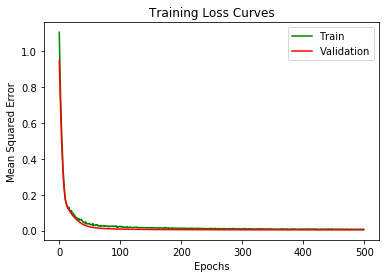

In [22]:
plt.plot(epochs,train_loss,'g-');
plt.plot(epochs,valid_loss,'r-');
plt.title('Training Loss Curves');
plt.xlabel('Epochs');
plt.ylabel('Mean Squared Error');
plt.legend(['Train','Validation']);

In [23]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

In [24]:
# predict on test data
y_pred = gs.best_estimator_.predict(X_test_scaled.astype(np.float32))

In [25]:
# get RMSE
MSE(y_test,y_pred)**(1/2)

0.06119058654728036

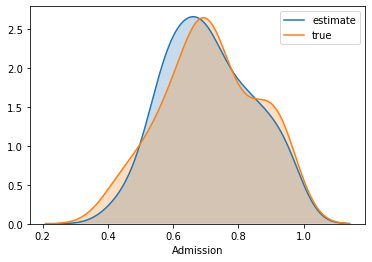

In [26]:
sns.kdeplot(y_pred.squeeze(), label='estimate', shade=True)
sns.kdeplot(y_test.squeeze(), label='true', shade=True)
plt.xlabel('Admission');

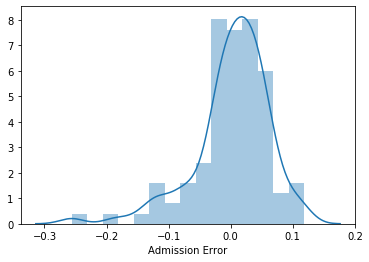

In [27]:
sns.distplot(y_test.squeeze()-y_pred.squeeze(),label='error');
plt.xlabel('Admission Error');

0.8169052403620555


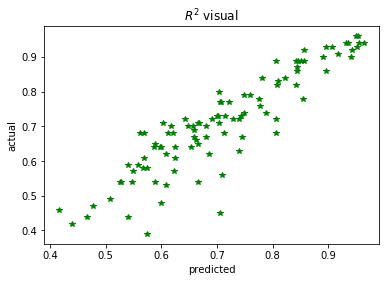

In [28]:
# show R^2 plot
print(r2_score(y_test,y_pred))
plt.plot(y_pred,y_test,'g*')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('$R^{2}$ visual');

In [29]:
# show where the big errors were
errors = np.where(abs(y_test-y_pred)>.2)
for tup in zip(y_test[errors],y_pred[errors]):
    print(tup)

(0.45, 0.70611423)
